### # Intial setup

Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on 08 Sep 2020

This notebook uses historic data on GHG emissions, wholesale prices and tariffs to validate simulation results for this outputs using certain input settings. 
The validation is performed with available data from the official start of the easter market in Australia in 1999.
Data sources, wrangling exercises and assumptions are commented throughout the notebook.

In [1]:
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'../')

import statistics
import datetime as DT
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns
# sns.set_style("whitegrid") 

import os
import glob
import numpy as np
import pandas as pd
import os
import glob
# plt.rcParams['text.usetex'] = True
# import matplotlib
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
from graphformat import *
print(get_settings())
plt.rcParams.update({'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10, 'font.size': 10, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8})

plt.rcParams.update({'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10, 'font.size': 10, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8})
None


In [2]:
freqs = [0.5,1,2,3,4,6,8,12,24]
# freqs = [ 0.5,6,8,12,24]

freq_dict = {}
for i in freqs:
    if i != 0.5:
        with open(f"../../{i}hourKey.txt",'r') as file:
            freq_dict[i] = file.read()
        
freq_month = {}
freq_year = {}


a_month_file = "/home/XXX/Documents/NominalSimDataMonthlySummary_30min.csv"

a_year_file = "/home/XXX/Documents/NominalSimDataYearSummary_30min.csv"

freq_month[0.5] = pd.read_csv(a_month_file, index_col = 0)
freq_year[0.5] = pd.read_csv(a_year_file, index_col = 0)


for i,j in freq_dict.items():
    freq_month[i] = pd.read_csv(f"../../csv/Nominal/NominalSimDataMonthlySummary_seed_{j}.csv", index_col = 0)
    freq_year[i] = pd.read_csv(f"../../csv/Nominal/NominalSimDataYearSummary_seed_{j}.csv", index_col = 0)
    




## Load BAU results
The model has two types of results reporting: Full and Light. It also provide results summarised by month and by year. Their used will depend on the type of validation. For instance, wholesale prices can be found in a monthly basis since April 2005. Therefore, monthly results on simulated wholesale prices are used in this case. Even though emissions can be reported for every month (and even every 30 min if needed), greenhouse gas emissions are usually presented in a yearly basis therefore, if further granularity is not needed, annual simulations results are used in this case.

NB! files for BAU to make validation should have the same seed.


In [3]:
# m_month_files = sorted(list(filter(lambda a: 'Monthly' in a, os.listdir("../../csv/Nominal"))), key = lambda a: int(a.split('.')[0].split('_')[-1]))

# month_file = m_month_files[-1]

# m_year_files = sorted(list(filter(lambda a: 'Year' in a, os.listdir("../../csv/Nominal"))), key = lambda a: int(a.split('.')[0].split('_')[-1]))

# year_file = m_year_files[-1]

description = "AllCombined"

filenames = []

In [4]:
#tests
#yearly_bau_results_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_1607046606115.csv', index_col='Time (Year)')
#monthly_bau_results_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_1607046606115.csv', index_col='Time (Month)')


#last file for validation (changes in tariffs)
# yearly_bau_results_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_1607932481652.csv', index_col='Time (Year)')
# monthly_bau_results_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_1607932481652.csv', index_col='Time (Month)')

# monthly_bau_results_df = pd.read_csv(f'../../csv/Nominal/{month_file}', index_col='Time (Month)')
# yearly_bau_results_df = pd.read_csv(f'../../csv/Nominal/{year_file}', index_col='Time (Year)')


#results with generation_consumption_historic from Sep db
#yearly_bau_results_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_1606371233282.csv', index_col='Time (Year)')
#monthly_bau_results_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_1606371233282.csv', index_col='Time (Month)')

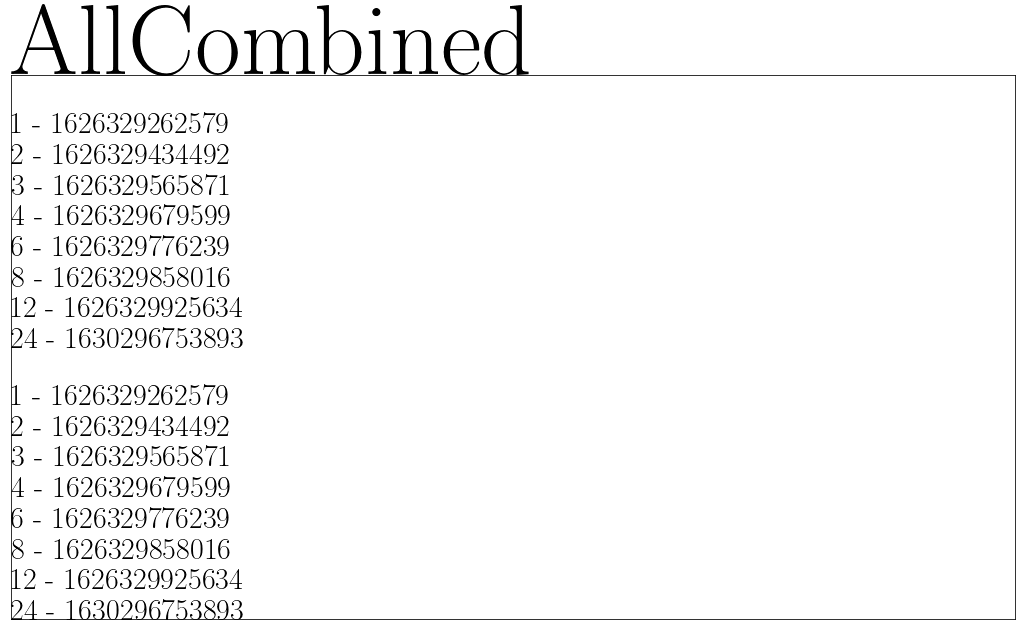

In [5]:
plt.figure(figsize=(18,10))
plt.text(0,1,description, fontsize=100)
plt.text(0,0.5,'\n'.join([str(i) + " - " + freq_dict[i] for i in freq_year.keys() if i != 0.5]), fontsize=30)
plt.text(0,0.0,'\n'.join([str(i) + " - " + freq_dict[i] for i in freq_year.keys()  if i != 0.5]), fontsize=30)

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.savefig(f"results/{description}_title")
filenames.append(f"results/{description}_title")

In [6]:
#annualSysProdDates= [DT.datetime.strptime(str(int(date)),'%Y') for date in monthly_bau_results_df.index]


In [7]:
# #Monthly system production per fuel type
# plt.figure(figsize=(16,10))

# monthly_bau_results_df
# plt.plot( monthly_bau_results_df.index,'System Production Solar', data=monthly_bau_results_df, color='orange', linewidth=4, label = 'Solar')
# plt.plot( monthly_bau_results_df.index,'System Production Coal', data=monthly_bau_results_df, color='brown', linewidth=4, label = 'Brown coal')
# plt.plot( monthly_bau_results_df.index,'System Production Water', data=monthly_bau_results_df, color='blue', linewidth=4, label = 'Hydro')
# plt.plot( monthly_bau_results_df.index,'System Production Wind', data=monthly_bau_results_df, color='grey', linewidth=4, label = 'Wind')
# plt.plot( monthly_bau_results_df.index,'System Production Gas', data=monthly_bau_results_df, color='red', linewidth=4, label = 'Gas')


# #plt.title('Historic vs Simulated GHGE(MtCO2e)', size = 20)
# plt.xlabel('Month',size = 10)
# plt.ylabel('MWh',size = 16)
# plt.xticks(size = 12)
# plt.yticks(size = 12)
# plt.title('System Production per technology type')
# plt.legend(prop={'size':14})
# plt.savefig(f"results/{description}_production")
# filenames.append(f"results/{description}_production")

In [8]:
# yearly_bau_results_df.head()

In [9]:
""" Filtering GHG emissions from BAU """

simul_data_GHG_total_dfs = {}

for i,j in freq_year.items():

    data_GHG_household = j['GHG Emissions (tCO2-e) per household']

    """ Converts household data in tCO2e into total residential data in MtCO2e"""
    data_GHG_residential = (data_GHG_household * 
                            j['Number of Domestic Consumers (households)']) / 1000000.0

    """ Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
    data_GHG_total = data_GHG_residential / 0.3

    data_GHG_total_df =  pd.DataFrame(data_GHG_total)

    # Since the market started officially in 1999, it is assumed that quantification of emissions stabilises after this date.
    # Therefore, the years 1998 and 1999 are ignored.

    simul_data_GHG_total_df=data_GHG_total_df.rename(columns = {0:f'Simulated_GHGE_VIC (MtCO2e) {i}'})[:]
    simul_data_GHG_total_df.head()
    simul_data_GHG_total_dfs[i] = simul_data_GHG_total_df

simul_data_GHG_total_df = pd.concat(simul_data_GHG_total_dfs.values(), axis=1)

## GHG emissions validation
1. load historic emissions and merge with simulated results
2. plot historic and simulated results
3. use a descriptive statistic measure to validate results from simulation against historic values

The key role of decarbonising the electricity sector in Victoria: The electricity sector in Victoria accounted for more than half of emissions in 2016. After the retirement of Hazelwood, this contribution still sited at 42% of the state's emissions. At the validation date (2020), historic emissions data for the electricity sector in Victoria is only available until 2017. 2018 number has been assumed to be 2017 (56.1) value minus a net reduction of 11.8 MtCO2-e given the retirement of Hazelwood in 2017.
Sources of data:
- https://engage.vic.gov.au/climate-change-reducing-victorias-greenhouse-gas-emissions
- https://www.climatechange.vic.gov.au/information-and-resources/greenhouse-gas-emissions-in-victoria
- https://www.climatechange.vic.gov.au/__data/assets/pdf_file/0033/395079/Victorian-Greenhouse-Gas-Emissions-Report-2018.pdf
- https://www.climatechange.vic.gov.au/__data/assets/pdf_file/0016/443014/Victorian-Greenhouse-Gas-Emissions-Report-2019.pdf

### load historic emissions and merge with simulation results


In [10]:
#A CSV is built based on the information available in these sources 
historic_emissions_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/19902018_historic_emissions_Vic.csv', index_col='Time (Year)')

In [11]:
historic_emissions_df.head(15)

,Hist_GHGE_MtCO2e
Time (Year),
1990,44.2
1991,46.3
1992,47.5
1993,45.3
1994,45.5
1995,47.8
1996,49.9
1997,52.6
1998,59.2


In [12]:
from functools import reduce

historic_and_simul_emissions_list = [simul_data_GHG_total_df, historic_emissions_df]
historic_and_simul_emissions_list

historic_and_simul_emissions_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time (Year)'), historic_and_simul_emissions_list)
historic_and_simul_emissions_df.head(40)

,Simulated_GHGE_VIC (MtCO2e) 0.5,Simulated_GHGE_VIC (MtCO2e) 1,Simulated_GHGE_VIC (MtCO2e) 2,Simulated_GHGE_VIC (MtCO2e) 3,Simulated_GHGE_VIC (MtCO2e) 4,Simulated_GHGE_VIC (MtCO2e) 6,Simulated_GHGE_VIC (MtCO2e) 8,Simulated_GHGE_VIC (MtCO2e) 12,Simulated_GHGE_VIC (MtCO2e) 24,Hist_GHGE_MtCO2e
Time (Year),,,,,,,,,,
1998,50.454577,50.454577,50.454577,50.454577,50.454577,50.454577,50.454577,50.454577,50.454577,59.2
1999,56.504491,57.054536,57.053720,57.053712,57.053704,57.053689,57.053673,57.053643,57.053552,61.8
2000,59.139099,59.940029,59.963939,59.964017,59.964095,59.964250,59.964405,59.964712,59.965617,62.7
2001,59.129026,59.997757,59.993535,59.993633,59.993731,59.993927,59.994122,59.994509,59.995648,62.2
2002,59.355351,60.256105,60.254599,60.254601,60.254602,60.254605,60.254608,60.254614,60.254631,60.4
2003,60.485598,61.335009,61.377613,61.377680,61.377746,61.377878,61.378009,61.378269,61.379035,61.5
2004,61.303690,62.040161,62.047290,62.047414,62.047537,62.047783,62.048027,62.048512,62.049939,64.7
2005,63.345402,63.188764,63.198658,63.198786,63.198914,63.199169,63.199424,63.199928,63.201414,63.5
2006,65.461779,64.735855,65.107184,65.107179,65.107174,65.107163,65.107153,65.107132,65.107070,64.3


### Plot historic and simulated emissions

In [13]:
set_size('thesis')

(6.5000002767400025, 4.017221097909045)

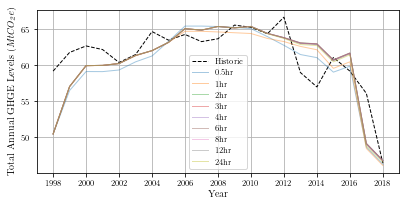

In [44]:
# plt.figure(figsize=(6.5,3))

fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
#xfmt = mdates.DateFormatter('%Y-%m-%d')
#axes.xaxis.set_major_formatter(xfmt)


yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_emissions_df.index]
date_years = [i.year for i in yearly_dates]

#plt.plot( yearly_dates, 'Hist_GHGE_MtCO2e', data=historic_and_simul_emissions_df, marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4)
#plt.plot( yearly_dates,'Simulated_GHGE_VIC (MtCO2e)', data=historic_and_simul_emissions_df, marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4)
        
ax.plot( date_years, 'Hist_GHGE_MtCO2e', data=historic_and_simul_emissions_df,  label = 'Historic', linewidth=1, color='black', linestyle='--')


for i in freq_year.keys():
    
    if i != 0.5:
#         plt.plot( date_years,f'Simulated_GHGE_VIC (MtCO2e) {i}',marker='o', data=historic_and_simul_emissions_df,
#              linewidth=4, label = f'GHGE - Simulated (STLM+CSI+MS) Hour {i}', alpha=0.4)
        ax.plot( date_years,f'Simulated_GHGE_VIC (MtCO2e) {i}', data=historic_and_simul_emissions_df,
             label = f'{i}hr', alpha=0.4, linewidth=1)
    else:
        ax.plot( date_years,f'Simulated_GHGE_VIC (MtCO2e) {i}', data=historic_and_simul_emissions_df,
              label = f'{i}hr', alpha=0.4, linewidth=1)
#         plt.plot( date_years,f'Simulated_GHGE_VIC (MtCO2e) {i}', marker='o',data=historic_and_simul_emissions_df,
#              linewidth=4, label = f'GHGE - Simulated (STLM+CSI+MS) Hour {i}')

# plt.plot( date_years, 'Hist_GHGE_MtCO2e', data=historic_and_simul_emissions_df, color='black', marker='o', linewidth=4, label = 'GHGE - Historic')

# plt.plot( yearly_dates,'Simulated_GHGE_VIC (MtCO2e)', data=historic_and_simul_emissions_df, color='lightblue', linewidth=4, label = 'GHGE - Simulated (STLM+CSI+MS)')
# plt.plot( yearly_dates, 'Hist_GHGE_MtCO2e', data=historic_and_simul_emissions_df, color='burdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA8AAAAJSCAYAAAAMD6xnAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdeZDcV333+/f5bb1O9yyaRSONLFuyFu+2jMEmOGC2sIVLHCiwSUFxc7nhjxRQ5BLqplKQKqiQPBceKs8FboiT1H0AJzFP4vAYYrgxixNjsEEY2zKyLcnaR6PZeu/+refcP7qnR62ZkSVbGsnW90X93N2nf/3rX/c0mvn0Oed7lDHGIIQQQgghhBBCvMxZ5/sEhBBCCCGEEEKI1SABWAghhBBCCCHERUECsBBCCCGEEEKIi4IEYCGEEEIIIYQQFwUJwEIIIYQQQgghLgoSgIUQQgghhBBCXBSc830C58POnTvP9ykIIYQQQgghhDiHduzYsaRt1QPw9PQ0X/jCF3jwwQdpNBpMTEzwmc98hptuugmArVu3Lvu4O+64g09/+tPL3nfkyBFe//rXL2n/m7/5G2699dZlH7PcmyFeXnbv3s327dvP92mIi5x8DsWFQD6H4kIhn0VxIZDP4cVhpU7PVQ3A1WqV973vfezYsYOvfe1rDAwMcOTIEYaGhrr7PPTQQz2P2bVrF3/wB3/AW97yluc9/l133cW2bdu6t4vF4tk7eSGEEEIIIYQQL2mrGoDvuusuhoeH+cu//Mtu28TERM8+w8PDPbd/8IMfsHHjxm4P8an09/cvebwQQgghhBBCCAGrXATrgQce4Nprr+VjH/sYN998M+985zv5xje+gTFm2f0bjQbf/e53ec973nNax//DP/xDbr75Zt773vfyve9972yeuhBCCCGEEEKIl7hV7QE+fPgwd999Nx/84Af58Ic/zO7du/nsZz8LwPvf//4l+3/nO98hiiLe9a53nfK42WyWP/7jP+aGG27Atm1++MMf8vGPf5wgCHjnO9+57GN279794l+QuKD5vi8/Z3HeyedQXAjkcyguFPJZFBcC+Rxe3FY1ABtjuOqqq/jEJz4BwBVXXMHBgwf55je/uWwAvueee3j961/P4ODgKY87ODjIhz70oe7tq6++mlKpxF133bViAJaJ7y9/UuBAXAjkcyguBPI5FBcK+SyKC4F8Di8OKxXBWtUh0MPDw2zatKmn7bLLLuPYsWNL9t29eze7du067eHPJ7v22ms5ePDgC3qsEEIIIYQQQoiXn1UNwDfccAP79+/vaTtw4ADj4+NL9v2nf/on1q9fzy233PKCnmv37t1SEEsIIYQQQgghRNeqBuAPfOADPP7443z1q1/l4MGD3H///Xz961/nzjvv7Nmv1Wpx33338bu/+7sopZYc5wtf+AIf+MAHurfvvfde7rvvPvbt28dzzz3H3/7t33L33Xfze7/3e+f8NQkhhBBCCCGEeGlY1TnA11xzDV/+8pf54he/yFe+8hXGx8f56Ec/yh133NGz37/927/RarX4nd/5nWWPMzMzw+HDh3vavvrVrzI5OYllWWzcuJHPfe5zK87/FUIIIYQQQghx8VnVAAzw2te+lte+9rWn3Of222/n9ttvX/H+z3/+8z233/Wudz1vpWghhBBCCCGEEBe3VR0CLYQQQgghhBBCnC8SgIUQQgghhBBCXBQkAAshhBBCCCGEuChIABZCCCGEEEIIcVGQACyEEEIIIYQQ4qIgAVgIIYQQQgghxEVBArAQQgghhBBCiIuCBGAhhBBCCCGEEBcFCcBCCCGEEEIIIS4KEoCFEEIIIYQQQlwUnPN9AkIIIYQQ4uUtqB6nefwZrGaCMdtQSp3vUxJCXKQkAAshhBBCiHPGL08y9fO7MTrGA5rT68iNbjnfpyWEuEjJEGghhBBCCHFO6Mhn5olvY3TcbatPPnkez0gIcbGTACyEEEIIIc46Ywyzv/4+cavS0x6UJzHGnKezEkJc7CQACyGEEEKIs65+9AkaU7uXtCdhg9ivLPMIIYQ49yQACyGEEEKIsyqszzL39AMr3h+Uj63i2QghxCIJwEIIIYQQ4qzRSczME/8Tk0Qr7hNUjq7iGQkhxCIJwEIIIYQQ4qwpPfsjwtp0T1t25PKe20F5cjVPSQghuiQACyGEEEKIs6IxvYfqoZ09bbmx7Qxtf1NPW1A93lMZWgghVosEYCGEEEII8aLFfpXZXd/taXMyRdZc8WacdB92urB4h0kIqtMIIcRqkwAshBBCCCFeFGM0M0/ch478xUZlMXzNO7HcNADp/vGex8g8YCHE+SABWAghhBBCvCjlfQ/jlw73tA1svrUn9KaKJwVgmQcshDgPJAALIYQQQogXzC8dprzvJz1t6aGNFC99ZU9bqn9dz+2gIgFYCLH6nPN9AkIIIYQ4N5JE0ygH1OciqrMt3LSNm7JxXPucPq8xBgxgDOiTbxvMwnVD97ZSgK1QttW9VLY6p+cpXrwkbDH9xH20f5htlpdl+Oq3o1Tvz8/rG8WgUJ1941aFOKjjpPKrecpCiIucBGAhhBDiZcSvR9RKPpX5BsdnZqnXKszPzlCerOBYLq5y8GyHdCpFprO5no3jWjiujeMqbKsTXDRgOoFVL4ZYc0J4xYA54T5MJ/CeBUqpThhW0AnEyrHAUijnxLDcue4olNVpW7jfUijrhQdpYwxBEqCNJutmz8rrerkwxjD71P0kfrWnffiqty8bai3bwXhFVFjutgWVSZyRLef8XIUQYoEEYCGEEOIlLI6Sdi/vfMD8XJX58jzNWpWk3iRVj7BrTQaaTVSmSezYxK5D07FBWe1eV6WwlI1tOdi2g6NcHMfBdV08z8HzXFKeR8rzcFwL22lvrELnrDEGYoOJAZIXfBxlKXA6AdpWGAtCExHqCD+J8OOQVhziRwFhHOHHMX4UEsQRQRyjdTvb5/vTvPKGq1k3uPasvcaXstrhx2hOP9vTVth4E9nhy1Z8jPYGsU4MwOVJchKAhRCrSAKwEEII8RJitKFVj6iXfGrzPrOzJRqNCkGtCo0QrxHi1RuYVhMThWgMJk7QQbP3OLaNsRXGsog711EnlAZRnR7Y9hWUUihlY1udzXVwHRfX64TlVIqU5+F5Ho5nY1kWSlkoS3UuT7iuVM/ts0EbTRiHBHFIFMWEUUQUxURx+zJOEqIoJokTkqQ9NHslCsgAGSzAa79fQFCJebD0CzZeNcYrtl6Ha7ln5dxfisLaNPPP/KCnzSuMMXj5b57ycTo1APXF21IISwix2iQACyGEEBe4KEiol3zqpYBqqUm1UqJZrRA1mjjNCKvpk6o30X6TJIk5cT6mwqCsCEuBQYGxMIBKEkhO6shVCmNbGNsGa+G61TkKQLzYD9ta/lwVYCkLy1JYzkKPsY3jWDiu0+lddrBte/HJbYWlLNCgsFAalFFoo4mTpL3phCRJSJJ2W6I1SaLRWpMkC8Oy1eJJdF7PyV3VJ89LZeF2T/tJx+l8CZBKPEZCl9mfzfCdow/wqpuuZ21hbPk34mVMJxHTj/9PjF7slVe2x8g170RZp55fblIDPbeD6jGM1u2h60IIsQokAAshhBAXGK0NzUrYDb21cp1GtUxQr5E0WthBjGq2cOsNTOgT67j72Pao5gTLSrBt8GwbP/TxMhptEmLTDo+xSYi1IUkMiVEYozBaoZN22DWd/2FAu+1QrF0L7dpo2+r0GC/sR89/ezJn0tmC3tdoWRaua7c3z0UBURwTxwlRnJDECSYBC4WFhTKqfd1YWChU57J9vb2PZRSKxesL+70oRmPp9itLbAs7kydj8rBX8cj0Lxh7xQg7Lrse1754eoPnn/4BUWO2p23NFW/GzQ2s8IhFxs5ieVl02B6RYJKIsD5DqjB6Ts5VCCFOJgFYCCGEuACErZhaJ/A2Sj6NapVWrUrUqGP8EMuPUM0mdqOJjgKMOaH3TWmUlWApjWtb2I7GcgxWWuGuyZHYfYwNDhLXasTVKjoI0cZgjEYbTZRERElMnETEOiaKE0KtiRNNrEEnBh2BCW3Q7YipLIV2HXAccG1wbYxjn9STujKtNUGgCYII8JffSYHGoJd0VZ8BQycUnxiUwUksXCwcpfCMwsbCNeAY1dkMtlE4WFiWhR9qao2QKNbooIWdL5A3aao/nOeBAz/gupuvZW3+5T83uDH1NLUjv+ppy49fRX78ytM7gFKki+M0Z/Z2m4LKpARgIcSqkQAshBDiglXza1SaNfKZHH2pPPbzDK98KVlYoqhRCqiXAvxqi2a1QlCvETdb6CjCaoWoZhNaDZI4wpj2xNX2MON2L69laRwHlJ3geEDWITM2wuDmLQxcvoVssZ+nn36aTdu3d59b+z5JuUxSqZCUOpfVSruqM+3iU8aYxZCsDYmOiZKQIIkI4oBWGBPECUGkCeOEIIyJWhGR7ZDYLsZ1SFwL7VhgWWB0Z8mjTkUpo9vVozlLFaMBCwsHcJXCweCgcJRpXze6fakTbK2xbHXKrG6AuLMB2G6KAaePWivC7wzJtrwUdq6Au9fhiWOPMbnjENdsu+Fl2xsctcrMPnV/T5uTHWBo+5vO6Dip/nW9Abg8CRPXn5VzFEKI5yMBWAghxAVp975neOb+X2IFGuPY6LSDk0/jFXKk+zJk81nyhRx9uT4K2TzpzELxpQt37Vi/0S5eVZ8PaJYDonqTZq1CVG8Qhj4qilCtABpNlO+TJOHCoGKU0th2grISbGVQjsZ2DLansQo58uMbGdiylYGNl5LOnXpdVSudxhobwx1bnL9qtEZXq+0wvBCOy2V0a6F31gOefxmgRCeEOqQVxrSidkD2lcJ3U7Rcl8By8S2LxHPb84yN6Qbi9om0/2OMwVIWnu3gAGml8JTBQ+Np8NCktMbRMalEYydRe14zdIdut4/TbVlcnsn03l5y2Xm86ZwHQKPZIFSzZN0sXjNHoxkRGYMOQ+xMDsvkKT1U4qEDP2TbK65k7cj6532vXkqMTph54j50fMJYdmUxcu07sRzvjI6VKo733A4qUghLCLF6JAALIYS44MxW59l7789JzzdRWrfnmlrtnkRjW7Rcj5brMu84aNdBezaW52G5Lm7aI5VLk85nyOdz5Ap5MukUbsrG8Wwcz1q1oJxEmno56IRen7gWEdRr+PUaUbNJlIRYQYhqhVjNBjoM0EmEwbSLVymNbbVDr7ITrIXQm7Kw+4sUJjYwsGUr/evW46UzL+pclWVh9/dj9/fDJZd023UQkJQ7obhcJqmU0dUqJlm+jLJt2WSsDJlT/IVhTNJeZshL43tpWp4Ljk3aQMoYUlqT0glOFELon7qTuPO5wD03f9Iox8HKpIkqVebK88xXSqi+FrkgR9DK4KccklajOyyaQ2l2zz/B8cuPsP3qa0nlXtzP5UJR2vcQQfloT9vglteRegFFwFLFMdp99u0fbNSYI4l8bDd9Fs5UCCFOTQKwEEKIC0qSJDx673/izdRRcW9xp0XNdsViq11tWFkW2Da4LpHnEnkeTacdkFEWyrGxXAfLcXFcD8dLkcqmyeazpHJp3IzTDscpC9d74UHZGEOrFnWLV7VKPqYV4teqhPUGftRCxxFWEKFaPlajiY5DtG5XbrZUgmVrLCsBFYMTYzsGxwU7ncYZWEPx0ssYvPxyCsOjON6Z9by9EFYqhTU6gjs6svg6tUbXakt7i5srlIY+iVKKjOOQ0TH49RWnAJ9LVjqFSmewMmlUOo2V7lxmMu3rC5dO+0+laGoK+2c/o5AvMD03TUPV8ZwmppEndnLELsTVMpbrYccF5naV+fnx/+CyLZezdvNGlPvSrXLcmjtA5bmf9rRlhjdRuOTGF3Q8y0nh5dcQ1me6bUFlkuyaldcPFkKIs0UCsBBCiAvKzx/aibV35qTwq7pDgbuMWWYpn8UAZjoBGddBOS7a9VCeR+S54HnUlWIOsJSNbTtYrovjutiuh+N6uKk0tutgpR2cjIOTstvhONUOxwtB2XYUrVpEreTTmPPRjYik0cKv1whaTfzER0Vxu6e32cJqtdBJhNZxZ4miBMdJUCpBWyHKSbBc8FwLO5/HHRxiYNNmBi69jL6hYSz7zOZBB0FAq9WiVqt11uZVWJa17PXTpSwLu1jELhZhw4Zuuw7Dbk+xrlSIy53e4jg5xdHOHmVbpxdqU6kzXnbHHRuj8MY3Yv/0p0x4HtVGjZm5GSy7SrPVQodFtJtCRyG6NIvtZ9FRH8+0djM/eZxLt24jO96PuoCH6C8nCZvMPPmdnjY7lWf4qred0WfmZKn+db0BuCwBWAixOiQACyGEuGAcOTJF6SfPYDcX5xnatmF83CUIIvwgJo5Me6kebWG0he4Wa1LtdW4XdAPy4ho8J66Oi+OA45J47XCM6xF4bruicecPewsbx3Jw7Xbvse22e5BdL4XluhhHgaUgSAjrdcJGg1bcIkpCVBhh+SF2s4UJA+I4BJMsLlHkJiQqwFgxOLodql0Pq9BPeniEgcsvp3/9BPn+wTMKa1pr6vU6lUqFSqWC7/tMTU2h9fJDlrvvSCcMnyogn879lmWhBgex1qzpttFoYOp1TK2OqVbRlQq0Wu37Wbo27+Jc3A7XRWU6wTWdxkqlIJNpX6bSqHSqfd11e+bz6s71+MQ5vlGECcOV5/8as2ybUop8Pk/+ttto/epxCnv2kM/kmCvPo1SJMJ6j5mfAK6BwSFpNdOBjggLTfolK41E2HtnI6OYN2EPpFxUeV4sxhpld3yUJ6j3tw1e/Hdt7/vngp5LqH++pJi3zgIUQq0UCsBBCiAuC74fsuu+nWOU6C9HHAtZtzLDxtbegWy10vU5QLtMslwiDgCAICIOYMIpJYo1OIFlYy1Yr0A7GgNYK6ARk01nnNo4gjuCEKaYKhVI2ODbK8cBziV2P2HMwto2xO0OtVafisOVgWzZBEqKTuL1UkR9gt1roKCBOIiBGqQTb1qBCYstH2wmOCxnXxUllsIv9ZMbWMrD5cvrH1pIpFM8oIIVh2A28tVqNJDnzHldjzAt63Bnry7e3JGn/TJtNjO+3C2G5LmqZbdlyza1We1tl/f39jG25nNyaIZo//wXDg2vaw6Lnp3HsJtVmiJ8qYJsUtm4Pi9Ytj6TZx55wL6XqPBvGLiW3cQC7kFr18z8T1YO/oDWzr6eteNnNZIY2vuhjLymEVZ7sftEghBDnkgRgIYQQF4RffP8R1NHZbiVfgFx/zMY3v470pk3dtjwwaAym2SRpNNCNBkmtjl+apzU/h18p06pVCcKQKGp0ArBBJ6D14ma0BdrGMg4Yq112SisgxsQKE/mYVvuPcYVCWfbi5rgo1yNxHRLb6g5v1klEokMUMVZnaHOsWkRWgOVoUo5Nn5vCyhax+/vJr59g4NLLKA6Pks6funLzibTWNBqNbuhtnYcg+KLZNlY+T9ptkHUPokxCYudI7Dyxkyex+0jsFOYCC0TlcplyuUxfXx/Dr3olzpNPkqpUmRhbT61RY3p+hmqjTMXK4bse2bgzLHp2Dt3MMj0KlbDKJeUNrBkdxZvow8peeMsmBdUp5p/9UU9bqn8dA5t+46wc380NoZwUplNVWsc+cbOEmxs8K8cXQoiVSAAWQghx3u3ZdYD6k/uxWicMffYittx8dU/4XaCUQuVyWLlct+3EAZkmjtHNJnG1Smtutr3Nl2hVSviVCmEY0O73jUgSn1i317o1GnTS7ozEKJR2sPFQOKA7vceJQkdWZ7pxOxBrHWNZcbtasxUQqSbGTnAcQ8ZL4zpZrL4CTn8/hUs20r9+gsLI6BlVbg7DkGq1SqVSoVqtnnZvrVKKVCpFPp9Ha90eGqz1kuvngxvOkK8/2R24bsUV3LiyMGIdgMRKnxCKF4JxBtT5LSpVq9Wo1Wpk1q2j6Hlkp2foy/WR6wyL9uZLVKMMtaxBBZBPMiTNJvqgT1LLs2/tPkp+iYnSBJmRAu76PJZ3YaxzreOA6ce/vbg0Fe3CVcPXvAN1ltbiVkqRKq7FnzvQbfPLRyUACyHOOQnAQgghzqtqqc5zD/wSVT1hnqFK2LipwMDNN4NfpR1WT+oJ7OkZVCfdpbDTNnZ6gNTIIP1s6Xlc1GjQnFkIxvO0yiValQpxs4kOQzqLwJKYhFhXiZIYrSHpLFdrNFjGwcbBwkHbCYFqoRxN2nUpOGlsN4XdX8QZGKT/0ssojo1TWDN82pWbjTE9vbzNZvO031PXdSkWixSLRfr6+tizZw/btm075WOWC8UL11cKzS9mXxXMk6s9efJPdQlb+9jax4tmF98bLLSTR7t9aLeAdvrQXhHsVPvLkc5nY7nLU913qn2azSaNRmPJ+bWCgFahgK01hakp+h2X4cE1FPsKTM1MM12r0cwOMKsrZKM02SRNNFslqbnMrE+ohTU2BBMMzA3irs3hrs2h7PMb7ud2/ztxs9TTtubKt+Bm+s/q86SL4z0BOKhM0rfu6rP6HEIIcTIJwEIIIc6bJNE89t2fY2ZmsTrryiqgOBQzctPV/ODbf810qXZC8aoTrp1cFHrFGyc97hTnoy2NtiNUEIAftrcwwopjrESjkgQr0RhAY9BKYzBYKFzlgOdRzmYw+Rxetp+07ZExVapHd+NN78FxXFzXxXNdPNfD81w8x8VLtdtsy6LpR1QaPtVGi1jT7unsbuqk2+1NKUUul6NYLFIoFMhms2c8l3KhgNVqiBolJh/5EZoX1vOs0NhxFTuuQmtxbVrLy+L1jeDlh/H6hvH6RnBza7Dss/PnTrVaZWpqimq1uuS+pL+fOddlZv8BBpViMJViw/h6Bho1Dk3N4TgFajmY9ucpxnlSAfj7SiSDGfauCxgK1jART+BON/HW9+GsyZyXitH1yaeoT+7qaetbfy25sVN/gfJCpPrX9dwOylIISwhx7kkAFkIIcd78+ifP0HruEJYfdtusTIPLb7yGex78/9g7NX+ezkwBKUinIGVQRqMSjdIJVhzjRjFOFGEnGktrEtsi9DzCdBrtOuhYwXS1vZ3Gc7WLb1nt60rhWArbAtuysBXYtsJWFraluptrKzKuIuPZZFMOVddl1nWwbQ/XdXAcB9d1cZyYcnmaY+HTFHODZLIFlJMBxwM7BU4anFR7s8/9XNQkaDC185/QUe+85cGtr8PNDhHWpwlrM4S1GaLm3NJvOk5Bh038uQM9vYoohZsdbAfi/Ahe3zBu3whOunDaXxIYozEmoVAoUCgUaDQaTE1NUSr19pJauRxq21Zm9u9nplJhKJViKJNj+6U5pufnOVxN8HODzIUl7KhJf5yH+RZJzWdmfUg1rLKhbwMD+zXRVANvQx9Of/q0X/+LFTVKzP76+z1tbm4Ng9vecE6e7+RCWGF9Gh2HWM65X99aCHHxkgAshBDivDj+3BzHHn0KVT1hWKkVsPnyER6a2sveqXkUnV7P7rI4hlP34Z4DSmGUjbFswCVJQQTtZZa0RmmNsVT7/tPudW0H3vYiQL2MMUSJIUqAJT2kph3GTvk+GFIpn3S6STrdwrHb6ynvPPxw55ktHMvFVSlcK4XneKTtFGknRcbJkkoXyWbyZLM5ctksuVyOXCaH5Z4clr3O7TScZs+xjkOmfvk/iFvlnvbiZTdT3PhKALIjmxf3T2Kixmw7ENdnCGvTRLUZknDpUOQVGUPUmCNqzNHg6W6zclLtnuL8GpxcESubx0qnMSoiSZokSYtEty910g7rrjdIsXAdudwomzZtotVqcfz4cebm5rpLJinHIXX55UTHjjF9dJLZwGfAS7FmcJCBQsz+mRqOO0DN8ZkK5sjpDMU4jz5QJy632LvWZ6gwzAY9gX4mxi54eBN92PlzGwqNTph+4tuYZPHLKGU5jFz721jn6IsR28vgZAcWh1sbQ1CdIjO44dQPFEKIF0ECsBBCiFXnNyKe/sFjmLk51EKhHZUwNKaZ64OHd+5HKbsbEEPlLpkFvBD/jDE9A5zbOeSkdWRpL4J04iU993Uu1XL3rRA0FSjbgA328w7l7e3lPRMGDca0L1dgWTHpdKu9pVrLvo4TjxfpgIgAEjppvpc2FklikyQOSWKjEwfH8vCsNGnbI+2kyHoeOc8m4zlk0inS6QyZbI5sNks+lyOXzeGlMp2wnMLYLtN7HiKsHut5rvz4VQxsvnX512U7pApjpApjPe1J0OgG4vblDFF9FqPjld/Ik9+HOCAoHyEoH+m9w7VRaa+zuVhpDzwHpRRROM/s7A/JZDZQLF5PJpNl48aNjI+Pc/z4cWZmZroFxdy1a7FyOcLnnmMuCJgPAvo9j41j/QzVfQ76WTL5LHOtOSatWQpJjkI5i26UmB5tURuqsKG4kQEGaD01hzOUwZvIY6XOzZ9u83seJKxO9bQNbr0Nr2/knDzfgnT/OPUT5hsHlUkJwEKIc0oCsBBCiFWlteHXP3iK1uQRrLCdvhRg5ar0T0zwjcef6gm/TXeAq699BfaKNa9OLoDV+3wKheU42I6LZTvYtoPtOFh2e7OdxdvtAki9jz3pYEuuGiCKNa0wJAwjgjDC9338Rg2/USNs1YmjiDhJSJKYJElItG5fdjatE3SSoLUmMZ35xQZAY3c2C43TvZ6Q9Vpk03Wy6QaeG3I2WUpjORrXWZqOo85WCS3iltMNyb2X7espux2Qsymb6yfSrBvo7UmMtM3MsRkalXvI5fMUC0W8dA7cHLgZcLOdy0zPD9ZO5Ui5Dk6hn1SyniRpEcc1osY8UWOeuFFFtxrolk+nK/30RQkmamFq7V7fBEApVMrFKmSwhgq0Wofw/Un6+q4kn9+K53lMTEwwNjbGzMwM09PTxHGMXSiQvuIKwueeI6k3KIUhpTCk4LpcXrSYDtO4yqUaVqmEZep2k2KcJ38UkmrAnpEmQ4NjbChsgDlI5n2csSzeeB7lnL352s2ZfVQPPNrTlh3ZQt/E9WftOVaSKq6jPvlU97bMAxZCnGsSgIUQQqyqQ48dZe7pPVi1xWGsiVth04Yhvr33aYLYoFR7qRWfNLfc9EouHe47i2cQd7aFJ29vSqnuvNmFzfO8ntvtObXOssWiWq1Wt2JzvZ5gBjJABjh1D5pt2xQKhW4BKyyHVpQQRAmtKMGPNK0ooRkE+Pr6TJQAACAASURBVMExQn+SODpGFPuEiSZKNHHcDtZRkhDHi8E6ThLiWFOp20AISQObEJcEWyU49G7WGQwvtyyNZ4WwQvg2gNY2SeywcXCMdQO9P8PZesR9j08TJb09wlnPopCxKGYhn4FcGnJpQzrjks64pNIO6YyF47ntYdjdrXM7C1Y2g0V7iSmTaEwQYvwI4y9edr5hOD3GYPyQxA9J5mrYI0WsgT6q1cdpNp+jWLyBdHoc13UZHx9ndHSU2dlZjh8/Tgiktm4lPHyEeHoagGoUUY0ick7AulyRTGYdmWaGudYc86pKTTfpr+XJBprpWpPqmhKXDF3GYHqQ6FiDeKaFty6PM5J90YWy4qDOzK7v9rTZ6QJrrnzLGRdSeyFS/b3zgIPy0XaV8Ats/WchxMuHBGAhhBCrpnKszsFHnkLPz6EW5vWqgLERm4dLU0w3IizV/tWUYHPZlTewZXyQgYEBoijq2c722rXGmO6xn8+Jgdi2ber1OmF4+r2wmUymu0xRLpdbEqg9x4KMSxzX8P1JfH+SwJ6GzMJrztK78nEv286SSo+TTo2TSo3yzDN72L59O8YY6n6LuVqFcqNCpVml2qrSaNVoBHWCoEoYVggDnzAMicKAKI7QcdQOySrBJmkHaDQOMQ56xWHltpVwydAAV42O9tzXjAJ+NfNrhkfjTq+x3TnvBNtOUBjqQN0H/OVfo2NbpB2LtGt3tvZ1z0uRSmfaQ7IzabxUGsv2IONBPg12H8Zy2z29nUBMqNF+iPFXeLITJZrkWIlktoo92o8pGubmHiSdXk+xeD2Ok8e2bUZHRxkeHmZ+fp6pqSnYMIGdzxEePIjpVDxvxDHEc6Rsj8Gh9aRqOcrNWSpBmRmvTFp7DMzn0a1p9lTrDI2u55L+S3Bjl+BgtV0oa6IPZ+j015M+kTGGmSe/gw5PXGJLMXLNO7C9F3bMM+Xlh1GW0x2+noQNEr+KkymuyvMLIS4+EoCFEEKsirAV8+yPfk3r+FGsaKEHVuMWKswZi6dKjW74BUiv3cbNWyfYvHkzuVxuyfHiOF4SipfbkuQMh8CehtMNygssy+rp5U2lUsvuZ4wmDGe6oTeOT6eKdJvnDZFKj5NJr8N1B5bdRylFXyZLXyYLrF3xWEnidwpBNUmSBn5Yp9qqUWtWqXXCcjOMaYYJzSDGD0KCMCAIQ8IwIAoj4jjkkozH1SO983fDJOZnk3sIkggFOHbcLdR1JuJEU0809WDlxxoUGIeUnSJleWTcNFk3TdZLk830k8sNUewbo79/gL6+AsZOE8UhYdAk9KuEzdLKRbeihOTIHHq2ij06QMscJgiOkc9vJ5/fjmW1RwqsWbOGoaEhyuUyx7JZGtkswb597eHZ3UOFmPJzONlRBrKXkilPMe/P4RNyzMyTa6UZ1JqZ5l4qg7NcunYLg+lBdJDg7y1jH2vgbShgF86sUFZl/yO9FbOB/k2vJj0wcUbHeTGUZeMVxwhKi3Ox/cokeQnAQohzRAKwEEKIc84Yw4GfHGT+0HNYjcXlb2JvloEU/OtcBcta/OPdz63n7Tdu59JLLyWTWb4CreO0l/rJZE7dU5UkyWkF5Tg+8xB2Kul0utvLm8/nV1xjN0kCgqAdeP3gGEafXrBWyiWdXks6PU4qtRbbPnvL5dh2unO8QQDywJoT7jdGo7VPnDTRSZO4E5STuNmunBw3iesVov3Huz390K5pvTeTx9p4IyqMCE4MzkFAHPk4JsZTMS7tzSPGYemXGMaopfOPde9cZK2XKzqmgWZnW5xvaitFX9ohn3bpSzsU0g59aY9sLk8+P0afl0BYWlJoy/gR8cFpVDaFPTZAzeyi2dxPsbiDTKa9zq1SioGBAQYGBqhWqxwbHGRu1y7i+cXiTwpwm8dRqTxW/whDrTyN+gzVsEJD+TRDnyIZijMJz1R3MjS2nkuHN+NaLkkjorV7DmcgjXdJAStlP+/P2C9PUtr7Hz1t6YEJ+jfd8ryPPdvSxXU9ATgoT5If277q5yGEuDhIABZCCHHOTe+eZ3L3HiiVu0saJVaVoVzMv5cb7fVoO1pOkbfcsoMN67P4/o9pNn2UcrDtbGfLYTtZHDvX09ausLyUbdvYtk06feqAqLVeEorDMDztoGxZFn19fd1e3lM9XxSV8f2j+P4kYTj7fG9fl+P0kU6Pk06vw/OGV3zN55pSVve9X07UKnPs6a/3hF+Avs1X86r+fDc4a907bDzRhkYYU/MVtcCh7NvMNx3mGoZSNaZSD6hUQ2q1ADuJyaiQNAEZQrIEeOr0e+VPlhhDuRVRbq18jPFiit+6fj2OaYDpHYJvmgHxc1OoQhYzGjGf/Aep9Fr6iztwnMX5z4VCgcIVV1DfsIHDv/wlM7t395Qrd4I6fbFPs2+clDtOfy1N3Z8j0hHlqEVN+wzYGczBiEpphksntrMmNwxAXPJJ6iHprYPYuZWXLtKRz8wT3+55DZabZviad5yXz9SSecAVKYQlhDh3Vj0AT09P84UvfIEHH3yQRqPBxMQEn/nMZ7jpppsA+NSnPsW9997b85hrr72We+6555THffTRR/n85z/Pnj17GBkZ4fd///d53/ved85ehxBCiNNTn2tx8JFn8GeOYnXCo1EhXq7EE9UmDS/HQi+dT4qbbryJLRuLKLUb3ekNNSYmjqunHBJs2RmchYB8YljuXi4/7Lj7eMsilUqtODx5wclBOY5jPM8jn2/P/Vz+MTFhON0d2pwkp7mOrbJIecOk0+tIp8d7gtSFKglbHN95z5Jhw4PbXk/xklf0tGkdt4dZ6/YcVNvKYtsZLOvU685qbSg1Q6ZrQXur+kzXAmYqDcrVKtVqlXq9QrNex05a3aCc7YTlFxqUJysBf/fjfdyyeZgd28YJTlrSCcBUm0TVJtZAHjMSczw4Tj6/jb78lVjW4p9d+Xye7bfeysTmzRz48Y8pVWvdHKySmFz5EF5xjPrQWqhnaFan8eMGSWKYrTep9TUZaPnseXon0yNr2Ty+Hc/2MJHG3z1H6vIBnOLSz7Ixhtlff5+4VelpX3PV23DShRf0vrxYqWJvAA6rUxgdoyzppxFCnH2r+i9LtVrlfe97Hzt27OBrX/saAwMDHDlyhKGhoZ79brnlFv7yL/+ye9t1T/2L8PDhw3z4wx/m9ttv57/8l//Czp07+bM/+zMGBwd585vffE5eixBCiOcXRwkH/+MApakDWI32nEeFIUodo1mrsT+d7y41pLHYsPUGbty2Fs97tht+T5dOWoRJC5hb9v5T9yK3L0+n9+t0g3IcN/CDSQJ/kiCYxpjTG2JtWalOL+84qdRYz9DwC51OIo4/9j+IGvM97YWNNy0Jv0BnnmwBlzMLXpalGMqnGMqn2L7yVGaMMVT9mJmaz3S1HZaPV31mqs12UK5UaNSrNBo1TNg87aD88N4Zfn20wm/fvI2BPpdW6fDS96JUR5cbWEN91IafpNU80Fk7uHeN2/z4OFfcfjvlhx7i2KHDlMKgW6DarUxRzBVoFIfxMn3UylPUG7NAQlBTHE/XyOYbBNMB9dIsGzZsZ6x/HJMYgmdKcFkRZ03vFIH60SdoTO3uaStsuIHcyOXP/8afI066DztdIPHbX3AZnRBWp5f0DAshxNmwqgH4rrvuYnh4uCfcTkwsLbTgeR7Dw8Onfdx//Md/ZGRkhD/90z8FYNOmTTz++OP83d/9nQRgIYQ4j448cozpQ89BqcLCOM/AncZuVXnMy3aXOwJwRrfwphs3kc8fIElOoxrvGTrzXuTFcOw47eBsWSuHXmMMYTRH0OnljaLSivuezHUHuqHXdYdekkvAGKOZeeI+gvLRnvbc2HYGt7zuvJyTUopixqWYcdk8cure82YY94Tk6VrATLVBpVylVCnTOvwrxtXicPVyK+S///AJbrx0DbfdchPNyhHC6lTvQY1Bz1bR83X0cIG5qE46s5ZicQeuu1jkyUqlGLjtNjJP/Zr6k08yFwTMBQGJMViNKn2Rj9+/DtuZIJsbZG7+EH5Yx2kpmpEm6J+jX4fEz/6K0vBxtm68FgsLf18ZL9J4a9tF5ML6LHNPP9Bzil7fCANbbnuR7/SLly6O0/AX/7/pVyYlAAshzglljDmDhfBenLe+9a285jWv4fjx4zzyyCOMjIzw7ne/mzvvvLP7y/5Tn/oUDzzwAK7rUigUeMUrXsHHP/7xJb3EJ7rzzjvZsmULn/70p7tt999/P3/0R3/Er371qyU9yDt37iSbXXn5CPHy4Pv+8875E+Jcu5g/h43JgOqTx2lOPYfdas/1jFUVP36WvXaOet9iAGikRnj9ju2Mj05h6B2a6TqX4LqbMaaF1j7GtDCmfanNwu1gVV6TwkapDEqlUVYaS2UAD61LJMkMhtMsYIWFZQ9hWyPY9jCWdW4/I+f8c2gMTulJnPr+nmadGiIcuRnU8xdlutD9etrnWw89zvrmr3Hp7c3v8yxevXUdazduxm4cwIqXH+KeWNDKOgQpG9fdiOtuQqmTRrnNzsITT6KjkGqSUE6SdgkwpQj7x2iaHEZr/EaJav042sTYgJWLKLhphsIBUvkCl4xtw7Xbx076bfQahXf8P7GixZBplE049psYd/WG1q/0WbSre3HLT3VvJ9l1RGtuXLXzEheXi/l388Wk2WyyY8eOJe2r2gN8+PBh7r77bj74wQ/y4Q9/mN27d/PZz34WgPe///0AvOY1r+GNb3wj69ev5+jRo3zpS1/iAx/4AP/yL/+C5y0/DGx2dpabb765p23NmjXEcUypVGJkZGTJY7Zvl+qCL3e7d++Wn7M47y7Wz2GrErD3sWeIGjN4UQKODSrBt44y6zvU+xfDb8vu422/+Wqu2eoTxxlgcchmJrOBgYFbnrdH1Bjds2xPslCZOK532093CPLpi4HaCbdX/qIWwLZz3V5ezxvpmQ96rp3rz2F5/yOUDveGXze/hrU3vR/bfXn8kbl9O7ztlmv4q+89wa6ffo91aqZ7Xy3UfO/Jw+yoNnnzG9+IsR3Kzz1MEtR7jmFryNdj8pHCGZ3H7of+4nVks5f27KdvuIHGT39KPDePNoZyGDLj+4RJE/rTNLwh4rCf4Xg9s3OHqDXmUJGHb0F9wCfjZ5iu7Gf75TeSddtf+DeqO2lGvaMfhq94E33rrz1H79jyVvos+qU+jj26GIBTps7mi/DfTrE6LtbfzRebnTt3Ltu+qgHYGMNVV13FJz7xCQCuuOIKDh48yDe/+c1uAH7b297W3X/r1q1ceeWV3Hbbbfz4xz/mTW9602qerhBCiBcgSTRHHjrCzPEDUGkHRAXU7QNU5+scG15cFzbE5cYbb+bqrYY47i0o5HnDDAy86rSGAytl4Th5HCe/4j5aB+1gHDe6IXkhMLerErdWfOwLo/C8oW4BK9ftP8vHvzDUJ5+i9OyPetrsVJ6xG97zsgm/C9KuzSffcT07r9nIf73ne4yUfkXqhHnCOw/Osfeb/8zbX3UlV7zyPVRn9lHZ/zN0fNIIhSAiPjRDMlNhbqxMY2Af/f07uus3W7kc+de9jtbjjxPs2ctgKsWA51GNImZqFZTXIhxcR7PhMjq6iUJzDVPT+wiCiNnZkKgwz9q6YdfTP2PL5uvJODWajV09p5Ab205+3TXn/D07XV5hFJTVrUwdtyokQQM7tXQNcCGEeDFWNQAPDw+zadOmnrbLLruMY8eWVlFcMDo6yujoKAcOHFhxnzVr1jA311v0ZHZ2FsdxGBgYeFHnLIQQ4swc++U0c0eOEs1OoZL2+q2BPUOjMsWh4giJ1R4Oq7EY23wdr7uxnyR+tucYjlNgcPA1PXOEXyzLSmFZqW7IOJkxyQmhuEm8sK7tCWH5+XqRleWSTi2szTv+vJWnX+pacweZ2fXdnjblpBjb8R6czPmpKLwadlwywF0few//7fvbePLh77NOTXfvq7QivvmjX7HjucP81hveyPrf+DCVA49QPbQTo3vXMzatkHj/cRozVfyxSfqGrqBQuBrLSqFsm+wNN+AMDdH8xS8gTih6HkXPoxZFzM4dxh1aS813yWSLrB+/gmNTzxDGPqVKSODNMmEGeXbvz9g4UepZDdlJF1lzxZsvqLnmlu3i9Y0SnlBZ269MntfiXEKIl6dVDcA33HAD+/f3DpE6cOAA4+MrFzmYn59nenp62WHMC6677joeeKC3qMPDDz/MVVdd9bwVpIUQQpw9pUM15ndPUZ4+gOW35/1q1aTU2MMxt4h/wpwra80m3n3bZrR+uucYlpVmaOg3Vz08KmXjOH2nXGooSYITAvHCZQvbznaGNq85b2vzrrawNs3xX/1L73q4ymL0unfh9a38O/vlIu3a/B9vv55fXrORL/7T9xkpPbakN3jPN/+Zd7xqN1fd8jYKG26ktO8/qR/dRc/Cv4Cpt4j3tqjMVmiM7aN/zY1ks5ehlMK75BLs/n4aDz9MUm2PqOhzXfpcl0Z1jtLAEMeiFJBm3fgVTE09Syus0wwT9kVzvHa9g+LE4K0oZF8DiQMX2J9I6f61PQE4KEsAFkKcfav6W/oDH/gAjz/+OF/96lc5ePAg999/P1//+te58847AWg0GvzFX/wFjz32GEeOHOGRRx7hIx/5CIODg7zhDW/oHueTn/wkn/zkJ7u33/ve93L8+HE+97nPsW/fPr71rW9x77338qEPfWg1X54QQnQZY4iaZYib5/tUVo3fjJh+9CjTs/tR1YW5j5q5aDdzUYpqYTFY+pkR7njrDhxnDyeGAaUchoZuPeVQ5vPJtlN43iCZzHry+a0Ui9czOHgLxeJ1pFIjF034jVtVpnZ+C3PS0N7hq95GZmjj+Tmp8+SGDQPc9bF3M/bq93HIjPXcV/Ujvvnjx/nWN/4f/MndDF/xW6x79YfIrhDqdLlB+Mx+Znd/j+lj3yUM26Pb7GKRvje8AW9D78oZOcdhfa3C9emA8XWD2K7H2rXbyGfaoxw2jRnyud5e52z6Omw9ROupOZJ6eLbehrMiVVzXczuoHF1hTyGEeOFWtQf4mmuu4ctf/jJf/OIX+cpXvsL4+Dgf/ehHueOOOwCwbZtnn32Wf/3Xf6VWqzE8PMwrX/lKvvSlL5HPL/4xdPKQ6YmJCb72ta/x53/+5/zDP/wDIyMj/Mmf/IksgSSEOG/K+x6ivO8npIEZjjG0/Y1Yzst3OKzWhsmfTDI3e4x4ZgZLt3sFa+Y55lsR1f4RTCcctqw873zTqxno24/RJw4pVgwOvhrPO3UxKXF+JZHP1C/vIQlqPe0DW15LfvzK83RW51fatfnk267jsasv4f+6598Znn+MjFr8cuCXh+bZe/c/845XtnuDR6+/Hb90hPlnf0xQPtJ7MAN6rkaz9BTBmsPkJ66lOLAD202Ru/lm7KEhWo8/TnexYMApV9js+4xesY3dz00zYm1mqL6XbWt7K6rX6g7HGwlb10a4sYu/e57U5QM4/RfGv00nL3sUVKYwRl80XywJIVbHqi6DdKHYuXPnsiWxxcuLVPgT50tQPc7kT/++p83JFBm+5rdJ969b4VEvbceemGH6l4c4dnAXVmeYZqhm2V97hkZmiFq+sw4pDtff8jped30TrXuXiunvv4lcbtOSY4sX72z9e2h0zNQv7sEvHepp75u4gaHtb7yg5pSeL36U8H//+1PsfOj7bFRLa5xcv2GQt77+9eQvfQXGsmnN7GN+z4+J6rPLHA1wLJyRIfo3/gb5/BaUUsRzczQefhjdPKlwmwJ7yzb2NWKylR/h2YtDsoPI8NNdLmmVYWzDWq6auI6Mm2kPs760gDu8OstDnuqzaIzh0I/+Ch0tvq51t3zoohhSL1aX/I14cVgp88lXakIIcZaV9/7nkra4VeHYo9+gtPchjNbLPOqlq3q8QXnXDNMz+7Fq7aHPRgUcaj5DaPdRz7X/sDYoRjZfy+uuj5aE376+KyX8XuCMMcw8+d0l4Tc7soWh7W+Q8NuRdm3+6K3X8Mcf+d84OHALTdPbu/rYoXn+2z/cy64f/HdUfZrsyGbW3fIh1lz1Nuz0MvPPY008OcPsL+7j2LP/iO9P4wwN0femN+GOjfbuayB+ZjfDtUd6wi/AzgOasg6ohC0O7TvKz55+mLJfxhhD8FyFcLJ3yabzQSm1pBfYL0+ep7MRQrxcSQAWQoizyC8doTmzd/k7jaG87yGO/fxuolZ5dU/sHAmDmOM/PcZceRI9PwvGAIajwZO0dIZaoQ/TCUZm8DLueNMgWve+9mz2UgqFC2c5FrG80rM/ojG1u6ct1b+O4WveIUNUl3HdRD9//7F3seE1d7Cf3pEfVT/mmw/u4p67/5r6np+gtKZv3dWs/43/ncGtt6GWmy4RxgQHDjL1yDc4fuC7GEeTu/VW0ldc0bubVyNSvUOfj1WLlOrtilctO6BhWsxNzvPQEz/hcKU9BDs8XCM4WOV8DwxML5kHLAFYCHF2yW8sIYQ4S4wxlPY82NtmeUv2C8pHOPrw31OffGq1Tu2cMMYw+bMp6qUS9eOHUWF7Pu988hxzsSHM5IicdqmJVmoNH3rX5WBmeo6RSo3R33/Tqp+7ODOVg7+gcuDRnjY3O8jo9b+LZV9gpYQvICnH5hNvuZr/8yP/KwcHX03D9K6L/NihMn/1j9/myX//f6F6DMt2KG68iQ23foTipTeDtXQZMOOHNJ95ksM//RrlqUdIX3UF+Vtfg5VOkVghrUzvspC2ybDh8jewceJq0nb7+QM7om618Oeb/OLxnfzyyOMkOiGaahDsLWP0+QvBS+YBSw+wEOIskwAshBBniT93AL90uKctWvMKRm94N5bXO7/OxAEzT97H9BP3oSN/NU/zrJl5pkTrUJnZmf1YjXa1a9/McTicRVlpGrkMAC0ry+/+9g1kvamexztuP4ODr5bewwtcY+pp5p/uXWrQ9nKM7ngPtpc5T2f10nLN+n7+/qP/Cxtfcwf7WN9zX82Pufs/n+Keu/+G2rP/AUmE5aYZ3PKbTNz6EfLrr4ZlhpebRovyEz/m8KN/TZiukXvj62n2z8P/z96dR8d13Qee/7619g1AYQdBgvsmiqJEUbssWasX2d1WHMeJnemk57SdSRzbJ+lkpvvEk87pyWQmZ9KT7raTceKkvch2HC+Kt9iKZUnWQu0UdwIg9q1Q+15vnT8KBFAkSAEUSZDE/ZyDQ9R9Va8uCg+P7/fu7/6utCh4dSX8hRYCJ9/gjo2t3LDrDgJaPc3alC0KShmrbDB0aoifn3yBTDmHla5SPZnGtVZnqoYn0tHw2Cwlsa/Rc6QgCFcncdUhCIJwCbiuS/qs0V9f8wYcbwv++Ea6b/8NfC1957yuNHWUiRe/RDUzfs62q1kxXSH75iyz+UmcdBpcF9utMlA7jezqFENBXCQsFA7cs5felkTD6xXFT0vzPchLjJALV49qZozZw//U0CYpGm03PY7mj65Sr65NHlXhM4/s4j9+4jcYbrqLktt48+CNsSx/+Y3vc/gnfw9zy/+oniDxne+h+45/ize+Ycn92tkciZe/zcSrX8J2Gpdd85dbUJy5EfqRQXa6Ke695W5a/C2AhCXbFJQSjmGQHU/y4slXGUwMU82UqBxP4Rj2uW94mcmqBy0Yb2gzcucWExMEQbhYIgAWBEG4BMqJUxj5xhHO2Oa7579XPAHabnqcpm3vRjorrbFeIOurZAaeuyYKZNmmw/QLUxRKWcoz40imBTgM2f1YjkTN559LfZZo37aNO7Y3VqqVZI3m5ntQlCtTdVa4OEYxyczr/4jrLAqCJInWPR/EE2k//wuFC9rdHeHvPvV+Ntz9KwywrmFboWrxtV8c4xtP/A2Fkz8Hq75OrxZoouOmD9Nx66+hReJL7BWcSmNhOa/ejm42FtVySyXiM6e4f9cONjT1oEgytuyQU0vYtkFlNseR06c4NHKM2cQslaNJnIrFleaJnFUIS8wDFgThEhIBsCAIwjvkug6Z/mcb2vytW85J5ZMkiUjvzXQe+PVzRjjAJTv4PFOvfBWzfHUXyJp4dRojUyI1O4Rcqge3k84oebOCrHgo+esjW25LFx+61wfuoqBekmluugtNE6OHVzOrVmTmtW/iWI2ppy07H8EfPzeTQVgZj6rw6Yd38kef/J8Ybr6H4lmjwW+OZfl/v/FD3vrJ30F2YVqFN9pF94HfIL73gyj+4PnfQFeRt7Ui39YLgXMLavlSU9zWEmR323p8io4rueTVMqZrYOWLjE9OcWy8n4Gx02QOTWIXjUv1oy+LV8wDFgThMhIBsCAIwjtUnDyKWVpceEZqGP09mx6K03ng44TXnbs2XS07wcQLf0th8siqV2NdSup0jurpHInsOG46A7hkSDNtJNBcjXwoBEhUvWE+9lg7stQ4ehSL3orH07bkvs9mGxVyI6+S7n8W43xrpAqXnGPVmHntm1jVfEN7dOOdhLpEte5LaVdXhL//nffRd+9H6ae3YVuxZvHE8yf4+te/ROH402DV5rcFW7fSc+dvEdvxLiT9rGkEEqg9LVhOjqJymvKeCtUNBqZUaHiabpvs9sLe5hZimh8kKChlDNfALhVJJlIMT01yYmyAkZdOYqQb06svp3MKYeUmrsrzoSAI1yZ1tTsgCIJwLXMdm+zgLxragp070YMtF3ydrKg0b38AX0sfySM/xDYW0hdd2yB5+PtUZk/TvONBFM17gT1dOZW8Qeq1GXKVDNWZCWTbpixVGKsNozgyFX8QW1GoyRr/+v19hPTG4Dcc3oPfv/5t38eqFckPv0J+7A1cuz7ylBt6ifC6fcQ23Ym81BIxwiXhOjYzb34Ho9A4ZzvUvYfoxjtWqVfXN12V+fSDO3hgZxf/6RvP0JJ8hbC0cD44NJZl8B9+xPtuPsUNtz0MsXqgLEkS0Z5bCXfuIzX0L5TGj+I6Nmp7E7Jv0d+I7OJ0KZgRh/JQP3oxhMduRkZDURQ2BXx4qiVOyS4Js0aR7DkphQAAIABJREFUMn7Hi7cMORdMw8YyLdLP5di4Zwux9a2X/TPRAi1Iqgd3Luh3zCpWOYMWaLrs7y0IwvVP+dznPve51e7ElTY1NUVnZ+fbP1G4piWTSeLxpedKCcKlUhh7g9LUsYUGSab1xg/OB61vdxxqgSaCnbswSimscqZhm1mcpTR1DE+kHdUXuSz9Xy7Hdhh7ZhwjV2Jm8hRyoUANixFriJpVQVb9FIN+bGRuvW8Tu3oal8YJBDYTiey54HuY5SyZ/mdIHvlBvZq2u7gAj0stN0lx4jCKJ4AWjCMtURlXWNpyzoeu65I8+kPKiVMN7b74RuK734cki6Sxy6k17OWxWzZz2u3k9ZE0zeQ4c4QbtsORsRTJ0ZOsC1j1EVKlPoYhyTKBpk1Eem/F29GLq7vYdvGc/cu6jhyPYMhZStVBLKmChIKCl4g/gK9WAduigkRNtnBdUEwHy3WoVC1kVyabTGFUDMKtUeSLPB6WcyxKkkQlPYK1aL10PdKBJ3T5g29hbRDXiGvD+WI+EQAL1y1xchMuN8cySLz5XVzbnG8L9ewl1Llz/vFyjkNZ1Qm070DR/VTTow1zZh2rRnHiCLgO3lj3qi0ZNPFGAmM0z3R6BHs2geXaTLqT5IwkuushH4ngSjKduzt4YG/j/F6vt4tY7MB5A1ajmCR98l9IHvtxvdrrBVIdXduknDhFJTWCHm5D9VxgHqQwbznHYWbgOQqjrzW06eF22m96HFkRCWNXgiJLHNgYZ9f2bTw5JCOVZvFKC/NvZ/JV3jw1RLQyQltLM/hi89skSULTIvj9G/D7+5BlFdsu4bpmw3OUcBg5EsYsz1JzZ6gpKcAh6m/G57gopTwVwFTBxkE1wcGhallIloxRrpCeTeKN+vH5Vr4M1nL/b7ZK6YZl5RRPEH9844rfTxCWIq4R1wYRAC8iAuC1QZzchMstN/wK5dn++ceSrNK694PI6sKcvOUeh5Ik4Yl04m/bTC0zjm00zrerZsaopIbxNq1D0a7s2quZ8QK51xNkSylKk0M4pkFCypCojKK6KpVgGFPT0DtDfPjdXciLAl1db6ap6W7ksypfA9RyU6SO/5T0iZ9iFGaXfG9FDyBrvvlUyDPsap7C+CEcs4In2iUCtLfxdsdhfuwNMqd+3tCm+qJ03PIRsdbvKmgNeXn/LZsYpoNXhjO0LDEaPDt6kl6/iSfWCUpjxoUs63g8bQQCW9H1ZlzXxrIW5gDLuo7aUl8KyS5lMeU8FXUajx8Cmg+tWMEwqpiqgi2DYrq4rkvNsXENCQyHXDpNxTUIBoOo6vL//pZ7TnQdszG7Bodwz95lv48gXIi4RlwbzhfziSsGQRCEi2CbVXJDLzW0hXtvfscjknowTseBj5Ppf4b8yCsN22q5SSZe+BLN2x8g2LnriqQA18omsy9PY1g1Molh3GqVtFxmtjKK7Eq4mo+qx4Mblnn8wR7URWmRihqcC34X/qtxXZdqZpTs6ReppobP+76qN0xkwwGCXbsByJ1+kezQwXPSovOjr1GcPk7TlnsJdu4WadEXoZzoJ3XsJw1tsuajfd8voXgCq9QrQVdlPvXAdh7Y2cUff+NZorOvEFtUyOqtiRyD3/op79s3wJ7bHoTmc0dHJUnC6+3E6+3EtiuUy0OUyoPYVhFJltG7OlFiUYyhYdxKBUPJIjdDs99CSdhMpwrk5BYsHXRDwnIdcq6L7TgEDBvHnKCQz9PV001ra+sl/fs7eykko5DAsU3ks4J9QRCElRIjwMJ1S9zdEy6n7OkXqKaG5h/LqofWPR845+LsYo5DSZbxt/ThiXZSTQ03pFjj2pQT/ZilNN7m9Zd15NN1XMaem8DOVJlODmEnE2SlKkljjJpdQkMnFw3jei0efWQT7dGFdX1l2UO85X5UtR5Aua5LZXaQ5NEfkjv9QsPcvsW0QDNNW++jZecjeKNdSLKCJCv4mnsJtu/ArGTPmStdT4vup5IcQg+1oXpFWvTZznccVrOTzLz+rYa0e0lWab/5l/GExXzLq0E85OGx/ZsYkbp4eTg7Nze4Pk3AtB2OjKdJjJ6i11edmxu8dIAoyxoeT5xAYAseTyuu62DZBWRNRY23IMkSTrEeYKuajOq3Ub1ZNCmBWa1hyT58tgfLNjFkF8d2cSpAzaLsVskX8gQCATTtwgHqcs+JsqJRnDqKYy4sxeVv6Vv1egjC9UFcI64NIgV6EREArw3i5CZcLnatxOxbTzYEDdG+O5ZcH/WdHIeaP0awazdmKYVZTjdsM4tJilPH0MNtaJfpgnD6SIrKYJZMKUl5cpiCUyFjzZIzZtFdlXIwgu2z2XtnN7t7F6peS5JCS8u9aFoM13UoTR8n+dY/kR99FbtaWPK99HAbzdsfpHn7A3jCbUvOdVZ0H8GOnXjC7dRyk+esUWvXChTG38Q2SngiXWKkaJGljkOzlGb61SfmK23XSbTe+EH8zeuvaP+EC1NkiVv7Wrhxxza+O6TglmbxLZobnCjUeOPUCJHyEO0tzeA/f7VkSZJQ1SA+Xw8B/2YUxYftVJD8GkoshlMu4ZomqqKiazpgovsyyMo4pmIQcKI4Jhiyg+M4UJWwCyaSXyKVSeM4DoFA4LxFslZyTqzlpjCLC9MjtEAL3lj38j40QbgAcY24NogAeBERAK8N4uQmXC6Z/mepZcfnH8u6n9Yb3o+0xDzXd3ocyopGoH07iidINTXSEHS7Vo3i5GFc18Yb67mkBbLyiTLpg1NUjSqzk6col/Pk3QLJ6iiKK+HoAWohhY6dEe7fu4HFiY9NTXfi0VsoThwm8daTFMcPnTOn+QxvrIfmnQ/TtOVd6MGWZaVQaoEmQt03IskKtexkw2cCYOSnKUwcQlY96OE2kRbNucehXSsx9coT2LXGasHNOx5qKOImXF3iIQ8fuGUjo1IXLw3naCF71mhwhuRYPxvCNnq0C5Y4Jy0myyq63kIwsBmvtwNJVXFjHlDqo8GKrODRPbiWgyzZIM1ieaYJeEx0R6HsaJiug2Ir1NJV1IBGxayQyWTwer14vecu4baSc6JdK1JJnl7or6IT7Ni+gk9MEJYmrhHXBhEALyIC4LVBnNyEy8Gq5Jg9/ANgoVJxbPM9+Jp6lnz+pTgO6wWyOvC3baGWHW9YMxiglhmnnBzC19R7SQoWmYbNxNNjuFWTqdlBKukZ8lKFVHUExzXRJC+FqJ9gr8QH7tmNKi8EmOHgHqxkmsShJymdlb64mK9lI/FdjxLbdCeaP7biIFWSZXxN6wh07sCq5DFLqYbtrmNRmR2kPDuIHmpF9YZW/kFcRxYfh45lMP3aNzFLyYbnRPpuI7rhwGp0T1iBM6PBe3du5bvDKk4xiV9aKBI3k69yuH+YDneaWLwL9OXN41YUPz5fN8HAZvRIG4R9WKU0smXh1b04to0iy9hOEdPNo3kqBLwZ0EzKpo3i+qilariKjOKTSafTVKtVgsEgirIQiK/snChRGD80/8ixaoR7bxE3tYR3TFwjrg0iAF5EBMBrgzi5CZdD6uTPMPLT848Vb5jW3e857+jrpTwOFd1PqGs3jmNRy040bLNrRQoTb6F4guihiy9G47ouYy9MYicrpIoz5KZOk3Mr5GrTVOwCuqNSCofROyq89/6bCXrqc5Bd20HNeyj2v0k5ceqstNoFgfZtxHe/j+iG/ZdkLp+ieQl2bMcT7aynRZtnp0UXKU4cwqrm8UbXblr0mePQdRwSh75DLTPasD3YuYvmbQ+IwOIa0hKsjwaPy128MFQfDZbnbsxVTZs3Ts/gpgZY1xRADrXBMn+3kqSg600EI9sIdt2A5LqY+Rm8uo5j2SiSiu1Wsewiki3hVUz0UA5DngFXws4q1GounrCHaq1KKpVCVVX8/nqNgJWcExXdT2745fksD9c2CHXtQdY8F/GJCcICcY24NogAeBERAK8N4uQmXGpGKUXq6I8b2pq33ndOtdLFLvVxKEky/pYNeGPdVFLDjYGm69QLZBVTF10ga/ZUltKJNBWzzMz4cbJGnrKZI2dOo7gKtjcAHSXuunsvXU1BXMvGTuSwx9NYuSSuYy3RaZlg125a9zxGuGfvZVm7V/PHCPfciKRo1HJLpEUXZiiMv4ms6Ojh9jUX6CWTSVpaWkgd/2dK08cbtnmb19O65zGk88zZFK5eiiyxv6+ZfTu38e3TCkppBq+0UDRvKFlkaKif9Z4C/uZuWLRE27L2r/gItG4j1HkLUrqKahuYbgUFBcs1sCjimi66raB5VVwthatPQq1MOeOiBoLICmSzWQqFAsFgkGw2u+xzoiTJlJOnsav5+TZvtAs92HKBVwnC2xPXiGuDCIAXEQHw2iBObsKlljr+E8ziQtqoFmiiZccjFwymLtdxqPmjBDt3YZbTmKWzCmSVkhSnjs4VyIoue5+lTJXZ5ydxLJvxmZNkCjPUzCoZYxRwUSUPTpfB5pu2sqerBXsmiz2ewi3XwHXP2Z8kq4R79tK65zFCXbsv+3qykiTjjfUQ7NiFXSs0/K4AXMemkjxNebYfPdiypqrJJpNJ1Pwp8sMvN7TroVba9/3Smh0Zv160BD28/+Y+3qrGOTqWpFlaCBizFZM3BsaJVkZoj8fBF1vx/hWPl8CGXfi9vfjTGka1BrKFLVlYUhHHtlBrMqrmQdIUXLmILE9TLU5gOTa6L4hp2iSTSQqFAt3d3cu+CWWUkg0ZL4o3hL/l3IKDgrAS4hpxbRAB8CIiAF4bxMlNuJRq+WnSJ55qaGvZ8RB66MLH2OU8DhcKZIXqa+o2FMgyKE4ewXWsZRXIsk2HsZ+P4ZYtZnLjzCRO19f+rY1hujV0V8PpsOnc1sHt8SbsiRRuZek0Z0n1EFm/n9YbHiPQvg1ZO7cQzuUkax4C7dvwxrqp5aZwzErDdtsoUZw4jFXJ4Il2Ia9wVOxalBl+DXOiMfhVvGE6bvkIiu4/z6uEa4mqyNyztY3Wno1852SVqDmLKtXPCZbjcnQ8Q3ainw0RCS3aBRcx4q/GYvh6NxEygjjTKk5VwcXCUHI41FCrMoorI+seJCQk18A2ZqkaoyhqBUlWSaWK1GoGmqbh8739TTHXqlGaObHQIEmEuvesuO+CsJi4RlwbRAC8iAiA1wZxchMupeSRHzasP6uH2mja9u63HcW43MdhvUBWO/62rdRyE9i1swpkZccpJ0/ja1p3wRHYiVemMadKFGsFhiYPY9QqFI0EZTuL6io0dens3d3BzkAIquaS+5B1P9G+22m94X3445tWPbDU/FFC3Tciax6q2Ulw7YbtRmGWwtibSLKCJ9x+SatoX03KydOUT/+soVK3rHrpuOUjaP6VjwYKV7cNLQEevGkLP5r0k8skCEkLN4CmclWODgzR5c4QjXfDRdz8kDQNvbeXcGsb7lQBK+tBqgQpm2UctYhqS0iGg6x7UBQVGRnbNKmaeRx3GtuZQtP9ZDMG+Xwen8+Hrp//XCGrOvmRV+YfO0aZyIYD1+3fq3BliGvEtUEEwIuIAHhtECc34VKpZsbI9D/b0Nay6z3ogfOvtXnGlToO6wWybsB17PMXyNID6KFzlwVKDeXJH05iOzanJt+kWsxSMwvkzClamwLs39vGri1thDWdpcJ9xRsmtuku4rvfi6+5F+ki5h5fLpIk4412E+zajV0rNawpCoBrU0kNUUqcQgs0o/mXnzJ+tXIsg2pmjOLkEbKDz5MbOojEQnaAJCu07/slPJGOVeylcDkFPCrvvXEdGU8Pzw5kaSEzv1xS2bB5/fQMSmaAdS0hpGDrsgtkLaZEo0S2b0cplajO5tHtMPmci2HaeNCRrApIMrKq4lN8WKaJaTkYtQpefx6XBKbpkkpWqNVq+P1+VPXcc4eseiiMH1qod+C6+Fs3r/nK7sI7I64R1wYRAC8iAuC1QZzchEvBdV1m3/qnhiIsnlg3sc13L2sO25U8DiVJxnehAlmzAxjFJL6m9fNzPisFg+nnxsFyGEyeJJ+exDKr6NEU+/e2s2tbK4HA0hVXNX8TTVvfRXznI3hj3Uuug3y1kFWdQNtWvE3rqOWncc5al9gxyhQnj2CWUniincjqtVNl1jYqVFLDFMcPkRl4jtSJpyhOHqaaGcWq5Fi8ZBdA6w2P4Y9vXJ3OCleMJEns7Y1x4/YtfGsA9MosnrkCWS4wmCgwMjTABl+pvozbRcwDl1SV8Jat+CNRCmNj+GQPpZpBpezgKbYh11SQTGzFIqSHkV0omzUcS0JRLCQ5ieMmqFQtkskKjuPg9/uRz0rPrmYnGpY604OteKLiOk64eOIacW0QAfAiIgBeG8TJTbgUKsnT5IZeamhrveF9aMssoLQax2G9QNZuzHLmnPVxzVKK4tQx9FAriifM2DPjuAWDqcIUU4lTxCJVtu5y2LopRsC/dFqiGojSsuNhmnc8cM2lDmu+SD0tWvdRy07gOo1p0WYxSWH8TUDGE+m4Kn82q5KnPDtAfuwN0qd+TubU05Smj1PLTmDXCpwd8C7WtO1+MX9yjYmHPLz/5k28WmyifyJJk1SY35YpG7wxMEZzbYzWeCt4L64wnK+tjcimzRQmJ/EaLlW7SsnJoRthlHwzSjGKgYnXL+O1VSRdoVI1cB1QNQvXncV2ZiiWaqRTVRRFwefzzd9ktCt5Kqnh+feTNR+Btq3v6HMR1jZxjbg2iAB4EREArw3i5Ca8U67rMnvoe9jGwrxaX0sf0b7bl72P1ToO6wWytqF6w1TSI40Fsux6gazCdA5zKkDeyFOwX2fbxipdPRJe79IjuZLfQ2jTPtp3fQg9FL9mlxKSJAlvtJNQ1w3YRgWjkGh8gutQTQ9Tmj6BGmha1XmyrutillKUZk6RG3mF9Il/ITv4C8qJUxhLjGSfdz+Kl/iOBwivu+ky91i4GmmKzH3bOwh39PG9k2WarBTKXIEs03Y5PJaiNNXPhqiCGu68qAJZeiBAbMtWysUSWsnAsmvk7TQqCpqjopbjmNkgriIR9atoik7VtqhVTVRdRpYtXCeBaU2Ry5XIZU08Hg9erxdwKU4cnn8v1zaJ9N58qT4eYQ0S14hrw/livqtnopYgCMJVpjxzEqMw09AW23z3KvVm5aS5aqneWA+Jt57EyE83bHfKR5AjIwTdMs26fZ69gBT0osQjBOM7icX2X+5uXzGKJ0B893sI9dxI6vhPMPKNv2uznGbmtW/gb91C07b7lz3q/064joNRmKGaGZv7Gj+nivVyqL4o3lgP3lg33lgPAyPThLp3XIYeC9eSh3a2s6f7cf7giW7k0V/QJi0U9ntpKMXpb36fx+8cofumh8H/9jUOzuYNBNn60COcboqhnThBcmKAXHUKx7EIuA6aHKE6EqZSDRLsNNE9M1Q8FqVsCc2v4PWr4JawrSPkC0OcOLmBWHQL3Z3tIMnzN/KsShbbKIsK5oIgXBQRAAuCICzBdRwyA42FrwLt2/CE21epRxdPCzTReeuvkRl47px0bkUrsNR4r+u6mH4v/s4Yss+Dx9NONHp9jrh4o110Hvg4hfFDZE49g2NVG7aXE6eoJE8T6buNyPpbkS9hkS/HNqllJ+vBbna8npZtL11l+0L0UCveWDeeWA/eWA+qJ9j4BGlm6RcKa057xMvf/M/38lfPdPOjp37KDk4jzxVJSxRq/NU/v8bDk9Pcfs9DSG07V7x/zeNl4613MOz1oTTF0E4dJZmfxnZNQgbIsoKTUciXfIQ79xEOTeIJzFA2q5RyVXwhDVmW5gPhVGqIbLaPuB6B2kLAXstO4m/ddMk+F0EQ1g4RAAuCICyhOHkYs5Re1CIR3XTXqvXnnZJkhaYt96IGe0i+9X0kaelRRcdxSKRnqPRuYOuGNgA0rYmmpjuvyvmwl4okyYR79hJo20qm/9m5ecALXMciO/AcxYnDNG9/N/74xV1420aFWnacamacamaMWn66IT19eZ1V8EQ65kd3PdEulCu81rJwbVNkiU++azO3b4rzR088zbrsqwTnzgmW4/L9Q+P0T3+TD77rAJFt94L29uv1LqZqGn17b2ZUVZEDQfSRfqZHTmA4FfxmM1GPgmOHyY2YBFo7CcU2ofuGqIamKRdLyB4LzVO/Nee6JSzrMCVHJbDoPao5EQALgnBxRAAsCIJwFtexyAw+39AW7NqNHmhepR5dGrblMHtIppK8Hcf/KqFgbn6bZTuMjk+TTp+ktvMA75oLfhUlQHPz3cjyyivEXosU3U/LzocJde8hdfwn1HJTDdutSpaZ17+FL76R5m0PvO2ySVY1Px/sVjPj5y7DtAySouONdtWD3Vg3nkjnJR2FFtauG3uifPVT7+N//+46hg79jA3SwvF+cqbAf/3O0/yrW8fYfuBRiHSvaN+yotB7w14mThxDUhT0pjiTR18mUT2NWzUJazaaGqA0Y2OUY8TatuGpbsATG6XijGFVK8geZ77WgKlYsCg5ojg7TNM1NCVFEISrh/gfVBAE4Sz5sTcblj1CUohtvGP1OnQJuI7L2AuTFBMZpsqz5GZD+N08zU0GyXyGkfExIsEpql27ePjGenVVSdZobr4XRVnZ6M/1wBPpoOPWj1GceIv0qZ+fMw+3MjvIRGqYyIYDRDYcQFa0uYJV6frIbrYe8NaXIVoZWfc3zN/VQ63X9ei7sLqCHpX/68P7+N7Wdr7wnafYaR1FwwKgWLP4H8+e4M7JJA+8613o6/bDCpY7k2SZ7h27UHWdxDCs338/Jw8+TcGYpWaWidrteD0mdtEmWakQ6VqP39mG7t9ANTpGzRzC1auAg3HW25qFSY4c/hm9628hFBJrAguCsHwiABYEQVjEsQyyp19oaAv37EW9AgWQLqepQ0lSg1PMVGaoGGVKqQTZUomjg6PISoF48zRmoJ133X8niiyBJNPcdA+aFl7trq+aM0XE/K1byAw8R2HsDRYvMeQ6NtnB5ylOHEYPt1PNji+7KvNi9YJV3XNBbw+qP3bNVtgWrl2P3djFTese5w+e6MI/8Twt0sLNm18MJBmc/T6P3zVKx40Pgm9lldHbN21B8/mYPHWc2MYb0K0iycGjJO1hwpU2grqJhElm5BSB1i5CtBKsbUZv7sOQBnG9oxhSCUdykef+BGWgnH2ZI0eO0tR0E729++YqRguCIFyYCIAFQRAWyY+82hDESIpGtO+2VezRO5cayDL2Rj+pahrDNihkprArBbLmGLKTozk+g6z42fnAg/j1+jBLU+w2PB6xRASAovto2fHgQlp0dqJhu1XNYy3OGHgbejA+X6zKG+tG9YrRK+Hq0NPk5+//3X385b908/TPf8oOaRhp7qbPVK7C53/0Cu+ZnGb/XQ8htW5b0b6bu3oIRGPMpn9Ac6QDf6SZiaMvk61MUjNKRJU2NI9BOWFjlgtE23vREypqaCcmW/D4B7H1Y8i1hYr1mg2WUiKVeo5M5k3a2vbT07MXVRWXt4IgnJ84QwiCIMyxjQq54YMNbeHeW1A8gfO84uqXnypx/JnD5Gs5bMcml53GKhbIGRNgpGlqS+KRNVpuvZeulvpobziyF59v3Sr3/OrjCbfRsf9XKU4eIXPq5w3rQ5+XJM8VrKoHu55otyhYJVzVVEXm0w9u484trfzxE0+zofAaAaleGd20Hb77+ggD09/gsXsPENxyD6zgePYGgrRv20VUU0iOwoab72fy5GsUExMYdplopYOAx8SuWCSHK0Q7N6ADelXGatkNkg0cm9+f7sCZyQmOU2Bq6l+YnX2Vrq7b6ejYjXwR6xkLgnD9EwGwIAjCnNzwQRyrNv9YVr1E1l+7696W81Xe+PGrlGoFHNcll5/BymXJG1O4tSli8QxeTULdfBO7d24EIBDcQii4spGdtUSSJEJduwm0biYz+Avyo6+Bu5AWfaZgledMheZIB7KyNgqICdeXW9Y38ZXffT//8dvdjBz9Ob2LltI6Mplj7Ds/40MHxtm0/xEIdy57v5Is07llG6HmFsaOvkXPrgMkJwZI9h8hZY9SqzYT0WwU1SAzahJo6SDY3I42VcKNxVm8bpvuSCyelgBgWTlGRn7E9PRB1q27i5aWbWJKgSAIDUQALAiCAFi1IvmRVxvaIhsOXLOjdZVilYPffZFKpYTruuRLSYxMhlItgeQO0NSdR0fGim/mnrvrQb7X200kfNMq9/zaIGtemre9m1D3jZSmjyNrXrzRuYJVYtRJuE5EfBr/5Vf28w+vdfKlJ3/KLvs4KvUU5FzF5G+fPsq9k7Pcd+/9qN37YAXHfqi5hc0H7mD82BGAekr0kZcpllMYZpmo3YnXY1JOmRjlItGO9cjZAG4TnIlnVdulo3UXidRxbNtu2H+tlqa//3tMTr7IunV3EY1uEoGwIAhAvYaAIAjCmpcdfAHXseYfK3qAcO++VezRxauUK7z4Ty9SKdZTdIvVHNX0LIaRQPO/SaQthypLmIF27nz03cgS6HoLsdht4gJxhfRgC7FNdxHpvQVPpF0Ev8J1R5IkfunmHv7bb/8SI60PkHYXCuO5wNMnE/z1N79H4pV/hOrKqp5ruocNN+6jc+t2AuFm+m6+D397F4ZUYdYZIleZQSKNY8yQGj6OUaqB3Thn3mdtZM+e36ClZceS569SKcHxE9/m2PGvkC8M4bruOc8RBGFtEf9TC4Kw5pnlLIXxNxvaohvvuCZTVwuFAi/96CDVTD34LdeKlNMz4E6ixV7CE6wiI+EqUW569FF8moKux2lquhtZFklBgiAsrS8e5Cu/9W7W3/k4x5zehm1jmTL//QcHee3Hfw/J/hXvu6Wnl037byMQjdG74wAt228EVSInTZM0xjCNDLKcJDt+EqPYmJWTmxhmut9hw/r3cMMN/4ZIZPO5b+C65LITHD36D/T3f51SaVQEwoKwhomrHUEQ1rzs4C/AdeYfq74Ioe49q9iji5NOpzn84hEqM0UADKtGMTuBRx/A8L6Fg42MhIKfdfc9TDwaJBy6gWDOr3RvAAAgAElEQVRQzJETBOHt6arMHz66k19sbuM/f+NnbC6/gV+q102o2Q7femWYgekneO+9txPYdBeonmXv2xcMsemW25gaOAWAP9zMxNGDVIsFZu0KkUoHQa9FJa3giS68Tq1MU06UGSyZdG6KsnPnvyabnWRk5DlKpaGG93Adh2RyhGx2gpb4ejraD+Dzdb/zD0YQhGuKGAEWBGFNM4pJipNHG9qiG+9EkpXzvOLqND09zbHXj1MaqS/HYzkWxeIAwcBRTOXIXPALqqsTuvletvdtoTX+EKHQdhH8CoKwIndubuErn/4AtS3vY8xtbdj25liW//btpzj97BNQmDnPHpYmKwpdW7ez/sabCEfj9N18H77OHmzJIu2OkapMUMtVGl4jKRnU6SJuqsLYsRST/VnCoXb27PkwmzZ9BI+n55z3sSyL6akBjh3/FqNj36VSGV/5hyAIwjVLjAALgrCmZfqfZXEVUS3QQrBz5+p1aIVc12VsbIyJ4UnyA1kAHNeibL1O0DdCsTSG7ZoAqI6Ks/lm3nX7Y4TDu5AkcQ9UEISL0xTQ+fzHb+MrB7v42vd/yi735HyBrEzJ4G9+dpj7JxPcc++7UTpvXFGBrHBLK1sO3MHYscOo8n4SsTipk4coWWmMXJm41Yms1m/cSbIBUhElKyFXLDK2SylXo3tbjNbWXlpaepiaGmBi4kUsa6rhfWrVKuNjJ8ikx4jHNxCL3ShGhAVhDRABsCAIa1YtN0U5caqhLbb5rmsmMLRtm6GhIVKzKbKnMuC4uHKBmvQafiNNqTKN4ZYB0FyFYvNufvUDf0DQH1/lnguCcD2QJIlfO9DLrRs+zB9+9TlakgdpkgoAOK7LT49P05/4Dh+6Z4TmXe8GT+ht9rhA83jZcOPNJMdGQJIIhJoYP/YyZj5PsVAlHPPNP7dSOIFXvxEJ0KZKWDWboTdtWteHae4K0NW1hdbWDYyNnSQx+yqOPd3wXqVSiXL5KJnMGM3NvXi9rciyB1nxosgeZNk79+VBlnWRNSMI1zgRAAuCsGbVR38X6OF2/K1bVqk3K2OaJgMDAxQLRbKnsriGieSZwJRO4ikUKFdnqdj1iqyKK5NxtvErH/+/CfoDq9xzQRCuN1vaQnz1tx/i//xhN2++9DO2yaPz24ZTJf7rP73ABycnuOH2R1a0X0mSiK9bTzDWxOiRQ3huehdjA29QLBQbAmDVN0t6+Bjh1g1ooTBKqoJTsZixHYqZKl1bY2i6Rl/fLjo6NjI6epxM5hCOs5Ci7bouuVyOYvEoXu8giqKgqiqKqqIqCoqqosgyICEr9WBYORMUK2e+954VONcDZkEQri4iABYEYU2qpEeopBoLpDRtvueauLNfrVbp7++nVquRG8xhV3LIwX5MN42aL1MtZylas/UnmwqZ9EYe+vd/RktIBL+CIFweXk3hjx67gZ9tbePPvvk026qH8M0VyKqaNk+8dJr+qSe4YeM62LIJVlBl3xcKs3n/7Uz2n0CVVQrZU0B5frvsrwEJ8okqvnIP/ngHctlErtmUDXu+QFa4xYfP52Pr1pvI5eqBcKl0DMdJzO/Ltm1KpdKS/ZBkGXVRYKwoynxwfKb97P9DJEmZC4S9iwLl+mNFOfO9Z9EIs7g0F4TLTfyVCYKw5riue87orze2Dm/z+tXp0AoUi0UGBgawLIvCeB6zPIgcGsV1LdRcmVq5QN6aBMDI6VSTnez87f/A9p7mVe65IAhrwX3b2tj1ux/gD77ZReb0c3RKyfltr46kGZjJ8VFdpnvfo+BvWvZ+ZUWhe9tOQk0tjB8DagtL1+kBiVRtjKjSQaVkYFaLhNt7kTwe1EQZp2ozZtjEOoK094WRFZlIJMLOnftJpTYyPn6SWu1UQyC8FNdxMB0H0zTP+xxlUUC8OEheHDRf6DarJKn10WXl7BHlhWBZ02IoivcCexEE4UJEACwIwppTmR2klp1oaIttufpHfzOZDENDQziOQzmZppZ/HcmbR0HGLpYwywWyxiiODaVpP1IxRuTxT/LAvmsjrVsQhOtDa9jLF//Nnfzt8138449/ym76UagvNZet2vzVT97g/bNJbrn7PdCyxLq9FxBpbcMfvpex504gOVUAZFlCClWZyQ0SczrxewyyE2WCzevRIlHkfA2papGxFgpk+YI6siwTj8eJxWJMT69nZmYYy86Ca+BizP1rLnpsAtYF+2fbNrZtY5zvCZJ0zqhxY9DsoLgWtr30KPTcTojFDuD3r1/RZycIQp0IgIXrilUtkD39AuXZAXRXI+vJ4o9vRAvGr/rgRrgy6qO/zzS0+eOb8Ea7VqlHyzMzM8PY2BgA1fwwldSboDh4ZB2zmMUpFknXxqgWZIoJPz7DT+GOx/lf3n/XKvdcEIS1SJYlfvOuPg70/TL/2xPP0pl+hahUX6Pccly+/dooI7Nf53333Y2n7w5Qln9Jqnm9BFv7KE0fm28LNPkp5tPM2iOEynEiHotCsoKv0oMv3olkgDZdxKp5GaouFMiSJAlVVenu7qa9vZ1SqYRhGPNfpmnOf+84Dq7rAAauayz611x43BAwG4DT2HnXxbIsLMuidp6f7+xUa1VRGoJkVVXJZl9B06JoWvQ8exEE4XxEACxcF2yzSm7oJfIjr+I69buzMpDpf4ZM/zMo3jD++Cb88Y14m3qRV/AfrXB9KU0fxyjONrTFNt+9Sr15e2eWOUokErhuDaN6lFJiBBeXgOrDKOWx8wVS5Qly0zK1ghevozGz5R7+8N8+Lm78CIKwqnZ1RXjidx7hP32vi9Ov/4w+eXJ+22ujGSa+/c/88t2TtN34MPhiy96vJ9rZEAC39nQxXXCQUlkKJKjVijSpXVCuYU2UCLauR/J6UNJV3IrFjGUvKpBVX/ddVVUikch533NxMLxUkGyaJq7rNrzGdS3qgbLJkgFzQ7sBuG+baq0oCs0tLaQzLxBveVDMGxaEFRJ/McI1zbFN8qOvkzv9Io5VPe/z7GqewtjrFMZeR1I0fE29+OYCYtW7/GUZhGub69hkBp5raAt07EAPta5Sjy7szDJH2WwW25nGMk5Qmsrg2i5hPYRRKWDms6TSaRKT4Fg6uqOSatnFJz/9SXxzF3WCIAirya+r/B+P38S3+lr5/779z9zAifk1g6fzVT7/49f54GyKPXc8As0bl7XPs7N2fJrD5t13MzLyFsbIKIZTZsYaJGJ3EPaa5KfK+KPr0aIxpIqFNlWibDoNBbLejqZpaJpGILB0QUFnLmi9UJBsWRdOoa4HxOZZI8z1f12quE4S27aZnZ1FURRyudeJxfYv6zMTBKHuigfAiUSCP//zP+eZZ56hVCrR09PD5z73Ofbv349pmvzFX/wFzz77LGNjYwSDQW699VY++9nP0tnZed59Hjx4kI997GPntP/whz9k48blnUiFa4vrOBQnD5MZ/AV2tbCy19om5dkByrMDpAA93DY3OrwJPdwuRsyuY4WJw1jlzEKDJBHbeHWmCM8vc1TMYNsncewZKokSrukS1SOYRplqJk1y1GJqtgzIKK5M2d/DY5/+LO0RUSBFEISry4f2deOv3cwXXmijJ32QsFSf51qzbL5+8DSjya/z8D13o62/7W1TovVQK5Ks4Dr1QBq7yoYdO/BoXsYjzWROHEauGmSZoFYp0KRbuNkSntp6fC0doCr1AlkV65wCWRdLlmU8Hg8ej+e8z7Fte8kAeSFQlnEcDUnyL/l6yzqK40zhOg6ziQSKLOPxtIr5wIKwAlc0AM7n83zkIx9h3759/PVf/zWxWIzx8XGam+vVSavVKseOHeMTn/gE27Zto1gs8qd/+qf85m/+Jk8++SSqeuHu/uAHP2hIXWlqWn51QeHa4Lou5UQ/mf5nMEupJZ+jeIJE+25nemaGsFKkmhqZT4teipGfwcjPkB18HkUP4ItvxB/fhK95PbIq1u+7Xji2RXbw+Ya2UNcetMDyU+6ulDPLHFUqE1jWcaBGNVXFqTrEvFEs06A8UyIzGGAqX1/KSUbCVZrZ+ZufYu/6+Or+AIIgCOexIabztd9+mP/1W60MH/0566Xp+W0vDKYYTf8zv3z3FM03PATe86cjS7KCHm5vKGjo0Uy23HYnvqNhJv1RJvpfR5rNUJHyTBsVYnYnjlvDnSzijfci+3zIBQOpapE1nYYCWZeLoij4fPXlmM7nfKPItVqNUmkrjpsHt4RlWcwmkyjKy+h6M6oqMtoEYTmuaAD8xS9+kXg8zp/92Z/Nt/X09Mx/HwqF+NKXvtTwmj/+4z/mPe95D4ODg2zduvWC+29qahJB73Wskh4l0//MOdV7z5BUD9ENtxJedzOyqjNROk779u04tkk1PUJ5dpDy7MAFR4xto0Rx4i2KE2+BpOBrWlcPhuMb0fyi0MS1rDD2OnZt4XcvyQrRjbevYo+WViwW6e8/Qa12DMc5s5xRDadk0+SJYdsO+RGZ4nCAieLLQH2+uy6F4P2/wftv3b6KvRcEQXh7QY/Kf/mVW/jyS6189fs/ZQ8n56tEj2fK/PcfvcKHkkm2H3gYmvrOux9PpLPhmqCWmyTQvo2+m/YTHG7BrwcYGjuMNTKKbZkk7RGqlRIx3cKZKeEJr0eLNSGZDup0CatmM1S18QY1FFVGUaX6v5o893jx99J8myRf2syxC6VaDw8Pk0jswrJeARxq1SqpVAJNe4F4/N1Ikpj6Ighv54oGwE899RR33XUXv/u7v8vBgwdpbW3l8ccf56Mf/eh5006LxXrFwAsVJTjjQx/6EIZhsHHjRj7xiU9w4MCBS9p/YXUYhQTp/meozA4uuV2SFULr9hHdcBuKfu4dVVnR5lOcXfdBjEKCylwwXMtNLrHHOa5NJTVEJTUEJ36KFmyZL6TliXQhyRefJiVcWY5VI3v6xYa20Lp9qN7wKvVoaZlMhsHB1zHMI+BWALDKFk7OJeqJIllBcgNQnUwzUnwDd+6C0ev6mNn/r/ijD967ir0XBEFYPkmS+Nht69nT/Tj//ivPsKnwCiGpDEDZsPkfzw9wb/Ib3H/X3ai9B0A+N7DzRrvIj7wy/7ianZzfd9uGjYSamvEHQgyHmsj0H0UpVSmSpFYr0mzXsCnjM3rRmjuRNBUlUy+QVStquLIEilT/98zX+X4WWUJdHCSrMoomIatntc21L368UuvWraNWq5HNbsG2TwD1a+Vkahjd8ybRyL4V71MQ1hrJPbtc3WW0e/duAH7913+dRx55hOPHj/Mnf/InfPazn+VXf/VXz3m+YRh87GMfIxqN8oUvfOG8+z19+jQHDx5k9+7dmKbJ9773Pb7+9a/zla98hZtvvvmc57/22mv4/UvPrRCuIlYZLXcCuTS25KLxLmAHerAi20A99/dZrVbxet9mHqRdQ67MoFRmkKsJJPfCxSnm31vWcLxt2L42HF8ryCJV+mqm5E6i5U7MP3YlhVrnA6Ccf57WpbKs4xDIZNJksm8gSws3ZVzLQc0q+OUASrWXzLiJNZtgKP8qhpsDwOdoDPXexUc+/F4CurgpIyxtucehIFxuSx2LhZrN//PcFNLU6/RKMw3busMa9+3sQV53AEc7a0TUquCd/Mn8Q1eSqXW/B6SFc6FjWWTGRpiZOU1q4iR6Og+ui4RMTO4g7G3Bp3Ygh7vAd+FrQ1cCVz7zr4Qz/1hq2ObIC4+5UF0RqR7Xy4o09wXSou8X2ue2qfXvXWwmJyex7SNI0sJ0sEgkTCh0AFVtu+DPIYhz4lpRLpfZt+/cm0JXdATYdV127drFZz/7WQB27NjByMgIX/3qV88JgC3L4vd+7/coFAp8/vOfv+B++/r66OtbSJHZu3cvExMTfPGLX1wyAAbYvl2kCV6tbKNM9vQL5KfeANde8jn++CZiW+5BD55/ruPx48dX9Ht2HZtqZqxeICsxgFXJnve5kmOilMdRyuMgSXij3XOp0pvQAk2ikNZVxDbKjD37Ixbf6Yv1HSC26cYr8v5vdxy6rsvw8BGQXicWLQH1UWnHdpBnwe9vwWPsJpGdgewI48Uj88Gv7qpMtd3A73zmt+htCV6JH0e4Rq30fCgIl8v5jsWv3rCTv3q2j+/85Cn2Sv3IZ1Ki8ybfeWOUD+saG295CGLr51/jui5jqRewa/VsQcl16OtqxhNpb9z57t1kpicZOvomg6NvYg+PIpk2FdK4jomKTNBw8OgbUKLNFxztXRZ37uvMEsCyhKssjCSfGVU+07Z4lHn+eWeuI+y5r0U0XeHmPesYmYxRrb04nzEkSRKh0CTd3begqktXqhbqxDlxbXjttdeWbL+iAXA8Hj+nKnNfXx9TU1MNbZZl8ZnPfIZTp07x5S9/mVhs5UVq9uzZww9+8IN31F/hynIsg9zIK+SGDuLaxpLP8US7adpyD95Yz5Lb3wlJVvA1r8fXvJ6mrfdjltJU5qpFV7PjcL5kCdelmhmjmhmDU0+j+mP45wppeWM9SEukbQlXTm7opYbjSdZ8RNZfHUtGWJbJqVNPkc2+BYtDdBf0nIbP2ohubiGZmqA8Nc5E/hgluz46oiKTC/Ty3n/32yL4FQThmifLEp+4dyN710X5D197hu3l1whK9cCuULX4m2dO8sBsjnvuvBu5Zz/IMpIk4Yl0Uk6cmt9PLTdxbgAMxNo7CUSihMJRTgUPkRs4jlKoUJUKTBkDxOwKMadEXO3FG+/AVVRcWcGVFJAVHGRc28FxwLFdHMfBcVwcexmJlI6L5Cw8b1nhtQTIcn0U+awA2tYVZkybzg19jE0WMc1XABfXdZlJTOLxPEt7+0NIksgKEoSlXNEA+KabbmJoaKihbXh4uGGJI9M0G4LfePziqpkeP378ol8rXFmuY1MYP0R28Hlso7Tkc7RgC02b78EX33RFRlclSUIPNqMHm4lsuBXbrFJJnqY8O0hldvCCaw5b5Qz5kVfJj7yKpOj4WjbU5w639KF4xB3ZK8mqFsiPvt7QFu07gKxe/tTnt1MuJzl58ntUKrMN7ZIk4S9H0Au7UJxmcvkEhcnTzOZOkzWGgXrFZ0eNs/mjn+S2LR2r0HtBEITL40BfM1/71KN85mtxMiPP0yMlgPotwp8cm2Y0/SM+dPc0gW33gyeEJ9rVEABXs5OE1y09D1b3+dm07wDh5lZO+KOMn34LdTqFg0XKHqFUSlNwk0TKMTRZR5VUVDQUVBRFQ9E96LoXzeND0jRkrwaqBqqKo6gg14NmxwH3TJBsu7iOi227OI5bbz/z/YVmIbqA7SDNjf4uvvKRAadikZGgvWsrkzMZbLsfANuymJg8gdfbRix208X/IgThOnZFA+CPf/zjfOQjH+Hzn/88jz76KMeOHePLX/4yn/nMZ4D6yO+nPvUpDh8+zBe+8AUkSWJ2tn5xGAqF5nP1f//3fx9gvpr03/3d39Hd3c2mTZswTZMnn3ySp556ir/8y7+8kj+esEKu61KaPkFm4NnGtVkXUbxhYpvuJNi5a1XvZCqal2DHDoIdO3Adh1puYr6qtFlM/v/svWmQHOd55/l7M7Puq6uP6gtHAw2AIAECIACCFEBSpEiRknWMZd2yRrJ35RiNd2a9H9azO7sz3g1vzHgt73pidm3PhiN2I2YtH5JlW1o5SOogKZIiSEq8SdxooNHoo7q67qzMyvvdD9XoRrEBEgQJNI78RTDIejMr881idWX+3+d5/s9F3yd9B3P+GOb8MaDjWHnOVTqaKYSp0leY+qmDXS2w1FiazNrVfSCQUlKtvsHExBN4Xnemg6qq9Pq3EMyPIYjQbjepzBynXp9h3joMdB58NDWH9fDX+PJ921fhCkJCQkKuLIVMnP/8W/fwH35S4Mc/e4o7lJNLKdFHizp/8sMX+HJ5gXV7HiGW614EfEdzS0AoCoMbN5Hu7SObynMi8xrB5BTCcbHQsUydeXPq3N4IRSyKTwVVqChCRRUamhIhIiJElCgRJYImootjUbRIHC2SQIskiETjaLE4kWgUJRpFSURRYjGUaBShagTybaJ48d/nostdUWc/wPM6n4NiuARCYChJevN3UK7XkEHnecSxbc5MPUciMUw8Hi6ShoS8nasqgHfs2MGf/umf8sd//Mf82Z/9GSMjI/zO7/wOX/nKVwAoFos88cQTAPzar/1a13v/4A/+YGns7SnTruvyrW99i2KxSDweZ9OmTfz5n/85H/7wh6/CVYVcDu3KJNXjT+E05y+4XYnE6dm4n8za3SjqVf2avitCUYjn1xLPr6V3y/24Zh1z4STthQna1amL1i1D58ZsN2apnXxmSdxnRndcxdnfPLhmDX369a6xnvEDKGpklWYEntdibu5nzMwcJgiCrm3RaJrR2D203owjkDiORfHsEczaPNPGa4BEADGRZGrnJ/l3X/jIqlxDSEhIyNVAVQT/7SO3sGcsz+//zdPcbr9KSnSyr+pthz9/6ii/Umlw110HOvWyi9FUz6zhOyZq9J0NrVI9eXbc8yA9vQUOpV+kMXEMrfH2LLRO9LZz5ICASzPK7D6E6AhmEUETEVQRQSOCpnREtBpJENHiRCJxNC1BJJpAVaMomoaIRlEiERQtghZVEYogaHrYJkQSKZSWQyDAI0E2fSeN1pMgbQBMw+DU6ce4ZcuXUdWL9xwOCbkZuaou0NcKL7/88gUdwUKuPHajSPXEz7AqkxfcLhSN7Nid9IzdhRJ5f+58q2FwEHg27crkUqr0xVK6z6f3lo9cMzWpNxKlN36IMXdo6bWW6GHNPb911Wuyz30PDWOCubmfs7BQXJH2lkqNsaH3QRaeq+L7Ab7vMXP2Dcz5GU7Wnsen0xokLqOcHr+ff/Ov/iW9qdB5POTSCQ1fQq4VLue7OFNv8zvffpHk7EFGRXfW1e2jOe7dmsNzl0uTBnd/juTApks+fnV2hjdf/znTM0cJWi0Uz0d4Png+irv431fxcVkRyqJIjqAKjYgSRVVjqFqCJD1AGi09RCo/CELg52LIvhh29ARt+0XO95QYHr6VsbFPhxlnbyP8Tbw5uJjmu7ZCayE3LK5RpXbyGYzi0QvvIASZ0Z30jB9Ai2eu7uQ+QBQtRmrwFlKDtyClxGkWO67SCycvGu2uHnsSRYuRWbPzKs/2xsXRS13iFyC/6d5VMSQLpEWl8jSl0lFqtben+mv099/NWGEPs09M4/sBSElx7hh2ucSZxmtL4jcqNaYGd/DNf/6NUPyGhITcVIz2JPirb97HHzw2wPMHn2GXchKxKPLenGkwmIWNA8veDnZ99j0J4N6RUe7u+RSzJzezUJrGdi0cz8YPfNzAxQs8XNfCc2x8xyJwHHA9hOcjfB+xKJKFH3TE8vskkAEONo5vr9imygi9rCXWNhAIkr2DqA0bX0A0vxFHKeMHJ5f2LxaPkkyOMDh45/ueV0jIjUIogEOuKJ7doj7xXCcVVQYX3Cc1uJX85vuIpHqv8uyuLB13ymFiuWHym+7Fs/TFyPBJ2pXTyGD5Jlk+9HhHPA9tXcUZ3zjUTj7b9TqSHiA1fNtVn4dpnqHd/jmzcyp6s9m1TYg+1qx5gNGBMWZ/OoVjdVLrSqUJ7IUiZxtvYgWd/o4aCpXcGB/7jW+yZSh31a8jJCQkZLWJagr/06e28ehYL3/4vWfY5b5GUnQE4pmK3SWArfrMez5+LJlkw47dbGDZJyLw/c4/gb/03zII8D0Py21juW1s18Jy2thOG9uzsGwTx2zhmgauaeJZJoFlI1wPHA8cF+F44PoQXPi56J3whUtNztDrCpSyAopCsmcAtW532jKmd2NoFaCz4Npptfc0yeQwmcya93y+kJAbkVAAh1wRAs+mcfpFGmd+ifTdC+4T711P75b7VxhY3Kho8QzZtbvIrt1FuzJJ8eW/Pa9eWFJ644cMaTES/RtWdZ7XO1Z9BrN0omssv/m+q5b+FQQO7fYUhjGB41RoNipLBn4dVDRtCxs27Kc/38f8M9OYjc5DXL02Q2t+mrn6MXS38wCnAG58kHW/+g0evP2Db/8VEhIScj3xK7cPs3XoE/zOt/voW3iRYVGhpHc/Z9i1s0i7hYi9vxZxiqqiqBfOHMq+h+N4gYflWdi+je3bWL6F7dlYpo5lNHH0BrbRxDUMXKOF4rhgOQhrUSw7HlJ2XKMt08YLbGpyhryjQKnTDiqR60etWUSVBG7sbuzITxFK53PxfY9jx3/Ajh2/STTyzrXRISE3A6EADvlAkYFHc+oV6qeeJ3DbF9wnmhkkv+V+En1jN21NSqJvjMLOT1N67fss1epIn/nX/p6hvV8i3jO6qvO7nqmdeKbr9Tnn7SuN41QwjAna7TNI6eH5PuWFBWzbWRLAQvQQi93O+Ph2spks1V8Uac516sSNVpXa7CkqjUnKdkfAKwIUrZfmvV/kdx/adcWvISQkJOR6YONAmr/9Fw/we9/v5/VXnmNH+xSWGxCPdLpFSBkw/+JfM7TrE5AdeZejXXk0RSMdTZPmbYK8b+W+gQywfRvHd5ZEc9s1cVo6ttlk/rmnMSbncQOLupym1xGIeYEQCvFsL2qlTbI/hxvsJoi9gFA6z1mOrXPs6A/Ytu2LKErYHzjk5iYUwCEfCFIGtGYPUTv5LL7VvOA+WqKH/Ob7SA3detMK3/NJDd5C//aPU37r0aUx6bvMv/xdhvf9OtFMYRVnd33SrkxiVc90jeU3f/iKfd+CwMFsn8E0TuG6VQAcx6HZbGKY5nmmKQJVHScW28TmzZtJpVI0D5WpnmoAYFsGpZljNOszzBpv0nF8lkSUDBPbHuEPv/xw+DcTEhISch7xiMq3Pr+Lv93Qx//xg2d5pDnBWN+ysPvpm2fYVfsu2+/8MAzv6jhFXwcoQiGhJUhoCXKx80peFsXyRP8ajnz/LzAnSzi0qcoZ+hyBKCoIoRDL9KCV22T7N1DxS6ipU0v3D10/w6nTz7JpPOySEnJzEwrgkPeFlJJ2eYLq8adxWwsX3EeJJsmPHyCzZteqmLOO2eEAACAASURBVBBdy2RGdxC4NtVjTyyNBZ5N8aXvMHzXV4kk86s4u+sLKSW1E093jcX7xkj0rf/Az/X2aC9Au92m2WxiWVbXvlLm0SJ3kkoOsGnTJmKxGOaZJgtvVpBS4rk2xenDtGvznNVfBTpp8TER5/i6u/k3v/Ul4pHw7yYkJCTkQnx+71puX/NJfvyjv2eM4tJ4b0rlL38xxf7Ko3zsQ0Uim+6HyPXfDmh84BbMT3yWqR/+Ha2pEg5GRwS7KswJEJuJpbNEym3yA3sp6wtEM/qSCC7Nv0AqNczw0JZVvpKQkNUjFMAhl41Vn6F6/Cns2vQFtws1Sm5sH7mxfSha6Fp7MXJjdxJ4FvWJ55bGfMeg+NLfMLzvq9e1K/bVxCydwG509wjv3XTfB3b8C0V7pZQYhkGz2cR1z69Bi6GoI6jKKEFQJ5cdZnx8HE3TcBZMSr+cx/cDZOBTnD2KXVtgsvkKPvbiuzUmB7fzjW/8lwxm3187sJCQkJAbna1DWQY+eoDmm3+3NDaY7fR8PzhR4WztOb60v0zvtocge/37jmwf3oX5MQP52KMYZ8vYtKjKs/R7gvacQIxsIprKEis79PbdT1n/R+KZc0FwyeTpx0gm+snlbizz0ZCQSyUUwCHvGadVpnbi6RVGQ0sIheza3fSM73/XRvQhHXrG7yFwLZpTLy+Nee1GJxK879dRo9f/qvWVRMqA2snu2t9kYQuxnvdf+3WhaK8fBLR0HV3X8f1lN2+h9KMqowjR16nHisfp79fYvHkziqLgNW3mn5/DsT2QklLxBHalxFTzddygUzoQQVDq2cj9X/oGO9eFDychISEhl0LPwFrOL8DKJ1UiqsD1JWerJn/64zf4QrXOLbvvg6Ed101K9IUQQrB37Yd49qNt5I+exJyuYAmdSjDNgKdgzgkY3Uw0kSZR0cjm91NvPk0qGwEBUrY5dvyH7Lj9i28zaQwJuTkIBXDIe6I1e4iFt/7xog3hU8PbyG+6l0iy5yrP7PpGCEHv1ocIPIvW7HL/WtcoM//Kdxna+yUULfYOR7i5MeYO47bKXWP5zfde9vGWo70TuO5y717P82g2m7RaLeTS38BytFeIzoNEOp1mcHCQnp4ejh49iqIoBJbHwgtztHUHgEp5CmNhlunGYQy30yNaEdBOj1J45Kt8as/Gy55/SEhIyM2GGokTSfXhGp32cUIItHQet9HJ2DEdn/988DT3VwwevKuIuvHDELl+xZ+qqOwf+zBPPmSR/MlBzJkybdGg7J9lUKiY0ycQa7cQiafI1Qu4PVsxmkdIZaMgwHPnOHr0SbZvfxhNC+VAyM1F+I0PuWRco0b50GMXFL+J/o3kN3+YWHZwFWZ2YyCEoH/brxC4NubCchN7uzHH/Kt/z+Duz6Oo4Z/s25GBT+3kz7vG0iPbiKYH3vOxLhTtBbBtm2azidluL33/3x7tFULQ09PD4OAg6XS306f0AqovFdEXOs7oeqNIc36S+foEdXsS6LQ7ItZH7Y7P8N/9yr73PPeQkJCQm51Yz8iSAAYYHdvM918tsV05DXR6Ljx1rMRU9Tm+sL9M9taHIHP9PrdE1Sj3bvgITz3gknjiRdpzVUxRp+RNMSRUWtPHyay5BS2epK9+G262jNlcIJnrlKWZ5lucOFHgllt2h87QITcV4bc95JKQUlI+/Bgy8LrGY7kRhu78CkN7vhCK3w8AoagM7PxV4vl1XeNW9QwLb/wAGQSrNLNrF336dbx2fXlAKPSMX3r0NwgcWsYJSqXHWVj4MaY5gZQeEjBNk2KxSLFYxDRNIIqibiASuYeItgtFGUBVNQqFAtu3b2d8fHyF+EVKGq8vUJtqAdA26pRnJ6g1pii1jwISISRKJMvE5of4va99DEW5flPzQkJCQlaLWK67heAnxlU+9vDHeTrYhS0jS+MTCy3+5Eevc+q570HxzYtmtV0PpCIp9m+8n+D+3cSHOsaZhqhS8s6i+Tr69HE8x0IECoOtu1H82FImEgTU6geZmjq9avMPCVkNwnBSyCXRmnkDqzrVNdZ7y4Nk1+8N27N8wCiqxuDuzzL3y7/GaS47WpqlE5QPPUr/9k+En/kige9SP3WwayyzZtclpeA7ThnDOLUi2hsEQcfYStfxFo2t3h7tBYhEIhQKBQYGBt45fWzGoVKpI6XEsU1KM8do1eeYab1Jx/FZEhFJjq25k3/9jS+RjoU/yyEhISGXQ/xtvg92c5bfvv+z7F6X53f/qpet7VcYEJ0FU93y+L9/foqPVg3u21tE2XDvdZsS3Rvv5a4N93EQn/gTr2KV6uiUUD2FAbEWfeoomXW3ohGn0N7LnDxIW3dJZCIgTYrFZ0kmMxQKYfvFkJuDMAIc8q54lk712JNdY4m+DaH4vYIoWoyhPV8gkurrGm/NvkX16BPn1Z/e3DSnXsG3W0uvhaLRM77/ovt3R3t/shTtBfB9n3q9zszMDNVqFc9TVkR7hVBIJBKMjY1x++23Mzw8/I7i1z7bpD1p4/sBvutSmjlKu1FiSn+NQHZW4KNKlFOF2/ja177O2t7QNC4kJCTkcomk+xHqcqQ3cEy8doMPjffx9//NQxjrH+RIsNwaL5CSHx0q8hc/+jnG6/8AF2nneD0wnB5m19q7cD+yi3h/p39wXRapuLPEghb61DF81yXqjNDvbMGzAqxWZ5E3CIpMTr5Io9FYzUsICblqhAI45B2RUlI58mMCz14aE2qEvm2PhOL3CqNGkwzt/SJaPNs13px6qatl0s1K4Fo0Tj/fNZZdtwctll6xr+OUqdV+QbH4Axr1l7qMrRzXpVKpMDMzQ6PRRNKLpu0koh1AU8eXjK2y2SybN29m27Zt9Pf3v2O9lPQl9oxO6eUSvtupUy4Vj2PVSpxpvI4XdES7JhSK+XH2f+br3L0pLCEICQkJeT8IoRDLdbc5suszABQycf7iGx/iwP2P8LS/E+e8lOijRZ0/efx1zr7wPZg/xPXKeM84W4Zvx3twF7G+LAioyhmq/jyxQEefOoLvuiStbfT6g9imj2V0FoE97ygnT75Ju91e5au4cvi+z9zcHIcOHeLs2bO0Wq13f1PIDUmYaxfyjpjzx1a0O8pvuo9IInR5vhpo8SxDe7/M3C++je8YS+P1iZ+jRGLk1t+5irNbXRqTvyBwraXXQouR23D30uuLOTmfw7Isms1m52YvYqjKBhRlZEnwwqI7d28vg4ODJJPvHp2VvsQtmZinGzTnTSzTBRlQLp2mXZ7jbPMQltdxq1aEwMitoeeez/HF/be8n48iJCQkJGSRWG60q2TLbsySHtkGgKYq/O4jW9m7vpf/4Ts93G6/Sp/oNE+qtx3+/Gcn+UTV4K5bjyCyI5AZgswwRK6fVoS399+O4RrMPgTRH7+MU2ux4E+hopJDdNKh199KxtqDl3iamtEEAfEkOM5rnDiR5tZbtxGJRN79ZNcJUkoqlQqzs7M4Tif7ynEcpqamuO2221Z5diGrQSiAQy6K77SpHPlJ11gsN0J2/Z5VmtHNSSSVZ2jvF5n7xV92ReKrR59A0eJkRm9fxdmtDq5Zo3Hmpa6x3Ng+1GhisbZ3gnZ7qqu2Fzo3QdM0aTabOI6LUPrQtC1dtb0AqqoyMDBAoVAgGo2+63zOCV/jVB291O4I30VMvYRVn2VWP07TngZAERI/NUhl28f5o88ceD8fRUhISEjIeby9/7tVn12xzwNbC/ztf/1R/sVf9lKeeYlblLMAeFLyg9dneeF0lfGBY4wPpBnrT5HM9nWEcGYI0kPXdK2wEIJ9Q/t4xrOoPCSJ/ORl3LpB0T+NqmikfdDPHCU7tpWsvQM/+jLNVhtFQDTRwjTfYmIizpYtW24IZ+hzpU3nItvSl/iGgTDbmIaJ7/uoqrrKswy52oQCOOSiVI8/2RV1RCj0b/94l1AIuTpEMwUGd3+e4svfQfrL4qp86FGUSIxUYcsqzu7qIaWkOfUytRNPd30OSiSB2p+nVHr8gtHeIAhotVo0dR3fV1GVNUQi3dFegGg0yuDgIP39/Zd0QzwnfFsTdfSSid3uFtxGYwG9Ok2tNUnVnOCc4zPRPBPr7uEPv/ZJNDX8ewoJCQn5oIjnugWwo88T+C6K2h3RXJNP8t1vHuDfP9rLT5//JXcrh4nQ+Q2fb1rMNy0OTlQQwGg+wcaBNOMDadb3JYml++BchDg9BNq7L5ReTVRFZf/ofp7yn6L10d1EfvQybtNk1j3B2shW4j40zxwjt34rWbWKJ09g6g4IiManaTbznDkTY8OGDat9KZeNYRhMT0+j63pnQEq8Rh3XOEwgqmjSxqlIbPu2S8rwCrmxCAVwyAVpVyZpzbzZNdaz8UOX1Vs15IMhnl9DYddnmH/leyAX2yFJSem1HzC05/Mk+sZWdX5XGseoUH7rMez69Iptoj+J3np9xbjn++jNJnqrBfSiKtuIaH0rFnFSqRSDg4P09PRc0or3kvA9WaNZauNYb4s0BwFto8bp+deoNA7TbE8j8UFIFC3F8eE7+N3/4kv0JK+th6aQkJCQ6x01lkJL5PDai4ZOMsBpzhPPr1mxb1RT+J8/vY29Y3l+/3tZbvWOMiSqKCy3HJTAdK3NdK3NM8cXUIVgTT7B+ECajQNp1vUliaT7lyPEmSFQVz99OKbGuGf0Hp4MnsR5ZA/aYy/htdqcdY+xIbYNzYPm1DEy67eSS9TxvXnM5mJ7pPgRyuUMiUSCoaGh1b2Q94ht20tmlufwmiZe6wQ+Z0EsmogKieeexLbtUADfhIQCOGQFgedQPvRY11gk1U/Pxg+t0oxCzpHs30hhx6cpvf4DOrdlQPrMv/p3DO/98orUrxsBGQQ0Jn9BfeJZZOCv2C6yCZTeVNeY4zg0m01M00dRRtDUHSuivQA9PT0MDg6SyWQubS6Lwrd5okar1Maxu4Vv4Hu0W1WK7WnK7UnQT9GypgkkgERVo0wO3MqXvvxP2TSYvdApQkJCQkLeJ7HcyLIAplMHfCEBfI5P7hjhtuGH+bc/GOHvJ+bplw0GRY1BUSMvdATLnRd8KTlTNTlTNXnyWAlNEazvSzE+kGLjQJrRfBItPXBeyvQgqKvzuJ2OpjkwcoBngmfwH9mD+vjL+EabM85RxqK3oTqgnzlNasNOcvHnqbl1zKaDEAIh3uLs2TixWIx8Pr8q838vuK5LsVikVCotdcrwTRe3PkUgTyKFQyqWwHUcmq1OGVQsGsVs1q+L6wv5YAkFcMgKaief7bpxAJ3UZyX8ulwLpIa20u/ZXYsU0ncpvvJdhvf9+g0VpXf0EgtvPdrVD3kJRaAO5VHy6SVH8na7TbOpYzspVGUzmta7ItqrKAp9fX0UCgUSiUszNpG+xJ03aJ7opDq7TrcQ910Hs1WhaJylYp9BtUtEXJ2FeglvMZCgKiql3k3seuTL3H/b6Hv/MEJCQkJCLolYzwhG8cjSa/sCdcBvZ+NAmr/8xt3UTYcXTlV5fqLMwYkKk6U6BTpiuCDq5IXe9T4vkEwstJhYaAHzxFSF9f0dQTw+kGa4J4WSHlg21EoXQLl6Nad9iT72De/joDyIeGQ32o9ewjNsppwjbIhtR3WqGJOCxMZbyUXfouo2MRoOiDpCnOT0aY1oNEoqlXr3k60Cvu+zsLDA3Nwcvt+5N0vHx62V8dyjSKVJPBojqeaw6wYtvYbhWwSBjyoUzGYVuH5TvUMuj1DRhHRh12dpvs1cKLtuL/Ge8IH9WiKzZieBa1E9/tTSWOBaFF/6DsP7vkokeX27dMvAp37qeeqnDi6ne5+HyCTQRnoREQ0pJa1WC1138P0BFGULEW1ltFfTNAqFAgMDA5fsbil9iVs0aByvoS+YeG73XDzHwtAXKLbOUrPOoLllYoGJZepUDRNrcX9FAT2/ntieT/GbD2y/jE8kJCQkJORSieW6n1msxrsL4HP0JKN8bPsQH9veSf0t6daSIH5+osJspUFBLIviHtHdSsf2A47P6xyf7wjleERlY/9yhHgwl0SkB5cFcWqgc5O4goymR9k1sIvXeA0e3ov6+Eu4bZszzhHGotvArtA+3Ud88zA9IqDu6BgNGyEmUZReJiY0tm7dekmmkFeLCzk740vcehOvfZxAKRKNRkiKLK7epmEs4PgObd/CxyeQPpbVxtTLq3shIatCKIBDlpCBz8Khx+C8VB8tniW/+b7Vm1TIRcltuAvfs2icWu6F69stii/9DcN3ffWC/XCvB+zGHAtvPYrbWli5UVVQh/MouRSBlLQaDQwjhpRrEaIX9QKGUvF4nMHBQXp7ey/Z6VH6Eqdo0DheRS+18b3zhK+UuLaJri9Q0qeoW2fQ/CqxoE3b1NHN9qLwlQhFEpERWrlhShsf4H///P1h/+yQkJCQK0wsWwChguxEBH2riWfpaPFLK3c5n0Imzqd3jvDpnZ0So5l6m+cnKjw/UeHgRJlqo0lB1BikxqCokxVG1/st1+fwXJPDc512S+mYxsb+ySVTrb5sApEeWhbEyb4rIog35zdjuAYnOIHy8G7UH72MbbWZ9o6xNrIVaVWxJ3qIbc6QET5Nx6RVt4E3ESLNxMQEW7ZsuSYckxuNBjMzM5im2RmQ4DXaePokvjqJqkrSIkWge+hmBV/6tAKTSjtOnAwiWgcgkAGtemkVryRktQgFcMgS9VPPrxAdfds+jnKNuRuGLJPfdB+Ba6GffXVpzGvXO5HgO7+CGr1+ehcGvkd94uc0Tr/I+Ysw51CySdSRXoSmYhgGtVoLITajKINcSFNmMhkGBwfJ5XKXLDo7wrdF/WiN1kIb3+8Wvo6p02zOUzKm0duTaDSJBSamqdMy2lie7BhdqRJNxnASfVSyWc7mtvOHv/lPiEdW/8EhJCQk5EZHKBqx7CD2eZFfuzGLFn//PddHexJ8bs8aPrdnDVJKzlRMDk5UeP5UhecnyrRaeqd+eDFCnBbtrve3bI83Zhq8MdMpNcslImwcmGRjf5rxQpp8OtmpGz5fEH9AC6c7B3ZieiYzzCAe3oPyo5cwbJ1ZcZIRdTOeUcc73UNio43n+piOg1FvIcQbwF4mJyfZuHHjqi3kmqbJ9PQ0zWZzacxvuXiNIj7HQWmTIA5tidVuEPg+FjZlK0A3C8ggihZpEll8rJVAq1UhCIIbouVTyKUTCuAQAJxWuZNueh7pke0k+8O6iGsZIQR9tz5M4NoYxcNL425rgflX/pahvV+6LhYwrNo05UOP4hrVlRs1BW24FyWXwg8CauUy7XYKVd2HEN3XJoQgn88zODj4nuqVpC+xiy0aR6q0ym18f1mAyyDANho0G0UWjGkMawpV0YkGbUyjiW5a2OeEryJRRAIr3U81nWFGGcDr3cr/8hsfp5C5dvtGhoSEhNxoxHpGugVwfZbU4PsXwOcjhGCsP8VYf4qv3LUOKSUnSq2l6PAzp6q4bX3JUKtAjZSwuo7RaLu8OlXn1alOVLIvFe0I4oEUGwdSZJMpyAwummoNQyJ/2YJ4qUfw9DNUekE8vBvlR6/QdGpoymkGtQ04DQt3Okl6jcR3fGzXp1WbR1EmqNUUZmdnGR29umVxtm0zOztLpVJZGpOWj1ut4QUnCOQCURlD8xJ4lkHgOXjCp+bZVIwcvtvJiFOSKkEkwfmfnmc3sG37kj1BQm4MQgEcgpRBx1DpvFpLJZqk95YHV3FWIZeKEIKB2z9B4Nu0FyaWxu3GLPOv/T1Duz93zRqYBZ5D7cTTNKdevuB2pSeFOpRHaCq2bVOuNEGOo2mDXfupqkp/fz+FQoFYLHbJ55e+xJ5rUV8UvkFwnvD1PaxWnUZ9jooxg+GcRVUNNGnSbuo02xbOkvAFEUnTTvXTSqWYYYDkut38s4/eSc6eZ0P/tWkeEhISEnKj0qkDXvY0sRozV/ycQgi2DGbYMpjh6/vH8APJkbnmkiB+4nQV4ehLhlqD1EgIu+sYFcOhYlT55WRnQbiQibFxYJLxgRQb+tOkkinIr4fRPaBd+v3uHJqicWD0AE9OPUmrD8TDdyB+/ApVZwEtGqFPW4td0vBiAdmBDHW7jiMC9OpRRF8Pc3Od0qK+vr4LHj/wHFyzRjQzsMKE8r3ied6Ss3MQdJ5RpRfgVQ086zSunEILFJKk8O02jqMjBei0KekxbGsEECgpiI/3EFvfg3ukgrIwjc9ierxnYFuhAL7ZuDafikOuKs2pV7Dr3TeGvls/el2lz97sCEWlsPNXmX/5u1i1s0vjVmWS0hs/pLDjnyCusfSedmWS8qHHVjiOA6CpaKN9KJkEUkrq9Tq6HkdV9yKU5aivEILh4WEKhQKaduk/Z9KXWLM69SNVjLJFIJeFb+C5mHqFZm2OqjFD25tF1Qw0TIyGjt62cX0JikRVBV6sBz3djx2PMyUL5Dbs5Xce3s2e9b0AHDkS1heFhISEXG3e3hbQaRSRgY+4ig7MqiLYPppj+2iO37pvI64f8OZMY6mG+LHJKjFP79QQixoF6sSF03WMkm5T0m1eOFVBAEO5BDvWnOXAjgUit37islosxdQY947ey5Nnn8Tu70F58A6Cn75KyZlFi2vkIsNYMxk8bZ5cT46qXcMHGuVXyA98mDNnzhCLxUinu71GXLPG7It/QeCYRDMFBnd//rLqroMgoFQqUSwW8bzFdoO+xGvYOM0Z3OAEQrqklCS4Do5dBymxFJeFtkA3CkhU1Iwktj5NdH0fiXiKOwbuYLJ+gvLC68vnkiZt3aAnf32bh4a8N0IBfJPjthvUTjzdNZYc2ERqcOsqzSjkclHUCIN3fJa5l/4apzm/NG7OH6N8+HH6t338mjBg6rhX/wx9+rULblfy6U7UV1VwXZdKpYnnj6FpQ137JRIJNmzY8J4a2Etf0p7RqR+uYlStpV6BAL5jYzQXaNbmqJtztIM5VM1AFSZGo3We8A1QVA03mUdP9+FEopyRgwxs2se/emgXO9eGN9GQkJCQ1UaLZ1GjKXynY0olAw+ntUAsO/Qu77xyRFSF3evy7F6X5796YBO25/PqVJ2DExVemKjwj2drJHydQVFfqiOOCnfp/RKYa7SZa7Q5tdDi67EM6qYHLislOh1Ns39kP89MP4M/mEd8ZBc88Spz9jRqXCVNgfZMDl+t0JPOUrMaBHGL+sLL9BTuZmJigq1bt3ZlXVWPPUXgdIypHL3E/MvfZfiur6JcYqRaSkm1WmV2dhbbtpcu2m86WOUFXP84QugktSRqoOAYDQgCPDWg7gVUqhl84ii5gMhQjNjaAdRkjDXpNdxRuIO4FkcvNFmQGtAR1kHgL7ZCCrud3EyEAvgmRkpJ5dDjSH/5x1VoMfpue+SaEEoh7x0lEmdozxeZ+8W3u+ppWzNvoGgxem/5yKr+vzUXJigffhzf0ldujGhoo70o6U7mQavVol7XUJQ7UJXum2ehUGDNmjWXbFohfUn7bJPakSpmze4Svp5l0mrMo9fnaZhFLDGPohqogUmrrqNbDp4fgCJRIjGsVB9mqgdPjTAph1hzy13824d2cttI9vI/mJCQkJCQDxQhBLGeEczSiaUxuz67qgL47cQ0lbs39nH3xj74KJiOx0uTNZ4/VeHgRIWD0zWyQWu5hljUiSwKtxOlFo8++zyfSuVh5I7LOn9/op99Q/t4fu55GO5F+chO/CdeZ9aeYk1MJRn0YxR1GDbIJjM0LZ0gUaY2fxQxfBsnT55k69atqKqKZ+mYCye6ju+0Fph/7R8Y2v35d428N5tNpqenl52d6RhcmcUGjjOB0OZIR5JoQQLPbOH4Hr4iaas+C80EbZlE7QmI9ahE1w6h5VLE1Bh3FO5gbWbt0jEH+gc5HGicKwQOfB+zGbZCutkIBfBNTGvuEO3K6a6x3i0PXFa6Ssi1gxpNMrTnS8z+4tv41rJTYvPML1EjCXrG91/1OflOm+qxn9KaPXTB7UpfBnWwB6EoHaOrahPLXouqdj+oRCIRxsbGyOVyl3TeJeF7uIJZc5Dn3KWlxGm30GtFjEaJplXCUuZRIgaKY9LSdfS2gyc7rYxkLIGVLtBOZvCFymk5wsbtd/PvHrydTYXw7yUkJCTkWiSWG+0WwI0ZYPfqTehdSEY17tsywH1bBgBoWi6/PF3tiOGJCgfnqnxUeXmp9/DBiQqF557krgd7oPfyTEvXZNaw09vJ6wuvI0f6UR7Ygf/UogiOqyTtIYzqSVQEqUQCo90mSExQnc0hRkY5ffo04+PjnawuubKDg1WZpHzoUfq3f/KCC/CmaTIzM0OjsVwO5ZkuxkwLxzyLEjtDKh4hJjJ4bQPHc5BC4kR86laCmhtD5ATRuCA6OojWn0UIwdrMWu4o3EFM7SygB7aNOzNLdGYKpeEjUz4ioiAVQbM+v2JeITc2oQC+SfFtg+rRn3aNxfNryazZuUozCvkg0RJZhvd2RPC5dCSA2slnUCIxsuv2XLW5GMWjVI78ZCkNrYuo1qn1TXUcktuWRb2mIOWOFVHfnp4e1q9fTyQSeddzSl9inGlQP1zFbCwbjMggwDGbNCszmHoV3SphaQsoUQPhGOjVFrrl4MuOsZWXSGOlCzixJB4qp1nDLTvv5o8+sp2x0NgqJCQk5Jrm7XXAVn32Intem2TjER68dZAHb+0YP87W23ztz1R2tJ4ltpga/f+9Pktf5jE23fsFSPVf1nm25LdguiYn6idgzQDKfbfjPv0mc84ZRmMKqdZ6WtoxovTgxaLYlkMQe4vKTBIBnI1OwfTrFz1+a/YQajxH7+b7lsYcx2FmZqbL2dkxPcwZHadZRkmcIpkOSCkpPLuN7baQgKv52CJOxYvjxEFNCyJDeaJDvQhVIa7G2T24m9H0KL6uY81O4s7M4JXLSx0WRaB1AsC+D4pGq7kQtkK6yQgF8E1K5ehPCdxlK36haNdMjWjIB0Mk1cvQni8w98u/RnrLIrBy5CcoWpz0yLYren7fNigf+THm/LELblf6s6iFHEJROkZXZG/ZdwAAIABJREFUjRZGawhVHekqZ1IUhbVr1zIwMPCu55S+pDXZEb7t5nnC1/exWjWa5RmsVg3dq2BpJZSYAY5Js6nTarv4SIQKViqPnRzAj0Rx0Tgt1rH9jrv5Dw/cxtreS685DgkJCQlZPTrpzoJzyscza/hO+7o1+RzpSfAff+NevvmfWuwPXkIhIJCSv37xNN/MPMrAnZ+D6OXdo3YO7MR0TWaMGVg/iHKvxHr2TYrOWYYi60ka6zCU0yRFH0FEw7VN/MhhKnO7iHpvkbVbS8cSagQ1msJr15fGGqcOosUzJIdvX+Hs3NYdzFkDv6kjEmdI5hoktSTScbDMGkiJp/r48QgmfZQ9B6IQ6c8SHe1DiXYWxten17FdW4c4tUBz5g385gXKrQBNRDse0BKQEtdu4rrue+oiEXJ9EwrgmxCzdAKjeKRrrGfTPURSvas0o5ArRSw7xNDuz1F86TvIwFsaX3jrH1G0GMnCpg/8nFJKjLnDVI7+pGuR5RwiFkFd04eS6NxoHNelVhP43m2oanev3GQyyYYNG961PYH0JfrpBvXDFSx92UEz8FzMZgW9PINtNGgFNSxtHiW6KHxbLXTLJRCSIKLSTvfiJPqRqoojI5wS69l9537+9P6tDOXCPr4hISEh1xOKFiWaGcDRl9347cYsyYHxVZzV+2PbSI7/8Yv3862/1LlL6TzLmY7Pt589wj9L/5jk9k9eljO0EIJ9w/t4evppqlYVNgwhggDj54coK9MMsJa4PYDFAslMH7omwCvhBZOojTacV+KbHr6N3NjdzL74/xK47aXxyuEfMzW7gKX2IgOJ0XRoFw2kbiGic8R6iqS1OMKP4rYayMDHVyWkBSI6wrzpYnsOajZBdM0AaioOfkC60mabWyBXn8dun3nXa41qMVwpCERneSTwW1htKxTANxGhAL7JCFyL8uEfd41Fs4Pk1u9bpRmFXGni+bUUdn2G+Vf/brnXs5SUXv8+g3u+QKJ33Qd2Ls/SKR9+vKsf8fmohRxKfw6hdEK8rZZFszmAEEMrTCyHhoYYGRl5x5Qk6Uuap+rUD1ewW8tmbr5rY9RKtCqz2FYLU9ZoqyUUzQDboGG0aFkegQjw4jHa6X7ceB6EwJJRJtUx7t53gP/+w1sYyIQ3xJCQkJDrlVjP6A0lgAE+tn2IiYcf4Kc/NtiqTAGddknfefpVvpbKdZyhLwNN0TgwcoCnzj5Fy20hxkcgkDQOHkaLzdFjDhONtnD0KulMHl11SYiTpNTudkiZtXcQSeUZ3P15ir/8q/MW4CXJ+mvUg+3UKxpKywWlRiQzRTqmEJFxnHaLwHORGogsxFIFqmaC+WYNEY8Q3zBCJBkjstAgcnyaYSPC2sQIqtIkeJfrU3t6kK5LKpLGlBIQICW+NLF0k1zPpfmLhFz/hAL4JqN64ml8+7yUECHo3/Yr11yP2JAPluTAOAO3f4qFN36wNCYDj/lXvsfwnV8hlnt/rphSSlozb1A59mRXuvU5RDzaifrGOz18fd+nXlew7c0I0R1ZjUajbNiwgUzm4uZSMpA0T9apHa7gGMvC17NMWtUiRq2IY5uY1DvCV2khLYOGYdCyO8LXSiexUgWCaOc8powxpW3k3v37+b17NpNPRS92+pCQkJCQ64RYbgT97KtLr+3rrA74Yvz2/eOcKN7H7JuPMyI6LsbH53Uee+Z5PpnMw8iuyzpuXItzYPQAT009hRM4iM2jEARUXjiGGtfINoeI5M/g6jWSmRzJZLeU8CM9qMlOLbKrZrB79xApv3jOdBlBwKA8RNsaRSaKpJIWMTRcy8BybYQmUHoVtFQK1xvmVK2KLZrECzmSgSR2fBqt1iKiRFifWU8u9Q6iVRFoAwNERkaIjo6ipFKYr7xK5uwkC9ayKaaUNmazAQxf1mcWcv0RCuCbiHZ1qusmAJAbu5tYdnCVZhRyNUkP30rg2VQOP740Jn2H4svfYXjfV4mm+y7ruK5Zp3z4cazK5MqNAtRCD8qiKyNA23Jp1PuQcnBF1Le3t5d169ahaRf/afIMh/nn5zDmF829pMSxWugLM7QbZVzXwqTeSXUWBtJqUW8ZGE6nZYKZy2KnCqB20qoNmeBsbJyPHNjP7x8YJ5d4d5OtkJCQkJDrg7cbYdmNWaSU173niRCC//VzO/n1SpPG7BPkRMdo8rmJMoMHn+DOB3sgP3ZZx85GsxwYPdDpESx9xC1rkb6k/NIJ1LhKQi8Qyc3htBrkBrpFY7ndj39yAkVVqNfrtPUYEXuModjk0j6a6rN+5Ax6W8O1XCxHR40ItD4VJakhWENJDyjXzpBUFfK+T2S+tvT+vkQfa9NrUS/QWkloGpHhISKjo2jDwyjR7sVsJZ0in0jh62pHBUkI/ACjuQBsvazPK+T6IxTANwmB71I+9FjXWCTZS8/4gVWaUchqkF27i8C1qJ342dJY4LYpvvw3DO/7KpHEpaf/SCnRp16heuJnXb2kzyGSMbTRPkSsIyiDIEDXNQxj44qor6qqrFu3jr6+i4twKTsGVwsvlfAcHwKJbdRpls5itWp4vtslfP12i7phYDoebkTQ6s3jJQoIpTMfXSaZiW/mkfv28+8/tIF0LPw5DAkJCbnRiCR7UbQ4gdfxpAg8G9eoEE1fnmPytUQ8ovKfvnY3X/4TnZ2tny85Q3//tVl6M48xfs8XIHV5i9v9iX7uHLqTF+ZeAEC5bR2B71N6dZIhpUC0nSXb76EqywsJfiAoN7O0Ts6jRhSMho30JaLdg5YcoD+/sLRvRBWkozY1yyGa15BJiUqBdiXO3OxJNNtiKBZB1ZZFblSNsj67jmy0+1lFSSaIjIx0RO/AAEK9eM9hNZMhGY8hXRWR8DsRYKBZLV30PSE3HuET301CfeI5PLPWNda37WMol2GUEHJ907PxbgK3TWPyxaUx39IpvvQ3jOz7Kmrs3dv7uEaVhbcexa5Pr9woBOpQD0pvZmmF3XEDGvU+PK9/RdQ3nU6zYcOGdzSf8C2P8ktFmmdaSCSOqVOfOYnVauBLD5MaVmQeRRp4VgvdMDEdDzuuYgwM4Mf6UYSKAOoyTTG5hU9+eD9/dNd6EtGL3yhDQkJCQq5vhBDEekZol08tjdmN2RtCAAMUsnH+49fv47f/ryYfCl5dcob+qxdO8c8zj9K/97OX7Qy9NrMW0zV5o/wGAMrtG/CCgIU3zlKgQE+mezG7YdsIs0GbTlmdcHxU0wVh0Io2SLuCeGS5V3A0qtHTF6fetmEyS6k4Rds3yGSSRFLdx+5P9LMmvWYp6qvmckRGF0Vv76WbuCqZDKpQIVABf6k1kt4s3RCZASGXRqh+bgLsZrFL7EDHoOCDND8Kub7Ib7mfwLM7jesX8cwaxZe/w9CdX0GNXNjxWAYBjTO/pH7y2S5X6XOIVBxttBex2JJAAm0zRqMxCHQLXCEEw8PDDA0NvaPRVXumRemXRWzDRQY+rYUZGsUzeL6DJQ3M6FlEoOMZLXSzjel6tNJR2n0jCC2PQKAAVZmlnN7Krz5wN5/fu5Z4JBS+ISEhITcDsdzbBHB9lszojlWc0QfL9tEc//oLH+F/+yuDfcpRoOMM/RfPHOab6SyJ7Z+EC6QLXwq39N6C4RpMNDrmlurOcWxf0ppcYCRe6Nq30WqjRo9CaxcECiJwiSWLpFNNVAm63kbJRIied/+NiQiJluT0zBSRVIRcPNt1zE7Udz3ZWBatf4DI6CiR0RHUdLfx1qWiJJOgCJAaAqejf6XEseu4rks0Gvp/3AyEAvgGRwYB5bceA7m84qbGM/RuuX/1JhWy6ggh6LvtYQLPwigeXRp39BLzr3yPob1fRFG7a2EdfYGFtx7Fac6tPKAiUIfyKPn00uqp50v05gCWlV+xeywWY8OGDaTf4QYmXZ/a6wtUT9QJAonT1qnPTGA1q/gE6MzjaWdxDB3dbGP4Pno2gZUaRVXSKIuWG2WZo5a9lc8/eDefuWMNUS00fAsJCQm5mVhRB1yfWaWZXDk+fvswJx56gJ/91OAW5Syw6Az9s1f4p6kc6vj9l33sXYVdmJ7JnNG5/yt3jJNLyK597LaF2jBQMxKpTaDJHtKZCjFFEgQ20muD51AtG/T2DRKNLi+0ZwtRRumlUes20RxIDzK2ZS/x0bVERkZQPoA2RUJRUFMpNNmRQD6LrZA8A8u0QgF8kxAK4BucxuQvcPT5rrH+Wx9B0cLWLjc7QigM3P4pAs9528r4NKXX/oHBOz6LUFRk4FM/9Tz1UweX2yidf5x0Am2kFxFd/jlxnCS12gBBsPJG0t/fz9q1a1HfoUbHLpuUf1HEqNlI36dVnaNZPIPrWjjSQldP41pzNM02LelTz2VwkwWiJJZ+1Iqyl1b+Vr784F18eucImhoK35CQkJCbkViuWwA7rTKBZ99wz0L/8iObODl/H3NvPcawqAJwbF7n8WcO8olkLwxfXtRbEQp3D9/Nz87+jJpdQ5WS/oTaFVxp6zoxNUBttYnmTaKJgMBp4bV0cBw82vjCQrgpaicD+jYFaNHl+3J/IYnvSXQnQB0a4tbt9zM0dts71vNeLkomQ1xJYMsGiE4rpECaWLpBtif77gcIue4JBfANjGtUqU/8vGssNXQrycKmVZpRyLWGUFQKuz5D8aXvdNXztsunWHjzh+TG7qL81qM4rYWVb1aVTtS3J7UU9Q2kwDSGaDZTK+poNE1j/fr15PMrI8LnkF6AfqRC+UgVzw1w2jqNuUnajQq+9GhRxmaCZr1Gy3ap5+JY2Q1EiHNOas/Kfuz+bXz1oTv5+PbhLoOOkJCQkJCbDzUSJ5LqxTWqiyMSu1Ek0bd+Vef1QSOE4Fuf38WvV5qk5p4ku+gM/fOTZQoHf8KdH8lB/vKuWVM0Dowe4MmpJ0lV51DPE7+eE2CYDSIiQkQFpVXEaXWyEAPh4CkWBBqKPoqwkxiiTXvKZu2GHOp5i9MDIylS43vZuvHDRJQr15FBSaVJqElsKZcFMCZm07xi5wy5tggF8A2KlJLyoce66jSVSJy+rQ+t4qxCrkUUNcLg7s9R/OVf4ejLLohG8WhXevT5iGwSbbgXcV4dTxBkqFYHcF11hdFVNptlbGzsHVOLvLpF+aV59Pk2ge9iVIs0S9O4toEtHVriDJZ9lnrLxFICKsP9qNogkcVU57OyQDC4na8/tJeP3jqIEgrfkJCQkJBFYrmR8wRwxwjrRhPA0HGG/rOvf4iv/J86u4zniC46Q//g1Vn60o+y8d4vQvLSTaPOJ6EluGf0HmbO/D9d40U7wKvlkf0LaEEcApVA+PhqG4lEMfsQZh4UiRkzISKxs2nOqEnGsDgngRUgc+ZN5OAOyBRWnP+DQs2kSUVi1HzROansiHWjsQCMX7Hzhlw7hAL4BkWffg2rdrZrrG/rQ5fk8Bty86FG4gzt+SKzv/j2Crfw7h0VtJFelNz53yMF2x6lWl1pnCWEYM2aNRQKhYs6K0pfYkzUKL9VwWl7OKaOXpri/2fvzqPkuupD33/PUGNXdVd39TxKsiZLRrLkecKD8ESYbRMbjIHcQDBcFiF5j6ysvJWXZOWPwL0xSZgWQ1iXORAguTe8YBNssMHGMliSNViyZqnnqYZT05n3+6O6q7taatmy1F2t7v1ZlqvOrnNO7dMqVdev9t6/XzEzgee75EQKi6PkcpPkTId8PEA+0UeAch9Oi1bUziv5b2/azm0bWmQGR0mSJOkMoUQX+aH9le3luA54Wlt9mH94/6187Ms5bvR3oSDwhOC7z5/g0fr/JHn1fRCIvK5zh4o5IvbMWl0BTG5YjZU7RnvKwU1MlhsVUMw4WqEFnRBunUemRcdpbcVpbUBMJ8vM57hsfObLd+FajLz4r3Re9z70yMJMR1bjcaKBAMLRITBTCimbGn3VY6XlQQbAy5Br5kgd/mVVW6R5DXUdm2vTIemSoIXqaL/6QYZf+DaemTvjcbWhDq2jEWVWTT6UBjLpNkolccb+kUiE1atXE43OX37By9mk94yT6c/huQ6F9Cj58UGsUh5b2OQYwLJPks4XsBSPydZGlFAnAVRMEaQ/fiX//V13cOt6GfhKkiRJ85u7DtjMDi3rsjdv6G7gzx64g89+L8816isAFGyXbz1zgD+qi7/uzNBG/+6q7Uw0ihMKoly/gbHnD9OeCqAEHVSrDl2pJ7ymg8EOQb4pBHPW88YDca68/HYCjcdIHf5Fpd2zcozs+gEd1z48b1WKC6HGYqiKiioC+HNKIUkrgwyAlxkhBJMvP4FwZ76dU7QAyU13L9s3eeniCUQaaL+qHAT7TqncqGvlUd/6mUBWUXQ8v5fx0QC+f2ZirNbWVrq6uuZNdCV8gXnaYHLvBMWcjVUwKEwOUUyP43o2eT9LiePkC6PkTJtiVCOb7CNI+dvg06KVtVe9if/1liuJheTbmCRJknRuwVgLihZAeOUpwb5dxC1lCUQTNe7Zwvm9LR0cGbudXz1ZYL1azvMxalj84OldPBxrRFvzxvM6n2cXz1gaNR5vAEDRVMR160gfz7DKaaKurZ3xLo1XrKEzzqOgsK5xHZuTm9FVHbEqiWsaGKdfrOzj5CcY2/1j2q9+N4p6cX/Pq9EoKAoBJYSHOVMKycziOA6BwMKtP5aWBvnJcZkpjByiOH60qq1x3a0EIg016pF0KfB9G9fN4boGrp8jevlmSkNHQQO1KY4yK0mFpjeRMzrIZm2gOvgNBAKsWrWKhob5X29ewSG3f4LUSQPbtChkxiimRjDzWRzhYIhhLPc4mVwOC49Ucwwv0k2QAJYIcDq2hU88cBe3rGtZqB+HJEmStMwoqkqovr1qeZiVHVrWATDAJ3as4+joGxk58DjtU5mhD43k+Nkzz3JvtBHa3/Caz5Ub3AfCq2zrkQTN7ZsxjBMAKLqGtT7JZLiZU04W0zLPOEc8GOeatmtIRpKVNkVRaNq4A9fMURw7XGk306cZ3/eftGx560UdxFFUFaJRAm4Im5lSSJ6XwyyWCDTIAHi5kwHwMuLZJSYP/VdVWyjRRX3v9hr1SFpKhBB4XqEc5Lq5SsDruAa+Vzpjf629OohVFA1VXcPoSADHsc/YP5FI0NfXN+83p8IX2EN50vsnMSZLWIUshdQIpcwEjmNS8PMUOE6hMETOtDHDCulkFwG1ER2FAdFCz5U7+PrbtlEflr+cJEmSpPMTSnRVB8CZQWIdm2rYo4WnKAr/44FtvDeVo274SeJKOdPxM0fGaYn/F1fvaIBE76ueRwhBbs7053jPlXS1bafolhgpjlTaJ8yJM/uBwobGDWxKbkI7y9RrRVFp2fJWRn73L1XrswsjL6NH6mlaf9trveTXJhKhrhSjIEZnMkH7RUpGkXiDLIW03MkAeBlJvfIkvj0rhbui0bz5XhRF1j9dSXzfmRnNnQp2HdfAc3OIWd/cng89kKRU7GZiogg4VY+pqkpPTw8tLfOPyPqmS+FgisnjWcx8iUJmFDMzQSmXwfFtsv4olnecTD6DLTwyjRGsWA9BQjjonIxewcfuu4fbNy5cVkhJkiRpeZu7DtjKnjk9dzmKBDW++MgNvOdzBttLzxKgXCHkf+8eJFn/U1bf9MCrZoYuTZ7ALWVmGhSNeNeWco3gzut5uv9p0tbZk2jWB+u5uu3qqlHfs1G1AG3b7md457dwijMZu7MnnkcPx6nvveo1XvFrEK0jnq9nzJrK2CUEghJmTpZCWglkALxMFCeOV2U3BEhcdiPBWHONeiQtpPJobrEqyJ2+9byL9+atKAGCwbWMjgYolc48bzQaZfXq1UQiZ88mKYTAHSuSOTBJZqSImUtTzIxRyqZwrAIFUSDvn6JY7CdnWtghwWSyDV1rIYDCsEjSvuUO/vltV9MQlaO+kiRJ0usXSswJgI1RfM9F1Zb/x+H2hjCfff+tfPzLOW4Uu1EQuELwneeO8Wjsp1OZoedPODV39LeufSNasJwbJKAGKjWCi+7MZwUFhY1NG7m86fKzjvqejRaM0HbVuxna+c2qQZ3Jg/+FFopR17bhfC57fnVRGiINUBKgUS6FhE0+fY5KGNKyUZN/8WNjY/z93/89Tz/9NIVCgZ6eHv7qr/6Ka6+9Fih/aP785z/P97//fQzDYOvWrfzlX/4l69atO+d5n3jiCf7xH/+R06dP09vbyyc/+UnuvPPOxbikmvJdm4kDj1e1BWItJFZfX6MeSRfL2UZzp/8I4b76CV4rRUXXYuh6PboeL98G6smkbU6fHsH3z5wi3d7eTmdnJ6p69hkGvuVROpomfTRDPlMsj/rm0pjZFI5nkxHjmO5xjPwklvDI1wcpNPQQIIqLxvHwZv7oXfdw1+b2i3edkiRJ0oqlh2Lo4Xpc0yg3CB87N0o40VXbji2SrT0J/u8H7uBz/5LnKrW81rZgu3z7mQN8OF5PZNPvwVl+p7umQXGsOr9Mfc+2qu3pGsHPDj5LwS3QGGrkqraraAw3nnc/A9EE7dsfYPi3360kLQMY3/sfaNfELs7fVyRCLBgEXwdNVEohGamRVz1UuvQtegBsGAYPPfQQV111FV/5yldobGxkYGCAZHJmWsRXv/pVvv71r/N3f/d3rF69mi984Qt88IMf5PHHHycWi531vLt37+aTn/wkH//4x7nrrrv42c9+xic+8Qm+973vsXXr1sW6vJpIH3kab/rNHACFls33oryO9PZSbbhuAdfL4TrVga7nFS7q86hqcCrInf0njq7HUBQVz/OwLAvTNBkamiSbzZ5xjmAwyKpVq6ivn3+NjDNeJHcoRXooTzGTppgdxzTS2KU8RVEk5w1QNE+SM0u4us9kUxIl2EEAlRHRRNPm2/naO66hsS54Ua9fkiRJWtlCiS7ckZnPTFZmcMUEwABv3drJkbE7+M1TBdaq5bW2I4bJv/7iRR6OJlDX3HLGMbmBl6jUCqI8yBI6y8+sIdTAPavvwXRNooH5SyC+FqGGDlq3voPR3T8EUX5u4buM7vohnde9j0Dduadsv6q6OlRFQ/EDgF25PMOQtYBXgkUPgL/2ta/R0tLCZz7zmUpbT09P5b4Qgm9+85t8+MMf5u677wbg05/+NDfccAM/+clPePDBB8963m984xtcd911PProowA8+uij7Ny5k2984xs89thjC3hFtWVmBqvSxgPU9119xjQfqZoQAvARwp+6Zc52+XEQCOEjECB8BP7UG7GYta8/a3vu7exjq8/h+xaum8d1jYs7mouCrsfmBLjl+5oWwvd9LMvCsiwKBRPLSmOaw1iWhW2fmdxqtqamJnp7e9H1s791CMfDPJ4lczxLZtSgmBnFLhiUsilszyTrT1JyTmIURrGERzGmYyR6CVKPi8bR0OX8t3fcw5u3yNevJEmSdPGFGjopjBysbK+UdcCz/fGOdRwdeSOjBx+nTSlP+T04YvDEr37NvXVN0La5sq/wvakAeEZ9z7Z5szKrinrBwe+0aMtlNG+6h4kDP620+U6JkRe/T+d1j6CF6l7/ycNhUBV0NYiHXSmFZJkZXNed93OOtDws+t/uz3/+c2655Rb++I//mJ07d9La2soDDzzAe9/7XhRFYWBggPHxcW666abKMeFwmGuuuYbdu3fPGwDv2bOHhx9+uKrt5ptv5jvf+c6CXk8tCd9lYv9Pq9r0SAONa8/89m4lyecPUygeo1g6wfDIK1VBZ/n2zLq1l6KZ0dz4nBHdGKBg2zamaVIoWJhmCcvKYJomtm1PBfivnaZp9Pb2Vs3UmMtNmRQOp0kNGOQmJinlJrHzWcx8FlOUyHiDlMxT5Mw8nuaTamrAC3cRRGdcJIhtuI0v33cdzbHQBf5kJEmSJOns5g4QmJmVFwCrqsL//P1tvOdLBnWjTxFTysucnjk8Tmv8Z1y1owEaugEojh/Fs/KVYxUtQKxz81nPuxDi3VtxTYPMsWcrbW4py8iuf6Xjmveg6q9zppiioMVihNQIDvlKKSTXLWAWSsQa4hel/9LStOgBcH9/P9/97nf5wAc+wIc//GEOHjzI3/7t3wLw8MMPMz4+DkBzc3XypmQyydjY2LznnZiYOOOY5ubmyvnmOnjw4FnbLyV65hB6oTrVfDG+iVeOHKtRj2rPdcew7F0AOI7D4OCJGvfowqlKBEWJoap1KGodqhJDVaMoSgjXdXEcB8fJ4TipqfvOq47kno9wOExraytjY2Nn/zfoCbQxB3fEIT9ZwjQm8ewiTj6L61pkvBQF5yRFawwbDyuikm7qIaAkUNA4pK3jrmu3ceuaGOP9xzn7v9hLl2may+L9Rrq0ydehtFTU/LUoPEKoKFN17D3T4OD+3aDNnwBqufqTm1r5i59s5zpnZyUz9I939SPsbxK/fAd+sJ7A2HPMXlDnRLp45cjxxe2oSKLX9aAXZkpY2cYIx5/9Dk7LtfBaq50IQaAwTKAwiG67DI2Da/n4IQ9UBd8DT2Q5uO9lYklZCmk5W/QAWAjBFVdcwZ/+6Z8CsGnTJk6dOsV3vvOdM0ZwF9Lll1++aM+1EOzcOIP9R6raYl1baLni1hr1qPaE8BgdO4rnlpMmDY+M0NF+aSRQUtQAgTPW5ZZHcz1PYJpmZW3u9K1pmnheuayRpmlomkY4fGG/wBVFIRgMEg6HCYVCxGIxEonEvImu3KyFeSRNysiRzo4hzAyqW8IuZLFFiTRDlJxT5MwsvuqTSdRhRbsJEmJS1BNaeytfvv8GWuuX7wePgwcPXvLvN9KlT74OpaViKbwWh4xdVVOfe1vqqGtbX8Me1cblwD+1dvOJrxS5UexBQeALeOJwho+sOkb9qtsZOF39tXTvG24nVN+26H0V/gZGd/2Q0uTMwIZmjpIQp0lefs+8U7LLBwtIn0AM7+XQyCleHMximSXu7OyiO9nF0eIYnqKiKgqoDm1NLfRevmYRrkpaaC+++OJZ2xc9AG5paeGyyy6raluzZg3Dw8OVx6E8otvZOTNNZXJy8owR3tli6glNAAAgAElEQVSam5uZmKgeDZ2YmDhnbdJLlRB+eT3ErKm8WrCOpg131LBXtZfPH8Zz8+TyefL5POlUuYacoigogKKq1fdRUVUVRdFQFBVVLd/O3Ndm2lQVdda2qupT9xVUVQOlfL7yrQKKMmd76nGUqbrMCoqiV9bqQqAS2Obz04HuMKZp4roXc31wWTAYJBQKVQLd6dtQKDRvsDub8AR2v0HhpMFEfxpjYhjXKmEaKWyriOGlybn95IuDmL6NG4LJpnZ0rQUNjSOBdbznrffyzu095/6lJUmSJEkXWaihsyoAtrJDKzIABtjW28if3n8HX/x+nu1qeWAlb7l8++n9PDSnrGIo0VWT4BdAUTVar3wHwy98Fzs3k6gqN/ASWriexstuOvMg34f0Cfyhl3j5+GmeemWc4exMVYtA5hg3rr6iHCArlBNhaRa5yTMTgErLy6IHwNu3b+fEieppqSdPnqwEu93d3bS0tPDcc8+xZcsWACzL4ne/+x2f+tSn5j3vlVdeyXPPPccf/uEfVtqee+45tm3bNu8xlyrj1ItnJG1IXn4n2jnqty13nlcilztAqVQiNTkJgOMkEf41CBRABY/yLcpFDboURZkKhNXK7Xz3Z7eVk1GVE1A5jvPqT3SedF0/I8CdvtW0158h3MvZmEczZIfyjJ8ewsynca0SpUwKyy+RcUcoWKfJmZP4qk+uPkwx3k2AKCkRR19zC59/4GbaG1bu61WSJEmqnVCiE07PbFuZwdp1Zgl4+5VdHBm9gxd+WeAytfz5cjxvksmOE9BmPi/Fu6+sVRcBUPUQbVc9wPDz35wpZQVkjv4KPRwn3lWOG/B9mDyKP7yXfccH+MUro4wa1hnnO2pY3CEEiKnPRFO5YnJpmQl6uVv0APj9738/Dz30EF/60pd485vfzMsvv8y3vvUt/uRP/gQoBxOPPPIIX/7yl1mzZg2rVq3iS1/6EtFolLe85S1V59myZUtlKvUjjzzCww8/zFe+8hV27NjBz3/+c3bu3Ml3v/vdxb7EBeUUM6SPPlPVFm1dT137xhr1aGkwjL34vk2qUsBcx/f7UJSFT6gkhEAIge8vfnItTdPOGuCGw+GLnsFQ+AJnME/xlMHE6Ukyo0O4joVlZLBKeXJelqwzQKHUj+mb+AHBRFMSNdCBhs5R/TLu/717efc1fXLUV5IkSaqZuYmwLGME4fsor2EG1HL1J3eu56Ojb2Ts0OO0KhnWNIergl81EKauvfbLKPRQjLar3s3wzm/ju2alfeLA42jBKFHh4g29xN4Tgzx1aJyJ/JmB7zQ7oJPL51GEBvgzpZCy8+cckpaHRQ+At2zZwhe+8AUee+wxvvjFL9LZ2cknPvEJ3vOe91T2+dCHPoRlWfzN3/wN2WyWrVu38vWvf72qBnB/fz8dHR2V7e3bt/PYY4/xD//wD/zTP/0TPT09fPazn11WNYCFEEy8/HhVUXBVD5HcdFcNe1V7tp2iWDyOkcvhTo2katoaIFDbjl0kqqpWpifPDXSDwcWpk+sVHKzjGXLDeUaODWLmU/i2TSmbwnSLpN2x8qivNY6veBTrAuQaugkocTIihui7mX/4/VvoSkQWpb+SJEmSNB893IAWrMOzCwAIz8HOj9dseu9SoKoKjz24nYe+mKNu7Ck2dVbP0oo1r0HVlkZpoGCsmbbt9zHyu39B+OVcKAifsd0/Il3QePLgBJOF6mSgAoWTop0ALt1KeV2zq2lk8gX0cAiPUqUUUslM43neBc2Wk5a2mrySb7vtNm677bZ5H1cUhY9//ON8/OMfn3efp5566oy2e+65h3vuuedidHFJyg/tw5w8WdXWtOEO9FDs7AesENnsLjzPI5udWrOh1KGq3cRiRTZu3Ijv+5UR2unb+e6/2uNn2/d8SwqdzdzkU7Nvg8FgzUZMhS9whgtYpw3GT08yOTiI59o4BQMznyXv50jbAxTNQUpeHqEJUo0N+KEudAIc01bz9nvfzHuuXy1HfSVJkqQlQVEUQg0dFMePVtqs7NCKDoABokGdL33gRv78n8doqz9V9ZgxNkiylIFIoka9qxZu7KFl85sZ2/cflTYhBAHNwpqVO8VH5YTfziH6uG3LWhK5IzinphJ7KQpZxyYUjWBPBcAK4LsFzHyJuoaV/fl6OVsaX+VIr8q18qQOVQf94aY+YtPrHVaoYvEUtj1OJpNBTE1B1rX16HqA5ubmqlkDC+X1BthAZWT3tSafWky+6WIdy1AcLTB0pJ9iNoXvuZjZSUy7SNobI28OkbdG8BQHK6yRaeokoDRSEHU4PTfy979/Kz1N0VpfiiRJkiRVCSW6qgPgzCD0LL+8MeerMxHhz2+OQmambSBt88zhEzwa/ylNV70L9IVfXnZOrg3jhwgM78MoqdRHZpag1YU07r0iwb+9lOWg3c4rymru2nYZf3f7ZaxpifEvPzd56dTzlf0N26QtECPnTJTLKfkCjwKlXFEGwMuYDIAvEZMH/6tqrYOi6jRvfpW078uc77sYxktYtk0+Xy7SrqjNqGqSzs5OUlNZoBfadOB6KU+VEZ7ALzn4Jbf8p+jiGRYT/ZOMn+rHdx2cUgEzlyHvGaTsIYrmECUvDSpkGuqwo90ECHFcXcWb77qX9920FlVdua9PSZIkaekKNcxZBzwnuehK5bsW4dxRZs9te3moVMkM/eF4A+GN90AtvrR3LRh7GXvoAC8cHeaZI+PkTJfr18TY0j3zZXtjnc61m7rx9Tfy2G0b6E3OPNbZ3spLs05pOCaXBVvAmb5igRAlSkZhca5JqgkZAF8CCqOHKY6+UtXWuO4WAtHGGvVoacjnD+J5hUq5I1DQtfWEw2FaWloWLQC+lAhfIEy3KtD1Sw6+6YEAx3KwShZ2ycYYT1HIpBG+j2mksMw8KW+cnDk8Nepr4gYVUk1taFoLpohS6ryBTz94O6ua62p9qZIkSZI0r1BDOzO1b8AppPDsElpwZeeqyA8dqMo1k7Xg1GQ5kdRwtsQPf/Fb3hNNoK66cfE65ZgwdgBr6AA7j47wqyMT5K2Zac7PH88TDWmsbZkZmb4iUeK69lO0NFVnru5rb8NHRaU8apx1bOJ6jEoGLAGoJvlUBmn5kgHwEuc5JpMHf1bVFqxvp773mhr1aGlw3QL5/CEKhQKWVX5jVtUeFCVKT0/PkptOvNiEEAjbmwpwpwLdgo2dM7GLFrZpYZcsHNPGNi0c28a1HYTnVZ3HtUxK2RQFLzc16jtK0RsDFXKxmfJGJ5Re7rzrzXzglnVoctRXkiRJWuJUPUQw1oydH6+0Wdlhoi1ratir2hJCYPTvrmrb56xiTNi0KOWA8MBQlp8/8wx3RZugdYErkDglGD1AaXA/zx8d49dHxyna1Z9THHQO+9088UoPX0yO06bODH4URg6hheIkN+6otHU1RikpEepEeYQ3IxQCLijTC4CFANUlO1VSU1qeZAC8xKUP/wLPys80KCotV7x5RafqBzCMl/A8m3Rm+hu6AJq2hoaGBhoaGmrat8UmHA+/5GJnSzhGETtbwsoUsQvlANexpm5tG98TcI6cXUII8H2E52GbBUrFLFlvkqw5QsEewaWAr8NkUxIl0IEtoky2X8/fPngHa1vlWhlJkiTp0hFKdM0JgAdXdABsZQZwZv08UBTefufd/LC/mejYU9Qp5aV4v3hljNb6x7nyjnqo75znbBfALsLIPopDB3nu6AjPHp3EdKoDX1sEOCR66NdX8fs3ruFrb1xDMiQYfuHbOIWZ4NU49Vv0cD0Nq8oDR7qmEo43wdQUZyegkzMKqGoADzGrFNI40vIlA+AlrDR5itzAS1VtidXXE4y31qhHS4NljVMqncLI5fCmMv1p2mWoaoCenp4a925h+J6HXSxhZfI42SKOYWJnSuWgt2jjWDae4+F5/rxB7nRwi+8hfB/f9xCui+d7CM/F8Sxs38ISFrawcHwH28tjmmmK7iioHqVwACNRLm90SunmjTvu5Q9v3YCurewvZCRJkqRLTyjRSW5gT2XbyqzsdcBzR3+jLeuor2/kix+4ifd9zuAq8zfolAPRH73YT2P9f9J34wMQvkgDD1YeRvZRGDrIs0fG+M2xSUy3OvC1RIBDopehQB8P3rCWP7xlNc2xmanPbVe9m+Hnv1kpcQWQeuVJ9HCcuvbyiHWisZmc0Q+USyFl83m0hiAOUzWDhcAspfB9f8XPKFyuZAC8RPmew8SBn1a1BeqSJC5bxDUXS5AQgmx2F67rYkyVPVKUOKraRWtrK+FwGHsojzVcQBkokTdHUXQVVVdRNBU0BUVTQFVQNHXWfWXqMbWyXX5sap8FvibXsrDNEo5pYpdK2LkSrlGaCnJNvIKLsAW+J/A9H29OkCsQ4Pnl0VvfA1+A7+F7Hp7nIjwX3xcIfFxcLN/CERYODo5wcHEQwkfFQ1U9NM3FcwsYxRSuKCI0SCUS+OFOHFHHRMt1/L8P7mBDe3xBfzaSJEmStFDOlghLCLEiE4x6dpHCSHW+mfhUVuyuRIT/8cht/F9fyXH9VAop1xd859nDPBr7KY3b3wV68PU/uWnAyD5yQ4f49ZExnj82ie351buIIAdFHyPBPt5302X8wU2raaw78zkDkQbarnqA4Re+i/BmagGP7/sPtFAd4cYekslmctNVnhSFrGsT1iJYvlUpheS6Ocx8iWi9zGmyHMkAeInKHP01bql6AX7z5ntR1JX9V1YsnsBxUqQzmUr9XU1bTyAQoKOjA3u8yMgLI5gFh1zWYSg/sxZEQUFRylnuUabvK+V2lalfeILy7z2BoojpA0EFVAGqAiooqgCtfB8FFF1U7qMBio9QAUWUg1MEQvHx8REIhBB4joOTN3ENC6/kIUogLAE2+J6P706t5Z0nuGVqFNf3PITv4QuBEFPPIAQeLo4oB7gONo7v4CoOiuqhqz6q4iCEheKVUEURzzcxPRfH87FcH3/q8q3QTHmjQaWTG297Mx++YyMBOeorSZIkXcICdUlUPYTvlkf+fNfCKaQIxpI17tniyw3uBTEz2qpHEkSSqyrbV/U18d/ftYN//mGereqx8jGmy7ef3seHYg2EN959/pmhzSwM78UYPMQzR8Z54cQkjlc9ha0oQhwUfUyE+nj/zWv5wE2raIgEznnaUH07rVe+k9Fd/wqiHEgL32N014/ouO59tLW2cXLW/oZj0qnXYVgpxHQpJFGklCvKAHiZWtnR1BJlZYfJnnyhqi3es51wY3eNerQ0+L6NYbyEaZoUC+WpLaraiqo20tXVhYbKxJ5x8ikDK5fGyufImRmYDkGFz9SdqbbpUVQxE2gy61vfM74AVuZ/aD5KOfBGnTpGmQq0pxJP+q6P73ngzQ5u/angdibo9UV59HZ6FLcc5E4F0whc4eDi4iounnDxVAdFNVFw8HwT4RfxKOC6FrbvYjsejifOmCktVLB1FSei42k6TiCKH2rBE3HGk9fwFw/eyabO+td69ZIkSZK0ZCmKQqihk9LkiUqblR1ccQGwEIJc/56qtvqebWeMhN93VTeHx+5g768KrFJGABjKlPjRL1/gobpG1L7rX9sTltIwvJfM4GGeOTzGb0+mcP3qTyQFEeZl0Uc63MsfvHEdj9zQRzx87sB3tmjzapo338PE/v+stPmuyeiL36er5a6qffNOiXiwjVFrVikkShQzOZJdLa/5OaVLhwyAlxjhe1P/WGfeCLRwPU3rb61dp5aIXP4gnm+STqenWlQ0bR3RaJTm5maKRzOkBiaZOLYXxyrhui6WrpcD0DmUyv+V6f9mgtWz7le+rdyb/qVQdcyc51HOuFP9mGDmm0nh44up0NYvB7X+rAC3/JwqHh6u4uHh4qk2vlrCFXmEb+F7BRy3gOOa2J6D5fp4s36hCBUcXcXWVexYAFfT8LQAQg0gtCBCDaEoQXRfQ/fLPzcVGKKdq994D59+0xUEdTnqK0mSJC0focScADgzRLxrSw17tPhKEyeqZh0qqkZsnp/Bp+7eyEdGs0wefpykYgCwfzDLk8/8kjvvaYSWDfM/UTEFw3tIDR7h6cPjvHgyjSeqA9+8iHBArCIX7eNDt17Ge6/roy70+sKVeNcWXDNH5uivKm2uadCaegY0HbxyHpmU4xFTwzMHCkCxyKezr+t5paVPBsBLTPbkzqqMhADNm+5G1UPzHLEyuG6uXPYon8e2y2s6VK0XRYnQ09ODKLlM7p8g3X8E0yxnzc56aWxM1PL8ZRRFQUUtT3mu3FNRFbWqZfZjiqKcNYCez9wx4qoAWlHm7ENlynJ5erZWXnOsqvh4eIrAVyxcTGxhYLsGrpfH9YrYronj2ViuX46jlangNqDiBFTsaABHV/FUHV8L4mtBFCWA7uvovk7A19GFNvMGIMD1NPIiwiQR8iKCF4zT3d3Hp+69hjd0r6zM2pIkSdLKcLZ1wCtNrn9X1XZd+8Z56yFrqsJnH7qa937RIDz+y0pm6KcOlTNDb729Huo7qg8qTMDwHiYGjvH04TF2nc7gzwl8DVHHAdGHGevlw7eu46Fre4kEtQu+tsSaG/FMoyqprF8Y465NCf5r/wRCQEHVwBQolVrAAkW3MSZlLeDlSgbAS4hbMsgce7aqra5jM9GWy2rUo6Ujm92D57lkKmWPQmjqKpqamojH40zuHCY1MEjJmKS8ZNaiKI4RCXiVwFMIKL+9lf8gpt7qxNRIMAqiEvAq02Ep5eBZQ0FDFRqKoqOIWW2KhiI0FEVFQUdFA9SpMFqdWjasTj2uVo8YKz4CB1cUsLwcppvBcjPYXhHbK+G4FrYQuFPBra2r2CEVJ6Zi61FcXcXTgqDoBPyZAFf3dcK+Vg7+PZhK2khRhDCIUCBCngiRWIJEIklzMklfSyM9TVH6knX0NkVpjAZWZCIQSZIkaeWYGwDbuXF810a9kKROlxC3ZFAcP1bVFu/eds5jYiGdz7//Zj7w+RzbrecrmaF/+LvTNMb/P3pvfDeE6yE/BsMvMTZ4jF8eGmNPf+aMpVcZEWO/WIUX7+XR29fywNU9hAMXHvhOUxSF5OV345p5ShMz17mqUeWGNTGeO5bHCejkjRJqWC1fiQAUHyMjSyEtVzIAXkJKkyfK60CnqIFIVfHulcq0RjDNAYxsFs8r/3w0bS2aFqSrqwt7tMDkkQkyQ8fxfQ/Hshg0j5Pzh/FcdWp6s1L5Zm8qx1U5aRXl4ufK1PpfValMjC5/Azg9eCumR2/FVLH0WVOnp5w9VKxk0JoKfKcDZQ3hK5h+nrziYGnqzAhudDrYDWIHwviqhi70WcFteYpyzNPRbK1qhNpFoyDCpKdGcW2tjvpEE8mmJC3NSTYk4/Ql6+hpitLdGLmov2QkSZIk6VKjBSMEok04xemkmQLLGCbS1FfTfi2WchmombA0GGshlOh61eN6mqL83SO386mv5rievUA5M/S3nz3MR2M/JZFIMDp4nKcOjbNv4MzANyXiHBCrURI9fPT2ddy3vXvBllkpqkrr1rcz/NvvYhsjlfZNnREODpdIFwTZQoFAJIAznQhMCIoFWQppuZIB8BISaqieMpLcdBdaMFqj3iwNQvhks7txHAcjlwNAURpQ1Xba29sJagFGXhom1X8Mxy7iOA4Z2yBrn2a0vRE3mqSSBGsqI3P5lnJ7pa2yV+Xx2ftP7V197HRGZwUQM/tNB88z95m5P0URPkIBV4uColSC2plbnbCnozsamqgOUksiRJ4IBcLkRIRAtIHGRCPJZDMdLUl6m6L0JaP0NkVpjYfkKK4kSZIknUMo0TkrAC6vA14JAbDwvXL251nivdtf8+eGa1Y18dF37uB//SjPFvU4UM4M/a2n99IUDbJ/6Mw1tJOinv3+aoLJXj5x+1resa1rUapKqHqQ9u0PMPT8N3DN8tplVVG4dnWMJw5kyTkWIa2OkpudmgEIrpfHKphE4iv7s/hyJAPgJSQYb6Xj2vdSHDtKuKmPaMuaWnep5grFY7hOhnQmUwkqNW09oVCItrY2CseyTJwYpjA5gu952I7NhH2cYp1AC3YQcBf3W7vppFVCmbU1T8ANVCWcmuahUhARskTIiQimGiFe30hjspm2ZJI1yXp6pwLc3qbo604OIUmSJElSeRp0fmh/ZXulrAMujh3Bs/KVbUULEuvYdF7neODqHo6M7WD/rwv0KaNAOTP0UKZUtd+4SLDfX0VdSy+fumMdb9nSgb7I5RS1UB1NG3cwtuffKm19yRDtDQGMSZNeLUbGyZRn+fkCXxQoGQUZAC9D8pPzEhNu7CHc2FPrbiwJvm+RM/ZRKpUoFYsAqGo7qtpAd3c3mD7je0dJDxzF811sxybtTGAp4xjJHkwRZ1zMJG9SYKa2L1SmRM/ent2mzNlnauXwnOPn2V/M3Feq9p+59VEpECYvIhCK0diYJNmUpL25iW3JOvqaovQ0RelMRNBUOYorSZIkSQshlJiTCCszhBBi2c+gMvp3V23HOje/rqSrf3ZPOTN06sjjNE1lhp42KhrZ76+msa2X/2fHWu69oqOmn2miresJJbqwMoOVtutWx9g3kiUWaAezuhRSIZ2jSZZCWnZkACwtWUZuP55nkqqUPdLQtLXEYjEaGxuZfH6Y1KmTWEUD13UoORZp+zipljp0ErRdfhN/8dZbEVCunyumJi6Lcs07f6oGcHmbcq3dqVso377avuX6wdX7Vp5nquzwfPsGVIWuxgh9TXU0RF97bTtJkiRJki6eYKwVRdURfrksjmcXsHNjhOrbatyzhWMXJjFTp6ra6nvOnfxqPpqq8NhDV/GeLxqYE78jSZZJGjjgr6K1o4e/2bGOuza1oS6BL/MVRaFp/e0Mv/DtSltbfYCjzRGiBCpVKsu5YiwKshTSsiQDYGlJcpwshfwRcrkcruMAoGmrUJQwPT092KMFxl8ZJjvWX0585dhMOgOUwgXc6Hrsho28d1svnYmzp/GXJEmSJEmCcpKkUEMHZrq/0ja259/ovP7985YDutTl+vdUbYcSXQTjra/7fPFwgC998Gb++F9i/Lo/w5buBj59+1ru2Ni65EbSw43deJF2tNJMQqw3bGzCHXapzOwTAlSbrCyFtCzJAFhakrLZXeWyR9mpb96UMKraS3NzM9FQhKGnT5I6fRTXsXBsm5ybJ+/1k25rxRb1fPCBtxMoTdT2IiRJkiRJuiTEu7dWBcBuKcPYnh/TfvWDKOryqpjgew75wX1Vba939He27sYoP/ijG/CFWPT1vefLTWxCKY4wPShdXxcgH/DQAdunvJRNczAyqXOdRrpELe1Xp7QimeYQljVCJptF+D4AurYOXS+XPcofSTN+7BQlI4XnOTiuy6R9nGyDSkBrpm/bm9i+Sq7XkCRJkiTptanr2Eys6w1VbWa6n4mXn0CIuUV8Lm2FkYP4rlnZVgMRom0bL8q5VVVZ8sEvgAjEOW01VLVFOhR0ZVb9ZyEoFsulkKTlZem/QqUVpVz2aBe2bZPPlzMTKkojqtpGR0cHqiUYe2mY7PAJfM/FcRxSzjglbYJSfRdGdDUfeestNb4KSZIkSZIuJYqi0LzpHkKN3VXt+cG9GKd+W6NeLYy505/jXW9A1VbepNDJyAZcb+bLDS2o0tbUWpXE1HUL2AVznjNIlyoZAEtLSr5wGNfNlRNfzSp7FA6HaW1tJbVnnIkTR7CtIo5jYbo2Gfc4E80JfJHgvre9k5gsCyRJkiRJ0nlSVI22K9+FHklUtadeeYri2NEa9erisoyRM8o8xbsvfPrzpai5rZe9g8WqtkRDHH16XrQv8Pw8JaN4lqOlS5kMgKUlw/NMcrn9FItFLLP8bZuqdqGqcbq7u7FHioy+fIpCehTP83Bcjwn7NLk6CzXYTv26m9jxBllCSpIkSZKk10cLRmnbfj/KnHJAY3v/D3ZurEa9unhyc0ofRZKrCdQ11qg3tdXb0cqe/hIle2aKs6oqdCSbp7bKpZDyKZkJermRAbC0ZBi5ffieTbpS9khH0y6jvr6ehrp6xl8cItV/DNd1ylOkvRx5BjCaOsjpnXzs/jtr2n9JkiRJki59wVgzrVvfTnkSbJnwbEZ2/RDPKtSuYxfId0zywy9XtcUvQvKrS1VPMkbWj7DrdPXfaXOikVAgMFMKKWWc/QTSJUsGwNKS4DhpioWjGIaB65br8GnaalQ1RE9PD7nDKUYPH8UuGjiOg+t5TNjHmWwKodLIjrveTms8XOOrkCRJkiRpOYg2r6Fp446qNs80GN3zY3zPrVGvLkx+6ADCcyrbWihOtGVtDXtUWwFNJRJr5OBwCaPkVdoVRaGrubm8FE+zMdKyFNJyIwNgaUnIZHfheh7ZStmjKKraQ0tLCwFXZfjFU+TGB/GmEl+lnTHywRRutAulczv33bChthcgSZIkSdKyUt971RkjpFZmkIkD/3nJZYYWQmAMVE9/jndvRVFXdihQn0jiC/jtyXxVe2M8TjQURtVsjIwMgJeblf2ql5aEUuk0tjVGJp2u/ELRtfUEAkE6OjqY3DXKxImjuLaF7djYvk3aPUaquRlTaeGj737bkiuyLkmSJEnSpU1RFJIb30Q4uaqqvTD8Mtnjv6lNp14nKzOAk5+YaVAU4t1ba9ehJaIpWS6beWzcYjznVD3W3dwMeBTyGYR/aX3hIZ2bDIClmvJ9l2x2D5ZlUSiU12AoShJVbaazsxNvzGR471FKuRSO6+B6PhN2P+lGD11tYdstv8fqlliNr0KSJEmSpOVIUTVat76DQF1TVXv66DMURg7VqFfnzzhdPfobbVmHHo7XqDdLR1trS+X+zhPVo8DxaJREJIrj5WQppGVGBsBSTRUKr+B6hXLZIwAUdH09kUiE5kQTwztPkx0+hec5OI5N3jUw1AGK8S7Mxs28f8f2mvZfkiRJkqTlTQuEadv2AGqgOtfI+L6fYGWHa9Sr186zChRGq4P1+l75+Qmgq629cn8o45Aary551NXUhNk3b7IAACAASURBVO8VKGbzcw+VLmEyAJZqxvOK5HIvU8jnsS0LAFXtRlHq6OnpwTiUYvTQ4XLNX9vG8wUTznEmmmO4opkP3v92App8CUuSJEmStLACdY20XvlOUGY+dwjfZXT3j3DNXA179upyg3tBzJT60aONhJv6atijpWNVZwsuWmV734GJqvXdkWCIZKNDUWaCXlZk9CDVTNZ4Cc+zyVSSCwTQtDU0NjYSFSEGdx6hmBnHdW1czyPljJKJZFCC7azadifbVrWc8/ySJEmSJEkXS6Spj+ZNd1e1eVae0d0/xHftGvXq3IQQ5Ab2VLXV91wpc6dMaY2HsLWZpXTDBRe34FXt092ik5tMLXbXpAUkA2CpJmx7glLxJNlsFs8rv9Fo2mVoWoiuzi7GXhgg3X8c17FwHAfLt0n7x8g2t1OMXMYfvfXmGl+BJEmSJEkrTbx7K/V911S12cYo4/t+siQzQ5cmjuOWspVtRdWIdW6pYY+WFkVRiCVm1nfbgQCFYQvfnxkxDwZU3PzhWnRPWiAyAJYWnRCCbHYXjuNg5MrThhQlhqp20tbWhpiwGX7pEGYhh+NY5anP9inGkyqK38ID73gnsZBe46uQJEmSJGklatpwO5GWy6raimOHSR/9VY16NL9cf3Xyq7r2y9GCkRr1ZmlqaGyu3Hd0nULKYjKbrtonrA/i2aXF7pq0QGQALC26Uukktj1JOpMpFxkHNG09wWCI1qYWBn51hNzEMK7n4LgeedcgHRjGjXbRsP4WbtvcW+MrkCRJkiRppVIUldYtbyMQq16KlT3+HPmh/TXq1ZncUpbi+LGqtrl1jSVoTrZW7nu6RiHvMGlM4HozU6E11Sdz7NladE9aADIAlhaV7ztkjZcomSalYjnTnqK2oKpNdHd3Y7w8wdiRIzi2iW3beMIvJ75qTWBqvXzsvrtqfAWSJEmSJK10qh6ibfv9qMFoVfv4/p9ipgdq1KtqxsBLwMy07GC8lVBDZ+06tES1t7ZWbeccm6AaYiQ1WdVu9O/GKWWQLn0yAJYWVT5/EM8tkk5NJxNQ0LV11NXVUa/WMfCbg5i5DLZj4/k+aWeUifocmtLOm+5+By3xUE37L0mSJEmSBBCINNC27T5QZrIIIzxG9/y45oGS8D3yAy9VtcV7tsnkV2fR09FWtZ13LSJ6HWPpFLbjzDwgPNJHlt40d+n8yQBYWjSumyefP0Q+n8eZekNRtT4UJUpPdw9Dzx0nO9SP65YTX9m+zSTHKSQ60Tqu5p3Xr6/xFUiSJEmSJM0IJ7poueLNVW2+XWR014/wXatGvYLi2BE8u1DZVrQgsY7NNevPUtbX1ogpgpXtlCcIE0QIweBk9ShwYfgAljGy2F2ULjIZAEuLxjBewvWcWWWPQmjqKpLJJMqEy8hLh7CsArZjI4AJ5ySjLUEcunj03W+V31pKkiRJkrTkxDo307Dmxqo2Jz/O2N7/g5hVf3cxGf27qrZjnVeg6sF59l7Z6sMBlHBDZdvUdbBAAVKGQdGq/iIjdfiXi9tB6aKTAbC0KCxrjFLpNNlMppJaXtMuQ9dDdLZ2cOqXByhmJnAcG9fzyblZxsMjKMFOtr/x91jdEnuVZ5AkSZIkSaqNxrW3EG3bUNVWGj9G6pVfLHpf7PwkZup0VVu9TH51TvFEsnLfCeg4BReU8vrpwYnxqn3NyZOUJk4sav+ki0sGwNKCmy57ZDsOuXweAEWJo6odtLe3k9k7Qur4cWzHxHFsfOEz4R0n3dyMm9jCI3dsr/EVSJIkSZIkzU9RFFre8BaC9e1V7cap35KbsxZ3oeUGqksfhRLdBOMt8+wtATQ1zSqFFNAp5Rw0tTzz0CgUMYpnjgIvxbrP0msjA2BpwRWLx3CcdDnxVaXs0QbC4TCNwXoGnjuAWcxh2za+gJQzwnBTCd/v4g/ufwcBTb5MJUmSJEla2lQtQNu2+9BC1bPWJl5+gtLkqUXpg+855Af3VbXJ0d9X19w88wWBp2kU8w5BfWbpXf+cjNB2bpTC8MuL1j/p4pKRhbSgfN/GMPZSLJUwTRMAVW1HVRN0d3Uz8ItD5MZHcFwLz/OwfIsx7QROXSdrtt/F1r7mV3kGSZIkSZKkpUEPx2nbdj+Kqs80Cp+xPf+GU0jNf+BFUhg5WJV8Sw1EqGvfcI4jJICOtjmlkGyPsB4Eysv2TLvEZCZQtU/66DMI312sLkoXkQyApQWVyx3A88xZZY80NG0t9fX1qOMOYweO4NhFHMeZSnx1ivGWGG7ocj78lptr2XVJkiRJkqTzFmpop+UNb6lq812T0V0/xHPMBX1u43T19Od415bqYFw6q96ONgQzI7451yasRyszFxGC/hHB7NDJLWUxTu9CuvTIAFhaMI5jkC8cxsjlcN3yN2Sa1oeqRuhq7eTUk3vLNX9tC88X5LwMg/XjCKWTB975TupC8g1bkiRJkqRLT137RhrXvrGqzSmmGNvzbwjfW5DntLIj2MZwVVtcTn9+TXqb6ykSrmxnfAj6sz+HCkzbQo2srjouc/y5Bf9SQ7r4ZAAsLRjD2I3rOmSz2XKDEkZV+2hpaSG9e4DM4AC2a+G4Hr7wGfVOUGhoJbn+Vm7d1FPbzkuSJEmSJF2AhjU3UDen9q6ZOsXkoZ8vSAIlo7969DfSvIZANHHRn2c5Cuoq4VhjZdsOBPBNAUyPAAOqScntRtFmykn5jkn2xPOL21npgskAWFoQpjmEaQ6RzWQQlbJHawkEQjTpcYZ2voxl5rHtcs3fSXeE4WYHV1vLR++7q7adlyRJkiRJukCKotC8+V5Cia6q9lz/bozTL17U5/Idk8JIdVKmeM+VF/U5lrv6OaWQ3IKLMj0rWghQbXLpIg2rr6s6zjj1O1zTWMSeShdKBsDSRSeETza7G8u2yVfKHiXQ1HY62jsYeOoAhdQEtm3j+T6WbzEYOokX6ubOu99BcyxU2wuQJEmSJEm6CFRNp+3Kd6GH66vaU4eepDh+/KI9T25oP8JzKttaOE60ee1FO/9K0JScSbxqzymFhABFc8hmDBr6rkEL1lX2Fb5L+uivF7u70gWQAbB00RUKR3BdY1biK9C09UQiEdQRk4nDJ7FtE8cpv1GPu6dIJxuIdF7PO66TmQolSZIkSVo+tFAdbdvvr5o6C4Kxvf8bOz9xwecXQpCbM/053n0liio/5p+P1ta2yn1f0ygWXQL6zM9Q1SyKhQKKopNYW52oNT+4Dzs/vmh9lS7Mef/LEELw5JNP8ulPf5o///M/Z3BwEIAXXniB0dHRi95B6dLieRZGbh/5QgHLKqfhV9VOVLWejpZ2Bn6xD7NgYDsWAjDcDKcaJ3FYzUfufyuKopz7CSRJkiRJki4xwXgrrVvfVtUmXIvRXf+KZxcv6Nxmuh+nMKtOraIS7956Qedcibra2qq286ZLJKgjpkohqaqNaZVwiw7xrq0E6ppm7S1IHf7l4nVWuiDnFQBns1kefPBBPvaxj/GDH/yAf//3fyeTyQDwgx/8gK9+9asL0knp0pHL7cNzrcrrolz26DISiQSZ357CGBvDdixcz8cXHsPqCZxoO9fe+jZWtcTOeW5JkiRJkqRLVbRlLU0b7qhqc0tZRnf/+ILqyc4d/Y22rkMPyc9U56uvvQVvVmiUcQQhLVhVCsnzixTSBoqq0rju1qrjS+PHKKVOL2aXpdfpvALgz3zmMwwPD/O9732PnTt3VmWwu/HGG/nNb35zzuM/97nPsWHDhqo/N910U+XxuY9N//nrv/7rec85MDBw1mOeeeaZ87k06SJwnAyFwlEMw8CrlD1ajaqGSahRRncdwTILOI4NwKQ7xlALqImred/tMk2/JEmSJEnLW33fNcS6qkdnrcwAEweeeF2ZoT2rQGH0lernkKWPXpf2hgiWOrO2t6Cq6K42qzqwQCgl8pNpAKKt689IcJY+/MsFyfAtXVznVWj1ySef5M/+7M/Ytm0bnlddw6yjo4Ph4eF5jpyxevVqvvWtb1W2NU2r3P/1r6sXkO/fv5+PfOQj3Hvvva963q997Wts3Lixst3Q0PCqx0gXVza7C9d1MIypTHhKBFXtpbWlleEnDlDKprFsC1+A5ZucjJ3CVdbzoQfeia7JdSqSJEmSJC1viqLQvOku3GIaMz0zWpgf2kcgliSx+vrzOl9ucC8Iv7IdiDYRbuq7aP1dSVRVoa4hiUjnALB1Hc+EqlJIikV+6nFFUWhafzvDL3y7cg4rO0Rx9BXq2jciLV3nFQAXi0Xa5syPn2bb9mv6xkPXdVpaWs762Nz2J598klWrVnHttde+6nkTicS855UWXqk0gGWNkk6nK68DXVtHMBhCGciTOTmEZZcqX5yM+qfJJZrYsPVe3tCbPNepJUmSJEmSlg1F1Wi98p0M7fwmbjFdaU8f/iWBaBN1betf03mE8M9MftVzpcyncgEaGpvJpE8C06WQHJSwUg6Bp0oh5dOZyv7hxm6iresojh2ptKWOPE20dR2KqiEtTec17LZ69eozRmmnvfDCC2zY8OoZfPv7+7n55pu54447+P/Zu/P4KOr78eOvmT1ynySEWwJI5AyiQEEEFQStIiJHQQqCgvhDPEBab9v6/SkWvCpaqqXULyotVC6vHyit4IHIoRVRBEUQCJCQa5O9ZnZ35vfHJhuW3MmGgLyfjwePx85nZj7z2c2E7Hs+x3vu3LkcOXKkyuNcLhfvvvsuEyZMqFPb7rrrLgYOHMjEiRPZsGFDnc4RkWGaARwlX+L1enG7gws5KEoqqtqS9OQWHP/4WzRPKbrPF1z4KlDMwRYOzKjezLx+cM2VCyGEEEL8zFjsMWT0HYdqDU/9ePLrt9FK6raorCf/YFj+WUW1Et+mV0Tbeb5JOy0VktfpJzRY1QTFquEoCs/5G5wLXPHQwe8uovToV2egtaKh6tUDfPPNN/M///M/JCQkcP311wNQUlLC6tWreeONN3j88cdrPL93794sWLCATp06UVhYyJIlS5g4cSLvvPMOKSkpYce+8847+Hw+xowZU2OdsbGx3H///fTt2xeLxcJ//vMf5s6di6ZpjB49utrz9u7dW8d3LWrj8/2Irn9PUVERfn+whzcQyCQqqgh9Rw7u3Dw8mgfDNDEIcNj6Iz57Oy67tD8/Hfi+ltobzuv1ys9ZNDu5D8XZQO5DcbaQezGcmtoXW942yvoYMQM+crb/A63VULBE13iuLW8bp/Yx+mJas//AoaZr7M9ItffhKaNZDYsFR7EHa5qJaSrBENf0UlCYz94934KlIui1xnXA6voptJ2/bws5pTZQ6xVqiTOkXj+VX/3qVxw5coTFixfzwgsvAHDrrbeiqiozZszghhtuqPH8oUPDV0vLzs5m+PDhrFu3junTp4ftW7VqFcOGDSM1NZWapKamcuutt4a2e/XqRVFREUuXLq0xAO7WrVuN9Yq6CQQ85OZ+Q0lpAroeXNxKVdthtXYmw5bI4U924Dd0AoHg/JR8fy55bey07jKMm0cMbNK27d27V37OotnJfSjOBnIfirOF3Iun60bJ4QQK9r4fKlECXpKcu2nV72ZUi63Ks3weB0cPh/cUt+95JdHJbZq0tT8X1d2HWlQyP+zcGNr2GQot4mMocPoAFavNj+mDCy/ojDWhovfe723H0Y9fDq3mrRgaraIcpHSRkY7NadeuXVWW1/uxxPz585k0aRJbt26loKCA5ORkLrvsMtq3b1/vRsXFxdGlSxcOHToUVr5371727NnDvHnz6l0nBAPrNWvWNOhcUT8lJbvxBzSKi8rnsNiwWDqRlJBE/vvf4XU6gvPDAa+hcSDxKAFrX/7PTSOas9lCCCGEEGeFxA598bkKKDlc8WVdcxwnf897pPe+oco5vaVH/xu2bU/IICqpdZO39eeuY6sWaKaNKMUHQKGucIHFAqYOCiiKH19Aw1lYSvIpAbA1OoHEjv1x/Lg1VOY49DmJ7S/GEhVX6TqieTWoX75t27aMHz++0RfXNI2DBw8yYMCAsPKVK1fSrl07Bg0a1KB69+7dKwtinQG6XoDb/SMOhwPDCPbwWiyZWCzRmD8VUXrsJF7dS6Bs3zHlEK74lowcOY4W8VE1VS2EEEIIcd5IzRqGz1WIp+BgqMx1Yi+2uBaVehFNI1BpjmlC+4tl8asISI61Y0YnglYAgNdiQ/EpVKwEbWLixZlfSPIFaeHnZg6g9MiXGD5P8NCAj6IDn5LWXTp9zjYNzj1jGAbDhg3j++/rPofzj3/8I9u3b+fIkSN89dVX3H333bjd7rB5vh6Ph7fffptx48ZV+Yv8zDPPcMstt4S2165dy9tvv82BAwf48ccf+dvf/saKFSuYMmVKQ9+aqCOH4wt0n4/S0uBy8ChxqGo7kqNiKNpxEK/Xic8XfILmMEo4lOYmqfUQbuhft9UNhRBCCCHOB4qq0jJ7NLa48KCq+MAnOI+Hz1V15e3H0N0V51qjiG/d/Yy083yQmFSRnUS3WjG8JmEhieLF5SipdJ5qjSK582VhZaVH/4vPVdhUTRUN1OCZ2aZpkpOTE5r3WRcnTpxg3rx5FBcXk5KSQp8+fVi1ahVt21YkkX7vvffweDzcdNNNVdZx8uTJSitHL1myhGPHjqGqKh07duSJJ56ocf6vaDy3+xC6nh8c+hxKe9SVKHsUpdsP4y4K5vw1gQABDkYfwGftzB3jR8kTSiGEEEKI06i2aDL6juPYtv8N9SIC5O95F1tMElFl83tLD5+W+qhND1Sr/Yy29ecsOaUFeXnB1z6bFZ9Lg5iy766mCRadkkJHlecmtr+Ykp924veUpUoyDQq/30JGn5oX9RVn1hldmuy5556r9ZixY8cyduzYavc/9dRTYdtjxoypdaVoEVmG4aek5CvcHg8eT/A/aEVNQ1VbYHf6KThwAo/uwV+28NXJQC75KbEMHDyGDmnxzdl0IYQQQoizli02mYyLb+L4jn+AGfweZRp+cr9cTZtf3IIR0PEWHQ47J6H9xc3R1J+t9PR08vYFX+s2K5rTiTUe/AGCqZAsGqXFVQfAimoh5cIhnNz9VqjMnbsPb/ExWaDsLNLgIdDi/OV07sXvd1EUWvhKwWrpSrTNhnPbITzuUny+4MgAr6mzv8UJbEm/YPJVfZuv0UIIIYQQ54DolPak9bgmrCygu8j98k0ch7aHlUeltMMeL+veRFLrjIzQa8NiweP2Y7NYKJ8HbFF1nC4Xps+o8vy4Vt2wJ7YKKyva/yHmKSmWRPNqcABssVhYsGAB7dq1i2R7xFnO73fhdO6lpLQUf9n8XlVtj6rGYfxQgCu3EI/mxSj7HT9sOYg7uh0zxo/FapHnLUIIIYQQtUlo25ukjuGLxOqleThzdoeVJbaXzoVIa986PHgt1Uxi7BaMsgBYseh4NS8Bj6/K8xVFIbXrFWFl3qIjeE4eaJL2ivprVEQyZswYkpKSItUWcQ4oLf0av1/H4Sgf+hFMe2T3G7j2HMejuQgEAkBw4avDaRo9+9xAz/Ytqq9UCCGEEEKESel6BbEtL6x2v2qPJS5DFhaNtA5pibiJDm0XaxbsKkCwx1dRdfwBH85q5gEDxLToSExap7Cywu83Y5pV9xqLM6vOAbCu6+Tm5obS3ZzO6XSyY8eOiDVMnH1M08DjOUJxcTFmKO1RF1TFiv5lDp6SErSynL8BTPbF/4gZewkzfilJwIUQQggh6kNRFNJ7jcKe0LLK/Qlte6OoZ3Q5n/NCtM2CPS45tK1Z7Zg+k/IlXBXTwDQ1XAXFNdZzei+wz5mPM+frCLdWNEStAbBpmixatIh+/fpxxRVXMHDgQF555ZVKgfCBAweYOnVqkzVUND9dL8CruXE6nWUlUahqG5R8J+7DRXg0F0bZ/IYTnKAwPpmbb5xAjN3SfI0WQgghhDhHqVY7GRePw2KPq7QvoV2fZmjR+SEhuSIdlc9mxfAaKFRkMTFVL86iyqmQTmVPaEl8m55hZUU/fIIRqHrotDhzag2AV69ezbJly7juuut47LHHGDRoEM899xwzZszA5XKdiTaKs4Sm5+IornjapaopKD4/vi+P43aX4vMHhz57TJ19abl06PJLBl8kc8SFEEIIIRrKGpNIxsVjw3p74zIuwhabXMNZojHSWpwSAFut+FyBilzApgmqTmlR9UOgy6V0uRxFregICmillPy0M9LNFfVUawC8YsUKpk2bxpNPPsmkSZN47rnneOWVV/jmm2+45ZZbKC6uuftf/Hx4PCfweL2nlCQT+OEk7oISNN1bvjQAB6IOoUdfxP8ZO7JZ2imEEEII8XMSldyG1gN+TWxGFokd+pLW85fN3aSftfT0imHnus2K5vJhUctzAYNq0Shx1NwDDGCNSSKxwyVhZY6D2wjonmrOEGdCrQHwoUOHGDp0aFjZ5ZdfzhtvvEFubi6//vWvySvPFi1+tkwzQGnJ0eBTrzJ6kULgh2LcmotA2bLPRaaDoykm14+YSGqcJGUXQgghhIiEqMRWZPQZQ4tuI1Ct8h2rKbXJqAiAg6mQAthsKuWpkFSLjsvlxNADtdaVlDkQ1RpVUZ9fo/jHrRFvs6i7WgPgmJgY3G53pfIuXbqwYsUK3G43kydP5ujRo03SQHF20PV8PN6K+8DwW/B+W4yrtARfWTokP/BN8iFSWw/j+n6yKqEQQgghhDj3dGiVgXFKmOTUIdp6SiokVcdTQyqkU1nsMSR1GhRWVnL4C3weGUXbXGoNgLt06cK2bduq3Ne+fXtWrFiBxWLhoYceinjjxNlD03LRThn+XHpMx8j34NU8oaHPOZbjlMS2Yfb40SiKUl1VQgghhBBCnLXapsTiUSsWHivx2bBjUJ4KSVU1/AE/rsLah0EDJHa4BEt0YkWBGaDo+48j2WRRD7UGwEOGDGHt2rWUlFT9A27VqhUrVqygU6dOVe4XPw9u93F0XQfA63LhPmzid7nxl60G7sHH/hYFXH7ZRNq3iG/OpgohhBBCCNFgqqoQl5AS2tYUOwF/xXBnRfFjGD6cBUV1q89iJaXL5WFlruPfoJWciEyDRb3UGgBPnz6dLVu2EB9ffVCTmprKP//5TzZt2hTRxomzg2H4KSnNKXtt4D5RhL/YSqBs6DOKyr7Yg9hSfsHNV17cjC0VQgghhBCi8ZJSTk2FZMPwGmGBk6FquGpJhXSq+DY9sMWnh5UV7t/cyFaKhqg1AFZVldjYWFS15kOjoqJo27ZtxBomzh66fhKvN7hanbuoGF+RieFSKFv3igLFQU5iFLePn4jVUustJYQQQgghxFktLa0iANZtVvxuP6FcSKaJomh1SoVUTlFUUrteEVbmLTiEJ/9gJJor6sFa+yFBDoeDf/3rX2zbto0TJ4Ld9a1atWLgwIGMGzeOpKSkJmukaF6anofX68U0TbS8UrzOKCw+A1DxKypfJ/1Edvat9GjXormbKoQQQgghRKO1TM/gQNlrn82G7vJjSbQT8BOWCsk0zTqvfROT1ono1A54Cw+Hygr3b6ZNi46yfs4ZVKfuus8++4xrrrmGp59+mu+++464uDji4uL47rvvWLRoESNHjmTrVlnO++fK5crB7/Ph03T8Hh3dHY3VUACFQ7ajaMk9mHHdkOZuphBCCCGEEBHRrnVG6LWhqng8AexWC6GFsCw+3G4Xps+oc52KopDa9cqwMr00F9fxbyPSZlE3tfYAHzx4kNmzZ5OVlcXLL79M7969w/bv3r2bJ598kjvvvJM333yTzp07N1ljxZlnGD6cpccB0IpK8fn94I5FQcGHn/3JTqaNnkKM3dLMLRVCCCGEECIyOrZKw4cVG34AHF6FVIuCCxMVUFUvbs2D4dZR7TF1rjcqqTVxrbrhOrE3VFb0w0fEtcpCUes8OFc0Qq09wEuWLCEzM5Ply5dXCn4BevfuzfLly8nMzOTll19ukkaK5qPrJ/F4gvl/NYeTgM+KVbcBUGQt5YIu13PZRTL3WwghhBBC/HykxtkJ2BNC2x7DjqUs+SeAovrwBwI4C+q+EFa5lAuHgFIRhvk9DkoOf9G4Bos6qzUA3rZtG7fccgt2u73aY+x2O1OnTuWzzz6LaONE89O0XLyahmEY6B4NvzcWmxGco5Af5ePOsdc1cwuFEEIIIYSIvISk1NBrjSgMvw5lQbBi0TACAZwFxfWu1xabQmL78MwpxT9uJeDzNqq9om5qDYALCwvrtLpzu3btKC6u/w0gzm5O51ECfj+6y4PhNwl4Y7EaACq+Di1Jiav+wYgQQgghhBDnqqSUirRFmtVOQPOjEOwIUjAxFB1Xcd1Xgj5VcufLUCwV36MNnxfHwW2Na7Cok1oD4NTUVHJycmqt6OjRo6SkpNR6nDh3GIZOqTO44re3qARMA8Udh4KCW/GQ1atfM7dQCCGEEEKIppGeVhEA+2w2Aq5AKBMShgmKTmlx/YdAA1jssSRlDggrK/lpJ35vw+oTdVdrADxw4EBeffVVdF2v9hhd1/nf//1fBg4cGNHGiealaSfxeoNDMbQSF37djtUXnP9baHUyuPclzdk8IYQQQgghmkzrjIqVoH02K7rbj8VSka5ItWqUFjswTbOq02uVdEE/LPa40LZp+Cn64ZOGN1jUSa0B8B133MGhQ4eYNm0a33zzTaX9e/bs4ZZbbuHQoUPMmjWrSRopmoemncDr8RDw+wlofgKnzP8tTLDQPi2xmVsohBBCCCFE02jXKjwVktcbIMqqEkqFpOq4PG5MPdCg+lWrneQug8PKnDlfoztPNrjNona1rrWdmZnJSy+9xLx58xg3bhxpaWmhOcE5OTnk5+eTmJjI4sWL6dSpU5M3WJw5paVHMQwDzeHECJgYZfN/DSC2q/yshRBCCCHEz1fHlsl4zChiFA2AEs1CC4uC85RUSB7NQ8Cto0Y1LIVRQttsSn7agc9VWFZiUrh/M636jo/MmxCV1NoDDDBo0CA2bNjA3Llz6dq1KyUlJZSUlHDhhRcyMdTBBwAAIABJREFUd+5cNmzYwODBg2uvSJwzAgENZ9n8X09RKSYmlM3/LVWdXJL9i2ZuoRBCCCGEEE0nxm7BGpsc2vZiByMQ/F4MKBYfvkAAVwNSIZVTVJWUC4eGlXlOHsBTeLjBdYqa1flRRXJyMrfffju33357U7ZHnCV0PQ+vpmGaJrrTQ0CPwuYP3i75Ni8TenRr5hYKIYQQQgjRtJJSWuD25ALlqZD8KFgAUFUNX8DAWVBMcpdWDb5GbMuuRCW3RSuuWHi4aP9mogdMQVGUGs4UDVFrD7Cu67z22mt8+eWX1R7zxRdf8Nprr+Hz+SLaONF8PN4TeL1efJqG4TeC838DCqDgyogn1t6wYR5CCCGEEEKcK1JS00KvvURh+DTKMiGhqH4Cph9XUeNWblYUhdSuV4aVaY5juPO+b1S9omq1BsArV67kxRdfpGPHjtUek5mZyYsvvsjq1asj2TbRjEpLj2AaBlqRE9MwCXhisZigK35a98xu7uYJIYQQQgjR5NLTW4Ze+2x2Ai5/RQBlmCiqjtPRsFzAp4pOaUdsywvDyly5+xpdr6is1gB4w4YNTJgwocYcvykpKfzqV7/inXfeiWjjRPMIBLy4nHkAeB2lmKaJ6o5FQaHYUspgmf8rhBBCCCHOA6emQtJtVnye8FRIikXD4XBgGg1LhXSqxA7hKUZ9shp0k6g1AN63bx/9+vWrtaJLL72UffvkKcXPgabl4vV6MQwDn1sLm/9bEB2gW4eMWmoQQgghhBDi3NexdQZGWchkqioer4ndauHUVEhud8NTIZ3KntAybNvnKsA0jEbXK8LVGgBrmkZsbGytFcXGxuL1eiPSKNG8vN4TaJqG7vJg+M1T8v8qmJ1ay2R8IYQQQghxXmibGodXiQltO31W7AoYZStBq6qGV/fid2qNvpbFHovFHhfaNo0APndRo+sV4WoNgNPT0zl06FCtFR06dIj09PRItEk0s5KSI5imibewBBMTwxOLxVRwKR569RnY3M0TQgghhBDijLCoCrGJFVNBNTMKAn7KBzwrqoYeCOAubNxCWOVs8Wlh2zIMOvJqDYAHDBjAypUrMWrofjcMg3/+858MGDAgoo0TZ14g4MHlCv6ieUucmCaonuCTqEKri8t6yQJYQgghhBDi/JGYXBGUatgxAz6U8h5giw8jYOAqbPxCWAD2hPAORV0C4IirNQC+7bbb+O6777j33nspKCiotL+goIB7772X/fv3M2PGjCZppDhzyuf/Bvx+AloAQ4vG5g/mOnMk22mREFNLDUIIIYQQQvx8tEg7NRVSDIZfg7IpgarFS8A0cBZFKACOPy0ALpUAONJqTebapUsXFi5cyAMPPMDQoUPp1asXbdq0AeDYsWPs2bMHVVVZuHAhnTt3bvIGi6bl8RxH03U0RzD9kd8bS6yhYGCS1C2ruZsnhBBCCCHEGZWR3pKDZa91ix2/R0eJB0zANAEfzuJIDYEOD4B9zvyI1Csq1BoAA1x77bV0796dV199la1bt/Ltt98C0KpVK8aNG8e0adO44IILmrSh4sxwlBwG08RTVIqJgekNzv8tVl0MuHhQczdPCCGEEEKIM6ptq9ah17rNit/tx5KoUD5DVLFolJSUYBomitq4xWLtp88BdhdhBHyoFluj6hUV6hQAA1xwwQX87ne/a8q2iGbm97twuQrANNGcbkxTQXUHVwDPt2v07ZrZzC0UQgghhBDizOrYOg0/FqwEMFUVtwZJVhWP3wBULKqOy+PC1AIoMXUOr6qkWu1YY5Lwe8qHVJv4XAVEJbZq9PsQQbXOAT7V1KlTOXDgQJX7Dh48yNSpUyPSKNE8dD0PzevFp+sYPhNDi8EWsAAKettkbJZ63S5CCCGEEEKc81rE2fHZEkLbnoANKxWpkBRVw+vT8DkjkxJW5gE3rXpFNNu3b8flclW5z+VysWPHjog0SjQPt/sYuq7jLSwF08DvjcUWUNAVPx169W3u5gkhhBBCCHHGKYpCQmJqaFs3oyDgC6VCUlUN3e/HE6GVoGUecNOKWJfe4cOHiY2NjVR1ohk4HIcB8BSVYJompjsOFYVitZShfSXFlRBCCCGEOD8lp7QIvfYShen3hbZViy6pkM4htQ5SX716NWvWrAGCTz8ee+wx4uLiwo7xer18//33DBw4sGlaKZqc31+K212IYRj4PDqmqWLxRANQGAcdWiY3cwuFEEIIIYRoHmnpGeT/EHytmdEYvgIUWxSYwUWwAqaBq6g0Itc6fSEsCYAjq9YAWFVVVDXYUWyaZth2ueTkZCZNmsTMmTObppWiyWlaHh6vF93lwQyYBLTo0Pxf24Xtm7t5QgghhBBCNJtWLVvyXdlrrxJFwKeBnWAArPgxDYNSR4SGQMe1AEUFM7jMdMBbSsDnxWKLjkj957taA+AxY8YwZswYAKZMmcLvf/97yff7M+Ry5eD3+fAWOjAxCWixRBsKLsVD9sUjm7t5QgghhBBCNJt2rTJCr3WbDb/bjy1RIRBKhaRTWlKKGTBRLI1LhaSoFmxxqWFzf33Ok1hSpFMqEmoNgD/77LPQ69mzZ5OXl0deXl61x8sw6HOTo6Rs/m+JK5jQu2z+b6HVzZie3Zu5dUIIIYQQQjSfjhkpeE070YpelgpJJUlVCVCeCknD6XFhan6U2Mbn7LXHp4cFwLozn2gJgCOi1gB4+vTpKErFUwzTNCsdoygKpmmiKAp79+6NbAtFk/P5SvC4iwn4/QS0QHD+b1n+39K0WOKiJfG2EEIIIYQ4f8VFWbHGJoEnOB9XM2yopoGBiUpwHrDm09BL3ETHJjX6erbT5wFLKqSIqVOm5ri4OEaMGMHIkSOJiYlp6jaJM0zTc/F6vWgOJxgmAS0Gm6FiYNKiR7fmbp4QQgghhBDNLj4pDW95AGxGoRh+TCwAqIqG5vfjLXYS3arxAfDpK0H7ZCGsiKk1AH7ttddYu3YtGzduZMOGDVx99dXceOONMtT5Z8TlPIrf78dd6MA0DQLeWGIMcKguLrt0cHM3TwghhBBCiGaX0qIFx08EX2tEYfp0UIKdg6pFx6cbOAscJNO20deyx1dOhVQ+4lY0Tq15gPv168eTTz7J1q1b+cMf/kBBQQEzZszgiiuu4JlnnuHAgQNnop2iCTkch8E00ZweABR3HAoKhdE+enRo3cytE0IIIYQQovm1TGsZeq0RheHXUcqiKcWiEzAN3I6SiFzLGpOMolb0VRo+LwHdFZG6z3e1BsDloqKiGDVqFEuXLuXDDz9k6tSpbNmyheuvv57HH3+8KdsompDPV4zbU4JP1zH9YJoqqicGUAi0T0NV5SmTEEIIIYQQbU5ZCdqjRGH4vJR/U1ZVDdOAkggFwIqiVJoH7JN5wBFR5wD4VMnJybRt25a2bduiKAqOCOW8EmeepuWieb14C0tDw59thoqu+Ojct19zN08IIYQQQoizQvtWGZhlIa+uRuHXfFjKUx4pJorqw+koxSzPjdRIp88D1mUecETUaRGscrt27WL9+vVs3LgRXde56qqrePnll7nsssvqXMfixYt58cUXw8rS0tL49NNPAXjggQdYu3Zt2P7s7GxWrVpVY73bt2/nqaee4vvvv6dly5bMmDGDSZMm1bld56vS0iMEAgHcRQ4wTfxl83/zLE7GXSwBsBBCCCGEEADtWsTjUWKINd2YqopHt5CoKHgxUFBRFQ2Xx0XA48cab2/09aqaBywar9YA+KeffmL9+vW89dZb5OTkcOmll/Lb3/6Wa665hri4uAZdNDMzk9deey20bbFYwvYPGjSIhQsXhrZttprT8Bw5coTbb7+dsWPHsmjRInbt2sUf/vAHUlNTGTlyZIPaeD4wTRNHyRFM08Dn8QGgls3/dSRaSEuMbeYWCiGEEEIIcXawWVRi4lOg1A2AbtpRTQMTUAimQvL6NXwl7ogEwLbTA+DS/GqOFPVRawA8cuRI4uPjufrqq/m///f/0rZtcFWzwsJCCgsLKx3fvn3tCZqtVivp6enV7rfb7TXuP90///lPWrZsyaOPPgpA586d+eqrr1i2bJkEwDXw+YrweErRnR4ImJiGBYs3GlCIuSizuZsnhBBCCCHEWSUppQUlpTkA6IYdAj5Mgp11FamQSolpk9zoa1VKheTKl5WgI6BOQ6CdTidr165l3bp1tR67d+/eWo85cuQIgwcPxm63k52dzbx588IC5127djFw4EASExPp168fc+fOpUWLFtXW99///rfSMOzBgwezbt06fD5frT3I5ytNC+b/dRc6MDEIaAnYAyouxU2/fjc2d/OEEEIIIYQ4q6S2SKfkcPC1ZkZh+nWwWMEMpkLyawbuwhJSInAtiz0O1RaN4fMCYAZ8+D3F2GIjUfv5q9YAeMGCBRG9YO/evVmwYAGdOnWisLCQJUuWMHHiRN555x1SUlK4/PLLufrqq2nXrh05OTk8//zz3HLLLaxZswa7veqhBPn5+ZXyEqelpeH3+ykqKqJly5aVzqlLoP5zV1L6GcVFxbgKHWBCwBOLxYRCu0Zvw3/Of0Zer/ecfw/i3Cf3oTgbyH0ozhZyL4qzQaPuQ/OUeojC73VgxERjwQDVi+7T+enAQUpaNGit4Ursahwq3tD2j3u/xIiVNKWNUWsAPGbMmIhecOjQoWHb2dnZDB8+nHXr1jF9+nSuu+660L6srCx69OjBVVddxebNmxkxYkTE2tGtW7eI1XUuMk2D7/ZtRffGUhoIlpXn//W2jKd3z+7N28AI2Lt373n/cxbNr6734Zdffsny5cvZtWsXhYWF2O12MjMzufzyy7n55pvDHuRlZWVxxx13MHfu3Er1zJ8/ny+++IL//Oc/YeUul4s33niDjRs3cvDgQXRdJy0tjd69e3PDDTcwbNiw0JCqqhYrLHfRRRexfv36+nwENdq0aRN///vf+fHHH3G5XLRo0YJu3boxceJEhgwZAsCaNWt48MEH+fe//027du0idu26yMrKYs6cOdx11131Om/NmjUYhsG4ceMi2p4pU6YAhK2jUZ09e/YwefJk3n//fQoLC+nWrRtOp5Nly5axYcMGjh07hs1mo1WrVlx88cXcc889/PDDD0ydOrXWuseMGcNTTz3FlClT8Pv9/OMf/6j22KuuuoqcnByuv/56nnnmmSrf0/bt2+nbt2+N9dTHli1bWLFiBbt376akpISkpCR69+7N2LFjufrqq0PH1eX++/zzz5k6dSp///vfGTRoUKPalZWVBcCsWbOYN29e2D7TNBk+fDhHjx5l1KhRPP3006F9e/fu5c9//jNff/01+fn5JCcnk5mZydVXXx36eeXl5XH11Vfz2muv0bt371rb8sADD7B161Y++uijSvu2bt3K9OnTWb58OQMGDGjMW66kMX+bd+7cydNPP823335LQkIC119/PXPnziU6OrrG88p/hqdLSEhg586dDWqLOLc15j4sVeM49N9/A+BVolAMf3A9I0PFYvGhqlairfaIfQfNN49QeqQgtJ2RHE1yZ/l+Wxe7du2qsrxeq0A3hbi4OLp06cKhQ4eq3J+RkUFGRka1+yHY21tQUBBWlp+fj9VqJSVFhghUxecrwuMuRXM4wQjO/7V6ozAwad2n9j+cQojIWbZsGQsXLmTAgAHce++9tG/fHrfbzRdffMGqVavYs2cPS5cubXD9ubm5TJ8+nZMnTzJp0iTuvvtuYmJiOHLkCBs2bODOO+9k1apVZGdnh523YsWKSosUxsTENLgdp1u+fDlPPPEEY8eO5bbbbgu1afPmzWzbti0UgFxxxRWsXLmyytE8Z6u1a9fi9/sjHgDXx8KFCxk7diwZGRkUFhYSCASYNm0aOTk5zJw5k27duuF2u/n+++959913ycvLo0ePHqxcuTJUx8mTJ5kzZw6zZs3iqquuCpWnpqbWqy1xcXFs2rQJp9NJfHx8qDwnJ4cdO3Y0eFHNqixYsIBXX32VkSNH8uijj5Kenk5+fj4ffvgh99xzD2vWrOGiiy6q8/0XaXFxcbz99tvMnTs3bB7fzp07ycnJITY2fAHK3bt3M3nyZLKzs/nNb35DWloaJ06cYNeuXXzwwQehwK5ly5aMHz+ehQsX8vrrrzdJ25vTd999x6233srgwYN5+eWXOXr0KAsXLiQ3N5fnn3++TnU88sgj9OrVK7R9+v9vQtRFx1bp+LFgJYCXaHx+HzaLQsAAxeIHM0BJaQmm30CxNr4XWFIhRV6zB8CapnHw4MFqnzAWFhaSl5dX4xefPn36sGnTprCyrVu30rNnT5n/Ww2v9wSapuEqdGCWpT+KNlQcqosr+w2svQIhRERs27aNhQsXMnXqVB566KGwfUOHDmXWrFls2LChUdeYP38+BQUFrF69mg4dOoTK+/fvz9ixY9m6dWtYUFIuOzsbq7Xp/kwsW7aM4cOH8+STT4bKBg4cyIQJEzCMihyKqamp9Q64znd79uzh888/Dy0OCcF0gV9//TUvvfQSw4cPD5UPGzaMO+64A8MwUFWVPn36hPYdPXoUCC5weWp5fV122WV8+umnvP/++9x0002h8vXr19O2bVtat25NIBCosY7Fixezdu3aSqMbTrV+/XpeffVV7r//fm699dawfddeey1Tp04lMTERqPv9V1dZWVksWLAg7P1VZfjw4bz11lts37497LvPunXr6NevHzk5OWHHv/766yQmJrJs2bKwqWCjR4+u1M6JEydy3XXXsXv37jr1Ap9tdF2vdrrb4sWLadWqFX/6059C3+1sNhv3338/M2fOpEePHrXW37lz50bdx0IApCdG47fEYQ2UYKoWdL+FeAX85amQVB8ur5uA24c1MarR17PHp4VtSwDceGc8AP7jH//IlVdeSevWrSksLOTPf/4zbrebMWPG4HK5ePHFFxkxYgTp6enk5OTw7LPPkpqaGvbH+re//S1AKFXSxIkTeeONN3jiiSeYOHEiX3zxBWvXrq1yqJUIcjgOY5ommtMDgOmJxWIqFMcGyMxIq+VsIc4eWw/k8+i6PRw46WrWdnROj+N/buzJoM71+/3561//SkpKCvPnz69yf2xsbK1fqGvy3//+l+3bt/Pggw+GBb+nauywzoZyOBykpVX9ealqxVPzqoZAX3XVVfTt25fBgwezZMkSjh8/Ts+ePXnyySdp2bIlTz31FBs3bsRisXDDDTcwf/78UDBf3ZDq8qHf+/btq7bNP/30Ey+++CK7du0iPz+f9PR0Bg8ezLx580hKSgIqhvRCxZDX/v37h4YtHzlyhOeff55PP/0Up9NJ586dmTNnTtjQXIB3332XxYsXc/ToUS644ALuvffeOn+2//rXv8jKyuLCCy8MlTkcDoBqsyyc+plHWlRUFCNHjmT9+vWVAuDRo0ezY8eOiFznlVdeoWvXrpWC33I9e/YMva7r/RdprVu3pn///qxfvz4UAGuaxsaNG3nwwQd56aWXwo53OBwkJiZWGRie3s4uXbrQtWtX/vWvfzVJALx+/Xr+9re/cfDgQWJjYxkyZAi/+c1vKk3ROH3awNGjRxk2bBgLFiwIDQstH4L9pz/9iT/+8Y98++23TJgwgUceeaTSdX0+Hx9//DHTp08P69i49tpreeSRR/j3v/9dpwBYiEhQFIXYpBYYhSVAcCVoxQhgoqIAqsWL5tPRS5wRCYBPT4XkcxViGgEUVUYwNFTT/Q9fjRMnTjBv3jyuvfZa5syZg91uZ9WqVbRt2xaLxcL+/fuZPXs211xzDQ888ACZmZmsXLkyrHfi+PHjHD9+PLTdvn17XnnlFXbu3Mno0aNZsmQJDz/8sKRAqoZpGpSWHsWnaeALzuRXPHGAgpIpk+rFueXhtc0f/AIcOOni4bV76nWO3+9nx44dDBo0qNpej9rOP/2faZphx3z22WdAcBhxfRmGUan+hvSMVadXr16sW7eOpUuXcvDgwXqfv3PnTv7xj3/wm9/8hqeeeorDhw9z1113MX/+fOLi4nj22WeZMGECf//738OG9TZGXl4erVu35qGHHuJvf/sbd955J9u2beP2228PHfO73/2O7t27k5WVxcqVK1m5ciW/+93vgODfrwkTJrBv3z4efPBBlixZQvfu3bnrrrv497//Hapj69at3HfffXTs2JEXX3yR2267jSeeeKLOn9PHH3/MpZdeGlbWo0cPrFYrjz32GB988EEoID5TbrzxRrZv386JEyeA4MOZQ4cOceONkck6kJubyw8//MCVV15Zp+Mbe/81xo033sjGjRvRNA0IzkX2+/1Vfm/p1asXP/74I4899hi7d+/G7/fXWHe/fv345JNP6tyWqv4fqer3fOXKlfz2t7+lc+fOvPjii8yfP59PPvmEKVOm4HI17P/g0tJS5s2bx3XXXcdf//pXRo0aVeVxhw8fRtO0sAc6EHyw0qFDB3744Yc6XW/+/Pl069aNAQMGcN9993Hs2LEGtVuIlJSKh2e6aYeAP7Q2lqLoaAEfWnFkvptYbNFYohMqCkwDn6ug+hNErc54D/Bzzz1X7b7o6Gj+9re/1VpHVYt/9O/fn7Vr1zaqbecL3VeIx+vCU1CCiYkRsGLxRqOj071f3b44CCEar7i4GE3TaNOmTaV9p3/JPX0o8l/+8hf+8pe/VFlveb52IBRsnH4NwzDCvuSqqlqpN+nUuXLlJk+ezGOPPVbldevrD3/4A3fffTeLFi1i0aJFJCcnc9lll3HTTTcxePDgWs93u90sXbqUhITgF4P8/HyeeOIJevfuzf333w8Eh95u2bKFDRs2MHny5Ea3uV+/fvTr1y+0ffHFF9OhQwcmT57Mt99+S/fu3enSpQvx8fH4/f5Kwy0XL16MaZq89tproTUqLr/8ck6cOMELL7zAsGHDAHjhhRfo1KkTf/7zn0M/l06dOvGrX/2KzMya87Tn5+eTk5PDRRddFFbevn17fv/73/Pkk08yZ84cFEWhc+fODBkyhGnTppGRkdHoz6cm/fv3p3Xr1rz11lvcfvvtrFu3LvT5VSUQCIQ90Cm/X6v73ajuXq9OY+4/0zSrHLJd/tCoXFW/VwAjR47k8ccfZ9OmTVx33XWsW7eOYcOGVTkVYcaMGezduzf0MCU6OppLLrmEa665hnHjxlWqv1u3brzxxhvk5ubW+jPNzc2tU89pIBDgT3/6E/379w/7HpeZmcnkyZNZvXp1nRZPO53b7WbRokVho/yqUv6wpnz4+qmSkpJqfZiTkJDArbfeSr9+/YiPj+fbb7/l5ZdfZvv27axbt67GVJtCVKVFWhoFB4KvNaLAp4PNVpYKSSPgM3AVRSYVEoA9Ph2PtzS0rTvzsSecO+tinG2afQ6wOPM87uPB+b9FDjBNAlos0YZCvtXNdactgiPE2e6JMT15bP03/JDnbNZ2dGkZz+OjIzME7+TJk5W+gH/zzTdhQfDYsWOZNGlSpXNfeOEFDhw4UOs1fv/734f1ila1qvSqVasqfbmu7YtibYH7qTIzM1m3bh1ffPEFn3zyCV999RUffPAB7777Lvfccw+zZ8+u8Vp9+vQJBb8QDBCBSp9dp06d2L17d4111ZWu6yxbtox169Zx7NixUA8ewMGDB+neveYV9D/++GOGDh1KQkJC2Gc1ePBgFi5ciNPpJCYmhj179jBz5sywz79Pnz5hDzeqk5eXB1S9UNX48eMZMWIEH330ETt27GDHjh0sW7aMN998kxUrVlTqYYskRVEYNWoU69evZ9q0afy///f/qlzJvNzVV19daT4sUClga+jq4I25/9auXcuDDz5Yqfzhhx/m4YcfDm2Xr5Z9uri4OIYPH8769evp378/n376KS+//HKV14qOjuall17ihx9+YMuWLfz3v//l888/59NPP2Xjxo0sXbo0bDGt8p97Xl5erQFwixYtqrzu7t27efzxx0PbBw8epKCgoNLP69JLL6Vt27bs2LGjQQGwzWarc499Y3Tv3j3sd7N///7069eP8ePHs3z58hrvQyGq0iojg/1lrzUzCtPnAnt8MABWNXTTwF1cWmMd9WGPT8OT/2NoW+YBN44EwOchR8lPmIZBwOMDwCib/+tKshMfXf9hmEI0p0Gd09g0b2jtB56FkpOTiYqKqjQMLyUlhTfffBMIBqGrVq2qdG56enqVPbTl81DLtWrVCoBjx47RsWPHUPkdd9zB+PHjAapdqbh8yGxdlc/zO1VtwYnFYgnrVc3NzWXGjBm89NJLTJ48udL7OdXpvUHlcwNPP8dms4UFqo3x7LPP8vrrrzN79mwuvvhi4uLiyM3NZc6cOXW6RmFhIevWrWPdunVV7i8qKsLr9eLz+aqcn1rdnNVTlbejukUgk5KSGDVqVGi46aZNm7jrrrtYvHgxL7zwQq31N8aNN97IX/7yF1566SXcbje//OUvqz12yZIl6Loe2l61ahUffvghS5YsCTuufP7pqfd6XTX0/rvyyitDv6Plxo0bx5w5c8KmG9SUieLGG29k1qxZvPrqq6SmptY6F79Lly506dIFCP6MH3nkEd566y02b94cFkSWpwSqy/1otVqr/H+ktDT8i3txcTFQ9fzxtLS00P76SklJqdNKzOU/h5KSkkr7HA5H6HOpjx49etCxY0f27Knf1BUhANq1qni45CUaw++l/DGUYtExDSh1VL5fG6rSPOBSCYAbQwLg84xpBigtzUF3uqFs9KPqCs7/jevVdE/+hRCVWa1W+vXrx9atW8NWPz31S+nmzZsbdY1f/OIXoXqmTZsWKm/Tpk2dh4rWVcuWLSsFBfVNXZSRkcH48eN54okn+Omnn5pkIZ+oqOCiJD6fL6y8Ll/i3333XUaPHh3WO7ht27Y6Xzs5OZlLLrmEmTNnVrk/IyMDi8WCzWYjPz+/0v78/Pxae4GTk5OBqoOFqgwfPpyLLrqozvMoGyMzM5Ps7GxeeeUVrr766iqHtJYrX0Cs3ObNm7Hb7VUGbBD87Dpip58HAAAgAElEQVR37syHH35YKcduXdX1/ktJSakyuG3btm217TvdoEGDSE1NZdmyZUybNq1eKXmioqK47bbbeOuttyrNey4fDhzJNJDl99TJk5W/dOfn54f1ytvt9jr/bp3ac12T9u3bY7fb+f7778PKNU3jyJEjXHPNNXWqR4hI6ZiRimbaiFJ8eJVodF8Aq6pgGCaq1QemSWlpKabPQLFJKqSzzRlfBEs0L10vwOt148ovwjQNjIANqx6FS/Fw2YCmyXkohKjejBkzKCoq4umnn26S+i+++GIuvfRSlixZwuHDh5vkGuXKg5NT/9W0uFf5UN3T/fhjcJhXXXo7G6I88D/1y7Tf76/TwkFer7dSr/iaNWsqHWe326vsgbv88svZt28fF154YaXPqvzzslgs9OzZk40bN4bN0/7qq6+qHBJ8urZt2xIVFcWRI0fCyouKiioFJhCch3n8+PFqV4eOtBkzZnDllVfy61//OuJ1z5o1i/379/P3v/+9yv3ffvttqIe4ue6/cqqqMnv2bK688soa80XX1s7Tf25Hjx7FZrM1aFh4dTIzM0lLS+O9994LK//iiy/Iycmhf//+obI2bdqwf//+sOMa+yDPbrdz+eWXs2HDhrCpAxs2bEDX9bAc1XX19ddfc/DgwXMyXZRofgnRNpSY4MiEgGkloKhYFDAwQTFQ8OP2uvG7IzP6yBbXAqh4YOT3ODD8evUniBpJD/B5xu0+hq7reEuCK9MFvLHEBBRORmn0uCByfyyFEHUzcOBA7rvvPp555hn27dvHjTfeSLt27dA0jUOHDvHuu+8SGxtb556SqjzzzDPccsstjB07lptvvplLLrmE2NhYCgsLQ0FfXFxcpfO++uqrSr1SqqpG7AvjqFGjGDhwIEOHDqVdu3Y4nU62bNnCP//5T6699tqI91CX69WrFx06dGDhwoUYhoHdbmfFihVVBoenu/zyy1m3bh1du3blggsu4P333+fLL7+sdFznzp1ZsWIF7733Hu3btycuLo5OnTpx9913M378eCZPnsyvf/1r2rZtS0lJCfv37+fIkSMsWLAAgLvvvptbb72V2bNnM3HiRAoLC1m8eHGdglS73U52dnalec+ff/45Tz75JKNGjaJv374kJiaSk5PD66+/jsPhYPr06XX8BMMVFxdXmas6KyurygW7RowYwYgRIxp0rdqMHj2ab7/9lqeeeoovv/ySa6+9lvT0dAoKCti8eTNvvfUWq1evpk2bNs12/51q0qRJVc7lP9Vjjz2G0+lkxIgRXHjhhRiGwddff83SpUvp0KFDpfRZX331Fb169QqNdIgEi8XC3XffzWOPPcb8+fO54YYbyM3N5fnnn6djx46MHTs2dOx1113HkiVLWLJkCX369GHnzp288847jW7DXXfdxYQJE7j33nuZPHkyR48eZdGiRYwcOTIsvdW6det46KGHePXVV0OB+X333Ue7du3o0aMHCQkJ7N27l5dffpmMjAymTJnS6LaJ81NCUiqaNzhSRzfsxBl+IPg3U7V40fw6erELW1JMo6+lWmzYYlPwuQtDZT5nPlHJTf//1M+RBMDnmWLHTxg+P4Yv2KtgemJRUfC3SkRVG/4FWwjRcDNnzqRv374sX76cZ599lqKiIux2O5mZmfzyl79k4sSJ9RoeebpWrVqxevVqXn/9dd5//32WL18emmPau3dvlixZUmUPys0331ypLDY2tsqAryHuvfdetmzZwgsvvEB+fj4Wi4WOHTty3333ccstt0TkGlWxWq38+c9/5vHHH+fBBx8kKSmJW265hezsbF588cUaz33kkUcwTZPnn38egCFDhvDMM8+E5lOXmzlzJgcPHuThhx/G7XaH8gC3adOG1atXs3jx4tDPOjk5mQsvvDAsHdCgQYN4+umnWbx4MXPmzOGCCy7goYceYvny5XV6j9deey2LFi3C7XYTGxsLBBfRGj16NNu2bWPNmjWUlJSQkJBAr169WLZsGQMHDqzPxxjy448/cs8991Qq/+1vf8ttt93WoDob48EHH2TQoEG88cYb/OEPf6C0tJSkpCSys7NZvHhxaHXs5rr/6mvy5Mm88847vPHGG+Tl5eHz+WjVqhU33HADs2fPDnt45fV6+eyzzxo8BLwmv/rVr0LZOsqvW54HuPweg2AvfElJCW+88QavvPIKQ4cOZdGiRZV+R+qrW7duLFu2jKeffprbb7+dhIQERo8eXem9GoZRaQXxrl278s477/D666/j9XpJS0tjxIgR3HXXXVUuFidEXaSkpnMiNzjaQTfs4PdhKsG/1Yqq4w340Bwu4ojMaBJbfFpYAKw7T0oA3ECKeXrSyPPArl27uOSSS5q7GWecYfj55pu/knvoJwoOHAPTxH+4M9GeaIyxlzD+tKfI57q9e/fSrVu35m6GOM/JfSiag9PpZMiQIfzud79j9OjRch+eJ9577z0efvhhPvroo7AV0s8mci+Ks0Ek7sN/bPyI3R8FFzRsazlC+yQ/3uhELIYFnzODQKAdVw4ZQtshdVsXoDZFP3xM8YFPQ9uJF1xKi4tqTiF2vqsu5pM5wOcRny84/9eZXwymieEPzv8tUV0M7dewJ/9CCCHOPvHx8cycOZOlS5dyHj7nPm/99a9/5bbbbjtrg18hfk5ataxYCVozozBPmZOrqDoB08BdHLkUjfb40xfCqrxQoqgbGQJ9HnG5cvD5fOguDwABLRZ7QMGRoNAyOb6ZWyeEECKSpk+fTiAQqHYRJfHzcvLkSYYNG9Ysw86FOB+1b31KAEw0hs9L+XIdqkWTVEhnMekBPo8UO37Cp2lQvoCiOw4VBWuX1s3aLiGEEJEXHR3NnDlzyMjIqP1gcc5LT09nzpw5xMQ0fsEdIUTtOqQl4lGCv29eJRp/IIBFUQATxaoHUyG5SjH0QESuZ4tNAaViPZCA7iKguyNS9/lGAuDzhGH4cJYew1PgwCQ4HE51x6Hjo8+gy5u5dUIIIYQQQpw77FaVqLhgjmy/YSWgqqimiYGJYvGjmAYujxu/KzKpkBRVxR7fIqxM8gE3jATA5wldz8fr9eAsdJTN/7Vj0e0UWT3079a9uZsnhBBCCCHEOSUxORiQmqaKDxuK4YeyjiZF1fH6fWjFpRG7XuVh0DIPuCEkAD5POJ1H8fl8GN7g+Ge/NxabAZ4WMditchsIIYQQQghRH6ktKgJSXygVUnBbVTX0gA/dEblhypUXwpIe4IaQyOc84XAcRnd6wCgrcMehoNKiz0XN2i4hhBBCCCHORRktW4Zea6Yd069XBMAWDb8/gCeSK0EnhOcUlgC4YSQAPg8Yhk6p8zjO/EJMMxgBq+44nIqLy34xpJlbJ4QQQgghxLmnTcapqZCiwadRFv+iKOWpkJpuCLTuzJdUdw0gAfB5QNfz0bwePI7gEyjDZ8fms+GwB+jUKr2Ws4UQQgghhBCnu6B1S4yycMpLFAF/xYJXqkXHNMBZUhKxINUanYhisYe2Tb9GwBu5VEvnCwmAzwMlJYfx6TrowV8+vxaL1QCzQypKecIyIYQQQgghRJ1lJMagqXEAaEoUhmFiUQCMsFRIps+osZ66UhQFe0LlXmBRPxIAnwccjsN4ikpC6Y8UVxwmkNm/X/M2TAgR8uWXXzJ37lyGDBlCz5496du3L2PHjuX5558nLy8v7NisrCyee+65KuuZP38+V111VaVyl8vFK6+8wtixY+nbty89e/bkiiuu4O6772bTpk1hT6cXL15MVlZWlf9Gjx4d0fe9adMmJk+ezMCBA+nduzdXXnkls2fP5qOPPgods2bNGrKysjh69GhEr10XWVlZLF68uN7nrVmzhjfffDPi7ZkyZQpTpkyp07F79uwhOzub3NzcUJnT6eSFF17gl7/8JX369KFfv36MGjWKxx57jIKCAj7//PNqf/an/nvggQdC7Zk0aVKN7bjqqqvIysrivvvuq/Y9ZWVl1VpPfWzZsoVZs2YxcOBAevTowaBBg7jjjjv44IMPwo6ry/1X/pls3bq10e0q//yeffbZSvtM02TYsGFkZWUxf/78sH179+7lrrvu4oorrqBnz54MHjyYKVOmsHz58tAxeXl5ZGdns3v37jq15YEHHmDIkKqnQW3dupWsrCw+//zzery7prVz504eeOABrr/+erp3717l/3NCnGmqqhCXlAqAL2AjYFFQTQMDUK06imni9nrwlXgidk17vMwDbixrczdANC3D0HC5TuDMLwKzIv+vQ3Uz/tL+zdw6IQTAsmXLWLhwIQMGDODee++lffv2uN1uvvjiC1atWsWePXtYunRpg+vPzc1l+vTpnDx5kkmTJnH33XcTExPDkSNH2LBhA3feeSerVq0iOzs77LwVK1ZgsVjCymJiYhrcjtMtX76cJ554grFjx3LbbbeF2rR582a2bdsW+nJ+xRVXsHLlSlqestjI2W7t2rX4/X7GjRvXbG1YuHAhY8eOJSMjg8LCQgKBANOmTSMnJ4eZM2fSrVs33G4333//Pe+++y55eXn06NGDlStXhuo4efIkc+bMYdasWWEBR2pqar3aEhcXx6ZNm3A6ncTHx4fKc3Jy2LFjB3FxcY1/w2UWLFjAq6++ysiRI3n00UdJT08nPz+fDz/8kHvuuYc1a9Zw0UUX1fn+i7S4uDjefvtt5s6dGzYKa+fOneTk5BAbGxt2/O7du5k8eTLZ2dn85je/IS0tjRMnTrBr1y4++OADpk6dCkDLli0ZP348Cxcu5PXXX2+Stjenbdu2sXPnTnr27ImiKLhcruZukhAAJKWkUVT0E4Zhxa9YiDYCgAqKAfjx+n3oDidRafG1VVUnlVIhSQBcbxIA/8x5vXl4vV70siTcAV8UNp+N/EQ/CTFRzdw6IcS2bdtYuHAhU6dO5aGHHgrbN3ToUGbNmsWGDRsadY358+dTUFDA6tWr6dChQ6i8f//+jB07lq1bt4YFJeWys7OxWpvuz8SyZcsYPnw4Tz75ZKhs4MCBTJgwAcOoGC6Wmppa74DrfLdnzx4+//xzHn300VDZ9u3b+frrr3nppZcYPnx4qHzYsGHccccdGIaBqqr06dMntK+81719+/Zh5fV12WWX8emnn/L+++9z0003hcrXr19P27Ztad26NYFAoMY6Fi9ezNq1a/nPf/5T7THr16/n1Vdf5f777+fWW28N23fttdcydepUEhMTgbrff3WVlZXFggULwt5fVYYPH85bb73F9u3bGTBgQKh83bp19OvXj5ycnLDjX3/9dRITE1m2bBl2e8Xcv9GjR1dq58SJE7nuuuvYvXs3vXv3rvd7aG66roe9x1P9f/bePSrKan/8f80MDMiggoI3vCEq3hCvGIaaeTvmj6BQu5CXUtIPoaZiHbKwWsvL0fJjouExJL+mniOlAZ+0SDtpqamopXl0aeYNUUHkzsDcf3+MMzLMAAOMorZfa7GWz372s/d7nmfP+Lz3+xYdHU1MTAxg/E07efLkgxRNIKgWLy9vCi4Z/20shaTG4OwMBmMpJJVOg6qojKYOms+qFFKJUIDrilCAH3OKi6+hKq9AojOW5dZXuCEzgKt/58YWTSBwDMU34dovUFHUuHK4NoeOwdCsbZ0u++yzz/D09LRyeTTh5uZW6wt1Tfz2228cO3aMuLg4C+W3MkOHDq33+A2hqKgILy8vm+ek0nsROrt27SIuLo4ffviB9u3bA0a32gEDBhASEkJiYiI3b96kT58+LFu2jFatWrFixQoyMjKQyWQ8++yzxMbGmpV5W+OBUcFat24d58+fr1bmq1evsm7dOk6cOEFeXh7e3t6EhISwYMECmjdvDhhdeo8dOwYYlSIwbjZ88cUXAGRlZbFmzRoOHTpEaWkpfn5+xMTEMGbMGIu5du/eTUJCAtevX6dTp068+eabdt/bL7/8En9/f7p162ZuKyoyfke8vW0nP6x8zx2Ni4sL48aNIy0tzUoBDgsLIzMz0yHzbNy4ke7du1spvyb69Olj/re968/RtG3blqCgINLS0swKsEqlIiMjg7i4ONavX2/Rv6ioiGbNmtlUDKvK2bVrV7p3786XX355XxTgtLQ0Nm3axOXLl3Fzc2P48OEsWrTIwjvD39+fmJgY5syZY267fv06o0aNYvny5fTs2RMwumAfPnyYTz75hH/84x+cPXuWyZMn8+6779qc+34+E4GgIbT29uaPu/9W4QIaNQa5wqwAa7U6Kgod57FQNQZYU3YHg16PRHxH7EbcqcecouJrlOUVmMsfSZQK1GgYPHxEI0smEDiIa4cbX/kFowzX6hYjqNVqyczMZOjQodVaPWq7vupf1UyTv/zyC2B0I64rer3eavz6WMaqIyAggNTUVJKSkrh8+XKdrz9+/Dj/+te/WLRoEStWrODatWvMmTOH2NhYFAoFq1evZvLkyXz++ecWbr0NITc3l7Zt2/LOO++wadMm3njjDY4cOcLrr79u7rNkyRJ69eqFv78/O3bsYMeOHSxZsgSAmzdvMnnyZM6fP09cXByJiYn06tWLOXPm8MMPP5jHOHz4MAsXLqRz586sW7eOGTNmsHTpUrvv088//8ygQYMs2nr37o2TkxPx8fHs3bvXrBA/KMLDwzl27Bi3bt0CjJszV65cITw83CHj5+TkcPHiRUaOHGlX/4auv4YQHh5ORkYGKpXRO2vfvn1otVrGjRtnU85Lly4RHx/P6dOn0Wq1NY49ePBgDh48aLcstn5HbH3Pd+zYwVtvvYWfnx/r1q0jNjaWgwcPMmXKlHq7I5eUlLBgwQImTJjAZ599RmhoaL3GEQgak/Zt7218qwwuGLT3SiFJpcZSSOXFjqsFLJO7IZPfCxsx6HVoygscNv5fAWEBfozR6VQoy3JR5t97yZEoFRQ5lxPYxbcRJRMIBACFhYWoVCratWtnda7qS25VV+QNGzawYcMGm+P6+PiY/21SNqrOodfrLV5ypVKplYUlICDAauzIyEji4+NtzltXPvjgA+bOncuqVatYtWoVHh4ePPnkkzz//POEhITUer1SqSQpKYmmTY2OZXl5eSxdupS+ffvy9ttvA0bX2wMHDvDdd98RGRnZYJkHDx7M4MH3Egj279+fjh07EhkZydmzZ+nVqxddu3bF3d0drVZr5TackJCAwWDgiy++wNPTE4Bhw4Zx69Yt1q5dy6hRowBYu3YtXbp04dNPPzU/ly5duvDCCy/g61vz73deXh7Z2dn06NHDor1Dhw68//77LFu2jJiYGCQSCX5+fgwfPpzp06fTulI9y/tBUFAQbdu2JT09nddff53U1FTz/bOFTqez2NAxrdfqvhvVrfXqaMj6MxgMNl22TZtGJmx9rwDGjRvHhx9+yL59+5gwYQKpqamMGjXKZijCzJkzOXfunHkzxdXVlYEDB/K3v/2NiRMnWo3fs2dPtm3bRk5OTq3PNCcnh969e9fYB4zP4pNPPiEoKMgiAZ+vry+RkZHs3LnTHItcF5RKJatWrbJwyRcIHjU6t26JBiec0VJhcEGr0WDSgCUyFQYtlBQVYTAYHFZ9xdndC13+vY0nTclt5IqWDhn7r4BQgB9jKipuUl5RgU5l/M9Yp3bFWeOEqo07UqkofyR4TOg49OFygXYAt2/ftnoB/+9//2uhBEdERNjMmrt27Vr+/PPPWud4//33Layis2fPZv78+RZ9UlJSrF6uW7as+T/Y2hT3yvj6+pKamsrJkyc5ePAgp06dYu/evezevZt58+YRHR1d41z9+vUzK79gVBABq3vXpUsXuzPj1oZarSY5OZnU1FRu3LhhtuABXL58mV69etV4/c8//8yIESNo2rSpxb0KCQlh5cqVlJaW0qRJE86cOUNUVJTF/e/Xr5/F5kZ1mLKG24qbnjRpEmPHjuWnn34iMzOTzMxMkpOT+eqrr9i+fbuFy7SjkUgkhIaGkpaWxvTp0/n222+t1lxlxowZYxUPC1gpbFVd2e2lIevv66+/Ji4uzqp98eLFLF682Hz83HPPsWLFCqt+CoWC0aNHk5aWRlBQEIcOHeKf//ynzblcXV1Zv349Fy9e5MCBA/z2228cPXqUQ4cOkZGRQVJSksVLtem55+bm1qoAt2zZ0ua8p0+f5sMPPzQfX758mTt37lg9r0GDBuHj40NmZma9FGBnZ2e7LfYCwcNKczdnDC7NQXUHlcQFDIa7LrZ6JE4aqDBQUlaKQa1D4uIY1Uvu7k1F/lXzsbr0Ngp61HCFoDJCAX6MKS6+RkVxKdw18ugr3HAySGg9qE/NFwoEjxLN2kKf+sfINiYeHh64uLhw48YNi3ZPT09zCZ2UlBRSUlKsrvX29rZpoTXFoZpo06YNADdu3KBz587m9tmzZzNp0iSAajMVm1xm7cUU51eZ2pQTmUxmYVXNyclh5syZrF+/nsjISKvPUxlTMiMTzs7OgPU9cHZ2tlBUG8Lq1avZunUr0dHR9O/fH4VCQU5ODjExMXbNkZ+fT2pqKqmpqTbPFxQUUFFRgUajsRmfWl3MamVMcpjuR1WaN29OaGio2d103759zJkzh4SEBNauXVvr+A0hPDycDRs2sH79epRKJc8880y1fRMTE1Gr1ebjlJQUfvzxRxITEy36meJPK691e6nv+hs5cqRVmauJEycSExNjEW5gsvLbIjw8nFmzZrF582ZatGhRayx+165d6dq1K2B8xu+++y7p6ens37/fQol0dXU196kNJycnm78jJSUlFseFhYWA7fhxLy8v8/m64unpaZVpXiB4FHFv3gJ17h20Omd0zhLkBj06ZPdKIakrUBcpcW3VrPbB7EDUAm4YQgF+jCkqukbp7Xxz+SOJUkGppJwxwbW7FgoEgvuPk5MTgwcP5vDhwxbZTyu/lO7fv79BczzxxBPmcaZPn25ub9eund2uovbSqlUrK6WgrqWLWrduzaRJk1i6dClXr169L4l8XFyMGfA1Go1Fuz0v8bt37yYsLMzCOnjkyBG75/bw8GDgwIFERUXZPN+6dWtkMhnOzs7k5Vm/0OTl5dVqBfbw8ACguLjYLplGjx5Njx49uHjxol39G4Kvry+BgYFs3LiRMWPGWG1iVMaUQMzE/v37kcvlNhU2MN47Pz8/fvzxRxYsWFAv+exdf56enjaVWx8fn2rlq8rQoUNp0aIFycnJTJ8+vU6KoIuLCzNmzCA9Pd0q7tkU212T8l1XTGvq9m3rbLN5eXkWVnm5XG73d8tR7qACQWPTokVLbuX+gU7nhM5FBjotSKRIZBow6FFp1agKSx2mAFuVQhKZoOuESIL1mKLTlVOmzKO8yBQfIEFa5kaxq542LTwaVTaBQHCPmTNnUlBQwEcffXRfxu/fvz+DBg0iMTGRa9eu3Zc5TJiUk8p/NSX3MrnqVuXSJWM9CXusnfXBpPj/8ccf5jatVmtX4qCKigorq/iuXbus+snlcpsWuGHDhnH+/Hm6detmda9M90smk9GnTx8yMjIs4rRPnTpl0yW4Kj4+Pri4uJCVlWXRXlBQYKWYgDEO8+bNm9Vmh3Y0M2fOZOTIkbzyyisOH3vWrFlcuHCBzz//3Ob5s2fPmi3EjbX+TEilUqKjoxk5cmSN9aJrk7Pqc7t+/TrOzs71cguvDl9fX7y8vNizZ49F+8mTJ8nOziYoKMjc1q5dOy5cuGDRr6EbeQLBw46Xl3Gz12CQosbZWArJFAcsUaPSalAVOzATtLtlOJJGWYBeZ/37LrCNsAA/pijLb1KuVILG+PKkU7si1zkh7eqYnSeBQOAYgoODWbhwIR9//DHnz58nPDyc9u3bo1KpuHLlCrt378bNza1BlpKPP/6YadOmERERwcsvv8zAgQNxc3MjPz/frPQpFAqr606dOmVllZJKpQ6zyoaGhhIcHMyIESNo3749paWlHDhwgH//+9+MHz/e4RZqEwEBAXTs2JGVK1ei1+uRy+Vs377dpnJYlWHDhpGamkr37t3p1KkT33//Pb/++qtVPz8/P7Zv386ePXvo0KEDCoWCLl26MHfuXCZNmkRkZCSvvPIKPj4+FBcXc+HCBbKysli+fDkAc+fO5bXXXiM6OpoXX3yR/Px8EhIS7FJS5XI5gYGBVnHPR48eZdmyZYSGhjJgwACaNWtGdnY2W7dupaioiFdffdXOO2hJYWGhzVrV/v7+NhN2jR07lrFjx9ZrrtoICwvj7NmzrFixgl9//ZXx48fj7e3NnTt32L9/P+np6ezcuZN27do12vqrzEsvvWQzlr8y8fHxlJaWMnbsWLp164Zer+f3338nKSmJjh07WpXPOnXqFAEBAWZPB0cgk8mYO3cu8fHxxMbG8uyzz5KTk8OaNWvo3LkzERER5r4TJkwgMTGRxMRE+vXrx/Hjx/nmm28aLEN+fr65vNjNmzcpLy83r7vK7uECQWPQplVrztz9t8ZwtxawC8ZSSDIVaq0OTbHSYfNJnVxwatIcbbkp/4kBTdkdXJq1cdgcjzNCAX5MKS66Svmdey5H+nI3MBjoGdI49T4FAkH1REVFMWDAALZs2cLq1aspKChALpfj6+vLM888w4svvtigOLk2bdqwc+dOtm7dyvfff8+WLVvMMaZ9+/YlMTGRp59+2uq6l19+2arNzc3NpsJXH958800OHDjA2rVrycvLQyaT0blzZxYuXMi0adMcMoctnJyc+PTTT/nwww+Ji4ujefPmTJs2jcDAQNatW1fjte+++y4Gg4E1a9YAMHz4cD7++GNzPLWJqKgoLl++zOLFi1EqleY6wO3atWPnzp0kJCSYn7WHhwfdunWzKAc0dOhQPvroIxISEoiJiaFTp0688847bNmyxa7POH78eFatWoVSqcTNzQ0wJtEKCwvjyJEj7Nq1i+LiYpo2bUpAQADJyckEB9cvidulS5eYN2+eVftbb73FjBkz6jVmQ4iLi2Po0KFs27aNDz74gJKSEpo3b05gYCAJCQnm7NiNtf7qSmRkJCMqxxMAACAASURBVN988w3btm0jNzcXjUZDmzZtePbZZ4mOjrbYvKqoqOCXX36ptwt4Tbzwwgu4urqyadMm87ymOsCmNQZGK3xxcTHbtm1j48aNjBgxglWrVll9R+rKH3/8YbXOTMdV6w4LBA+aDm3vJZxTGeSgLoS7X02pRI3GoEdZ5LhSSGBMhHVPATbGAQsF2D4khqpFI/8CnDhxgoEDBza2GPeVs2f/H+d+OYi2uAIA7Y2OqMpkRH4Sj4vzX2Pf49y5c/Ts2bOxxRD8xRHrUNAYlJaWMnz4cJYsWUJYWJhYh38R9uzZw+LFi/npp58sMqQ/TIi1KHgYcPQ6VGl1vL3kXZqgwrPJbTrproNXR2R6GZqSlqg0HenbyY/+U8cjcVAllvwLByi6/Iv5uHnnIbTwF1nVK1OdzidigB9DdDolyvJ8tEpj9kwDEmTlbiibO/9llF+BQCD4K+Pu7k5UVBRJSUn8Bfe5/7J89tlnzJgx46FVfgWCxxUXJxku7sYcOypckWAqBaxH6qQBg4FSZRl6lbaGUeqG3N0yT4G6VCTCshehDT2GlClvoCwuAZ3xpUevaoKLVoZ7n86NK5hAIBAIHhivvvoqOp2u2iRKgseL27dvM2rUqEZxOxcIBNC0uTdlpTnGUkgyCc56PXqkSCxKIZXRpIljktGKUkj1R1iAH0OKCq9SUqn8kaHcDQ0aho6wjvETCAQCweOJq6srMTExtG7duvbOgkceb29vYmJiaNKkSWOLIhD8JWnR0miR1Wqd0MpkoDcmVpQ6qcFgoEKrQVXouDhgZ0VLkNxT5XQVxeg0FQ4b/3FGKMCPIcUlWZTl3wuKlyjdKJKr6eYjAuMFAoFAIBAIBAJH0/puln69XoZOKgOtxlgKSaIHgxaVVoO6xHGZoCVSGc5uLSzaNMIKbBdCAX7M0GpLUZbdwaDSAffif3Wtm4qC8wKBQCAQCAQCwX2grdnbRoJaLweNylwLWCZTodZqURU6TgEGkDcVccD1QSjAjxllZdmU5BfC3ZwnOlUTZFoZHZ4Y1LiCCQQCgUAgEAgEjykd27ZCf1e1UiHHoFWZz0kkavQGPRXFji2F5OxeJQ64RCjA9iAU4MeMwsKrFOfk3Yv/VSool1Qw/In61XcUCAQCgUAgEAgENdPOQ4FKaqyJrTK4oNdpMdy1SElkagx6KCkpxqB3XGZ+eRUFWCMswHYhFODHjJKSLFSV4gukSgVlbtBcIZJiCAQCgUAgEAgE9wOpVIKimTEmV4WLsQ0DxlJIxkRYJWWl6Ms1DpuzqgKsLs0Tpe/sQCjAjxFabQllpXdAc9f6a5AiU7ri1EUkvxIIBAKBQCAQCO4nzT1bAqDVydHLJEj0evRgLoVUrlWhKnKcG7STmwcS6b2qtnpNOTp1mcPGf1wRCvBjRElJFkW3bpvdn3WqJkj1EgKfGtbIkgkEAoFAIBAIBI83VqWQ7rpBS2UaMBhQaTQOVYAlEgnO7paJsDQiDrhWhAL8GFFYeJXivPx7DeVulDhVMKBnr8YTSiAQ2MWvv/7K/PnzGT58OH369GHAgAFERESwZs0acnNzLfr6+/vzv//7vzbHiY2N5emnrWt+l5WVsXHjRiIiIhgwYAB9+vThqaeeYu7cuezbt8/CZSohIQF/f3+bf2FhYQ793Pv27SMyMpLg4GD69u3LyJEjiY6O5qeffjL32bVrF/7+/ly/ft2hc9uDv78/CQkJdb5u165dfPXVVw6XZ8qUKUyZMsWuvmfOnCEwMJCcnBxzW2lpKWvXruWZZ56hX79+DB48mNDQUOLj47lz5w5Hjx6t9tlX/vv73/9uluell16qUY6nn34af39/Fi5cWO1n8vf3r3WcunDgwAFmzZpFcHAwvXv3ZujQocyePZu9e/da9LNn/ZnuyeHDhxssl+n+rV692uqcwWBg1KhR+Pv7Exsba3Hu3LlzzJkzh6eeeoo+ffoQEhLClClT2LJli7lPbm4ugYGBnD592i5Z/v73vzN8+HCb5w4fPoy/vz9Hjx6tw6e7f+h0OjZt2sTUqVMZOnQo/fv357nnnuPLL79Er9c3tngCgZk2rYxelzqdEzqZDIlWDRKjBRi93lgKqajcoXNau0ELBbg2nGrvInhUKCnJQqvUYCp2JC1ToPZwQSYV5Y8EgoeZ5ORkVq5cyZAhQ3jzzTfp0KEDSqWSkydPkpKSwpkzZ0hKSqr3+Dk5Obz66qvcvn2bl156iblz59KkSROysrL47rvveOONN0hJSSEwMNDiuu3btyOTySzamjRxXD6BLVu2sHTpUiIiIpgxY4ZZpv3793PkyBHzy/lTTz3Fjh07aNWqlcPmvt98/fXXaLVaJk6c2GgyrFy5koiICFq3bk1+fj46nY7p06eTnZ1NVFQUPXv2RKlU8scff7B7925yc3Pp3bs3O3bsMI9x+/ZtYmJimDVrlsXGSosWLWxNWS0KhYJ9+/ZRWlqKu7u7uT07O5vMzEwUCkXDP/Bdli9fzubNmxk3bhzvvfce3t7e5OXl8eOPPzJv3jx27dpFjx497F5/jkahUPB///d/zJ8/36I84fHjx8nOzsbNzc2i/+nTp4mMjCQwMJBFixbh5eXFrVu3OHHiBHv37mXq1KkAtGrVikmTJrFy5Uq2bt16X2RvLCoqKkhMTCQ8PJypU6eiUCg4cOAA7733HpcuXeLtt99ubBEFAgDatTGWQjIYpGhwMpZCagIYQCpVo9a6oHFgLWAAeVPrOGBBzQgF+DFBoymmpCAXyd2NUINBiqzcDY+gro0rmEAgqJEjR46wcuVKpk6dyjvvvGNxbsSIEcyaNYvvvvuuQXPExsZy584ddu7cSceOHc3tQUFBREREcPjwYQulxERgYCBOTvfvv4nk5GRGjx7NsmXLzG3BwcFMnjzZwqrTokWLOitcf3XOnDnD0aNHee+998xtx44d4/fff2f9+vWMHj3a3D5q1Chmz56NXq9HKpXSr18/8zmT1b1Dhw4W7XXlySef5NChQ3z//fc8//zz5va0tDR8fHxo27YtOp2uxjESEhL4+uuv+c9//lNtn7S0NDZv3szbb7/Na6+9ZnFu/PjxTJ06lWbNmgH2rz978ff3Z/ny5RafzxajR48mPT2dY8eOMWTIEHN7amoqgwcPJjs726L/1q1badasGcnJycjlcnN7WFiYlZwvvvgiEyZM4PTp0/Tt27fOn6GxUavVFp/RhKurK/v27cPDw8PcFhwcTFFREVu3bmXevHm4uro+SFEFApv4tvFCiwwndKgNLhi0xfcyQUvV6Ax6yosdG6MrSiHVHaEAPyaUlFyj4GauRfyvQa9h+KhRjSyZQHB/yVXmcjL3JCXqkkaVo6m8KQNaDaCVW92slJ999hmenp5WLo8m3Nzcan2hronffvuNY8eOERcXZ6H8Vmbo0KH1Hr8hFBUV4eXlZfOcVHovQmfXrl3ExcXxww8/0L59e8DoVjtgwABCQkJITEzk5s2b9OnTh2XLltGqVStWrFhBRkYGMpmMZ599ltjYWLMyb2s8MCpY69at4/z589XKfPXqVdatW8eJEyfIy8vD29ubkJAQFixYQPPmzQGjS++xY8cAo1IExs2GL774AoCsrCzWrFnDoUOHKC0txc/Pj5iYGMaMGWMx1+7du0lISOD69et06tSJN9980+57++WXX+Lv70+3bt3MbUVFRQB4e3vbvKbyPXc0Li4ujBs3jrS0NCsFOCwsjMzMTIfMs3HjRrp3726l/Jro06eP+d/2rj9H07ZtW4KCgkhLSzMrwCqVioyMDOLi4li/fr1F/6KiIpo1a2ZTMawqZ9euXenevTtffvnlfVGA09LS2LRpE5cvX8bNzY3hw4ezaNEiC+8Mf39/YmJimDNnjrnt+vXrjBo1iuXLl9OzZ0/A6IJ9+PBhPvnkE/7xj39w9uxZJk+ezLvvvms1r0wms1B+TQQEBLBr1y4KCgpo27atwz+vQFBXPBVydPJmOKkLUBnkGPRauKsAS6UqtHooKS7GoDMgkTnGQ1NeNQa4zJgJurKHicASEQP8mFBQeIWygmLzsUSpoNRFh4+XsJoIHm9O5jS+8gtQoi7hZM7JOl2j1WrJzMxk6NChNl9u7bm+6l/V8ge//PILYHQjrit6vd5qfEfG2wUEBJCamkpSUhKXL1+u8/XHjx/nX//6F4sWLWLFihVcu3aNOXPmEBsbi0KhYPXq1UyePJnPP//cwq23IeTm5tK2bVveeecdNm3axBtvvMGRI0d4/fXXzX2WLFlCr1698Pf3Z8eOHezYsYMlS5YAcPPmTSZPnsz58+eJi4sjMTGRXr16MWfOHH744QfzGIcPH2bhwoV07tyZdevWMWPGDJYuXWr3ffr5558ZNGiQRVvv3r1xcnIiPj6evXv3mhXiB0V4eDjHjh3j1q1bgHFz5sqVK4SHhztk/JycHC5evMjIkSPt6t/Q9dcQwsPDycjIQKVSAcZYZK1Wy7hx42zKeenSJeLj4zl9+jRarbbGsQcPHszBgwftlsXW74it7/mOHTt466238PPzY926dcTGxnLw4EGmTJlCWVn9LFolJSUsWLCACRMm8NlnnxEaGlqn6zMzM2nWrFm1mzoCQWPQtLllKSSJAUCPxMmYCKu0vAydUuWw+WQu7kid7nlAGHQatOUP9vf9UUNYgB8DDAYDpcVZoLrnPiYpU0Bb691SgUDw8FBYWIhKpaJdu3ZW56q+5FZ1Rd6wYQMbNmywOa6Pj4/53yZlo+ocer3e4iVXKpVaWZMCAgKsxo6MjCQ+Pt7mvHXlgw8+YO7cuaxatYpVq1bh4eHBk08+yfPPP09ISEit1yuVSpKSkmjatCkAeXl5LF26lL59+5pjAp988kkOHDjAd999R2RkZINlHjx4MIMHDzYf9+/fn44dOxIZGcnZs2fp1asXXbt2xd3dHa1Wa+U2nJCQgMFg4IsvvsDT0xOAYcOGcevWLdauXcuou147a9eupUuXLnz66afm59KlSxdeeOEFfH19a5QxLy+P7OxsevToYdHeoUMH3n//fZYtW0ZMTAwSiQQ/Pz+GDx/O9OnTad26dYPvT00EBQXRtm1b0tPTef3110lNTTXfP1vodDqLDR3Teq3uu1HdWq+Ohqw/g8Fg02XbtGlkwtb3CmDcuHF8+OGH7Nu3jwkTJpCamsqoUaNshiLMnDmTc+fOmTdTXF1dGThwIH/729+YOHGi1fg9e/Zk27Zt5OTk1PpMc3Jy6N27d419wPgsPvnkE4KCgiwS8Pn6+hIZGcnOnTvNsch1QalUsmrVKguXfHv5+eef+fbbb5k3b959DdUQCOqKh6c3ubf/RKtzRi+TItXr0EtkxlJIKgPlGhUVhaW4N3WM275EIkHe1JuKgixzm7r0Ns5uQg+oDvGL8Rig0RRSkHMDkAAGDHoZsoomdHpyUG2XCgSPPANaD3ioXKAdwe3bt61ewP/73/9avORFRETYzJq7du1a/vzzz1rneP/99y2sorNnz2b+/PkWfVJSUqxerlu2bFnjuLUp7pXx9fUlNTWVkydPcvDgQU6dOsXevXvZvXs38+bNIzo6usa5+vXrZ1Z+waggAlb3rkuXLnZnxq0NtVpNcnIyqamp3Lhxw2zBA7h8+TK9etWcdf/nn39mxIgRNG3a1OJehYSEsHLlSkpLS2nSpAlnzpwhKirK4v7369fPYnOjOkxZw23FTU+aNImxY8fy008/kZmZSWZmJsnJyXz11Vds377dwmXa0UgkEkJDQ0lLS2P69Ol8++23VmuuMmPGjLGKhwWsFLaqruz20pD19/XXXxMXF2fVvnjxYhYvXmw+fu6551ixYoVVP4VCwejRo0lLSyMoKIhDhw7xz3/+0+Zcrq6urF+/nosXL3LgwAF+++03jh49yqFDh8jIyCApKcnC1dH03HNzc2tVgFu2bGlz3tOnT/Phhx+ajy9fvsydO3esntegQYPw8fEhMzOzXgqws7Oz3Rb7yly8eJGFCxcyZMgQoqKi6ny9QHA/8fb2JvfC3VJIcilynRacnM2lkCo0atRFZdDBdghGfXB2t1SANSW3odX9+z1/1BEK8GNAcfE18qvU/1WjYviQJxpZMoHg/tPKrRV/6/y3xhajXnh4eODi4sKNGzcs2j09Pc0ldFJSUkhJSbG61tvb26aF1hSHaqJNG2NJhhs3btC5c2dz++zZs5k0aRJAtZmKTS6z9mKK86tMbcqJTCazsKrm5OQwc+ZM1q9fT2RkpNXnqYwpmZEJZ2dnwPoeODs7WyiqDWH16tVs3bqV6Oho+vfvj0KhICcnh5iYGLvmyM/PJzU1ldTUVJvnCwoKqKioQKPR2IxPrS5mtTImOUz3oyrNmzcnNDTU7G66b98+5syZQ0JCAmvXrq11/IYQHh7Ohg0bWL9+PUqlkmeeeabavomJiajVavNxSkoKP/74I4mJiRb9TPGnlde6vdR3/Y0cOdKqzNXEiROJiYmxCDcwWfltER4ezqxZs9i8eTMtWrSoNRa/a9eudO1qTGypUql49913SU9PZ//+/RZKpCkZlD3r0cnJyebvSEmJ5YZiYWEhYDt+3MvLy3y+rnh6elplmq+NrKwsXn31Vdq3b8/69euF9Vfw0NGmVSv+C+h0zuhkMtCqMcibIHVSg95gLIVU7OBM0FXigEUppJoRvxqPAYVFV1GXKM3lj1AqKFdIcZXbfvkRCAQPB05OTgwePJjDhw9bZD+t/FK6f//+Bs3xxBNPmMeZPn26ub1du3Z2u4raS6tWrayUgrqWLmrdujWTJk1i6dKlXL169b4k8nFxMcZlaTQai3Z7XuJ3795NWFiYhXXwyJEjds/t4eHBwIEDq7VatW7dGplMhrOzM3l51qUs8vLyarUCm5IFFRcX19jPxOjRo+nRowcXL160q39D8PX1JTAwkI0bNzJmzBirTYzKmBKImdi/fz9yudymwgbGe+fn58ePP/7IggUL6iWfvevP09PTpnLr4+NTrXxVGTp0KC1atCA5OZnp06fXSRF0cXFhxowZpKenW8U9m2K7a1K+64ppTd2+bf1SnZeXZ2GVl8vldn+36pqk59atW0ybNg13d3eSkpJsuowLBI1N+7ZGzwudToZWKkOiVqEHJFIdErSodVo0JQ6uBSxKIdUJkQTrEcdgMFBUcAVJJa9DqVJBk251dwcTCAQPnpkzZ1JQUMBHH310X8bv378/gwYNIjExkWvXrt2XOUyYlJPKfzUl9zK56lbl0qVLgH3WzvpgUvz/+OMPc5tWq7UrcVBFRYWVxWnXrl1W/eRyuU0L3LBhwzh//jzdunWzulem+yWTyejTpw8ZGRkWcdqnTp2y6RJcFR8fH1xcXMjKyrJoLygosFJMwBiHefPmzQeWSGjmzJmMHDmSV155xeFjz5o1iwsXLvD555/bPH/27Fmzhbix1p8JqVRKdHQ0I0eOrLFedG1yVn1u169fx9nZuV5u4dXh6+uLl5cXe/bssWg/efIk2dnZBAUFmdvatWvHhQsXLPo1dCMPjN4Tpk28zz//XJRGEzy0dG7lSbnBBZCgNjhj0GrvlUKSqNHp9VTc51JImrI7GPQ1l5b7K/NALcCmEhOV8fLy4tChQ2g0GtasWcNPP/1EVlYW7u7uDBkyhIULF9ZopTh69KjNuJM9e/bg5+fn8M/wsKFS3SHvepbZ/dmglyEpd2bQ6KcaVzCBQGAXwcHBLFy4kI8//pjz588THh5O+/btUalUXLlyhd27d+Pm5tagcgYff/wx06ZNIyIigpdffpmBAwfi5uZGfn6+WelTKBRW1506dcrKKiWVSh1mlQ0NDSU4OJgRI0bQvn17SktLOXDgAP/+978ZP368wy3UJgICAujYsSMrV65Er9cjl8vZvn27TeWwKsOGDSM1NZXu3bvTqVMnvv/+e3799Verfn5+fmzfvp09e/bQoUMHFAoFXbp0Ye7cuUyaNInIyEheeeUVfHx8KC4u5sKFC2RlZbF8+XIA5s6dy2uvvUZ0dDQvvvgi+fn5JCQk2KWkyuVyAgMDreKejx49yrJlywgNDWXAgAE0a9aM7Oxstm7dSlFREa+++qqdd9CSwsJCm7Wq/f39bSbsGjt2LGPHjq3XXLURFhbG2bNnWbFiBb/++ivjx4/H29ubO3fusH//ftLT09m5cyft2rVrtPVXmZdeeslmLH9l4uPjKS0tZezYsXTr1g29Xs/vv/9OUlISHTt2tCqfderUKQICAsyeDo5AJpMxd+5c4uPjiY2N5dlnnyUnJ4c1a9bQuXNnIiIizH0nTJhAYmIiiYmJ9OvXj+PHj/PNN980aP6KigpmzJhBdnY2y5Yt49atW+akZ4A58ZxA8DDg6ixDrvAAZQ4qgysYiswKsFSmQqeH0pJiDDo9EpljbJEyZ1dkLk3Rqe6GLxj0aMryrSzDAiMP3AXa19fXXAsRML9cVVRUcPbsWf7nf/6HHj16UFpayooVK5g5cybp6em1xnjs3r3bIlbnr7IzWFx8jaLb+eZjXYUbKpmWnrVkCRUIBA8PUVFRDBgwgC1btrB69WoKCgqQy+X4+vryzDPP8OKLL9Y5Tq4ybdq0YefOnWzdupXvv/+eLVu2mGNM+/btS2JiIk8//bTVdS+//LJVm5ubm02Frz68+eabHDhwgLVr15KXl4dMJqNz584sXLiQadOmOWQOWzg5OfHpp5/y4YcfEhcXR/PmzZk2bRqBgYFWm7RVeffddzEYDKxZswaA4cOH8/HHH5vjqU1ERUVx+fJlFi9ejFKpNNcBbteuHTt37iQhIcH8rD08POjWrZtFOaChQ4fy0UcfkZCQQExMDJ06deKdd95hy5Ytdn3G8ePHs2rVKpRKJW5uboAxiVZYWBhHjhxh165dFBcX07RpUwICAkhOTiY4OLgut9HMpUuXmDdvnlX7W2+9xYwZM+o1ZkOIi4tj6NChbNu2jQ8++ICSkhKaN29OYGAgCQkJ5uzYjbX+6kpkZCTffPMN27ZtIzc3F41GQ5s2bXj22WeJjo622LyqqKjgl19+qbcLeE288MILuLq6smnTJvO8pjrApjUGRit8cXEx27ZtY+PGjYwYMYJVq1ZZfUfqQl5eHmfPngWwWTN9y5Yt5prKAsHDQFOPFiiVOagMRi8oiR4MplJIWgOlFUq0pRU4N3erZST7kbt7Ua66F7+vLr0tFOBqkBiqFo28jyQkJJCRkWH3TuDFixeZMGEC6enpVrFAJkwW4F9++cVupffEiRMMHDjQbrkfZv7442tOfPs1Et3dBFh5rSmVefP6h283smSNz7lz5+jZs2djiyH4iyPWoaAxKC0tZfjw4SxZsoSwsDCxDv8i7Nmzh8WLF/PTTz9ZZEh/mBBrUfAwcL/X4fp/fc31Mz/j7l6Er+4K0matkUqc0Zd5oSrvSNsWLQkOH0vTTnXLk1ET+ef/Q9GVY+bj5l2CadFthMPGfxSpTud74DHAWVlZhISE8PTTTzN//nyrGKXKlJaWAtYZPW0xceJEQkJCmDZtWp0SkjzKGAx6Cm7/iaRSvXppmYI2g2ouwyEQCASCxxt3d3eioqJISkriAe5zCxqZzz77jBkzZjy0yq9A8Feh1d1wFa3WCZ1MCloNBglI7maCNpZCcmwmaKs44BKRCbo6HqgF+MCBA5SVldGlSxfy8/NJTEzk0qVLfPPNN1bZCtVqNVOnTsXDw4MNGzZUO+alS5c4evQoAQEBaDQa0tLS+Pe//83WrVsZNMh2HdwTJ05YuOs8qmi0+Vw48f/QFRgzyRn0MnR/dqHrzP+PZk2aNLJ0jU9FRYW5HIRA0FiIdShoLFQqFampqYwZMwY3NzexDh9zCgoKyMjI4LnnnnNo/K+jEb+JgoeB+70OT13N5dTPaTg7q+ji9icuBjmGJs1x0rhRltcdeRM5vXr2wrWP43INSNSFuNw6YD7WO7mhbjemhisef5RKpU0L8AONAR4xwtIMHxgYyOjRo0lNTbVIvqHValm0aBElJSVW9f6q0qVLF7p06WI+7t+/P9nZ2SQlJVWrAAOPhfvNrVuZnFWqzeWP9OVulMv1DBkwoFHlelgQblaChwGxDgWNSb9+/QCxDv8q1FZL+GFArEXBw8D9XofurTrw28/paLXO6GRSpBUa9DIpUokGmRSQyWjp7kFHB8qg12m4WkkBlmqV+HfzQ+pUfTWGx50TJ07YbG/UMkgKhYKuXbty5coVc5tWq2XBggWcP3+ezZs316uOXWBgIFevXnWgpA8nRUVXQX0vxbmkXIGTT8tGlEggEAgEAoFAIPhr085TgUrihsEgRYMTep0WA8aYRQkatHodKgeXQpLKnHFys9SbNKIesE0aVQFWqVRcvnzZXNZBo9Ewf/58zp8/z5YtW+pdk/DcuXMPrJ5hY2Ew6MnNOofEcK80iqRMQbeRD//ur0AgEAgEAoFA8Lgik0po0tSojKoMrkgNOlPFUiQyFQY9lJaWYNDqaxil7sirxAGrS0UcsC0eqAv0P/7xD0aOHEnbtm3Jz8/n008/RalU8txzz6HVapk3bx6///47GzZsQCKRcPu28aE1bdrU7Kf/1ltvAbBy5UoANm/eTPv27enatSsajYb09HT27dtHQkLCg/xoD5zyilxysrLgbl0xvc4JjRqeEO7PAoFAIBAIBAJBo9LMsyVFxddRIwcMSPQGDBI9UicN6A2UqsrRlJQj91TUOpa9yJt6o8y9YD5WCwuwTR6oAnzr1i0WLFhAYWEhnp6e9OvXj5SUFHx8fLh+/To//PADAM8//7zFdcuXLze33bx50+KcRqNh5cqV3Lp1C1dXV7p27WquO/c4U1hwGU1phdmEb6hwQ93MCZlUUuN1AoFAIBAIBAKB4P7SsqU3RVdBqzPGAUv0OgwyJyROaiQqA+WaCioKSxyrAAsLsF08UAX4f//3f6s91759e86fP1/rGF988YXFcVRUFFFRUQ2WNYuIdAAAIABJREFU7VEj/85lpLp7CbwlZQqa+nduPIEEAoFAIBAIBAIBAG1ateIS90ohOek0GJzkSGRGC7BKo7kPpZC8LI5FKSTbNGoMsKB+GAw6bvx5yuT9bETpxhPjRjWaTAKBQCAQCAQCgcBIuzatAdDpnNDJZEi0apCA1EkNBgMVOg3qYgcrwG6eIJGZj3XqMnRqx87xOCAU4EeQsrKbFOTc29HR65wp10Ondm0bUSqBQCAQCAQCgUAA0KmNN1pkZguwQaNGD0icNEgMBtRaDZqScofOKZHKkLtbVoQRccDWCAX4EaSw6Cp6lcZ8bFAqwNtx8QMCgeDB8+uvvzJ//nyGDx9Onz59GDBgABEREaxZs4bc3FyLvv7+/tWGlMTGxvL0009btZeVlbFx40YiIiIYMGAAffr04amnnmLu3Lns27cPg+GeS0lCQgL+/v42/8LCwhz6ufft20dkZCTBwcH07duXkSNHEh0dzU8//WTus2vXLvz9/bl+/bpD57YHf3//eiVV3LVrF1999ZXD5ZkyZQpTpkyxq++ZM2cIDAwkJyfH3FZaWsratWt55pln6NevH4MHDyY0NJT4+Hju3LnD0aNHq332lf/+/ve/m+V56aWXapTj6aefxt/fn4ULF1b7mfz9/Wsdpy4cOHCAWbNmERwcTO/evRk6dCizZ89m7969Fv3sWX+me3L48OEGy2W6f6tXr7Y6ZzAYGDVqFP7+/sTGxlqcO3fuHHPmzOGpp56iT58+hISEMGXKFLZs2WLuk5ubS2BgIKdPn7ZLlr///e8MHz7c5rnDhw/j7+/P0aNH6/Dp7i+bN28mIiKCIUOGEBAQwJgxY1ixYgUFBQWNLZpAYJOW7i7onN3R6ZzQymSg12FAj0SqBYMOrV6PusTx1lnnKnHAwg3amgcaAyxwDLezzyLVSzD5QEvKFfg81a9xhRIIBPUmOTmZlStXMmTIEN588006dOiAUqnk5MmTpKSkcObMGZKSkuo9fk5ODq+++iq3b9/mpZdeYu7cuTRp0oSsrCy+++473njjDVJSUggMDLS4bvv27chkMou2Jk2a1FuOqmzZsoWlS5cSERHBjBkzzDLt37+fI0eOmF/On3rqKXbs2EGrVq0cNvf95uuvv0ar1TJx4sRGk2HlypVERETQunVr8vPz0el0TJ8+nezsbKKioujZsydKpZI//viD3bt3k5ubS+/evdmxY4d5jNu3bxMTE8OsWbMsNlZatGhRJ1kUCgX79u2jtLQUd3d3c3t2djaZmZkoFI7bxF2+fDmbN29m3LhxvPfee3h7e5OXl8ePP/7IvHnz2LVrFz169LB7/TkahULB//3f/zF//nwkknuJK48fP052djZubm4W/U+fPk1kZCSBgYEsWrQILy8vbt26xYkTJ9i7dy9Tp04FoFWrVkyaNImVK1eydevW+yJ7Y1JYWMjYsWPp1q0bCoWCc+fOsX79eo4ePcrOnTuRSoVNR/BwIZFIcG/eEk1eEWqDC1JDGVq9ATAgkarR610pLSvBoNEjcXbc+pW7e1G5wrBIhGWNUIAfMfR6LVkXT0Mla42uzJnhTz3eWa8FgseVI0eOsHLlSqZOnco777xjcW7EiBHMmjWL7777rkFzxMbGcufOHXbu3EnHjh3N7UFBQURERHD48GELpcREYGAgTk7377+J5ORkRo8ezbJly8xtwcHBTJ48Gb3+Xm3EFi1a1Fnh+qtz5swZjh49ynvvvWduO3bsGL///jvr169n9OjR5vZRo0Yxe/Zs9Ho9UqmUfv3ubaiarO4dOnSwaK8rTz75JIcOHeL777+3qPSQlpaGj48Pbdu2RafT1ThGQkICX3/9Nf/5z3+q7ZOWlsbmzZt5++23ee211yzOjR8/nqlTp9KsWTPA/vVnL/7+/hZVK6pj9OjRpKenc+zYMYYMGWJuT01NZfDgwWRnZ1v037p1K82aNSM5ORm5XG5uDwsLs5LzxRdfZMKECZw+fZq+ffvW+TM0Nmq12uIzVubNN9+0OB4yZAiurq4sWbKEs2fP0qdPnwchokBQJzw8W3I77xIq/d1SSAYwSAxIndToDAbKVBWoistwbdnUYXPKm1bNBC1coKsiFOBHjLKym5QVFpt91/VaOSonJ5q42P4PQyB43NHk5FJ+8gS64pJGlUPWrClNBgzEuXXdrJSfffYZnp6eVi6PJtzc3Gp9oa6J3377jWPHjhEXF2eh/FZm6NCh9R6/IRQVFeHl5WXzXGVrzq5du4iLi+OHH36gffv2gNGtdsCAAYSEhJCYmMjNmzfp06cPy5Yto1WrVqxYsYKMjAxkMhnPPvsssbGxZmXe1nhgVLDWrVtXY0WCq1evsm7dOk6cOEFeXh7e3t6EhISwYMECmjdvDhhdeo8dOwYYlSIwbjaYqhhkZWWxZs0aDh06RGlpKX5+fsTExDBmzBiLuXbv3k1CQgLXr1+nU6dOVgpATXz55Zf4+/vTrVs3c1tRUREA3t7eNq+5nxY0FxcXxo0bR1pampUCHBYWRmZmpkPm2bhxI927d7dSfk1UVpLsXX+Opm3btgQFBZGWlmZWgFUqFRkZGcTFxbF+/XqL/kVFRTRr1symYlhVzq5du9K9e3e+/PLL+6IAp6WlsWnTJi5fvoybmxvDhw9n0aJFFt4Z/v7+xMTEMGfOHHPb9evXGTVqFMuXL6dnz56A0QX78OHDfPLJJ/zjH//g7NmzTJ48mXfffddueTw8PADu60adQNAQvFp6c/sP0OmNpZDQa++VQtIYSyGpCksdqgBbuUCX3sZgMFh4nPzVEf4ijxgFBZeRqCvt+Ja7Ie/46LgFCgSOpvzE8UZXfgF0xSWUnzhep2u0Wi2ZmZkMHTq0WqtHbddX/ascywvwyy+/AEY34rqi1+utxq+PZaw6AgICSE1NJSkpicuXL9f5+uPHj/Ovf/2LRYsWsWLFCq5du8acOXOIjY1FoVCwevVqJk+ezOeff27h1tsQcnNzadu2Le+88w6bNm3ijTfe4MiRI7z++uvmPkuWLKFXr174+/uzY8cOduzYwZIlSwBjLfvJkydz/vx54uLiSExMpFevXsyZM4cffvjBPMbhw4dZuHAhnTt3Zt26dcyYMYOlS5fafZ9+/vlnBg0aZNHWu3dvnJyciI+PZ+/evWaF+EERHh7OsWPHuHXrFmDcnLly5Qrh4eEOGT8nJ4eLFy8ycuRIu/o3dP01hPDwcDIyMlCpVIAxFlmr1TJu3Dibcl66dIn4+HhOnz6NVqutcezBgwdz8OBBu2Wx9Tti63u+Y8cO3nrrLfz8/Fi3bh2xsbEcPHiQKVOmUFZWZmPk2ikpKWHBggVMmDCBzz77jNDQULvkLS8v57fffiMhIYHg4GB69OhRr/kFgvtNm9bGTNCmRFjotEYL8N1SSBUaDeqi+n1/qsPJtRkS2b13Cr1Wha6i8d+THibEltkjRtbFk0gqv9+WKQh8/v7EKQkEgvtLYWEhKpWKdu3aWZ2r+pJb1cKxYcMGNmzYYHNcHx8f879NykbVOfR6vcVLrlQqtbImBQQEWI0dGRlJfHy8zXnrygcffMDcuXNZtWoVq1atwsPDgyeffJLnn3+ekJCQWq9XKpUkJSXRtKlx5zwvL4+lS5fSt29f3n77bcDoenvgwAG+++47IiMjGyzz4MGDGTx4sPm4f//+dOzYkcjISM6ePUuvXr3o2rUr7u7uaLVaK7fhhIQEDAYDX3zxBZ6engAMGzaMW7dusXbtWkaNMpazW7t2LV26dOHTTz81P5cuXbrwwgsv4OvrW6OMeXl5ZGdnWykFHTp04P3332fZsmXExMQgkUjw8/Nj+PDhTJ8+ndZ3X9TuF0FBQbRt25b09HRef/11UlNTzffPFjqdzmJDx7Req/tuVLfWq6Mh689gMNh02TZtGpmw9b0CGDduHB9++CH79u1jwoQJpKamMmrUKJuhCDNnzuTcuXPmzRRXV1cGDhzI3/72NyZOnGg1fs+ePdm2bRs5OTm1PtOcnBx69+5dYx8wPotPPvmEoKAgiwR8vr6+REZGsnPnTnMscl1QKpWsWrXKwiW/JsrKyhgwYID5OCQkhE8++aTO8woED4r2be+WQtI6oXOR4aRVYXBVILlbCkmlUzs+E7REgrypN6rCe+EU6tLbODVp5tB5HmWEAvwIoddruHn5rEWbWuVMQO9ejSSRQND4NBk46KFygXYEt2/ftnoB/+9//2uhBEdERNjMmrt27Vr+/PPPWud4//33Layis2fPZv78+RZ9UlJSrF6uW7a0LK9QldoU98r4+vqSmprKyZMnOXjwIKdOnWLv3r3s3r2befPmER0dXeNc/fr1Myu/YFQQAat716VLF7sz49aGWq0mOTmZ1NRUbty4YbbgAVy+fJlevWr+Pf75558ZMWIETZs2tbhXISEhrFy5ktLSUpo0acKZM2eIioqyuP/9+vWz2NyoDlPWcFtx05MmTWLs2LH89NNPZGZmkpmZSXJyMl999RXbt2+3cJl2NBKJhNDQUNLS0pg+fTrffvut1ZqrzJgxY6ziYQErha2qK7u9NGT9ff3118TFxVm1L168mMWLF5uPn3vuOVasWGHVT6FQMHr0aNLS0ggKCuLQoUP885//tDmXq6sr69ev5+LFixw4cIDffvuNo0ePcujQITIyMkhKSrJwbTQ999zc3FoV4JYtW9qc9/Tp03z44Yfm48uXL3Pnzh2r5zVo0CB8fHzIzMyslwLs7Oxst8UejEn4vvrqK1QqFefOnWPDhg38z//8D59//rlwgxY8lHRq1QKVwRnnu7WADeVawIDUXApJ53AFGIyJsKoqwG7efg6f51FF/Fo8QpSUXEejLLeI/9U2aSJ8+gV/aZxbt8J5/PjGFqNeeHh44OLiwo0bNyzaPT09zSV0UlJSSElJsbrW29vbpoXWFIdqok2bNgDcuHGDzp07m9tnz57NpEmTAKrNVGxymbUXU5xfZWpTTmQymYVVNScnh5kzZ7J+/XoiIyOtPk9lTMmMTDg7OwPW98DZ2dlCUW0Iq1evZuvWrURHR9O/f38UCgU5OTnExMTYNUd+fj6pqamkpqbaPF9QUEBFRQUajcZmfGp1MauVMclhuh9Vad68OaGhoWZ303379jFnzhwSEhJYu3ZtreM3hPDwcDZs2MD69etRKpU888wz1fZNTExErVabj1NSUvjxxx9JTEy06GeKP6281u2lvutv5MiRVmWuJk6cSExMjEW4gcnKb4vw8HBmzZrF5s2badGiRa2x+F27dqVr166A8Rm/++67pKens3//fgsl0tXV1dynNpycnGz+jpSUWG4oFhYWArbjx728vMzn64qnp6dVpvmakEqlZnkHDRpE9+7dmTp1KhkZGUyYMKFeMggE9xOFixMyNw+0FRVoZVKkOjVagx5nJzXoDWj0OtQlFQ6f11YcsOAeQgF+hMi7fRFpZY8rpYKWvcVujkDwqOLk5MTgwYM5fPiwRfbTyi+l+/fvb9AcTzzxhHmc6dOnm9vbtWtnt6uovbRq1cpKKahr6aLWrVszadIkli5dytWrV+9LIh8XFxcANBqNRbs9L/G7d+8mLCzMwjp45MgRu+f28PBg4MCBREVF2TzfunVrZDIZzs7O5OVZZ+7My8ur1QpsSgxUXFxsl0yjR4+mR48eXLx40a7+DcHX15fAwEA2btzImDFjrDYxKmNKIGZi//79yOVymwobGO+dn58fP/74IwsWLKiXfPauP09PT5vKrY+PT7XyVWXo0KG0aNGC5ORkpk+fXidF0MXFhRkzZpCenm4V92yK7a5J+a4rpjV1+7b1S3ReXp6FVV4ul9v93WroBr4pqdnVq1cbNI5AcD9p5tEC5c3baCVOSNDdrWKqRyJRo9fLKVUWo1Npkbk4Ti2Tu1tulqpLRCboyogkWI8Qf54+bCr9C4BB6crQZ8ZUf4FAIHjomTlzJgUFBXz00Uf3Zfz+/fszaNAgEhMTuXbt2n2Zw4RJOan8V1NyL5OrblUuXboE2GftrA8mxf+PP/4wt2m1WrsSB1VUVFhZxXft2mXVTy6X27TADRs2jPPnz9OtWzere2W6XzKZjD59+pCRkWERp33q1CmbLsFV8fHxwcXFhaysLIv2goICK8UEjHGYN2/erDY7tKOZOXMmI0eO5JVXXnH42LNmzeLChQt8/vnnNs+fPXvWbCFurPVnQiqVEh0dzciRI2usF12bnFWf2/Xr13F2dq6XW3h1+Pr64uXlxZ49eyzaT548SXZ2NkFBQea2du3aceHCBYt+Dd3Iqw5T9vDq4sgFgocBzxbG76ipFBIG0GNA4qSBu6WQ1MWOTYQlb2q5+awpy8NgcFwSy0cdYQF+RNDr1RTkXrFoq9DIaSVqYwoEjzTBwcEsXLiQjz/+mPPnzxMeHk779u1RqVRcuXKF3bt34+bm1iBLyccff8y0adOIiIjg5ZdfZuDAgbi5uZGfn29W+hQKhdV1p06dsrJKSaVSh1llQ0NDCQ4OZsSIEbRv357S0lIOHDjAv//9b8aPH+9wC7WJgIAAOnbsyMqVK9Hr9cjlcrZv325TOazKsGHDSE1NpXv37nTq1Invv/+eX3/91aqfn58f27dvZ8+ePXTo0AGFQkGXLl2YO3cukyZNIjIykldeeQUfHx+Ki4u5cOECWVlZLF++HIC5c+fy2muvER0dzYsvvkh+fj4JCQl2KalyuZzAwECruOejR4+ybNkyQkNDGTBgAM2aNSM7O5utW7dSVFTEq6++aucdtKSwsNBmrWp/f3+bCbvGjh3L2LFj6zVXbYSFhXH27FlWrFjBr7/+yvjx4/H29ubOnTvs37+f9PR0du7cSbt27Rpt/VXmpZdeshnLX5n4+HhKS0sZO3Ys3bp1Q6/X8/vvv5OUlETHjh2tymedOnWKgIAAs6eDI5DJZMydO5f4+HhiY2N59tlnycnJYc2aNXTu3JmIiAhz3wkTJpCYmEhiYiL9+vXj+PHjfPPNNw2av6SkhJkzZxIaGkqnTp2QSCScPn2azZs306NHj/u2ngQCR+Dl5U0290ohSXQacL5bCklnoEKrQlVYShPv6kN+6opM7oZU7oZerQTAoNehURYgV9Scx+OvglCAHxGKiq6hV2nvxf9qXJB6CuVXIHgciIqKYsCAAWzZsoXVq1dTUFCAXC7H19eXZ555hhdffLFO7pFVadOmDTt37mTr1q18//33bNmyxRxj2rdvXxITE3n66aetrnv55f+fvTuPi6rcHzj+mYV9EWRT3NcRRTENDTL3NPUqFum1yC0lvYZbooUV3nq9XMI0Ew1TJC+p94cloje9bpWWkuCWZHotc0dlU1mFWX9/jDMyzIBsCurzfr141TxzzvM858yZ8XzPs71ulmZvb28x4KuOWbNmcfDgQVauXEl2djYymYyWLVsyZ84cxo8fXytlWCKXy/niiy/4+OOPiYiIoEGDBowfPx4/Pz9WrVpV4b4ffPABOp2OFStWANC7d2+WLVtmHE9tEBoaysWLF3n//fcpKioyrgPs7e3N1q1biY6ONn7WLi4utGvXzmQ5oMDAQD799FOio6MJCwujRYsWzJ8/n/j4+Eod45AhQ1i6dClFRUXY29sD+km0goKCOHLkCImJieTl5eHk5ETnzp2Ji4sjICCgKqfR6MKFC8ycOdMsfd68eUyaNKlaedZEREQEgYGBbNq0iY8++oj8/HwaNGiAn58f0dHRxtmx6+r6q6qQkBC+++47Nm3aRGZmJiqVikaNGjFixAimTZtm8vCquLiYX375pdpdwCvy97//HVtbW9avX28s17AOsOEaA30rfF5eHps2bWLt2rX06dOHpUuXmn1HqsLGxobWrVvz9ddfk5GRgUwmo0mTJkycOJGxY8dWaxk5QXhUvL08OcX9pZBkGjU6q3tLIal0FKuUtb4UEoC1owfFt+4PD1DlZ4kA+B6JruyikU+B48eP07177czW+qj8fjKR0weT4N7Hpc1tSON+r9K3zwt1XLP66+zZs/j4+NR1NYSnnLgOhbpQUFBA7969WbBgAUFBQeI6fErs2rWL999/n59++slkhvT6RFyLQn3wKK/DS5m5fPn5Rzg45NFUfg1rrRUyp4boChpSkt8cBycHnvPvSdP+frVabs7Z/eRdOWZ87dKmF65tH7zE4JOkvJhPjAF+TPx5OtkY/AKo79rQ6/mKZ4wUBEEQnk6Ojo6EhoYSGxvLU/ic+6m1bt06Jk2aVG+DX0F4GjV1c6JYYodabYVaJgO1Gi06pHKlfikkjRp1Qe3PBG3tZDpkRilmgjYSXaAfA2r1Xe7mZZo8rVDp7JDLq98lUhAEQXiyTZw4EY1GU+4kSsKTJSsriwEDBtRJt3NBEMonl0mxdXJFXZiHptRSSHK5CrQ61BoNyoK76HS6Wl3a1KrMTNBiKaT7RAvwYyA39wqo7j/B1yptsW9ee7M7CoIgCE8eW1tbwsLC8PLyquuqCI+Ah4cHYWFh2NnZ1XVVBEEoo4GLOxqNHI1MhgQNOh1IpEpAg1YLhXcL0Jaoa7XMskshqQpvo9XUbhmPKxEAPwb+OHUYaekebEX2+A8ZUGf1EQRBEARBEAShctzc3AEJSq0VSHRItFq0gESmXwqpSFlM8Z2CWi1TKrdBbld6ZmkdqsKcWi3jcSUC4MfA1T9PmLxWFlvTpk3rOqqNIAiCIAiCIAiV5eGhX5dXo7FCI5WCVgMSjOOA76pKUObWbgAM5t2gxThgPREA13MqVRHqktxSKRI01i51Vh9BEARBEARBECrPu5F+KIra0A1ao0KHTt8CrL23FNKdh7MUUmmqfBEAgwiA672sjD+Qau+/1iptaNRFLB8gCIIgCIIgCI+Dlo090SBFc28tYJ1Khe5eCzA6HSVqFaqCu7VebtkAWFmQXetlPI5EAFzP/XZkH5JS4391Rfa8MPSluquQIAiCIAiCIAiV5uFki1ruiFqjXwpJolGj1WmRyFXGpZBU+WIppEdFBMD13K2b501eK5W2ODnY11FtBEEQBEEQBEGoColEgqNzQ9T3WoBlWjUanQ6JXAlaHSqNBlVBca2v227l0BBKLa2kKc5Dq6r9QPtxIwLgekypLABN6fEAEmQNGtVZfQRBEARBEARBqDpnV/1SSGqZDIlOAzodElkJ6HRotVBUXIjmrqpWy5RI5VjZu5mkiW7QIgCu1y79eQyp9v5TG22JLR36Pl+HNRIE4WE5efIks2fPpnfv3vj6+tKtWzeCg4NZsWIFmZmZJtsqFAo+++wzi/mEh4fTv39/s/TCwkLWrl1LcHAw3bp1w9fXl759+zJjxgz2799v8tQ5OjoahUJh8S8oKKhWj3v//v2EhIQQEBBAly5d6NevH9OmTeOnn34ybpOYmIhCoeDatWu1WnZlKBQKoqOjq7xfYmIi3377ba3XZ+zYsYwdO7ZS254+fRo/Pz8yMjKMaQUFBaxcuZKhQ4fStWtX/P39GT58OJGRkeTk5JCSklLuZ1/677333jPW57XXXquwHv3790ehUDBnzpxyj0mhUDwwn6o4ePAgU6ZMISAggE6dOhEYGMjUqVPZt2+fyXaVuf4M5yQ5ObnG9TKcv+XLl5u9p9PpGDBgAAqFgvDwcJP3zp49y/Tp0+nbty++vr706tWLsWPHEh8fb9wmMzMTPz8/0tLSKlWX9957j969e1t8Lzk5GYVCQUpKShWO7tHJy8ujV69etfa5CMKj4OHujlYrQyORgUQHWh06iRakav1SSKpiiu/k13q51k5iJuiy5HVdAaF8p1N+MHmtKbLl2Z7+dVQbQRAelri4OKKioujZsyezZs2iWbNmFBUVceLECbZs2cLp06eJjY2tdv4ZGRlMnDiRrKwsXnvtNWbMmIGdnR1Xr15l9+7dvP3222zZsgU/Pz+T/TZv3oxMJjNJs7Ozq3Y9yoqPj2fhwoUEBwczadIkY50OHDjAkSNHjDfnffv2JSEhAU9Pz1or+2Hbtm0barWaV199tc7qEBUVRXBwMF5eXty6dQuNRsOECRNIT08nNDQUHx8fioqK+PPPP9m5cyeZmZl06tSJhIQEYx5ZWVmEhYUxZcoUkwcrDRs2rFJdHBwc2L9/PwUFBTg6OhrT09PTOXr0KA4ODjU/4HsWL17Mhg0bGDx4MB9++CEeHh5kZ2fz448/MnPmTBITE+nQoUOlr7/a5uDgwH/+8x9mz56NpFTXxGPHjpGeno69vekwp7S0NEJCQvDz82Pu3Lm4u7tz8+ZNjh8/zr59+xg3bhwAnp6ejBo1iqioKDZu3PhQ6l5ffPrpp3VdBUGoMi9PT/4HaNT6pZAkWjXIrZHKleh0dvqlkO4UgLfbA/OqCitHD+B/xtcqEQCLALg+K85Lp/Stp1rnaPKPpSAIj78jR44QFRXFuHHjmD9/vsl7ffr0YcqUKezevbtGZYSHh5OTk8PWrVtp3ry5Mb1Hjx4EBweTnJxsEpQY+Pn5IZc/vH8m4uLiGDhwIIsWLTKmBQQEMHr0aLTa+9PfN2zYsMoB19Pu9OnTpKSk8OGHHxrTUlNT+e2331i9ejUDBw40pg8YMICpU6ei1WqRSqV07drV+J6h1b1Zs2Ym6VX1/PPPc/jwYfbu3csrr7xiTN++fTtNmjShcePGaDSaCvOIjo5m27Zt/PDDD+Vus337djZs2MC7777Lm2++afLekCFDGDduHM7OzkDlr7/KUigULF682OT4LBk4cCA7duwgNTWVnj17GtOTkpLw9/cnPT3dZPuNGzfi7OxMXFwc1tbWxvSgoCCzeo4ZM4Zhw4aRlpZGly5dqnwMdU2pVJocoyXHjx9nx44dfPDBB7z//vuPqGaCUHNNGzUGSi2FpFahs7m3FJJaR7FKhTKvqNbLtS67FnC+6AItAuB6qqQkFwlK42sdEhy929RhjQShfiq8U8L183dQ3lXXaT2s7eR4t3XBwcWmSvutW7fqnBzcAAAgAElEQVQOV1dXsy6PBvb29g+8oa7Ir7/+SmpqKhERESbBb2mBgYHVzr8mcnNzcXd3t/ieVHp/hE5iYiIRERF8//33NG3aFNB3q+3WrRu9evUiJiaGGzdu4Ovry6JFi/D09GTJkiXs2bMHmUzGiBEjCA8PNwbzlvIDfYC1atUqzp07V26dL1++zKpVqzh+/DjZ2dl4eHjQq1cv3nnnHRo0aADou/SmpqYC+qAI9A8bvv76awCuXr3KihUrOHz4MAUFBbRp04awsDBefPFFk7J27txJdHQ0165do0WLFsyaNavS5/abb75BoVDQrl07Y1purn5NeQ8PD4v7lD7ntc3GxobBgwezfft2swA4KCiIo0eP1ko5a9eupX379mbBr4Gvr6/x/yt7/dW2xo0b06NHD7Zv324MgEtKStizZw8RERGsXr3aZPvc3FycnZ0tBoZl69m2bVvat2/PN99881AC4O3bt7N+/XouXryIvb09vXv3Zu7cuSa9MxQKBWFhYUyfPt2Ydu3aNQYMGMDixYvx8dEv5fjee++RnJzM559/zieffMKZM2cYPXo0H3zwQbnlq1QqFixYQGhoKM2aNav14xOEh6lFo4aokKNWy1HLpFhp1Oi4txSSSkexWokq/2EshWTae0pZkIVOp3uqG9XEGOB66uTh3UhLL39UbMdzw4fUXYUEoZ6qD8EvgPKumuvn71RpH7VazdGjRwkMDHxgq0d5+5f9KzuD5C+//ALouxFXlVarNcu/Oi1j5encuTNJSUnExsZy8eLFKu9/7Ngx/v3vfzN37lyWLFnClStXmD59OuHh4Tg4OLB8+XJGjx7NV199ZdKttyYyMzNp3Lgx8+fPZ/369bz99tscOXKEt956y7jNggUL6NixIwqFgoSEBBISEliwYAEAN27cYPTo0Zw7d46IiAhiYmLo2LEj06dP5/vvvzfmkZyczJw5c2jZsiWrVq1i0qRJLFy4sNLn6eeff+bZZ581SevUqRNyuZzIyEj27dtnDIgflZEjR5KamsrNmzcB/cOZS5cuMXLkyFrJPyMjg/Pnz9OvX79KbV/T668mRo4cyZ49eygpKQH0Y5HVajWDBw+2WM8LFy4QGRlJWloaanXFv3f+/v4cOnSo0nWx9Dti6XuekJDAvHnzaNOmDatWrSI8PJxDhw4xduxYCgsLLeT8YPn5+bzzzjsMGzaMdevWMXz48Aq3j42NRaVSERoaWq3yBKEuOdlaIbFtgMbQAmxpKaSC2p+hWW7fAIn0fpunVnUXjbJ639knhWgBrqcunTlK6ecy6mIbmjb1rrP6CIJQ++7cuUNJSQne3ubf7bI3uWW7Iq9Zs4Y1a9ZYzLdJkybG/zcEG2XL0Gq1Jje5UqnUrDWpc+fOZnmHhIQQGRlpsdyq+uijj5gxYwZLly5l6dKluLi48Pzzz/PKK6/Qq1evB+5fVFREbGwsTk5OAGRnZ7Nw4UK6dOnCu+++C+i73h48eJDdu3cTEhJS4zr7+/vj739/LoZnnnmG5s2bExISwpkzZ+jYsSNt27bF0dERtVpt1m04OjoanU7H119/jaurKwAvvPACN2/eZOXKlQwYMACAlStX0rp1a7744gvj59K6dWv+/ve/06pVqwrrmJ2dTXp6Oh06dDBJb9asGf/85z9ZtGgRYWFhSCQS2rRpQ+/evZkwYQJeXl41Pj8V6dGjB40bN2bHjh289dZbJCUlGc+fJRqNxuSBjuF6Le+7Ud61Xp6aXH86nc5il23DQyMDS98rgMGDB/Pxxx+zf/9+hg0bRlJSEgMGDLA4FGHy5MmcPXvW+DDF1taW7t2789JLL/Hqq6+a5e/j48OmTZvIyMh44GeakZFBp06dKtwG9J/F559/To8ePUwm4GvVqhUhISFs3brVOBa5KoqKili6dKlJl/zyXL58mZiYGNasWVOtB4aCUB84NXBDfecaGnspMq0KlU6LvNRSSOrCEnRaHRJp7bXOSiRSrBzdUebdNKapCrKR25j/3jwtRABcT2mVOchKXfs6a9e6q4wg1GPebV3qRSuwoQt0bcjKyjK7Af/9999NguDg4GCLs+auXLmSv/7664Fl/POf/zRpFZ06dSqzZ8822WbLli1mN9dubhVPzvGgwL20Vq1akZSUxIkTJzh06BCnTp1i37597Ny5k5kzZzJt2rQKy+ratasx+AV9gAiYnbvWrVtXembcB1EqlcTFxZGUlMT169eNLXgAFy9epGPHjhXu//PPP9OnTx+cnJxMzlWvXr2IioqioKAAOzs7Tp8+TWhoqMn579q1q8nDjfIYZg23NG561KhRDBo0iJ9++omjR49y9OhR4uLi+Pbbb9m8ebNJl+naJpFIGD58ONu3b2fChAn897//NbvmSnvxxRfNxsMCZgFb2a7slVWT62/btm1ERESYpb///vsm41JffvlllixZYradg4MDAwcOZPv27fTo0YPDhw/z5ZdfWizL1taW1atXc/78eQ4ePMivv/5KSkoKhw8fZs+ePcTGxpp0ZTR87pmZmQ8MgN3c3CyWm5aWxscff2x8ffHiRXJycsw+r2effZYmTZpw9OjRagXAVlZWlW6x/+c//8mAAQPqbMiGINQG14ZuZOYYlkJSo9MBpZZCultchLqoGCvH2ptwEsDa0cMkAFbmZ2Hn1rJWy3iciAC4HrqTk45UqoZ7D751OimNOnar20oJQj3l4GJDu2cfbsvVw+Li4oKNjQ3Xr183SXd1dTUuobNlyxa2bNlitq+Hh4fFFlrDOFSDRo30a4dfv36dli1bGtOnTp3KqFGjAMqdqdjQZbayDOP8SntQcCKTyUxaVTMyMpg8eTKrV68mJCTE7HhKM0xmZGBlZQWYnwMrKyuTQLUmli9fzsaNG5k2bRrPPPMMDg4OZGRkEBYWVqkybt26RVJSEklJSRbfv337NsXFxahUKovjU8sbs1qaoR6G81FWgwYNGD58uLG76f79+5k+fTrR0dGsXLnygfnXxMiRI1mzZg2rV6+mqKiIoUOHlrttTEwMSuX9uTC2bNnCjz/+SExMjMl2hvGnpa/1yqru9devXz+zZa5effVVwsLCTIYbGFr5LRk5ciRTpkxhw4YNNGzY8IGBXdu2bWnbti2g/4w/+OADduzYwYEDB0yCSFtbW+M2DyKXyy3+juTnmy7FcueOfniHpfHj7u7uxverytXV1WymeUt27drFyZMn+fbbb8nLywP0rceG/+bn55s8DBOE+srdw5PrZ+XopFKQ6JBodSBTAVrQ6ShUFVN8p6D2A2CxFJIJEQDXQ7/s24ak9PjfElv6DH2p7iokCMJDIZfL8ff3Jzk52WT209I3pQcOHKhRGc8995wxnwkTJhjTvb29K91VtLI8PT3NgoKqLl3k5eXFqFGjWLhwIZcvX34oE/nY2OgnKlOpVCbplbmJ37lzJ0FBQSatg0eOHKl02S4uLnTv3r3cMYxeXl7IZDKsrKzIzjafqTM7O/uBrcAuLvqeCIZA4UEGDhxIhw4dOH/+fKW2r4lWrVrh5+fH2rVrefHFF80eYpRmmEDM4MCBA1hbW1sM2EB/7tq0acOPP/7IO++8U636Vfb6c3V1tRjcNmnSpNz6lRUYGEjDhg2Ji4tjwoQJlQoEDWxsbJg0aRI7duwwG/dsGNtdUfBdVYZrKivL/KY5OzvbpFXe2tq60t+tyk7C89dff3H37l2GDRtm9t7bb7+Nk5MTx44dq1ReglCXvD29SEOCRiNDI5OBRr8Ukn4csM39pZCaWp6ssLr0SyHd97QvhSQmwaqHbqX/YfJaqbQz3rAJgvBkmTx5Mrdv335o61o+88wzPPvss8TExHDlypWHUoaBITgp/VfRWD1DV92yLly4AFSutbM6DIH/n3/+aUxTq9WVmjiouLjYrFU8MTHRbDtra2uLLXAvvPAC586do127dmbnynC+ZDIZvr6+7Nmzx2Sc9qlTpyx2CS6rSZMm2NjYcPXqVZP027dvmwUmoG9Bu3HjRrmzQ9e2yZMn069fP954441az3vKlCn88ccffPXVVxbfP3PmjLGFuK6uPwOpVMq0adPo169fhetFP6ieZT+3a9euYWVlVa1u4eVp1aoV7u7u7Nq1yyT9xIkTpKen06NHD2Oat7c3f/xheh9T0wd5L7/8MvHx8SZ/hi7o7777brnzIQhCfdPUW99TRa3RrwWMRoVOokMqU4FWR4lKiTLvYcwEbfo7oSzINps082kiWoDrIQmmT+2tHBvVUU0EQXjYAgICmDNnDsuWLePcuXOMHDmSpk2bUlJSwqVLl9i5cyf29vY1Wq5g2bJljB8/nuDgYF5//XW6d++Ovb09t27dMgZ9Dg4OZvudOnXKrFVKKpXWWqvs8OHDCQgIoE+fPjRt2pSCggIOHjzI//3f/zFkyJBab6E26Ny5M82bNycqKgqtVou1tTWbN2+2GByW9cILL5CUlET79u1p0aIFe/fu5eTJk2bbtWnThs2bN7Nr1y6aNWuGg4MDrVu3ZsaMGYwaNYqQkBDeeOMNmjRpQl5eHn/88QdXr15l8eLFAMyYMYM333yTadOmMWbMGG7dukV0dHSlglRra2v8/PzMxj2npKSwaNEihg8fTrdu3XB2diY9PZ2NGzeSm5vLxIkTK3kGTd25c8fiWtUKhcLihF2DBg1i0KBB1SrrQYKCgjhz5gxLlizh5MmTDBkyBA8PD3Jycjhw4AA7duxg69ateHt719n1V9prr71mcSx/aZGRkRQUFDBo0CDatWuHVqvlt99+IzY2lubNm5stn3Xq1Ck6d+5cqw/OZTIZM2bMIDIykvDwcEaMGEFGRgYrVqygZcuWBAcHG7cdNmwYMTExxMTE0LVrV44dO8Z3331Xo/KbNm1abkDfoUMHsxnPBaG+aubmTLHEFs29pZDk95ZCksiVUKKjWK1ClV/7awHLbByRym3RqvWzTOs0KtR3c7Gyr525Sx43IgCuZ/76Iw2Z9P7MkjqdlM59Hs6NgiAI9UNoaCjdunUjPj6e5cuXc/v2baytrWnVqhVDhw5lzJgxVeoeWVajRo3YunUrGzduZO/evcTHxxvHmHbp0oWYmBj69+9vtt/rr79ulmZvb28x4KuOWbNmcfDgQVauXEl2djYymYyWLVsyZ84cxo8fXytlWCKXy/niiy/4+OOPiYiIoEGDBowfPx4/Pz9WrVpV4b4ffPABOp2OFStWANC7d2+WLVtmHE9tEBoaysWLF3n//fcpKioyrgPs7e3N1q1biY6ONn7WLi4utGvXzmQ5oMDAQD799FOio6MJCwujRYsWzJ8/n/j4+Eod45AhQ1i6dClFRUXY29sD+km0goKCOHLkCImJieTl5eHk5ETnzp2Ji4sjICCgKqfR6MKFC8ycOdMsfd68eUyaNKlaedZEREQEgYGBbNq0iY8++oj8/HwaNGiAn58f0dHRxtmx6+r6q6qQkBC+++47Nm3aRGZmJiqVikaNGjFixAimTZtm8vCquLiYX375pdpdwCvy97//HVtbW9avX28s17AOsOEaA30rfF5eHps2bWLt2rX06dOHpUuXmn1HBOFpZC2XYuvoilpzE42VDGuVBo1Wg1SuRFKsQ6lRoX4ISyFJJBKsnNwpuX3NmKYsyHpqA2CJ7ils/z5+/Djdu3ev62pY9M2aRWjvnjW+Vt+1J2S+5ZkhhYqdPXsWHx+fuq6G8JQT16FQFwoKCujduzcLFiwgKChIXIdPiV27dvH+++/z008/1dtJocS1KNQHdXkdLl4Thyr7CJ6ON2mQV4za1QPrYndKbjUHe2t6tuhE+zf61epSSADZZ/aQf/X+A2zXdr1xaf1kz6peXswnxgDXMyW510xea3RP7xpdgiAIQvU4OjoSGhpKbGzsUz3O62mzbt06Jk2aVG+DX0EQoGFDdzQaORqZFKlOjVarQ1JqKaRi1V1U+Y9gHHC++USLTwvRBboe0el0yOSm/f6dGreto9oIgiAIj7OJEyei0WjKnURJeLJkZWUxYMCAOul2LghC5Xl4eHLlNyvTpZDk95Z80+koUhZTfCcf6wb2FWdURdZOZSfCenpnghYtwPXILz/sQlpm/O/zw16pwxoJgiAIjytbW1vCwsLw8no818kWqsbDw4OwsDDs7Gp3/VBBEGpXk0ZeaLUydDoJGpkMiVYNUi1I1Ui0OopUJShzC2u9XLOlkApz0Gk15Wz9ZBMBcD1y5fQJk9fqEls8xY2LIAiCIAiCIDwRWjT2QovUuBSSTq2+vxSSTr8UkirvIcwEbWWLzKbU8AidFlXRrVov53EgAuB6xMrWdBkSmY0IfgVBEARBEAThSeHVwA6lzAH1vaWQJFo1Wp1OvxSSTr8UkjK/9meCBrB2NF3fXJn/dHaDFgFwPfLKW7NRlrijVclR3nUlaGpEXVdJEARBEARBEIRaIpFIcHB2vbcWsAypVoNGp0UqVyHR3VsKqfDhBMBWZuOAn86JsMQkWPWIRCJh7Huf1XU1BEEQBEEQBEF4SFxc3SnOkKOxkSHVFqPUaZHLlaDVodRoUBcVo9PokMhqdymksjNBq57SibBEC7AgCIIgCIIgCMIj4ubmgVp9bykkrRrAZCmkkoc0EZb5UkgiABYEQRAEQRAEQRAeIi8vTzQa/VJIOokONGWWQlKVUHwnv9bLtXJ0M3mtvnsHrVpZ6+XUdyIAFgRBEARBEARBeESaNGqERiMDQCuTIdGokMhVgO6hLoUklVkht3c1SVMV5tR6OfWdCIAFQRDqgZMnTzJ79mx69+6Nr68v3bp1Izg4mBUrVpCZmWmyrUKh4LPPLM8XEB4eTv/+/c3SCwsLWbt2LcHBwXTr1g1fX1/69u3LjBkz2L9/PzqdzrhtdHQ0CoXC4l9QUFCtHvf+/fsJCQkhICCALl260K9fP6ZNm8ZPP/1k3CYxMRGFQsG1a9dqtezKUCgUREdHV3m/xMREvv3221qvz9ixYxk7dmyltj19+jR+fn5kZGQY0woKCli5ciVDhw6la9eu+Pv7M3z4cCIjI8nJySElJaXcz77033vvvWesz2uvvVZhPfr3749CoWDOnDnlHpNCoXhgPlVx8OBBpkyZQkBAAJ06dSIwMJCpU6eyb98+k+0qc/0ZzklycnKN62U4f8uXLzd7T6fTMWDAABQKBeHh4SbvnT17lunTp9O3b198fX3p1asXY8eOJT4+3rhNZmYmfn5+pKWlVaou7733Hr1797b4XnJyMgqFgpSUlCoc3cOn0WjYsGEDf/vb3+jcuTM9e/ZkwoQJZr+RglDftWzkjkpnhUYrQy2TotPol0KSGJZCUipR5tf+UkhgoRv0UzgO+JFPghUdHc2qVatM0tzd3Tl8+DCg/wdg1apVJCQkkJeXh5+fH5GRkbRr167CfPfs2cPnn3/OlStXaN68ObNnz+bFF198aMchCIJQW+Li4oiKiqJnz57MmjWLZs2aUVRUxIkTJ9iyZQunT58mNja22vlnZGQwceJEsrKyeO2115gxYwZ2dnZcvXqV3bt38/bbb7Nlyxb8/PxM9tu8eTMymcwkzc7Ortr1KCs+Pp6FCxcSHBzMpEmTjHU6cOAAR44cMd6c9+3bl4SEBDw9PWut7Idt27ZtqNVqXn311TqrQ1RUFMHBwXh5eXHr1i00Gg0TJkwgPT2d0NBQfHx8KCoq4s8//2Tnzp1kZmbSqVMnEhISjHlkZWURFhbGlClTTB6sNGzYsEp1cXBwYP/+/RQUFODo6GhMT09P5+jRozg4OFSwd9UsXryYDRs2MHjwYD788EM8PDzIzs7mxx9/ZObMmSQmJtKhQ4dKX3+1zcHBgf/85z/Mnj0bieT+BDfHjh0jPT0de3t7k+3T0tIICQnBz8+PuXPn4u7uzs2bNzl+/Dj79u1j3LhxAHh6ejJq1CiioqLYuHHjQ6l7XZs3bx6HDh1iypQp+Pr6kp+fz9GjRykpKanrqglClTSwswIb53vjgGXI1fqZoCVyJWjsuKtWoc6/+1DKtnZ0pyjzD+Prp3EccJ3MAt2qVSu+/vpr4+vSN1jr1q0jLi6OJUuW0KpVK1avXs3EiRPZvXu3yT+apRlaTqZPn86gQYPYu3cvM2fO5N///rfZDZ0gCEJ9cuTIEaKiohg3bhzz5883ea9Pnz5MmTKF3bt316iM8PBwcnJy2Lp1K82bNzem9+jRg+DgYJKTky3+vvr5+SGXP7x/JuLi4hg4cCCLFi0ypgUEBDB69Gi0Wq0xrWHDhlUOuJ52p0+fJiUlhQ8//NCYlpqaym+//cbq1asZOHCgMX3AgAFMnToVrVaLVCqla9euxvcMre7NmjUzSa+q559/nsOHD7N3715eeeUVY/r27dtp0qQJjRs3RqPRVJhHdHQ027Zt44cffih3m+3bt7Nhwwbeffdd3nzzTZP3hgwZwrhx43B2dgYqf/1VlkKhYPHixSbHZ8nAgQPZsWMHqamp9OzZ05ielJSEv78/6enpJttv3LgRZ2dn4uLisLa2NqYHBQWZ1XPMmDEMGzaMtLQ0unTpUuVjqGtKpdLkGEvbuXMn//3vf9myZQu+vr7G9AEDBjyq6glCrXJs4IZGaYVaKsVap0Gr0yGVq9Cqdai0KlSFD2dsrvlSSCIAfjSFyuV4eHiYpet0OuLj43nrrbcYPHgwAJ988gkBAQF89913jBkzxmJ+//rXv+jZsyf/+Mc/APjHP/5BSkoK//rXvyx2MxIE4clRcCuH9HNnKCms/bEyVWHj4EATRUccG7o9eONS1q1bh6urq1mXRwN7e/sH3lBX5NdffyU1NZWIiAiT4Le0wMDAaudfE7m5ubi7u1t8Tyq9P0InMTGRiIgIvv/+e5o2bQrou9V269aNXr16ERMTw40bN/D19WXRokV4enqyZMkS9uzZg0wmY8SIEYSHhxuDeUv5wf0eSufOnSu3zpcvX2bVqlUcP36c7OxsPDw86NWrF++88w4NGjQA9F16U1NTAX1QBPqHDYYHv1evXmXFihUcPnyYgoIC2rRpQ1hYmFmvpZ07dxIdHc21a9do0aIFs2bNqvS5/eabb1AoFCa9p3JzcwEs/vsLpue8ttnY2DB48GC2b99uFgAHBQVx9OjRWiln7dq1tG/f3iz4NSgdOFX2+qttjRs3pkePHmzfvt0YAJeUlLBnzx4iIiJYvXq1yfa5ubk4OztbDAzL1rNt27a0b9+eb7755qEEwNu3b2f9+vVcvHgRe3t7evfuzdy5c016ZygUCsLCwpg+fbox7dq1awwYMIDFixfj4+MD6LtgJycn8/nnn/PJJ59w5swZRo8ezQcffGCx7M2bN+Pv72/yGQrC48yloTuF6XI0VjKkmhKUOi0yw1JIajXquyVo1RqkctmDM6sC86WQnr61gOtkDPDVq1fp1asX/fv3Z/bs2Vy9ehXQ/0BmZWXx/PPPG7e1tbXF39+fkydPlpvfr7/+arIPQK9evSrcRxCEJ8O1//1e58EvQElhIdf+93uV9lGr1Rw9epTAwMByWz0etH/Zv9JjeQF++eUXQN+NuKq0Wq1Z/tVpGStP586dSUpKIjY2losXL1Z5/2PHjvHvf/+buXPnsmTJEq5cucL06dMJDw/HwcGB5cuXM3r0aL766iuTbr01kZmZSePGjZk/fz7r16/n7bff5siRI7z11lvGbRYsWEDHjh1RKBQkJCSQkJDAggULALhx4wajR4/m3LlzREREEBMTQ8eOHZk+fTrff/+9MY/k5GTmzJlDy5YtWbVqFZMmTWLhwoWVPk8///wzzz77rElap06dkMvlREZGsm/fPmNA/KiMHDmS1NRUbt68Cej/7b506RIjR46slfwzMjI4f/48/fr1q9T2Nb3+amLkyJHs2bPH2HV3//79qNVq48P/svW8cOECkZGRpKWloVarK8zb39+fQ4cOVbouln5HLH3PExISmDdvHm3atGHVqlWEh4dz6NAhxo4dS2E1f4Pz8/N55513GDZsGOvWrWP48OEWt1OpVJw6dYp27doZh4t06tSJUaNGGX/jBOFx4+Hugca4FJIKtPeXQtJodZSoH85EWFb2riC5H1RrSgrQKB9Od+v66pG3AHfp0oXFixfTunVrbt26RUxMDGPGjOG7774jK0vfBF/2iaybm1uFExxkZ2eb7ePu7m7Mz5KzZ8/W4CiEx0FxcbH4nJ8C19PTURcX13U1AJDb2qIrc81VdB3euXOHkpISbGxszLYp2x207FjcNWvWsGbNGov5enh4GPP73//+B0BeXp5JGVqt1iRYlkgkxtYkw29n586dzfIeOnSoSbBXE+PGjSMqKoqlS5eydOlSnJyc6Nq1K/379+eZZ54xbnf9+nUAzp8/T36+flkIpVLJ3bt3+fTTT43jR4OCgoiNjaV58+aMGDECgMGDB7Nnzx4SExPp1q1bufmVPu6yn0VWVpYxzdHRkSFDhhjfa9++PW+99Rbz589n586dtG7dGrh/Pm1sbAD9DfzZs2eJjo5GrVbz4YcfGrvijhs3jr/++ouoqCi8vb0Bfe+nJk2aMH36dKRSKV5eXsyaNYt3330XT0/PCn/b7ty5Q3p6Og0aNDBuV3zvOzJlyhTWr19PWFgYEomEpk2b0r17d0aMGGGxm7lhAq0bN25YLLOwsBCtVlthfZRKJXl5eTg5OeHm5kZsbCzBwcF89dVXdOjQgcLCQov5lP0OZGZmolQqOX36tEm64bvxxx/6MW1SqbRSv/2Vvf4uX74MwJUrV3B11c+eqtPpLAaJ6enpJvUr/b0yyMnJoU+fPqhUKv71r3/xwgsvsHHjRvz9/bl69arxfBmOoVevXqSmphofplhbW+Pj48Pzzz/PwIEDzfJ3cXHh+vXrHD58uMKhA3fu3CEjI4NOnTqVu83ly5dxdnZGo9GwbNkyfH19jd9/T09PwsPDmT9/Pl988QV/+9vfjPuV/s7A/evo+vXrtGrVirNnz4CCWfEAACAASURBVHLnzh2KioqYOXOmycMaS5/d7du3UalUfPvtt3h5eTF16lTkcjlJSUlMnjyZJUuW0LZt23KPQxDKqg/3iFqNFrVGblwKSafVopUVo9No0ao0ZN/JQffraWy8XR+cWRVZyx2QqvKMr//8/Rg6W8s9Yp5EjzwA7tOnj8lrPz8/Bg4cSFJS0iMdr2vogiM8uc6ePSs+56dAMy/Pet0FuqLrMDtb3+3Izc3NZJusrCx69eplsu3vv/9uMh43ODjY4qy5K1eu5K+//jLm5+LiAkCHDh1MWpkjIyNNWkWnTp3K7NmzgftdZLds2WJ2c+3m5mYM0iwp2zpV0RhiHx8f+vXrx4kTJzh06BCnTp0iJSWFn3/+mZkzZzJt2jTg/g1x27ZtjV2Wra2t6dixo8mNc05ODrGxsfztb38zOZ8dO3YkLS3NmGYpv9LHXfbz8vDwMKYplUri4uJISkri+vXrZpPvGLZzcHBArVab5fXbb7/Rv39/unfvbpI+ePBgoqKiaNasGXZ2dvz111+EhoaaBCc+Pj6sXLkSBweHCn/bzpw5A+hbfEsfs4+PDz4+PowfP56ffvqJo0ePcvToUZKSkvjhhx/YvHmz2YSTTk5OgL7brqUyyzvO0qytrXF2dqZjx44EBwezf/9+5s2bx5EjR5g9ezY+Pj4W8+nfv7/ZeFjQX/ulGbqyK5X68XKNGjWq1G9/Za+/vDz9TWLz5s2N+Rq60Ze1atUqk4k+X375ZZYsWWKyjZubG926dWPQoEEcO3aMl19+mVOnTvHll1/i4+NjPF+ljyE+Pp7z589z8OBBfv31V1JSUjh16hRpaWnExsaaTKZleMBTNo+yXFxccHNz48svvzR7Ly0tjY8//pgWLVrg4+PD+fPnyc3NZe7cuSZ5+vj4sHr1aq5cuWKSXvo7A/evI29vb2xtbfHx8cHFxQUrKyvGjh1r9oCvLEMArdVqiY+Px8vLC4BXXnmFgQMH8v3335fbeiwIltSHe0R5A0/OpmwHQCOTIdGqkVmrUcukyKRSpNZWeLt64OlT8UTA1ZGpOk/hjfu91rzd7HFu/uTdMx8/ftxiep2MAS7NwcGBtm3bcunSJeOkHNnZ2SY3WDk5OeWO0wF9a6/hRtLAMDZLEIQnm2NDNxQBL9R1NarFxcUFGxsb4w2rgaurq3EJnS1btrBlyxazfT08PCy20BrGoRo0atQI0N8Ut2zZ0pg+depURo0aBVDuTMWGLrOVZRjnV1rZcbZlyWQy/P398ff3B/Q3upMnT2b16tWEhISYHU9phhZUAysrK8D8HFhZWdXaLLHLly9n48aNTJs2jWeeeQYHBwcyMjIICwurVBm3bt0iKSmJpKQki+/fvn2b4uJiVCqVxX/3Kvq30MBQD8P5KKtBgwYMHz7cGDDs37+f6dOnEx0dzcqVKx+Yf02MHDmSNWvWsHr1aoqKihg6dGi528bExBiDWtB/F3788UdiYmJMtjOMPy19rVdWda+/fv36mS1z9eqrrxIWFmYy3MDQYmzJyJEjmTJlChs2bKBhw4YPHIvftm1bYytnSUkJH3zwATt27ODAgQMm3b5tbW2N2zyIXC63+DtSumcE6FuLwfL4cXd3d+P7VeXq6vrA4Bf016xEIqFt27bG4Bf095Bdu3at85Y8QaiO5p4uFGnt0ekkaGRS0GjQSTUg0YBOzl2lkqLLOei6tEEir91Rq9aO7pRuNlA+ZeOA6zwALikp4eLFi/Ts2ZOmTZvi4eFBcnKycfKGkpISjh07xrx588rNo2vXriQnJzN58mRjWnJyskkXJkEQhPpGLpfj7+9PcnKyyeynpW9KDxw4UKMynnvuOWM+EyZMMKZ7e3tX2JJbHZ6enmZBQVWXLvLy8mLUqFEsXLiQy5cvP5SJfEp3Sy6tMjfxO3fuJCgoyNg6CPqZvCvLxcWF7t27ExoaavF9Ly8vZDIZVlZWZg92Qf9wt0mTJg8sA+63XD7IwIED6dChA+fPn6/U9jXRqlUr/Pz8WLt2LS+++KLZQ4zSDBOIGRw4cABra2uLARvoz12bNm348ccfeeedd6pVv8pef66urhaD2yZNmpRbv7ICAwNp2LAhcXFxTJgwoVKBoIGNjQ2TJk1ix44dZuOeDWO7Kwq+q8pwTVkaWpadnW3SU8Ha2rrS363SLdcVsbW1pVmzZuW+X9l8BKE+sZHLsHFwRa25vxSSGg1SuRKNzhqlWkVJbgFZJ/7Cs0fttgKbrQX8lC2F9Mgnwfrkk09ITU3l6tWrnDp1ihkzZlBUVMTLL7+MRCJh3LhxrFu3jr179/LHH3/w3nvvYW9vbzK2ZPz48Sxbtsz4ety4cRw5coS1a9fy119/8eWXX5KSksL48eMf9eEJgiBUyeTJk7l9+zaffvrpQ8n/mWee4dlnnyUmJoYrV648lDIMDMFJ6b+KJvcqb26HCxcuAJVr7awOQ+D/559/GtPUanWlJg4qLi42axVPTEw0287a2tpiC9wLL7zAuXPnaNeundm5MpwvmUyGr68ve/bsMRlneurUKYtdgstq0qQJNjY2xgkmDQzjKMsqKirixo0bj6zX1OTJk+nXrx9vvPFGrec9ZcoU/vjjD7766iuL7585c8bYQlxX15+BVCpl2rRp9OvXr8L1oh9Uz7Kf27Vr17Cysqqw50VVtWrVCnd3d3bt2mWSfuLECdLT0+nRo4cxzdvb2zge26CmD/JA/6Dmzz//NHaHBigoKODkyZOVfuggCPWNs4sbGrUctVSKRKdGpwO1vBCJTkeJRv97fed/V7mbWbuTFlo5mf6+qQqyzCbRfJI98hbgmzdv8s4773Dnzh1cXV3p2rUrW7ZsMT7RDg0NpaSkhI8//pjc3Fz8/PyIi4szWaPy6tWrNG7c2Pi6W7duLF++nBUrVrBy5UqaNWvGZ599JtYAFgSh3gsICGDOnDksW7aMc+fOMXLkSJo2bUpJSQmXLl1i586d2Nvb16iFY9myZYwfP57g4GBef/11unfvjr29Pbdu3TIGfYaJpEo7deqUWauUVCqttVbZ4cOHExAQQJ8+fWjatCkFBQUcPHiQ//u//2PIkCG13kJt0LlzZ5o3b05UVBRarRZra2s2b95sMTgs64UXXiApKYn27dvTokUL9u7da3HFgTZt2rB582Z27dpFs2bNcHBwoHXr1syYMYNRo0YREhLCG2+8QZMmTcjLy+OPP/7g6tWrLF68GIAZM2bw5ptvMm3aNMaMGcOtW7eIjo6uVJBqbW2Nn58faWlpJukpKSksWrSI4cOH061bN5ydnUlPT2fjxo3k5uYyceLESp5BU3fu3LG4VrVCoaBVq1Zm6YMGDWLQoEHVKutBgoKCOHPmDEuWLOHkyZMMGTIEDw8PcnJyOHDgADt27GDr1q14e3vX2fVX2muvvWZxLH9pkZGRFBQUMGjQINq1a4dWq+W3334zTvhWdvmsU6dO0blzZ2NPh9ogk8mYMWMGkZGRhIeHM2LECDIyMlixYgUtW7Y0GZc9bNgwYmJiiImJoWvXrhw7dozvvvuuxnUwtHhPnjyZt99+GysrK+Li4iguLq61ifkE4VFzbehB7hUrNNYyZPeWQtLZadAUq1FpNGjRIdVqyUg+S4vhPZHIaqe3g9y2ARKZNTqNfpiJVl2CpiQfuW35vXKeJI88AP7ss88qfF8ikTB9+nST9ePK+uGHH8zSXnrpJV566aUa108QBOFRCw0NpVu3bsTHx7N8+XJu376NtbU1rVq1YujQoYwZM6ZK3SPLatSoEVu3bmXjxo3s3buX+Ph44xjTLl26EBMTQ//+/c32e/31183S7O3ta22JuVmzZnHw4EFWrlxJdnY2MpmMli1bMmfOnIfag0cul/PFF1/w8ccfExERQYMGDRg/fjx+fn4mExhZ8sEHH6DT6VixYgUAvXv3ZtmyZcbx1AahoaFcvHiR999/n6KiIuM6wN7e3mzdupXo6GjjZ+3i4kK7du1MlgMKDAzk008/JTo6mrCwMFq0aMH8+fOJj4+v1DEOGTKEpUuXUlRUhL29PaAfLhQUFMSRI0dITEw0zszcuXNn4uLiCAgIqMppNLpw4QIzZ840S583bx6TJk2qVp41ERERQWBgIJs2beKjjz4iPz+fBg0a4OfnR3R0NB06dADq7vqrqpCQEL777js2bdpEZmYmKpWKRo0aMWLECKZNm2by8Kq4uJhffvml2l3AK/L3v/8dW1tb1q9fbyzXsA6w4RoDfSt8Xl4emzZtYu3atfTp04elS5eafUeqyt3dnY0bN/LJJ58QERGBTqeja9eufP3112aTtwnC48LL04OcC3I0dvqlkHRaHTK5hrtSDRKtFpVGiY3MhpI7BWSdOI+nf+1c6xKJBGtHd0py78+ZoMzPemoCYInuaWrvvuf48eNmM3AKT576MMOfIIjrUKgLBQUF9O7dmwULFhAUFCSuw6fErl27eP/99/npp5+MMy/XN+JaFOqD+nId/vL7BfYmRuHWMBP3nNsUO3khl7lTeKs5Eitr/Nxa4GKr/y5LpFKaD+mOrUf5k0NWRdbp/1KQfsr42rV9P1xa9ayVvOuL8mK+Rz4GWBAEQRCEh8vR0ZHQ0FBiY2OfqnFdT7t169YxadKkehv8CoJgqrm3Fyq1fsZ+jUwGGjVSmRIJElQO1hTqio3b6rRabiafRaetnd90ayfTITWqgqdnIqw6nwVaEARBEITaN3HiRDQaTbmTKAlPlqysLAYMGFAn3c4FQaiexg3suYszkK5fC1ijAWkJoEMC5LipaVykQ4p+7G/J7QKyT57Ho3vNu0JbO5pOhKV8igJg0QIsCIIgCE8gW1tbwsLCTNZNFZ5cHh4ehIWFYWdnV9dVEQShkqRSCbaO7mi0MtQyKVKtBq1Wi0SmQqLWcFuu4bZTock+t36/QnFO5Za5q0jZpZBUBTnodNpytn6yiABYEARBEARBEAShDri46pdC0kilyDQa0EqQylRINBqUt7T86XKHYqny/g5aHTcO/Y5WU7NgVWbjgNT6/gR2Oq0adZHlNbufNCIAFgRBEARBEARBqANubu6oNXI0MhkyzV2stFLkchUSlRa0UJCu4aLnLbTcD3iVtwvJSbtQ47LLtgI/Ld2gRQAsCIIgCIIgCIJQBzw9G6FWy9HIpEjQYqMqwNFGrh8PrNOhK5aQUagky8602/Ot05e5e6tmXaHNxgHniwBYEARBEARBEARBeEiaNvJCo7ZCJ5WilUpAmUsjJ2tsZTZItPpWX9UtOO+cSxF37++o0XHz0O9otdXvCm0lWoAFQRAEQRAEQRCER6VlI3dKNNYAaKQyVGo1nk5FeNq4ItfqZ39GB3dvwl9uOWh0GuO+yluFZKf9Ve2yzZdCyq52Xo8TEQALgiAIgiAIgiDUARcHG1RSV0C/FrBOp+Ou8g4d3GzxtHa7twAS6FQSsorU3LC5bbL/7d+ucPd2frXKLtsFWlV0C61GXa28HiciABYEQRAEQRAEQagjdk6e6JCglulDs8KSQpwcVLRxdKaBjYtxO02ulIv2+eRpC+7vrNFx8/BpdDpdlcuVym2Q2zrfT9DpUBXmVPs4HhciABYEQagHTp48yezZs+nduze+vr5069aN4OBgVqxYQWZmpsm2CoWCzz77zGI+4eHh9O/f3yy9sLCQtWvXEhwcTLdu3fD19aVv377MmDGD/fv3m/zDGR0djUKhsPgXFBRUq8e9f/9+QkJCCAgIoEuXLvTr149p06bx008/GbdJTExEoVBw7dq1Wi27MhQKBdHR0VXeLzExkW+//bbW6zN27FjGjh1bqW1Pnz6Nn58fGRkZxrSCggJWrlzJ0KFD6dq1K/7+/gwfPpzIyEhycnJISUkp97Mv/ffee+8Z6/Paa69VWI/+/fujUCiYM2dOucekUCgemE9VHDx4kClTphAQEECnTp0IDAxk6tSp7Nu3z2S7ylx/hnOSnJxc43oZzt/y5cvN3tPpdAwYMACFQkF4eLjJe2fPnmX69On07dsXX19fevXqxdixY4mPjzduk5mZiZ+fH2lpaZWqy3vvvUfv3r0tvpecnIxCoSAlJaUKR/fwbdu2jVdeeYVu3brx3HPPMXHiRI4dO1bX1RKEGnNp6IlaLUctlwNQXHwXraQEb10OLW3dsZFZG7ctuSXlvHM2Kq3KmKbMLiQr7Xy1yrYy6wb95I8Dltd1BQRBEJ52cXFxREVF0bNnT2bNmkWzZs0oKirixIkTbNmyhdOnTxMbG1vt/DMyMpg4cSJZWVm89tprzJgxAzs7O65evcru3bt5++232bJlC35+fib7bd68GZlMZpJmZ2dX7XqUFR8fz8KFCwkODmbSpEnGOh04cIAjR44Yb8779u1LQkICnp6etVb2w7Zt2zbUajWvvvpqndUhKiqK4OBgvLy8uHXrFhqNhgkTJpCenk5oaCg+Pj4UFRXx559/snPnTjIzM+nUqRMJCQnGPLKysggLC2PKlCkmD1YaNmxYpbo4ODiwf/9+CgoKcHR0NKanp6dz9OhRHBwcan7A9yxevJgNGzYwePBgPvzwQzw8PMjOzubHH39k5syZJCYm0qFDh0pff7XNwcGB//znP8yePRuJRGJMP3bsGOnp6djb25tsn5aWRkhICH5+fsydOxd3d3du3rzJ8ePH2bdvH+PGjQPA09OTUaNGERUVxcaNGx9K3etSQkICkZGRjBkzhjlz5nD37l02bNjAxIkTSUhIoGPHjnVdRUGoNnc3D25my1Ha6INgZUkJGkkJNjIHWqqyyLVvzKWCK+h0OnRqCbeVOq7Js2mhbYT0Xifp279dwbllY2wbOD6gNFPWjh7czbo/jlj5FIwDFgGwIAhCHTpy5AhRUVGMGzeO+fPnm7zXp08fpkyZwu7du2tURnh4ODk5OWzdupXmzZsb03v06EFwcDDJyckmQYmBn58fcvnD+2ciLi6OgQMHsmjRImNaQEAAo0ePNpnVsmHDhlUOuJ52p0+fJiUlhQ8//NCYlpqaym+//cbq1asZOHCgMX3AgAFMnToVrVaLVCqla9euxvcMre7NmjUzSa+q559/nsOHD7N3715eeeUVY/r27dtp0qQJjRs3RqPRVJCDvmfCtm3b+OGHH8rdZvv27WzYsIF3332XN9980+S9IUOGMG7cOJyd9d39Knv9VZZCoWDx4sUmx2fJwIED2bFjB6mpqfTs2dOYnpSUhL+/P+np6Sbbb9y4EWdnZ+Li4rC2vt8KFBQUZFbPMWPGMGzYMNLS0ujSpUuVj6GuKZVKk2Msbdu2bTzzzDN89NFHxrTnnnuO5557jv/+978iABYea409Pbn2uxxsJOQ6OeBUrEQjKQHAwUpDa6WSfFs3su/qg1NtgZQrLndxyc3F1epeF2m1jus//0arYc+ZPFx7ELO1gJ+CpZBEF2hBEB5rmrwSitKyKEi5Uad/RWlZaPJKqlz/devW4erqatbl0cDe3v6BN9QV+fXXX0lNTeUf//iHSfBbWmBgIG3atKl2GdWVm5uLu7u7xfek0vv/PFnqAt2/f3/Cw8NJSkpi8ODBdOnShddff51Lly5RVFREZGQkPXv2JDAwkCVLlqBWqyvMD+53/a7I5cuXmTt3Lv3796dLly4MGDCABQsWkJuba9xm7NixpKamcuLECWOX19Ldlq9evcqcOXN47rnn8PX1JSgoyKxrLsDOnTt56aWX8PX1ZdiwYRa3Kc8333yDQqGgXbt2xjRDHT08PCzuU/qc1zYbGxsGDx7M9u3bTdK3b99OUFBQlW7WKrJ27Vrat29vFvwa+Pr64u3tDVT++qttjRs3pkePHibnoqSkhD179jBy5Eiz7XNzc3F2drYYGJatZ9u2bWnfvj3ffPNN7Vcc/ec1YsQIOnfuTM+ePZk7d67FIRplhw1cu3YNhUJBYmKiMc3QBfvkyZOMGTOGLl26EBUVVW7ZSqXSrKeAnZ0dcrm8RsvACEJ90NTbC41G/8BZI5Nxx9YKraTY+L6nPJ/WUmfs5Pd7YanyZPzpkEOJ5v69hyq7kKzTVZsV2qrsWsBPQRdoEQALgvBYK7mYh/Zu3c9YqL2rpuRi1RakV6vVHD16lMDAwHJbPR60f9m/spNg/PLLL4C+G3FVabVas/xr80azc+fOJCUlERsby8WLF6u8/7Fjx/j3v//N3LlzWbJkCVeuXGH69OmEh4fj4ODA8uXLGT16NF999ZVJt96ayMzMpHHjxsyfP5/169fz9ttvc+TIEd566y3jNgsWLKBjx44oFAoSEhJISEhgwYIFANy4cYPRo0dz7tw5IiIiiImJoWPHjkyfPp3vv//emEdycjJz5syhZcuWrFq1ikmTJrFw4cJKn6eff/6ZZ5991iStU6dOyOVyIiMj2bdvn0nQ/iiMHDmS1NRUbt68Cegfzly6dMli0FcdGRkZnD9/nn79+lVq+5pefzUxcuRI9uzZQ0mJ/sZ1//79qNVqBg8ebLGeFy5cIDIykrS0NJOHOZb4+/tz6NChStfF0u+Ipe95QkIC8+bNo02bNqxatYrw8HAOHTrE2LFjKSwsrHR5peXn5/POO+8wbNgw1q1bx/Dhw8vd9vXXX+eXX37hm2++IS8vj4yMDD7++GPkcnmdDjUQhNrQwrMhd9X3g9tcmQyNq5XxtVQKTbVZNLf1QirRh286rYR8jYzLkiy03P/O3j51meK8ys8Kbe3oBqUeQmqK89Cqq/5A/3EiukALgiDUkTt37lBSUmJskSqt7E1u2a7Ia9asYc2aNRbzbdKkifH/DcFG2TK0Wq3JTa5UKjVrTercubNZ3iEhIURGRlost6o++ugjZsyYwdKlS1m6dCkuLi48//zzvPLKK/Tq1euB+xcVFREbG4uTkxMA2dnZLFy4kC5duvDuu+8C+q63Bw8eZPfu3YSEhNS4zv7+/vj7+xtfP/PMMzRv3pyQkBDOnDlDx44dadu2LY6OjqjVarNuw9HR0eh0Or7++mtcXf+fvTOPi7LaH/97ZpgZGJBNEAUXFhUXFFcKcslwSb0khZpFpqWmXy5qJt0izcrvdbmaXgONMqR+pn6TUtGb3ly6aqmpuEt63RdEZZF12IeZ3x/TjAwzCAiK2nm/XvN68Xye85xznvOcGZ7P+SxHv+1F3759uX37NjExMQQHBwMQExODt7c3n3/+ufG5eHt78/LLL+Pl5XXPPmZlZZGWlkaHDh1M5K1ateLjjz9m/vz5REZGIpFI8PHxoV+/fowfPx43N7d6j8+9CAgIoEWLFmzZsoW33nqLpKQk4/hZoqKiwmRBxzBfq/tuVDfXq6M+80+n01l02TYsGhmw9L0CGDJkCHPnzmXXrl0MHz6cpKQkgoODLYYiTJw4kbNnzxoXU6ytrenZsyfPP/88I0eONKu/Y8eOrF27lvT09BqfaXp6Op07d75nGdA/i88++4yAgACTBHxeXl6Eh4ezYcMGYyxyXSgqKmLx4sUmLvnVYVByP/nkE2bPng3ovRkSEhJq/E4IBI861nIZKFyAm0ZZnqMNTkW2aP9YYLJR6GhTVECBjSs3i/TJDbXFUm7aleJYkE0z5R+WXI2Om/tS8BpaO1doidQKucrZJPtzWUEm1k4tG+4GHzGEAiwQCB5rlF72lF5tfCuw1MYKpad9zQVrQWZmptkL+O+//26iBIeFhVnMmhsTE8OlSzW7P3388ccmVtEpU6YwY8YMkzKJiYlmL9dNmza9Z701Ke6V8fLyIikpiWPHjrFv3z5OnjzJzp072bp1K9OnTyciIuKebXXr1s2o/IJeQQTMxs7b27vWmXFroqysjISEBJKSkrh586bRggdw5cqVGuMQf/31V/r370+TJk1MxqpPnz4sWrQItVqNjY0NKSkpTJo0yWT8u3XrZrK4UR0Gl1RLcdOjRo1i8ODB/PLLLyQnJ5OcnExCQgI//PAD69atM3GZbmgkEgkhISFs3ryZ8ePH8+9//9tszlVm0KBBZvGwgJnC9vPPP9OyZd1f1Ooz/zZt2kR0dLSZfNasWcyaNct4/OKLL7Jw4UKzcra2tgwcOJDNmzcTEBDA/v37+fLLLy22ZW1tzYoVK7h48SJ79+7lxIkTHDp0iP3797N9+3bi4+NNXnINzz0jI6NGBbhp06YW2z116hRz5841Hl+5coU7d+6YPa9evXrh4eFBcnLyfSnAcrm81hb7Xbt2MXfuXF5++WWCg4MpKSlh9erVvPXWW6xevZr27dvXuX2B4FFCZdccuPu/KledherpUah37watfjHQxaYUz2IbChR2FJTpt0IqL5Jz2SYHu1IVKrk+iV55RiGZZy7RrHPbWrWtsHM1VYDVWUIBFggEgkcVmb0SVVfLMY2POo6OjiiVSm7evGkid3JyMm6hk5iYSGJiotm1rq6uFi20Dg4OJsfNmzcH4ObNm3h6ehrlU6ZMYdSoUQDVug8aXGZry40bN4wWTAM1KScymczEqpqens7EiRNZsWIF4eHhZvdTGUMyIwNyud5drOo1crncRFGtD0uXLmXNmjVERETQvXt3bG1tSU9PJzIyslZtZGdnk5SURFJSksXzOTk5lJSUUF5ebjE+tbqY1coY+mEYj6o4ODgQEhJidDfdtWsXU6dOJTY2lpiYmBrrrw+hoaF88cUXrFixgqKiIoYNG1Zt2bi4OMrKyozHiYmJ7N69m7i4OJNyhuzgled6bbnf+TdgwACzba5GjhxJZGSkSbiBwcpvidDQUCZPnsw333yDs7MzQUFB9+xr27ZtadtW/zJbWlrK7Nmz2bJlC3v27DFRIq2trY1lasLKysri70hBgan7ZG5uLmA5ftzFxcV4vq44OTmZZZq3hE6nY86cOQwZMsRo/QW9h8fQoUP57LPPWLFixX31QSB4VHBybkZ5lhSpVO/tkq/OR+Jog42fH8WnTgN6T2V3eR4F2qaclZag0WpAC2qdnCu6DDroWiGT6L9TOSeuYd/anGXBywAAIABJREFUDetKC8XVIW/iCun/NR4/6VshCQVYIBAIGgkrKyt69+7NgQMHTLKfVn4p3bNnT73aePrpp431jB8/3ih3d3evtatobWnWrJmZUlDXrYvc3NwYNWoU8+bN49q1aw8kk61SqQSgvLzcRF6bl/itW7cyYsQIE+vgwYMHa922o6MjPXv2ZNKkSRbPu7m5IZPJkMvlZGWZb0WRlZVVoxXY0VGfETQ/v3Yx6QMHDqRDhw5cvHh/e0jWBS8vL/z9/Vm5ciWDBg0yW8SoTNWEZHv27EGhUFhU2EA/dj4+PuzevZt33nnnvvpX2/nn5ORkUbn18PCotn9VCQoKwtnZmYSEBMaPH18rRdCAUqlkwoQJbNmyxSzu2RDbfS/lu64Y5lRmpvlLcVZWlolVXqFQ1Pq7VdvkZ1lZWdy5c8dsbBUKBR06dKiV14tA8Kjj6tqM67flKBT6xasitZqKCjXKDh0oT09Hk6737lHKdbQqzKVA2YyrxfoFP12plAxVOfb5mbRS6RcDKdeRtu803s8H1vhdU/zJEmGJJFgCgUDQiEycOJGcnBw+/fTTB1J/9+7d6dWrF3FxcVy/fv2BtGHAoJxU/twruVfV7LEGLl++DNTO2nk/GBT/CxcuGGUajaZWiYNKSkrMrOKVM9saUCgUFi1wffv25dy5c7Rr185srAzjJZPJ8PPzY/v27SZx2idPnrToElwVDw8PlEolqampJvKcnBwzxQT0cZi3bt2qNjt0QzNx4kQGDBjAa6+91uB1T548mfPnz/P1119bPH/mzBmjhbix5p8BqVRKREQEAwYMuGcSp5r6WfW53bhxA7lcfl9u4dXh5eWFi4sL27ZtM5EfO3aMtLQ0AgICjDJ3d3fOnz9vUq6+C3kODg4oFAqzUIaysjLOnj37wOPXBYKHQYvmzdFU3P3/UlKsRqMpRCKRYPvUU0iUd/+fOqoqaFVSgZPC0SjTFMtJtS4gr+zu4qcmvYjMszUvEFnaCqlqUs0nCWEBFggEgkYkMDCQmTNnsmTJEs6dO0doaCgtW7aktLSUq1evsnXrVlQqVb22iVmyZAnjxo0jLCyMV199lZ49e6JSqcjOzjYqfVW3FwG9wlXVKiWVShvMKhsSEkJgYCD9+/enZcuWqNVq9u7dy3fffcfQoUMb3EJtoEuXLrRu3ZpFixah1WpRKBSsW7fOonJYlb59+5KUlET79u1p06YNO3bs4Pjx42blfHx8WLduHdu2baNVq1bY2tri7e3NtGnTGDVqFOHh4bz22mt4eHiQn5/P+fPnSU1NZcGCBQBMmzaNN998k4iICMaMGUN2djaxsbG1UlIVCgX+/v5mysKhQ4eYP38+ISEh9OjRA3t7e9LS0lizZg15eXm88cYbtRxBU3Jzcy3uVe3r62sxOdHgwYMZPHjwfbVVEyNGjODMmTMsXLiQ48ePM3ToUFxdXblz5w579uxhy5YtbNiwAXd390abf5V55ZVXLMbyV2bOnDmo1WoGDx5Mu3bt0Gq1nD59mvj4eFq3bs2gQYNMyp88eZIuXboYPR0aAplMxrRp05gzZw5RUVG88MILpKens2zZMjw9PQkLCzOWHT58OHFxccTFxdGtWzeOHDnCjz/+WK/2FQoFo0ePZs2aNTg6OvLss89SUlLC2rVrSUtLM9tDXSB4HGnd3I1fNHdVs9KSYspLs8DWG6mNDbYBAah/1f/PlkighaqIohIHTkuLKNOWgQ6KJXIuazLxk6uQS/R1ZR+/RpNWbtjcwxXaSuWIRGqFTqvPTaEtL0ZbVoRMaf5u8CQgFGCBQCBoZCZNmkSPHj1YvXo1S5cuJScnB4VCgZeXF8OGDWPMmDF1co+sSvPmzdmwYQNr1qxhx44drF692hhj2rVrV+Li4njuuefMrnv11VfNZCqVyqLCdz+8/fbb7N27l5iYGLKyspDJZHh6ejJz5kzGjRvXIG1YwsrKis8//5y5c+cSHR2Ng4MD48aNw9/fn+XLl9/z2tmzZ6PT6Vi2bBkA/fr1Y8mSJcZ4agOTJk3iypUrzJo1i6KiIgICAvj2229xd3dnw4YNxMbGGp+1o6Mj7dq1M9kOKCgoiE8//ZTY2FgiIyNp06YNH3zwAatXr67VPQ4dOpTFixdTVFSESqVPitKtWzdGjBjBwYMH2bhxI/n5+TRp0oQuXbqQkJBAYGBgXYbRyOXLl5k+fbqZ/G9/+xsTJky4rzrrQ3R0NEFBQaxdu5ZPPvmEgoICHBwc8Pf3JzY21pgdu7HmX10JDw/nxx9/ZO3atWRkZFBeXk7z5s154YUXiIiIMFm8Kikp4bfffrtvF/B78fLLL2Ntbc2qVauM7fbr1493333XOMdAb4XPz89n7dq1rFy5kv79+7N48WKz70hdiY6OxsvLi++//54NGzagVCpp164dq1atqlXWeIHgUcfd2Y5CbROaoA9jKNNoyco6gY2tF0qlK3J3d5Tt21F6Xu+9JLfS0UJSQIG8GRdK09DpdGjLpeTZarmefwvvJi2RIEFSruPm/tN4D6neFVoikSK3c6Es/7ZRVqbOxOYJVYAluifZvl0NR48epWfPno3dDcED5uzZs3Ts2LGxuyH4kyPmoaAxUKvV9OvXj48++ogRI0aIefgnYdu2bcyaNYtffvnFJEP6o4SYi4JHgUd1Hs5evIhm1oeNibACAoJo3aodrq7PI5Mp0VVUUPDzz1Tk3I2rv5mj4Iy1hPSyP7I4S0AlKaW9xhlX66ZGmVOAJ806Vp8VOvP0j6hvphiPnX2DcfDsXW35x4HqdD4RAywQCAQCwROGnZ0dkyZNIj4+/omO4xKY8tVXXzFhwoRHVvkVCAT3pomjG9k5d/MP5BfkU1FRRG7uQXQ6HRKZDNvAQCRWd73CmtmX0aZEgY1MnwEeHRRLFVzXZFOiKTXKso9fpbhKhvfKmMUBP8GJsIQCLBAIBALBE8gbb7zBkCFDqk2iJHiyyMzMJDg4uFHczgUCQcPQ1NmV0lIVBWp9hvzirFSoKKOk5CbqwnMAyJo0waZHD+M1VjJoYV2ID85IJXrVTqeRUKCy4krhTbToF0ElZZD22+lqF0XlTUwV4HK1+U4ETwpCARYIBAKB4AnE2tqayMhIkSH3T4KrqyuRkZHY2Ng0dlcEAsF94tbKBx0S8vOdKCtTci0zj4yrvwOQn3eC0jK9Uqr08kLRprXxOjsbLc3Li2kpv2s9LtfIyLHWcKsw3SiruFVExjnLW95ZsgA/qR5EQgEWCAQCgUAgEAgEgkbm2a7epFq3ByRk57ii1Uo5fv4qZTlpgI6c7ANotXq3ZlWPHkjt7iapcnEox0Otxd7KzigrkilIq8ijoEytF+gg5/g1i67QMqUdUqu72eN1FeVoivMeyH02NkIBFggEAoFAIBAIBIJGpom1nIkjQ8nUOVJRYUVOrgtFpRpOpZyEskIqKgrJyTkEgEShwDYwEKT6zM4yKTS3L8O7xA4riT5GWKeVUKxScKXwFpo/tjiSlELab6fQVdpnHkAikVhwg34y44CFAiwQCAQCgUAgEAgEjwADOrrh2et5yrGipEQfD5x6p5Br50+CVktJSRoF6v8CYOXsjE2XLsZrVUotzaxK8JQ2NcrKtDLUNhJS1Xe3ONLcKibjwmWzts3doJ/MOGChAAsEAoFAIBAIBALBI0JUSE/SnfSJrgzxwKev3EKdcekP2UnKDPHAvr7Im9/N9dC0iQa3wnJcrOyNsiKZnEydmuxS/fZJEh1kHzPPCm2mABcIC7BAIBAIBAKBQCAQCB4g1nIZ7786lFRJC/TxwC6UauDE72fRFeWATkv2H/HAEokEVUAAUmt9/K5UCs2dNHgWKVFKFQDodBKKVdZcLUynTFumL1cKaYdMXaEVTf4cWyEJBVggEAgEAoFAIBAIHiE6uzvw7MAQCnU2VFTIyclxIbOglPNnjkNFuUk8sNTGBtVTTxmvtVbocLUuw0fjgOQPWZlOSom1jMv5aej+2BpJc7OY9IuXjNfJbe9mkQYoL7yDTlvxYG+0ERAKsEAgEAgEAoFAIBA8YrzZz5ey1n3QIaGkRIVabc/ZtGzuXD8DQElJGmq1fn9gefPmWPu2N17rZFeBi6aCFhIHo6xYpiCPMm4X6d2nJVrIOXaVYrXeFVqmsEGmvJtFGp2W8qLsB32bDx2hAAsEAsEjwPHjx5kxYwb9+vXDz8+PHj16EBYWxrJly8jIyDAp6+vryz//+U+L9URFRfHcc8+ZyQsLC1m5ciVhYWH06NEDPz8/nn32WaZNm8auXbtM9vqLjY3F19fX4mfEiBENet+7du0iPDycwMBAunbtyoABA4iIiOCXX34xltm4cSO+vr7cuHGjQduuDb6+vsTGxtb5uo0bN/LDDz80eH/Gjh3L2LFja1U2JSUFf39/0tPv7gGpVquJiYlh2LBhdOvWjd69exMSEsKcOXO4c+cOhw4dqvbZV/68//77xv688sor9+zHc889h6+vLzNnzqz2nnx9fWuspy7s3buXyZMnExgYSOfOnQkKCmLKlCns3LnTpFxt5p9hTA4cOFDvfhnGb+nSpWbndDodwcHB+Pr6EhUVZXLu7NmzTJ06lWeffRY/Pz/69OnD2LFjWb16tbFMRkYG/v7+nDp1qlZ9ef/99+nXr5/FcwcOHMDX15dDhw7V4e4eLEeOHOH999/nL3/5C506dbL4Owfw008/MXXqVAYMGEDXrl0ZMmQIS5YsQa1WP+QeCwT1RyqV8NErz3JV3haAvHwnSksVHD93mfLcm3/IThjjga27dkXm7ASARAJuTuW0LLTCTmINgFYCpTZKbhRnUagp1rdRIiHt4F1XaPM44CcvEZZVY3dAIBAI/uwkJCSwaNEinnrqKd5++21atWpFUVERx44dIzExkZSUFOLj4++7/vT0dN544w0yMzN55ZVXmDZtGjY2NqSmpvLTTz/x17/+lcTERPz9/U2uW7duHTKZzERmY2Nz3/2oyurVq5k3bx5hYWFMmDDB2Kc9e/Zw8OBB48v5s88+y/r162nWrFmDtf2g2bRpExqNhpEjRzZaHxYtWkRYWBhubm5kZ2dTUVHB+PHjSUtLY9KkSXTs2JGioiIuXLjA1q1bycjIoHPnzqxfv95YR2ZmJpGRkUyePNlE4XB2dq5TX2xtbdm1axdqtRo7u7vWhbS0NJKTk7G1tb3H1XVjwYIFfPPNNwwZMoQPP/wQV1dXsrKy2L17N9OnT2fjxo106NCh1vOvobG1teVf//oXM2bMQCKRGOVHjhwhLS0NlUplUv7UqVOEh4fj7+/Pu+++i4uLC7dv3+bo0aPs3LmT119/HYBmzZoxatQoFi1axJo1ax5I3xuTgwcPcuTIEfz8/JBIJBQWFlosl5CQQIsWLZgxYwbNmzfnzJkzLF++nEOHDvHdd98hlQrbj+DxooWDDWNffIGk9fG4SPLIznHBSn6L338/RbcAR5CryM4+QLNmQ5BKldgGBlKwfQc6jQaFlQ5Xew3ehXakKEvRoqMUKXJrBZfy0+js5I1MIjW6Qjdv3w55E1eK71wxtq/fCqlj4w3AA0AowAKBQNCIHDx4kEWLFvH666/zwQcfmJzr378/kydP5qeffqpXG1FRUdy5c4cNGzbQunVrozwgIICwsDAOHDhgopQY8Pf3x8rqwf2bSEhIYODAgcyfP98oCwwMZPTo0WgrJeVwdnaus8L1ZyclJYVDhw7x4YcfGmWHDx/m9OnTrFixgoEDBxrlwcHBTJkyBa1Wi1QqpVu3bsZzBqt7q1atTOR15ZlnnmH//v3s2LGDl156ySjfvHkzHh4etGjRgoqKe8eZxcbGsmnTJv7zn/9UW2bz5s188803vPfee7z55psm54YOHcrrr7+Ovb0+M2pt519t8fX1ZcGCBSb3Z4mBAweyZcsWDh8+zFOVYvaSkpLo3bs3aWlpJuXXrFmDvb09CQkJKBQKo3zEiBFm/RwzZgzDhw/n1KlTdO3atc730NiUlZWZ3GNlIiIiiIyMBPS/aceOHbNY7osvvjD5vQgICMDR0ZH33nuPQ4cOERgY2PAdFwgeMMP9PThwdjBlpzdCBeTkuHBFkoHrxZN4dHjqj3jgwzRt2heZnR2qXj0pPKj34HBQVVBYIsVT68BlaS5IoMhKjrS8mFT1bTybuCPRQvaJqzi4N0dhZxoH/CQmwhIKsEAgeKzJz8/n+vXrlJSUNGo/rK2tad26tfHlurZ89dVXODk5mbk8GlCpVDW+UN+LEydOcPjwYaKjo02U38oEBQXdd/31IS8vDxcXF4vnKltpNm7cSHR0ND///DMtW7YE9G61PXr0oE+fPsTFxXHr1i38/PyYP38+zZo1Y+HChWzfvh2ZTMYLL7xAVFSUUZm3VB/oFazly5dz7ty5avt87do1li9fztGjR8nKysLV1ZU+ffrwzjvv4OCgj7MaO3Yshw8fBvRKEehfwr/99lsAUlNTWbZsGfv370etVuPj40NkZCSDBg0yaWvr1q3ExsZy48YN2rRpw9tvv13rsf3+++/x9fWlXbt2RlleXh4Arq6uFq95kJYxpVLJkCFD2Lx5s5kCPGLECJKTkxuknZUrV9K+fXsz5deAn5+f8e/azr+GpkWLFgQEBLB582ajAlxaWsr27duJjo5mxYoVJuXz8vKwt7e3qBhW7Wfbtm1p374933///QNRgDdv3syqVau4cuUKKpWKfv368e6775p4Z/j6+hIZGcnUqVONshs3bhAcHMyCBQvo2FFvSXr//fc5cOAAn332Gf/4xz84c+YMo0ePZvbs2Rbbru0zsbRY1uWPfVIrhwMIBI8b0S/25q2rl2lTcFQfD1xoz8lLN3FyvozKrS0lJTdQq89hZ+eLok0bym+nU3b1qt4V2rGc0gwlOSobcijWu0IrlaQX5uKgbIKTogmyIglph0/RsrunSbtP4lZIwg9EIBA81jwKyi9ASUkJ169fr9M1Go2G5ORkgoKCqrV61HR91U/lWF6A3377DdC7EdcVrVZrVv/9WMaqo0uXLiQlJREfH8+VK1dqvqAKR44c4f/+7/949913WbhwIdevX2fq1KlERUVha2vL0qVLGT16NF9//bWJW299yMjIoEWLFnzwwQesWrWKv/71rxw8eJC33nrLWOajjz6iU6dO+Pr6sn79etavX89HH30EwK1btxg9ejTnzp0jOjqauLg4OnXqxNSpU/n555+NdRw4cICZM2fi6enJ8uXLmTBhAvPmzav1OP3666/06tXLRNa5c2esrKyYM2cOO3fuNCrED4vQ0FAOHz7M7du3Af3izNWrVwkNDW2Q+tPT07l48SIDBgyoVfn6zr/6EBoayvbt2yktLQX0scgajYYhQ4ZY7Ofly5eZM2cOp06dQqPR3LPu3r17s2/fvlr3xdLviKXv+fr16/nb3/6Gj48Py5cvJyoqin379jF27Nhq3ZFroqCggHfeeYfhw4fz1VdfERIScl/11IRhQcrHx+eB1C8QPAzslFbMfGUYqTQHIC/PiYJiK06eOYuuOEcvyz9BWdkdAFQ9uiNrovfuspKBq0M5XoU2yP9Q/0qlUrRKJVfyb1Ku1f+uaNKKyUnPN2lXU5yLVlP2UO7xYSEswAKBQNBI5ObmUlpairu7u9m5qi+5VV2Rv/jiC7744guL9Xp4eBj/NigbVdvQarUmL7lSqdTMwmKwmlQmPDycOXPmWGy3rnzyySdMmzaNxYsXs3jxYhwdHXnmmWd46aWX6NOnT43XFxUVER8fT5MmTQDIyspi3rx5dO3alffeew/Qu97u3buXn376ifDw8Hr3uXfv3vTu3dt43L17d1q3bk14eDhnzpyhU6dOtG3bFjs7OzQajZnbcGxsLDqdjm+//RYnJ32ikr59+3L79m1iYmIIDg4GICYmBm9vbz7//HPjc/H29ubll1/Gy8vrnn3MysoiLS2NDh06mMhbtWrFxx9/zPz584mMjEQikeDj40O/fv0YP348bm5u9R6fexEQEECLFi3YsmULb731FklJScbxs0RFRYXJgo5hvlb33ahurldHfeafTqez6LJtWDQyYOl7BTBkyBDmzp3Lrl27GD58OElJSQQHB1sMRZg4cSJnz541LqZYW1vTs2dPnn/+eUaOHGlWf8eOHVm7di3p6ek1PtP09HQ6d+58zzKgfxafffYZAQEBJgn4vLy8CA8PZ8OGDcZY5LpQVFTE4sWLTVzyG5r09HRiYmIICgqy+JsmEDxO9GzjRED/4VzcsxZbSQnZ2a5YWd3i0n9P0rbrMyCTk529n2bNnkcqV6AKDKRg1y7Q6mii0uJUosO71J5zihyQSCiSy5FpKrhckIavQxskFZBz+gZ2zRyoKLm7SFpeeAelQ4tGvPOGRSjAAoHgsaZ169aPhBXY4ALdEGRmZpq9gP/+++8mSnBYWJjFrLkxMTFcunTJTF6Vjz/+2MQqOmXKFGbMmGFSJjEx0ezlumnTpvestybFvTJeXl4kJSVx7Ngx9u3bx8mTJ9m5cydbt25l+vTpRERE3LOtbt26GZVf0CuIgNnYeXt71zozbk2UlZWRkJBAUlISN2/eNFrwAK5cuUKnTp3uef2vv/5K//79adKkiclY9enTh0WLFqFWq7GxsSElJYVJkyaZjH+3bt1MFjeqw5A13JIr6KhRoxg8eDC//PILycnJJCcnk5CQwA8//MC6detMXKYbGolEQkhICJs3b2b8+PH8+9//NptzlRk0aJBZPCxgprBVdWWvLfWZf5s2bSI6OtpMPmvWLGbNmmU8fvHFF1m4cKFZOVtbWwYOHMjmzZsJCAhg//79fPnllxbbsra2ZsWKFVy8eJG9e/dy4sQJDh06xP79+9m+fTvx8fEmybQMzz0jI6NGBbhp06YW2z116hRz5841Hl+5coU7d+6YPa9evXrh4eFBcnLyfSnAcrm81hb7+6GwsJD/+Z//QSaTsWDBggfWjkDwMIkI7shb5wJR3d7zx/7ATTkjy8LF+b84tumijwfOPUxT5z5YOTlh07UrxSdOAnorcHGmkuZaW27LitBKoVShJLe4kNvFd2hu0xRZoYTyUpmJm3CZOlMowAKBQPCoYG9vbxLX9zjh6OiIUqnk5s2bJnInJyfjFjqJiYkkJiaaXevq6mrRmmGIQzXQvLneVermzZt4enoa5VOmTGHUqFEA1WYqNrjM1hZDnF9lalJOZDKZiVU1PT2diRMnsmLFCsLDw83upzJV463lcjlgPgZyudxEUa0PS5cuZc2aNURERNC9e3dsbW1JT08nMjKyVm1kZ2eTlJREUlKSxfM5OTmUlJRQXl5uMT61upjVyhj6YRiPqjg4OBASEmJ0N921axdTp04lNjaWmJiYGuuvD6GhoXzxxResWLGCoqIihg0bVm3ZuLg4ysruut0lJiaye/du4uLiTMoZ4k8rz/Xacr/zb8CAAWbbXI0cOZLIyEiTcAODld8SoaGhTJ48mW+++QZnZ+caY/Hbtm1L27b6rVBKS0uZPXs2W7ZsYc+ePSZKpLW1tbFMTVhZWVn8HSkoKDA5zs3NBSzHj7u4uBjP1xUnJyezTPMNRUlJCVOmTOHGjRt8++23xvkhEDzuWMmkfPxqMFGfXcen4hIlJbbkFZRy7Nwl+jm5YmXfnJLiVGM8sLJ9ezTp6ZTfuo1MBs0cyynLUpJvW0qRtIISKwlyhTWphRnYy21RWVmjVSuQVkrO/6TFAQsFWCAQCBoJKysrevfuzYEDB0yyn1Z+Kd2zZ0+92nj66aeN9YwfP94od3d3r7WraG1p1qyZmVJQ162L3NzcGDVqFPPmzePatWsPJJGPUqkEoLy83ERem5f4rVu3MmLECBPr4MGDB2vdtqOjIz179mTSpEkWz7u5uSGTyZDL5WRlme+9mJWVVaMV2NHREdAniKsNAwcOpEOHDly8eLFW5euDl5cX/v7+rFy5kkGDBt0zaZwhgZiBPXv2oFAoqnVjdXNzw8fHh927d/POO+/cV/9qO/+cnJwsKrceHh61drMNCgrC2dmZhIQExo8fXydFUKlUMmHCBLZs2WIW92yI7b6X8l1XDHMqM9P8JTgrK8vEKq9QKGr93apsuW5IysvLmTZtGikpKXz99ddmc0kgeNxp3VTFqJC/sHPT1zSV5JOX54RCUcLZ30/SpZcDyG3Iyz+BQuGCQtEUVUAABTt2oC0uwdZai5OdFJ9iO363zkUrlVAkt8JWozFujSQtU0ElBbhc/WTtBSySYAkEAkEjMnHiRHJycvj0008fSP3du3enV69exMXF1TlJV10xKCeVP/dK7mVw1a3K5cuXgdpZO+8Hg+J/4cIFo0yj0dQqcVBJSYmZVXzjxo1m5RQKhUULXN++fTl37hzt2rUzGyvDeMlkMvz8/Ni+fbtJnPbJkyctugRXxcPDA6VSSWpqqok8JyfHTDEBfRzmrVu3qs0O3dBMnDiRAQMG8NprrzV43ZMnT+b8+fN8/fXXFs+fOXPGaCFurPlnQCqVEhERwYABA+65X3RN/az63G7cuIFcLr8vt/Dq8PLywsXFhW3btpnIjx07RlpaGgEBAUaZu7s758+fNylX34W8uqDVaomKiuLgwYN8/vnn9dq+SyB4lBnZqzV2HZ5DgwyQkJ3tyoXbam5fPg06Lei0ZOccQKstQ2ptjarStmsu9hrspTJalem13AoZlMmVFGlLSS1MR6uxMWnrSdsKSViABQKBoBEJDAxk5syZLFmyhHPnzhEaGkrLli0pLS3l6tWrbN26FZVKVS9LyZIlSxg3bhxhYWG8+uqr9OzZE5VKRXZ2tlHps7W1Nbvu5MmTZlYpqVTaYFbZkJAQAgMD6d+/Py1btkStVrN3716+++47hg4d2uAWagNdunShdevWLFq0CK1Wi0KhYN26dRaVw6r07duXpKQk2rdvT5s2bdixYwfHjx83K+fj48O6devYtm0brVq1wtbWFm/sgM2hAAAgAElEQVRvb6ZNm8aoUaMIDw/ntddew8PDg/z8fM6fP09qaqoxTnHatGm8+eabREREMGbMGLKzs4mNja2VkqpQKPD39zeLez506BDz588nJCSEHj16YG9vT1paGmvWrCEvL4833nijliNoSm5ursW9qn19fS0m7Bo8eDCDBw++r7ZqYsSIEZw5c4aFCxdy/Phxhg4diqurK3fu3GHPnj1s2bKFDRs24O7u3mjzrzKvvPKKxVj+ysyZMwe1Ws3gwYNp164dWq2W06dPEx8fT+vWrc22zzp58iRdunQxejo0BDKZjGnTpjFnzhyioqJ44YUXSE9PZ9myZXh6ehIWFmYsO3z4cOLi4oiLi6Nbt24cOXKEH3/8sd59yM7ONmZzvnXrFsXFxcZ5V9k9/JNPPuGnn35iypQp2NjYcOLECWMdzZs3F67QgicGiUTCnJFPM+mf12hbdNwYD3zi0g0GOLuidPWiQqMmNzcZZ+dnkLu5Yd2xAyVn/4tUCm5O5WiybMjVlJFnpaFUIUFeYUN6cTYOChWuOgkSiT4RYUWpmoqyYmQKmxp69XggFGCBQCBoZCZNmkSPHj1YvXo1S5cuJScnB4VCgZeXF8OGDWPMmDH1ipNr3rw5GzZsYM2aNezYsYPVq1cbY0y7du1KXFwczz33nNl1r776qplMpVJZVPjuh7fffpu9e/cSExNDVlYWMpkMT09PZs6cybhx4xqkDUtYWVnx+eefM3fuXKKjo3FwcGDcuHH4+/uzfPnye147e/ZsdDody5YtA6Bfv34sWbLEGE9tYNKkSVy5coVZs2ZRVFRk3AfY3d2dDRs2EBsba3zWjo6OtGvXzmQ7oKCgID799FNiY2OJjIykTZs2fPDBB6xevbpW9zh06FAWL15MUVERKpUK0CfRGjFiBAcPHmTjxo3k5+fTpEkTunTpQkJCAoGBgXUZRiOXL19m+vTpZvK//e1vTJgw4b7qrA/R0dEEBQWxdu1aPvnkEwoKCnBwcMDf35/Y2FhjduzGmn91JTw8nB9//JG1a9eSkZFBeXk5zZs354UXXiAiIsJk8aqkpITffvvtvl3A78XLL7+MtbU1q1atMrZr2AfYMMdAb4XPz89n7dq1rFy5kv79+7N48WKz70hduXDhgtk8MxxX3nf4119/BSxnyq+6P7FA8LjjqFIw4+WhfJ6QRitJBsUltmTmlHDy99/p/ZQTEhtHiouvo1a7YmfXHms/PzQZGWjuZGOj0OFoV4F3gYrTNnloZBKKFTJsK6y4UnCbpholMvndBKNl6kxsnBsm2WdjI9FV3TTyT8DRo0fp2bNnY3dD8IA5e/YsHTt2bOxuCP7kiHkoaAzUajX9+vXjo48+YsSIEWIe/knYtm0bs2bN4pdffjHJkP4oIeai4FHgSZuH//jxJGkH1mMrKQF0uLre4qn2jnj6BYFMDhIpri6DUCicqVCrKdixE115OTodpGYquK0p4YKqECQSrEtAUaamS2stjg53FWDnDoNwaPN46U/V6XwiBlggEAgEgicMOzs7Jk2aRHx8PH/Cde4/LV999RUTJkx4ZJVfgUDwYHj7eT/uuBpifPXxwKeu3qHg5jm9SKclO2c/Wm0ZMjs7VD176EtK9K7QztjgWqrfOaBUCTqZDTlFptsa5t188IkSHxZCARYIBAKB4AnkjTfeYMiQIdUmURI8WWRmZhIcHNwobucCgaBxUVrJ+PjV57gg0eddqKiQk3nHmWP/vURF/m297I94YABFmzYovDz118p1NLXX0LrMFuty0EmgWCmjqMx0K72ynAyK8vMe2j09SBpVAf7yyy/x9fU12Wzd19fX4ueTTz6ptp4bN25YvOaXX355GLchEAgEAsEjh7W1NZGRkbi5uTV2VwQPAVdXVyIjI7GxeTKS1AgEgrrRzq0JLwwbTrZOv71ccYkt1zOUnD97GsqL9bLi66gL9TsgqHr0QGav9xZxtK3AzkaGd7EKSYUWjRXkaUyTY0olJdw4fhKttuIh3tWDodGSYJ04cYL169eb7c1WdRuKlJQUpkyZwtChQ2usMz4+3pjcAqh2A3uBQCAQCAQCgUAgeJIYG+jFwbP90VzehhUV5OU5k5J6CxfnFFzb9gKJhLy8YyjkTVEonFE9/TQFu3Yh0epwcyyntNwGj6IybtiVkyuToKkAqz9ycEqkFVTcKiD90kVatHu899ZuFAtwQUEBUVFRzJ8/30xJdXV1Nfn8/PPPeHp6muwxVx2Ojo4m195r/0mBQCAQCAQCgUAgeFKQSCR8MjqIy8rOBglZd1w5diGNsjtX9aJK8cBWTk7Y+PsDILfS4eqgoYXEHvtSCTqJBHW5qRu0TFdC9u9XH3tX6EZRgD/88EOGDBnC008/fc9yhYWFbN26ldGjR9eq3qlTpxIYGMiYMWMs7kkoEAgEAoFAIBAIBE8qrk2URIwaSqquGaCPB76R7kjK2bNQoldcK8cDW7dvj9y9BQD2qgrsrHV4ltpiVV5BfrnpFoxaWSGyPBmpJ0491q7QD90FOjExkevXr7N48eIay/7444+Ul5fz4osv3rOcSqXivffeo0ePHshkMv7zn/8wY8YMSktLGTFihMVrzp49e1/9Fzw+lJSUiOcsaHTEPBQ8Coh5KHhUEHNR8CjwpM9Dd6Bp2wCKLu5EJSmluNiWM6kl2Cp+w6GVHzqpFXCbGzcKkctbgb09pPwOZaXotBI0RQ40LdSQY6eldaWk8uqKTCpyVGgKK8gu2YVjq8dzX+CHqgBfvnyZpUuXsm7dOuRyeY3lExMTCQ4OxtnZ+Z7lnJ2defPNN43HXbp0IScnh/j4+GoV4Cdp7y+BZZ60Pd4EjydiHgoeBcQ8FDwqiLkoeBT4M8zDhT7tGfdZDj65+wHIy3Pi7M0MBrXMx7Z5JwAkklxcXXsjlztR3rwF6j17AHBwkmKX40BWyS2gzFin0lpDrjU0s25KeXEFbTzcUdk/ujmXjh49alH+UF2gT5w4QU5ODn/5y1/o1KkTnTp14vDhw6xbt45OnTpRVnZ3gM+ePUtKSkqt3Z+r4u/vz7Vr1xqq6wKBQCAQCAQCgUDwWGCjkDHn1YFckHgCoNNJuZXRlONnL6NTZ/whqyA7ez9abTlyt2ZYd9IvCtjZaLG30eFcbGqEtLHWcaPwNoWaUqzyZKSdTnmYt9RgPFQL8MCBA/Hz8zORRUdH4+npyeTJk02swuvXr6dly5YEBQXdV1tnz57F1dW1Xv0VCAQCgUAgEAgEgscRPw8HgoOHcmLnGpwlBVRUyDmXakszx1O09+8Dcms0mgJyc5Nxdg7CunNnNBkZaLLu4OJQTnGZNRXlUmRyLQAyKchk5VxT38bXoRW6G0WUl5UiVygb+U7rxkO1ANvb29O+fXuTj0qlwsHBgfbt2yORSAAoLi7mX//6FyNHjjTKKrNkyRLGjRtnPN60aRP/+te/uHTpEpcvX2bVqlWsW7eOsWPHPrR7EwgEgvpw/PhxZsyYQb9+/fDz86NHjx6EhYWxbNkyMjIyTMr6+vryz3/+02I9UVFRPPfcc2bywsJCVq5cSVhYGD169MDPz49nn32WadOmsWvXLnQ6nbFsbGxstXuyVxdWcr/s2rWL8PBwAgMD6dq1KwMGDCAiIsJkH/eNGzfi6+vLjRs3GrTt2uDr60tsbGydr9u4cSM//PBDg/dn7Nixtf7flpKSgr+/P+np6UaZWq0mJiaGYcOG0a1bN3r37k1ISAhz5szhzp07HDp0qNpnX/nz/vvvG/vzyiuv3LMfzz33HL6+vsycObPae/L19a2xnrqwd+9eJk+eTGBgIJ07dyYoKIgpU6awc+dOk3K1mX+GMTlw4EC9+2UYv6VLl5qd0+l0BAcH4+vrS1RUlMm5s2fPMnXqVJ599ln8/Pzo06cPY8eOZfXq1cYyGRkZ+Pv7c+rUqVr15f3336dfv34Wzx04cABfX18OHTpUh7t7cFRUVLBq1Spef/11goKC6N69Oy+++CLff/89Wq222uvKy8sJCQnB19eX77///iH2WCB4dHirf1vKW/dBgz6hVXGxHUcvaMi+/jv88b+/uPgahYWXkEilqJ56GolcjkwKzRzLqSizNqnP1kaGuryQm0VZKLTWWElrDmt91Gi0fYDvxbZt2yguLuall16yeD4zM5PU1FQTWVxcHDdv3kQqleLp6cm8efMa/EVNIBAIHgQJCQksWrSIp556irfffptWrVpRVFTEsWPHSExMJCUlhfj4+PuuPz09nTfeeIPMzExeeeUVpk2bho2NDampqfz000/89a9/JTExEf8/tkIwsG7dOmQy0wyQNjY2992PqqxevZp58+YRFhbGhAkTjH3as2cPBw8eNL6cP/vss6xfv55mzZo1WNsPmk2bNqHRaBg5cmSj9WHRokWEhYXh5uZGdnY2FRUVjB8/nrS0NCZNmkTHjh0pKiriwoULbN26lYyMDDp37sz69euNdWRmZhIZGcnkyZNNFlZqys1RFVtbW3bt2oVarcbOzs4oT0tLIzk5GVtb2/rf8B8sWLCAb775hiFDhvDhhx/i6upKVlYWu3fvZvr06WzcuJEOHTrUev41NLa2tvzrX/9ixowZJov8R44cIS0tDZVKZVL+1KlThIeH4+/vz7vvvouLiwu3b9/m6NGj7Ny5k9dffx2AZs2aMWrUKBYtWsSaNWseSN8bi5KSEuLi4ggNDeX111/H1taWvXv38uGHH3L58mXee+89i9clJCSQk5PzkHsrEDxayKQS/j6mD/+z7Dqdyn8HIDvXieT/3ibY6TpWzm0AyMs7ikLRFLmdI6revSg88BsqpZbiCgVQZKzPxlaKpFRBlqQIbzcnkJobKx91Gl0B/vbbb81kYWFhhIWFVXvNwoULTY5ffPHFGjNFCwQCwaPIwYMHWbRoEa+//joffPCBybn+/fszefLkem/rFhUVxZ07d9iwYQOtW9/N2BgQEEBYWBgHDhwwUUoM+Pv7Y2X14P5NJCQkMHDgQObPn2+UBQYGMnr0aBOrjrOzc50Vrj87KSkpHDp0iA8//NAoO3z4MKdPn2bFihUMHDjQKA8ODmbKlClotVqkUindunUznjNY3Vu1amUiryvPPPMM+/fvZ8eOHSaL25s3b8bDw4MWLVpQUXHvLTViY2PZtGkT//nPf6ots3nzZr755hvee+89k+SYAEOHDuX111/H3t4eqP38qy2+vr4sWLCg2sV7AwMHDmTLli0cPnyYp556yihPSkqid+/epKWlmZRfs2YN9vb2JCQkoFAojPIRI0aY9XPMmDEMHz6cU6dO0bVr1zrfQ2NTVlZmco8GrK2t2bVrF46OjkZZYGAgeXl5rFmzhunTp2NtbWqlSk1NJS4ujv/93/81s6gLBH823B1tmPjiUBLXZ9BSkolOJ+VKmhO/n/0v/j2dwNr+j3jgfbi6DkHRqhUa79uUXr6CrcyKkkp1WavKKc21RdtEy+/aS3jSCQmPlxLc6AqwQCAQ1IfS0nRyc4+g0eQ3aj+srOxxdOyFUulWp+u++uornJycqn1BU6lUNb5Q34sTJ05w+PBhoqOjTZTfytxvroX6kpeXh4uLi8VzUundCJ2NGzcSHR3Nzz//TMuWLQG9W22PHj3o06cPcXFx3Lp1Cz8/P+bPn0+zZs1YuHAh27dvRyaT8cILLxAVFWVU5i3VB3oFa/ny5Zw7d67aPl+7do3ly5dz9OhRsrKycHV1pU+fPrzzzjs4OOgzYY4dO5bDhw8DeqUI9IsNhgXf1NRUli1bxv79+1Gr1fj4+BAZGcmgQYNM2tq6dSuxsbHcuHGDNm3a8Pbbb9d6bL///nt8fX1p166dUZaXp9//sbr8GJXHvKFRKpUMGTKEzZs3mynAI0aMIDk5uUHaWblyJe3btzdTfg1UzkNS2/nX0LRo0YKAgAA2b95sVIBLS0vZvn070dHRrFixwqR8Xl4e9vb2FhXDqv1s27Yt7du35/vvv38gCvDmzZtZtWoVV65cQaVS0a9fP959910T7wxfX18iIyOZOnWqUXbjxg2Cg4NZsGCBMfPu+++/z4EDB/jss8/4xz/+wZkzZxg9ejSzZ882a1cmk5kovwa6dOnCxo0bycnJoUWLFibnPv74Y4YNG0b37t0b6vYFgseaEH93fj3zHMWnk7CRlKLRyDlyXkEzp9O06PA0SGUm8cA23bujycrCqrDEpJ4mcg3FCh0lOh2lZRmUacqwVlhX0+qjyUONARYIBIKGJjc3udGVXwCNJt+4qXztr9GQnJxMUFCQxZfb2lxf9VM5lhfgt99+A/RuxHVFq9Wa1X8/lrHq6NKlC0lJScTHx3PlypU6X3/kyBH+7//+j3fffZeFCxdy/fp1pk6dSlRUFLa2tixdupTRo0fz9ddfm7j11oeMjAxatGjBBx98wKpVq/jrX//KwYMHeeutt4xlPvroIzp16oSvry/r169n/fr1fPTRRwDcunWL0aNHc+7cOaKjo4mLi6NTp05MnTqVn3/+2VjHgQMHmDlzJp6enixfvpwJEyYwb968Wo/Tr7/+Sq9evUxknTt3xsrKijlz5rBz506jQvywCA0N5fDhw9y+fRvQL85cvXqV0NDQBqk/PT2dixcvMmDAgFqVr+/8qw+hoaFs376d0tJSQB+LrNFoGDJkiMV+Xr58mTlz5nDq1Ck0Gs096+7duzf79u2rdV8s/Y5Y+p6vX7+ev/3tb/j4+LB8+XKioqLYt28fY8eOpbCwsNbtVaagoIB33nmH4cOH89VXXxESElKn65OTk7G3tzdb1NmyZQspKSnC8isQVOHDF3twzf7uolBxsR2/nSmk+Pb5SrI/4oGtrLANDMSKKjHA8gqk6NCVSFFIVcisTEOlHgeEBVggEAgaidzcXEpLS3F3dzc7V/Ult6or8hdffMEXX3xhsV4PDw/j3wZlo2obWq3W5CVXKpWaWZO6dOliVnd4eDhz5syx2G5d+eSTT5g2bRqLFy9m8eLFODo68swzz/DSSy/Rp0+fGq8vKioiPj6eJk2aAJCVlcW8efPo2rWrMSbwmWeeYe/evfz000+Eh4fXu8+9e/emd+/exuPu3bvTunVrwsPDOXPmDJ06daJt27bY2dmh0WjM3IZjY2PR6XR8++23ODk5AdC3b19u375NTEwMwcHBAMTExODt7c3nn39ufC7e3t68/PLLeHl53bOPWVlZpKWl0aFDBxN5q1at+Pjjj5k/fz6RkZFIJBJ8fHzo168f48ePx82tbt4LdSUgIIAWLVqwZcsW3nrrLZKSkozjZ4mKigqTBR3DfK3uu1HdXK+O+sw/nU5n0WXbsGhkwNL3CmDIkCHMnTuXXbt2MXz4cJKSkggODrYYijBx4kTOnj1rXEyxtramZ8+ePP/884wcOdKs/o4dO7J27VrS09NrfKbp6el07tz5nmVA/yw+++wzAgICTBLweXl5ER4ezoYNG4yxyHWhqKiIxYsXm7jk15Zff/2Vf//730yfPt3k9zEvL4+FCxcSFRWFs7MzRUVF96hFIPhz0cRazqwxA5m/8ia+kusA3Mp04NiZVILsXZDY6ReTjPHAjo6o/LuTd/E6Oqn+t00iAS+ZnGx7FzyVrbGSPH7q5OPXY4FAIKiEo2PvR8oFuiHIzMw0ewH//fffTV7ywsLCLGbNjYmJ4dKlSzW28fHHH5tYRadMmcKMGTNMyiQmJpq9XDdt2vSe9dakuFfGy8uLpKQkjh07xr59+zh58iQ7d+5k69atTJ8+nYiIiHu21a1bN6PyC3oFETAbO29v71pnxq2JsrIyEhISSEpK4ubNm0YLHsCVK1fo1KnTPa//9ddf6d+/P02aNDEZqz59+rBo0SLUajU2NjakpKQwadIkk/Hv1q2byeJGdRiyhluKmx41ahSDBw/ml19+ITk5meTkZBISEvjhhx9Yt26dict0QyORSAgJCWHz5s2MHz+ef//732ZzrjKDBg0yi4cFzBS2qq7staU+82/Tpk1ER0ebyWfNmsWsWbOMxy+++KJZ3hLQJ8IaOHAgmzdvJiAggP379/Pll19abMva2poVK1Zw8eJF9u7dy4kTJzh06BD79+9n+/btxMfHmyTTMjz3jIyMGhXgpk2bWmz31KlTzJ0713h85coV7ty5Y/a8evXqhYeHB8nJyfelAMvl8lpb7Ctz8eJFZs6cyVNPPcWkSZNMzi1atIjWrVs3agI6geBRppenM337D+bc3vU4SQrQ6aScvmxHC+cUvLsEgtzauD+wq+tglO3aIb9mT1lFtrEOD8DDxguZlT0VGi1W8sfLCiwUYIFA8FijVLrh5ja8sbtxXzg6OqJUKrl586aJ3MnJybiFTmJiIomJiWbXurq6WrTQGuJQDTRv3hyAmzdv4unpaZRPmTKFUaNGAVT7omhwma0thji/ytSknMhkMhOranp6OhMnTmTFihWEh4eb3U9lDMmMDBj2kq96jVwuN1FU68PSpUtZs2YNERERdO/eHVtbW9LT04mMjKxVG9nZ2SQlJZGUlGTxfE5ODiUlJZSXl1uMT60uZrUyhn4YxqMqDg4OhISEGN1Nd+3axdSpU4mNjSUmJqbG+utDaGgoX3zxBStWrKCoqIhhw4ZVWzYuLo6ysjLjcWJiIrt37yYuLs6knCH+tPJcry33O/8GDBhgts3VyJEjiYyMNAk3MFj5LREaGsrkyZP55ptvcHZ2rjEWv23btrRt2xbQP+PZs2ezZcsW9uzZY6JEGpJB1WY+WllZWfwdKSgoMDnOzc0FLMePu7i4GM/XFScnJ7NM8zWRmprKG2+8QcuWLVmxYoXJb9TJkyfZuHEj/+///T/jPajVakCfSTo/P58mTZpY3GJTIPgzETmwA+POB2J/excytGg0cvallNHU6QwOnt1BItGHduUdwdkpEGt3b8pS7yrAVtalFF25QvMBPR875ReEAiwQCASNhpWVFb179+bAgQMm2U8rv5Tu2bOnXm08/fTTxnrGjx9vlLu7u9faVbS2NGvWzEwpqOvWRW5ubowaNYp58+Zx7dq1B5LIR6lUAvo9QitTm5f4rVu3MmLECBPr4MGDB2vdtqOjIz179jSzWhlwc3NDJpMhl8vJysoyO5+VlVWjFdiQLCg/v3ZeEQMHDqRDhw5cvHixVuXrg5eXF/7+/qxcuZJBgwaZLWJUxpBAzMCePXtQKBQWFTbQj52Pjw+7d+/mnXfeua/+1Xb+OTk5WVRuPTw8qu1fVYKCgnB2diYhIYHx48fXSRFUKpVMmDCBLVu2mMU9G2K776V81xXDnMrMzDQ7l5WVZWKVVygUtf5u1VURvX37NuPGjcPOzo74+Hgzl/FLly6h1Wot7pX997//nb///e/GuGGB4M+MXCZl/it9mRpzA7+KMwDkq205mJLLQMdUZE760JTioqsUKtxQOraASjvQ2tkX01RXiG3uReDBhs88CEQSLIFAIGhEJk6cSE5ODp9++ukDqb979+706tWLuLg4rl+//kDaMGBQTip/7pXcy+CqW5XLly8DtbN23g8Gxf/ChQtGmUajqVXioJKSEjOr+MaNG83KKRQKixa4vn37cu7cOdq1a2c2Vobxkslk+Pn5sX37dpM47ZMnT1p0Ca6Kh4cHSqWS1NRUE3lOTo6ZYgL6OMxbt25Vmx26oZk4cSIDBgzgtddea/C6J0+ezPnz5/n6668tnj9z5ozRQtxY88+AVColIiKCAQMG3NNdt6Z+Vn1uN27cQC6X35dbeHV4eXnh4uLCtm3bTOTHjh0jLS2NgIAAo8zd3Z3z58+blKvvQh7ovScMi3hff/21RRf/vn37snr1apPP0qVLAXjzzTdZvXq12T7LAsGfFU8XW8aGDOGm7u5v3cUbtvz37CUovesFkpd3FEmVbca0VmUo5DrK09LQNpCH1cNEWIAFAoGgEQkMDGTmzJksWbKEc+fOERoaSsuWLSktLeXq1ats3boVlUpVL5e9JUuWMG7cOMLCwnj11Vfp2bMnKpWK7Oxso9Jna2trdt3JkyfNrFJSqbTBrLIhISEEBgbSv39/WrZsiVqtZu/evXz33XcMHTq0wS3UBrp06ULr1q1ZtGgRWq0WhULBunXrLCqHVenbty9JSUm0b9+eNm3asGPHDo4fP25WzsfHh3Xr1rFt2zZatWqFra0t3t7eTJs2jVGjRhEeHs5rr72Gh4cH+fn5nD9/ntTUVBYsWADAtGnTePPNN4mIiGDMmDFkZ2cTGxtbKyVVoVDg7+9vFvd86NAh5s+fT0hICD169MDe3p60tDTWrFlDXl7e/2/vzqOiLPc4gH8HZGRLZfciuJSyFYsgUkKomOZyE4tU0MSwSG8quSAHhdCs3JBSQCm3FLV7ITC6oZmnrpaGG0h2CzNcSohABgUdRkZg3vuH1zenwVJgZsD5fs7hHHne532W6Rfwe5fnQVRU1D1+gupqa2tb3Kva1dW1xQW7Ro0ahVGjRrWqr78SGhqKkpISrFq1CsXFxRgzZgzs7OxQU1ODQ4cO4d///jdyc3Ph6Oiot/i7U0RERIvv8t8pKSkJcrkco0aNwoABA6BSqfDf//4XW7ZsQe/evTW2zzp9+jQ8PT3FJx3ag7GxMWJiYpCUlITY2FiMHz8eVVVVWLduHfr27YuwsDCx7rhx45CRkYGMjAz4+PigsLAQ+fn5beq/oaEBL730En799VesWLEClZWV4qJnAMSF5+zs7Fq8IADcWgvgzn2XiQiYOMgJh0uGoeHsv2EquQlBMMKR76Wwt/4Bdi7+gJExBKEJ15Ult1a/+v/ChIJREwSoYNTVFJK7vG7TkTEBJiLSs+joaPj6+op3K65evQqpVIp+/fph7NixCA8Pv+/35O7Us2dP5ObmYteuXThw4AAyMzPFd0y9vLyQkZGBkJAQjfOmTJmiUWZubt5iwtca8+bNw1dffYXU1FTIZDIYGxujb9++WLhwIaZPn94ufbSkS6TDUzcAABpESURBVJcu2LhxI5YvX47Fixeje/fumD59Ory9vZGenv6n5yYmJkIQBKxbtw4AEBwcjJSUFPF96tuio6Nx8eJFJCQkQKFQiPsAOzo6Ijc3F2lpaeJ/6x49emDAgAFq2wENGTIEa9euRVpaGubMmYM+ffpgyZIlyMzMvKc5jhkzBsnJyVAoFOIdLx8fH4SGhuLYsWPYs2eP+D6kp6cntm3bhieeeOJ+PkbRhQsX8Nprr2mUx8XF4aWXXmpVm22xePFiDBkyBLt378Ybb7yB69evo3v37vD29kZaWpq4Ora+4u9+TZ06Ffn5+di9ezcuX76MxsZG9OzZE+PHj8err76qdvGqoaEBR48ebfUj4H9m8uTJMDU1xdatW8V+b+8DfOdd1ZkzZ+LatWvYvXs3Nm3ahKFDhyI5OVnj/5H7IZPJUFJy6zHNlrY2yszMZHJL1AoSiQTLnx+EyHWX8Jji1v71jU1SHCpWYnyPc+ja89arKM0qOYy6mkHV8Puq6kaOPWD5WAAkWtw3XVskwh83jTQARUVF8PPz0/cwSMvOnDkDd3d3fQ+DDBzjkPRBLpcjODgYS5cuRWhoKOPQQOzbtw8JCQn4+uuv1VZI70gYi9QRMA7VHS6txrvbdsHV6PdXZwa5NODxJ9wAi1tPVTRdqobq2u8JsI3HaHRz9tFoqyO5W87X+VJ2IiIi+lOWlpaIjo7Gli1bYIDXuQ3W5s2b8dJLL3XY5JeIOqYnB9jBd8hTqBV+X1iuqFSKstJSoKkBACAxVX/UuVGuuSheZ8EEmIiI6AEUFRWFp59++q6LKNGDpbq6GiNGjNDLY+dE1PnFjvZAtW0Amv+fHgqCEb44ZQT5rz8BggBJV/VFLW8yASYiIqKOxNTUFHPmzIGDQ+fbooLun52dHebMmQMzMzN9D4WIOiFTE2OsmBqMHyQuYll9gzG+KVZAVVeucQf4plxzq77OggkwERERERGRgXNxeAjPjxmJ3wQbsay0whilZyoAoeHWStD/p7qpQLOyXh/DbDMmwERERERERIQXh/SF8cPBUAq/3/H9z2kJai+dh6Sr+gZCitpfdD28dsEEmIiIiIiIiCCRSLBykj9+NPUWy5pVEnxxshEClGp1r8lO6Xp47YIJMBEREREREQEA7LuZYv7zI/CTykksq6oDKi7fUKvXVF+L5uYGXQ+vzZgAExERERERkWikhwPcBg1HnWAhln37S6N6JaUKxsamOh5Z2zEBJiIiIiIiIjUJz3iiwsofqv+njFfrm9SOC8rGTrnXPBNgIiIiIiIiUmMu7YLlEcH4L/oDAOpvqqBsVInHheZGNCvl+hpeqzEBJiLqAIqLizF//nwEBwfjscceg6+vL8LCwrBu3TpcvnxZra6rqyvefffdFtuJjY1FSEiIRnl9fT02bdqEsLAw+Pr64rHHHsOwYcMQExODL774Qu0KblpaGlxdXVv8Cg0Nbbc579mzB66urvjlF81VJJuamuDq6oq0tDSN+uXl5ffVR05OTruM949CQkIQHx+vlbaJiIg6Ai+nHhg3YgR+E6wBAOW1N38/KDGCsdRcTyNrvS5/XYWIiLRp27ZtWLNmDQICAjBv3jw4OztDoVDg1KlTyM7Oxvfff48tW7a0uv2qqipERUWhuroaERERiImJgZmZGcrKyrB//37Mnj0b2dnZ8Pb2Vjvvww8/hLGxsVqZmZlZq8fRVsOGDUNWVhbs7e3v+ZyPP/4YTU1NeP7559t9POnp6bC0tGz3domIiDqSWcP64+hPgVBe2o/jF+QwMZLATGqEv9k5QmJk/NcNdDBMgImI9OjYsWNYs2YNIiMjsWTJErVjQ4cOxcyZM7F///429REbG4uamhrk5uaid+/eYvngwYMRFhaGgoKCFhM5b29vdOnScX5NWFtbw9raWt/DwM2bNyGVSuHh4aHvoRAREWmdsZEEqyYHYMb6X+GnPIX9P9QBAJyslJg95AZgor+L463Rcf6yISJqhRs1v6DmzAE01tfodRwmFjawcR8FM5s+93Xe5s2bYWVlhdjY2BaPm5ub47nnnmv1uL799lucOHECixcvVkt+7zRkyJBWt69Le/bsweLFi/Hll1/CyenW1gyffvoptm7dil9++QUSiQS9evXC1KlTER4ejmnTpuHEiRMAbj02DtxK+nfu3AkA+O677/DOO+/g9OnTEAQB3t7eWLhwIby8vMQ+4+PjUVBQgPXr12P16tUoKSnBpEmTkJiYiJCQEAwePBirVq0S65eVlSE1NRUFBQWoq6uDg4MDhg8fjsTERF19TERERO3OycocsycMx46sargalQEAvrtiDJnSCLYmeh7cfWICTESdmqxkP5oUV/U9DDTW10BWsh/OT86853Oamppw8uRJjBw5ElKp9L77bGpq0ij742qMR48eBXDr8eH7pVKpNPowMjKCkVH7Lh/R3Nys0Y9KpbpL7d8VFhZi0aJFmDZtGuLi4qBSqXDhwgVcu3YNALB06VIsWrQIzc3NWL58OQCId7p//PFHvPDCC+jfvz9WrlwJiUSCTZs24YUXXkB2djbc3NzEfq5fv44FCxZgxowZmD9/PkxNW97yoaysDBMnToSZmRliYmLQp08f/Pbbbzhy5EirPhciIqKOJNSnFw6XhuDwqWKYQgmJzSOwsbj/v1/0jQkwEZGe1NbWQqlUwtHRUePYHxPCPz6K/N577+G9995rsd1evXqJ/66srAQAjT5UKpVaktlSYuvp6anR9tSpU5GUlNRiv601ZsyYVp13+vRpdOvWDQkJCWJZUFCQ+O/+/fvD0tISTU1N8PHxUTt348aNkEql2L59O7p16wYACAwMREhICNLT05Geni7WVSgUSE5OxlNPPfWn40lLS4NSqcQnn3wCBwcHsfzZZ59t1fyIiIg6mjVhXsjpa41quRIRg3tDIpHoe0j3jQkwEXVqth6jO9Qj0O2hurpaLZEDgB9++EEtCQ4LC0NERITGuampqTh//vxf9rFs2TJkZWWJ38+aNQvz589Xq5Odna2RFNvY2Pxpu3+VuLdkw4YNagkjcCtBnzRp0p+e5+npibq6OsTGxmLcuHHw8/MTk9m/cvLkSQwbNkytvqWlJUJCQnDw4EG1uiYmJhg+fPhftvnNN99g2LBhGnMhIiJ6UBgZSTDJ31nfw2gTJsBE1KmZ2fSBU1C0vofRKj169EDXrl1RUVGhVm5lZSVu3ZOdnY3s7GyNc+3s7Fq8Q9u9e3e173v27AkAqKioQN++fcXyWbNmYeLEiQBw1xWSH3300ftaBKu8vBwjRoxQK7vzfd27GTBgAPr0UX93uqXHu/9o8ODBWL9+PXbt2oU5c+YAAPz9/REfH6/2CHNL6urqYGdnp1Fua2uLuro6tTIrKyuN1bBbUltbK37eRERE1DExASYi0pMuXbrA398fBQUF4srCt8tvJ7eHDh1qUx+PP/642M6LL74oljs6Orb46HVb2Nvba+y5ez9bFrXG6NGjMXr0aNTX1+PEiRNYu3YtXn75ZXz99dd/+q5y9+7dIZPJNMplMpnGRYR7fbzLysoKVVVV9zcBIiIi0qn2XcmEiIjuy8svv4yrV69i7dq1Wml/4MCBGDRoEDIyMnDp0iWt9HGbVCqFp6en2ldrFvdqDQsLCwwfPhyTJ09GdXU1amtrxTEplUqN+v7+/vj6668hl8vFMrlcjoMHD2Lw4MGtGkNgYCAOHjyIy5cvt24SREREpHW8A0xEpEdPPPEEFi5ciJSUFJw9exYTJkyAk5MTlEolfv75Z+zduxfm5uZtWmQiJSUF06dPR1hYGKZMmQI/Pz+Ym5vjypUr4grFFhYWGuedPn1a49FfIyMjtW2C9Gn9+vWoqalBQEAA7O3tUVlZiZ07d8Ld3V3cL/iRRx7Bhx9+iH379sHZ2RkWFhZ4+OGH8eqrr4p3xaOjoyGRSLB582bcuHEDs2fPbtV45s6di6+++grh4eGYNWsWevfujaqqKhw+fFhrFziIiIjo/jABJiLSs+joaPj6+iIzMxPvvPMOrl69CqlUin79+mHs2LEIDw+/p3dQ76Znz57Izc3Frl27cODAAWRmZqKxsRG2trbw8vJCRkYGQkJCNM6bMmWKRpm5uTmKi4tbPZb25O3tjZ07d2LlypWora2FjY0NAgMD8dprr4l1oqOjcfHiRSQkJEChUIj7ALu5uWHnzp149913ER8fL+4DvGvXrr98f/hunJyckJ2djXXr1iElJQUKhQIODg4a70UTERGR/kiEP24aaQCKiorg5+en72GQlp05cwbu7u76HgYZOMYhdQSMQ+ooGIvUETAODcPdcj6+A0xEREREREQGgQkwERERERERGQQmwERERERERGQQmAATERERERGRQWACTERERERERAaBCTAREREREREZBCbAREREREREZBCYABMREREREZFBYAJMREREREREBoEJMBERERERERkEJsBERERERERkEJgAExERERERkUFgAkxEREREREQGgQkwERERERERGQQmwERERERERGQQJIIgCPoehK4VFRXpewhERERERESkRX5+fhplBpkAExERERERkeHhI9BERERERERkEJgAExERERERkUFgAkxEREREREQGgQkwdUjvv/8+wsLC4Ovri8cffxyzZs3CTz/9pFZHEASkpaUhKCgIXl5emDZtGkpLS9Xq1NXVYdGiRfDz84Ofnx8WLVqEa9euqdU5e/YsXnjhBXh5eeHJJ59Eeno6+Go8AbqNw9t+/vlnDBw4EAMHDtTavKjz0WUsHj58GJMnT8bAgQMREBCAf/zjH7h48aLW50gdX3vFYUZGBsLDw+Hj4wNXV1eNfn788UcsWLAAQ4cOhZeXF55++mls3rwZKpVKq/OjzkFXcXjbJ598gtDQUHh6eiIgIABxcXFamRfpDhNg6pBOnDiBKVOm4F//+hd27NgBY2NjREVFoba2VqyzefNmbNu2Da+//jpycnJgbW2NqKgoyOVysc7ChQtRUlKCLVu2YMuWLSgpKVH7wSWXyzFjxgzY2NggJycHCQkJ2Lp1Kz744AOdzpc6Jl3F4W03b97EggUL4O/vr5P5Ueehq1gsKyvDq6++Cj8/P+Tl5WH79u1QKpV45ZVXdDpf6pjaKw5v3ryJUaNGYfr06S328/3338Pa2hpr1qzB3r17ERMTg40bN2LTpk1anyN1fLqKQwDIzMxEcnIyZsyYgfz8fGRmZmLEiBFanR/pgEDUCcjlcsHNzU348ssvBUEQBJVKJQQGBgobN24U69y4cUPw8fER/vnPfwqCIAjnzp0TXFxchMLCQrHOyZMnBRcXF+H8+fOCIAjC7t27hYEDBwo3btwQ62zYsEEICgoSVCqVLqZGnYi24vC2t99+W4iPjxdyc3MFHx8fHcyIOittxeJnn30muLm5CU1NTWKdo0ePCi4uLkJNTY0upkadSGvi8E6fffaZ4OLick99rV69Wnj22WfbZ+D0QNFWHNbV1Qne3t7CkSNHtDd40gveAaZOob6+HiqVCt26dQMAlJeXo7q6GoGBgWIdU1NT+Pv7o7i4GABQXFwMc3Nz+Pr6inX8/Pxgbm4u1vn2228xaNAgmJqainWCgoJw+fJllJeX62Jq1IloKw4B4NChQzh06BASExN1NBvqzLQVi56enujSpQs++ugjNDc3Qy6XIy8vD56enrC2ttbhDKkzaE0ctpZcLhf7IbqTtuLwyJEjaG5uhkwmw9ixY/Hkk09i9uzZKCsra/c5kG4xAaZO4e2334a7u7v4XmR1dTUAwNbWVq2ejY0NZDIZAEAmk8Ha2hoSiUQ8LpFIYG1trVbHxsZGrY3bbd6uQ3SbtuKwqqoKiYmJSE5OhoWFhS6mQp2ctmKxV69e+OCDD5CWlgZPT08MGjQIP/30E95//31dTIs6mdbEYWv88MMP+PjjjxEREdH6wdIDS1txWF5eDkEQkJGRgfj4eGzYsAFNTU2IjIzEjRs32m8CpHNMgKnDW7lyJYqKipCWlgZjY2N9D4cMlDbjMC4uDhEREfD29m7XdunBpM1YrK6uRkJCAkJDQ5GTk4OdO3fCwsIC8+bN4wJEpEZXv5svXLiAmTNnYvr06Xj66ae11g91TtqMQ5VKhcbGRiQmJiI4OBheXl5Yu3YtampqcPDgwXbti3SLCTB1aCtWrMDevXuxY8cOODs7i+V2dnYANO/S1tTUiFf8bG1tceXKFbUVnQVBwJUrV9Tq1NTUqLVxu80/Xjkkw6XtODx27Bg2bNgADw8PeHh4ICEhAQqFAh4eHsjKytL29KgT0XYs7t69G2ZmZoiLi4OHhwf8/f2RnJyMEydO4NSpU9qeHnUSbYnD+3H+/HlERkZi7NixiI2Nbdug6YGj7Ti83U7//v3Fsoceegj29vaoqKhoy9BJz5gAU4f11ltviT/YHnnkEbVjTk5OsLOzQ0FBgVimVCpRWFgoPgIzcOBAKBQKtfc9iouLoVAoxDo+Pj4oLCyEUqkU6xQUFMDe3h5OTk7anB51ErqIw08//RR5eXniV0xMDExNTZGXl4fRo0frYJbUGegiFhsaGmBkpP6nwe3vBW4PR2h7HN6rc+fOITIyEqNHj8aSJUvaZez04NBFHN5eL+HObeDq6+tRXV0NR0fHNs6A9Ml42bJly/Q9CKI/euONN5CXl4f169fjb3/7GxQKBRQKBQBAKpVCIpGgqakJmzZtQr9+/dDc3IxVq1ahuroay5cvh1QqhbW1NU6fPo38/Hy4u7ujsrISS5cuFfeDA4C+ffsiKysLZ86cwcMPP4yioiKsXr0aM2fOVFsohgyTruLQxsZG7ausrAyHDx9GQkKC2gJtZLh0FYvGxsbYsmULAMDe3h6//vor3nrrLTQ2NmL+/PkwMTHR22dA+tcecQgAFRUVKC8vR0lJCb755hs89dRTkMlkMDc3h1QqRWlpKaZPn46AgADMnz9f7EehUHCdBNJZHFpZWeHMmTPIz8+Hq6srFAoFVqxYAblcjoSEBP487MQkAi/pUgd0tw3J58yZg7lz5wK4dTciPT0dWVlZqKurg7e3N5KSkuDi4iLWr6urw5tvvon//Oc/AICQkBAkJSWprSR59uxZLF++HN999x26d++O8PBwzJ49W22hGDJMuozDO+3Zswdvvvlmm1dNpQeHLmNx79692Lp1Ky5evIiuXbvCx8cHsbGxao8BkmFqrziMj4/Hxx9/rNFOZmYmAgICkJaWhvT09Bb7Onv2bDvMhDozXcUhcGv18VWrVuHAgQMQBAF+fn5YsmQJevfurYWZka4wASYiIiIiIiKDwHeAiYiIiIiIyCAwASYiIiIiIiKDwASYiIiIiIiIDAITYCIiIiIiIjIITICJiIiIiIjIIDABJiIiIiIiIoPABJiIiKiDiImJweDBgyGTyTSOHT9+HG5ubtixY4ceRkZERPRg4D7AREREHYRMJsO4ceMQEBCA1NRUsbyhoQHjx4+HtbU1PvzwQxgZ8fo1ERFRa/A3KBERUQdha2uLJUuW4PPPP8cXX3whlqelpaGyshIrVqzQWfLb3NyMpqYmnfRFRESkK7wDTERE1MHMnDkTJSUl2LdvHy5duoSJEydi3rx5eOWVV9Tq7du3D9u2bUNpaSmkUimCgoIQHx8PBwcHsU5eXh5ycnJw7tw5KJVK9OvXD1FRUXjmmWfEOkqlEl5eXpg7dy4kEglycnJQWVmJ/Px82NvbIyUlBQcPHkRNTQ26desGNzc3LF26FH369NHZZ0JERNQemAATERF1MFVVVRg3bhxGjhyJM2fOwNjYGNnZ2TA2NhbrbN++HatWrcKkSZMwYsQIXL9+HampqZBIJMjLy4OZmRkAID09HdbW1mKyevz4cWzevBlvv/02nnvuOQC/J8D29vbo168fpk2bBqlUCi8vL6xYsQLHjh3DvHnz0Lt3b1y9ehUnT57EhAkT8Oijj+r+wyEiImoDJsBEREQd0EcffYTExESYmJggNzcXrq6u4rFr164hODgYEyZMwLJly8TyixcvYty4cXj99dcRERGh0aZKpYJKpcLixYvx888/46OPPgLwewLcq1cv7N+/H1KpVDxn5MiRGDNmDBYsWKC9yRIREelIF30PgIiIiDRNnDgR69evh5+fn1ryCwCFhYW4ceMGnnnmGbX3dJ2dneHs7IzCwkIxAT5//jxSU1NRVFQEmUyG29e9H3roIY0+g4OD1ZJfAPD09ERWVhYsLS0RGBgId3d3LsJFRESdFhNgIiKiDkoqlcLExESjvKamBgAwZcqUFs9zcnICcOtOcVRUFLp37464uDg4OTnBxMQEO3bswOeff65xnp2dnUbZ8uXLsXHjRmRlZSElJQVWVlZ49tlnMW/ePHTt2rUt0yMiItI5JsBERESdjJWVFQAgJSWlxYWoLC0tAdy6U1xVVYUNGzbA09NTPH631Z0lEkmLbcXFxSEuLg5lZWX47LPPsG7dOpiZmSEmJqY9pkNERKQzTICJiIg6mUGDBsHU1BRlZWX4+9//ftd6DQ0NAKB2F7mmpgZfffVVq/p1dnbGK6+8gry8PJSWlraqDSIiIn1iAkxERNTJ9OjRAwsXLsTq1atx+fJlBAUFwcLCAlVVVTh+/DiCg4MxevRo+Pn5wdzcHElJSZg9ezbkcjk2bNgAW1tbVFZW3lNfzz33HMaMGYMBAwbAzMwMBQUFuHDhAiIjI7U8SyIiovbHBJiIiKgTioyMhKOjI7Zv3468vDyoVCo4ODjA398fLi4uAAAHBwekpqYiOTkZc+fORc+ePfHiiy+ioqICO3bsuKd+/P39kZ+fj/LycqhUKjg7OyMpKQnh4eHanB4REZFWcBskIiIiIiIiMgjcx4CIiIiIiIgMAhNgIiIiIiIiMghMgImIiIiIiMggMAEmIiIiIiIig8AEmIiIiIiIiAwCE2AiIiIiIiIyCEyAiYiIiIiIyCAwASYiIiIiIiKDwASYiIiIiIiIDML/ANqxCREJW/1nAAAAAElFTkSuQmCClywood', linewidth=4, label = 'GHGE - Historic')

#plt.title('Historic vs Simulated GHGE(MtCO2e)', size = 20)
ax.set_xlabel('Year')
ax.set_ylabel(r'Total Annual GHGE Levels (\textit{MtCO\textsubscript{2}e})')
ax.set_xticks(date_years[::2])
# ax.set_yticks(size = 12)
ax.legend()
plt.grid()
plt.savefig(f"results/{description}_ghg.pdf", facecolor='white', transparent=False,  bbox_inches='tight', dpi=600)
# filenames.append(f"results/{description}_ghg")

In [45]:
ghg_latex_df = historic_and_simul_emissions_df.copy()
print(ghg_latex_df[['Hist_GHGE_MtCO2e', 'Simulated_GHGE_VIC (MtCO2e) 0.5', 'Simulated_GHGE_VIC (MtCO2e) 1',
       'Simulated_GHGE_VIC (MtCO2e) 2', 'Simulated_GHGE_VIC (MtCO2e) 3',
       'Simulated_GHGE_VIC (MtCO2e) 4', 'Simulated_GHGE_VIC (MtCO2e) 6',
       'Simulated_GHGE_VIC (MtCO2e) 8', 'Simulated_GHGE_VIC (MtCO2e) 12',
       'Simulated_GHGE_VIC (MtCO2e) 24']].round(2).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  Hist\_GHGE\_MtCO2e &  Simulated\_GHGE\_VIC (MtCO2e) 0.5 &  Simulated\_GHGE\_VIC (MtCO2e) 1 &  Simulated\_GHGE\_VIC (MtCO2e) 2 &  Simulated\_GHGE\_VIC (MtCO2e) 3 &  Simulated\_GHGE\_VIC (MtCO2e) 4 &  Simulated\_GHGE\_VIC (MtCO2e) 6 &  Simulated\_GHGE\_VIC (MtCO2e) 8 &  Simulated\_GHGE\_VIC (MtCO2e) 12 &  Simulated\_GHGE\_VIC (MtCO2e) 24 \\
Time (Year) &                   &                                  &                                &                                &                                &                                &                                &                                &                                 &                                 \\
\midrule
1998        &              59.2 &                            50.45 &                          50.45 &                          50.45 &                          50.45 &                          50.45 &                          50.45 &                          50.45 &    

<AxesSubplot:>

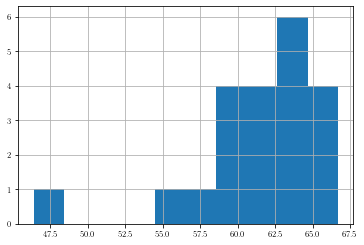

In [46]:
#distribution
historic_and_simul_emissions_df['Hist_GHGE_MtCO2e'].hist()

### Validation using MAD, RMSE and Euclidian distance

The validation uses the [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) between historic emissions and simulation results. The validation is done for the years 2000 to 2018. 
$b$ is 1.4826 and it is a constant linked to assumption of normality of the data (i.e. disregarding the abnormality of the data) [(Leys et al, 2013)
](http://dx.doi.org/10.1016/j.jesp.2013.03.013) and can be used to find the standard deviation. 

The MAD used here is an adaptation in which the statistic is used to compare historic and simulated results.
$MAD = median (|s_i - h_i|)$, where $i$ is the year of analysis, $s_i$ is the simulated emissions and $h_i$ is the historic data point at the $i_{th}$ year.

,Simulated_GHGE_VIC (MtCO2e) 0.5,Simulated_GHGE_VIC (MtCO2e) 1,Simulated_GHGE_VIC (MtCO2e) 2,Simulated_GHGE_VIC (MtCO2e) 3,Simulated_GHGE_VIC (MtCO2e) 4,Simulated_GHGE_VIC (MtCO2e) 6,Simulated_GHGE_VIC (MtCO2e) 8,Simulated_GHGE_VIC (MtCO2e) 12,Simulated_GHGE_VIC (MtCO2e) 24
mean_ae,2.527453,2.387518,2.355778,2.355175,2.354571,2.353363,2.352155,2.349740,2.342727
median_ae,2.043580,1.436027,1.704608,1.704654,1.704699,1.704788,1.704876,1.705049,1.705542
rmse,3.438929,3.369487,3.386545,3.386425,3.386320,3.386151,3.386037,3.385973,3.387105


\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  \textbf{0.5hr} &  \textbf{1hr} &  \textbf{2hr} &  \textbf{3hr} &  \textbf{4hr} &  \textbf{6hr} &  \textbf{8hr} &  \textbf{12hr} &  \textbf{24hr} \\
\midrule
mean\_ae &            2.53 &          2.39 &          2.36 &          2.36 &          2.35 &          2.35 &          2.35 &           2.35 &           2.34 \\
rmse    &            3.44 &          3.37 &          3.39 &          3.39 &          3.39 &          3.39 &          3.39 &           3.39 &           3.39 \\
\bottomrule
\end{tabular}



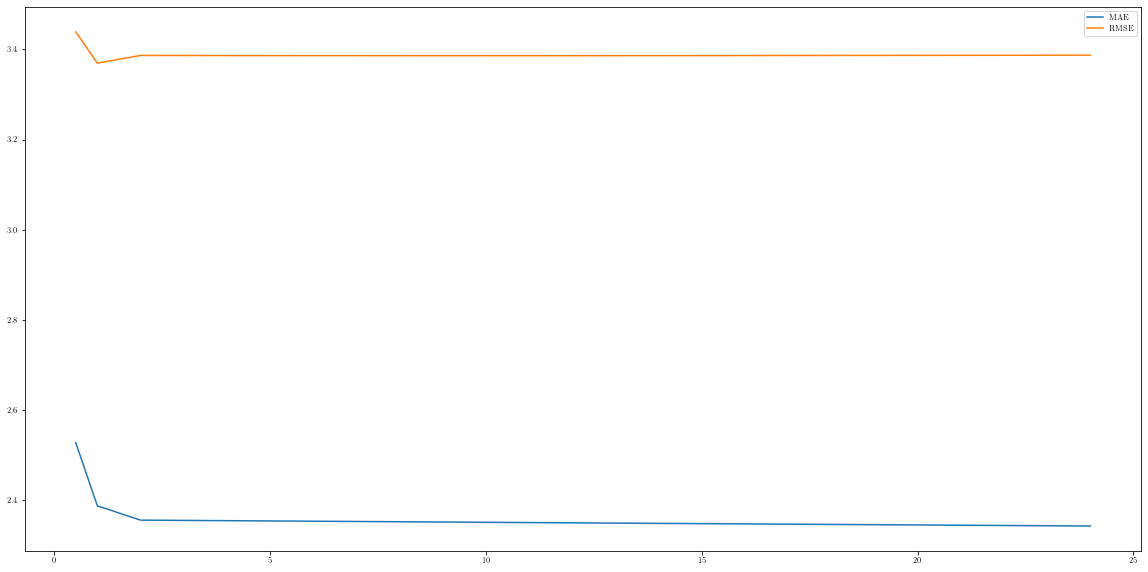

In [47]:
from sklearn.metrics import r2_score
b = 1.4826

data_df = {}
for window in historic_and_simul_emissions_df.columns:
    if 'Hist' in window:
        continue

    curr = {}

    abs_difference_list = list()
    diff_list = []
    for i in historic_and_simul_emissions_df.index:
        
        diff_list.append(historic_and_simul_emissions_df.loc[i][window] - historic_and_simul_emissions_df.loc[i]['Hist_GHGE_MtCO2e'])
        
        diff = abs(historic_and_simul_emissions_df.loc[i][window] - historic_and_simul_emissions_df.loc[i]['Hist_GHGE_MtCO2e'])
        abs_difference_list.append(diff)
        
        
        
    curr['mean_ae'] = np.mean(abs_difference_list)
    curr['median_ae'] = statistics.median(abs_difference_list)
    curr['rmse'] = (np.mean(list(map(lambda a: a**2, diff_list))))**0.5
    
        
    data_df[window] = curr
        
# mad = statistics.median(abs_difference_list)
# std = mad*b
# print(f"Simulated results are {mad.round(decimals=2)} MTCO2-e (MAD) away from historic data")
# print(f"Simulated results have a standard deviation of {std.round(decimals=2)} MTCO2-e from historic data")

data_df = pd.DataFrame(data_df)
display(data_df)
temp_df = data_df.copy()
back = "\\"
temp_df.columns = [f"{back}textbf{{{i}hr}}" for i in freq_year.keys()]
print(temp_df.loc[['mean_ae', 'rmse']].round(2).to_latex().replace("textbackslash ","").replace("\\{","{").replace("\\}","}"))
# fig, ax = plt.subplots(1,3, figsize=(30,10))
# for i,j in enumerate(data_df.index):
#     ax[i].set_title(j, fontsize=16)
#     ax[i].plot(freqs, data_df.loc[j], marker='o')

# plt.show()

fig = plt.figure(figsize=(20,10))
plt.plot(freqs, data_df.loc['mean_ae'], label = 'MAE')
plt.plot(freqs, data_df.loc['rmse'], label = 'RMSE')
plt.legend()
plt.savefig(f"results/stats_ghg")
plt.show()



In [48]:
sqr_list = list()
for i in historic_and_simul_emissions_df.index:
    sqr = np.sqrt(historic_and_simul_emissions_df.loc[i][0] - historic_and_simul_emissions_df.loc[i][1])
    #sqr_list.append(sqr)



<ipython-input-48-021b4d79cef6>:3: RuntimeWarning: invalid value encountered in sqrt
  sqr = np.sqrt(historic_and_simul_emissions_df.loc[i][0] - historic_and_simul_emissions_df.loc[i][1])


## Wholesale prices validation

1. load historic and simulated monthly wholesale prices
2. plot historic and simulated results
3. use a descriptive statistic measure to validate results from simulation against historic values

Wholesale data can be found since 2005 in a monthly basis. Therefore, the monthly summary report is used for this validation. 
Sources of data:
- https://opennem.org.au/energy/vic1/

### Load historic and simulated wholesale prices. Merge data.

In [49]:
historic_wholesale_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/2005_2020_OpenNemDataV1.csv', index_col='Time (Month)')
historic_wholesale_df.index = pd.to_datetime(historic_wholesale_df.index)

historic_wholesale_df.head(5)

,Temperature - C,Solar (Rooftop) Market Value - $,Solar (Rooftop) - GWh,Solar (Utility) Market Value - $,Solar (Utility) - GWh,Wind Market Value - $,Wind - GWh,Hydro Market Value - $,Hydro - GWh,Battery (Discharging) Market Value - $,...,Wind Market Value - $/MWh,Hydro Market Value - $/MWh,Battery (Discharging) Market Value - $/MWh,Gas (OCGT) Market Value - $/MWh,Gas (Steam) Market Value - $/MWh,Brown Coal Market Value - $/MWh,Imports Market Value - $/MWh,Exports Market Value - $/MWh,Volume Weighted Price (Historic) - $/MWh,Imports % from wholesale price
Time (Month),,,,,,,,,,,,,,,,,,,,,
2005-04-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,11848263.30,304.50,0.0,...,0.0,38.910553,0.0,44.023585,39.220646,30.605720,38.289921,-19.009200,31.809904,20%
2005-05-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,8161908.91,260.01,0.0,...,0.0,31.390750,0.0,35.260919,35.709309,24.667570,31.791585,-18.044240,25.330109,26%
2005-06-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,6597447.23,200.71,0.0,...,0.0,32.870546,0.0,50.142422,37.533559,23.616642,30.781600,-17.572286,24.249596,27%
2005-07-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,7421383.61,182.63,0.0,...,0.0,40.636169,0.0,56.781103,39.030981,26.668752,32.787615,-17.823924,27.651352,19%
2005-08-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,10855283.83,207.39,0.0,...,0.0,52.342369,0.0,98.739498,60.657385,30.161182,39.640099,-16.523324,32.022126,24%


In [50]:
# some statistics from historic wholesale prices per technology

historic_wholesale_all_techs = historic_wholesale_df.iloc[:,22:-1]
historic_wholesale_all_techs = historic_wholesale_all_techs.replace(0.0, np.NaN)

historic_wholesale_all_techs.describe(include = 'all')

,Solar (Rooftop) Market Value - $/MWh,Solar (Utility) Market Value - $/MWh,Wind Market Value - $/MWh,Hydro Market Value - $/MWh,Battery (Discharging) Market Value - $/MWh,Gas (OCGT) Market Value - $/MWh,Gas (Steam) Market Value - $/MWh,Brown Coal Market Value - $/MWh,Imports Market Value - $/MWh,Exports Market Value - $/MWh,Volume Weighted Price (Historic) - $/MWh
count,43.000000,27.000000,139.000000,183.000000,20.000000,183.000000,173.000000,183.000000,179.000000,183.000000,183.000000
mean,90.332890,92.076481,50.638187,90.944478,217.862556,108.929418,94.154000,52.472880,119.409691,-38.045397,55.933604
std,42.699474,59.916837,30.738708,104.782223,357.340630,136.090265,92.163127,31.325816,306.942885,20.533371,38.410661
min,26.776309,27.106774,15.666767,18.569393,47.142848,16.857991,21.455400,16.758639,16.278577,-100.544755,16.925035
25%,74.482850,62.689421,27.142393,40.269586,94.354779,44.430657,42.324384,30.132401,40.555487,-48.368355,30.979238
50%,84.510477,84.229018,44.482960,58.074492,120.899721,63.667700,59.025668,42.805408,59.927214,-30.531950,44.520646
75%,106.780128,94.102468,66.952232,102.697146,141.611117,114.354224,115.136459,64.435457,108.060641,-22.148248,68.841054
max,269.618267,333.592607,243.209880,869.047975,1659.823813,1005.482367,742.663722,232.179879,3804.041722,-15.418553,331.125849


In [51]:
""" Filtering whoelsale prices from historic data"""

historic_wholesale_filtered = historic_wholesale_df["Volume Weighted Price (Historic) - $/MWh"]


Load simulation results using BAU settings

In [52]:
# monthly_bau_results_df.head()

In [53]:
# Historic is only available from April 2005 until June 2020. Simulated data for those dates are used for validation.

""" Filtering Whoelsale prices from simulation BAU """
temp = []
for i,j in freq_month.items():
    simul_data_wholesale_filtered = pd.Series(j['Primary Wholesale ($/MWh)'],name=f'Primary Wholesale ($/MWh) {i}')
    simul_data_wholesale_filtered.index = pd.to_datetime(simul_data_wholesale_filtered.index)
#     print(type(simul_data_wholesale_filtered))
#     simul_data_wholesale_filtered.rename('Primary Wholesale ($/MWh)',)
    temp.append(simul_data_wholesale_filtered)
#     print(simul_data_wholesale_filtered)
#     break

simul_data_wholesale_filtered = pd.concat(temp, axis=1)

In [54]:

from functools import reduce

historic_wholesale_list = [historic_wholesale_filtered, simul_data_wholesale_filtered]
historic_wholesale_list

historic_and_simul_wholesale_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time (Month)'), historic_wholesale_list)
historic_and_simul_wholesale_df.head(200)

,Volume Weighted Price (Historic) - $/MWh,Primary Wholesale ($/MWh) 0.5,Primary Wholesale ($/MWh) 1,Primary Wholesale ($/MWh) 2,Primary Wholesale ($/MWh) 3,Primary Wholesale ($/MWh) 4,Primary Wholesale ($/MWh) 6,Primary Wholesale ($/MWh) 8,Primary Wholesale ($/MWh) 12,Primary Wholesale ($/MWh) 24
Time (Month),,,,,,,,,,
2005-04-01,31.809904,50.977581,18.710920,18.759176,18.730310,18.701441,18.643726,18.586985,18.470463,18.140015
2005-05-01,25.330109,73.295975,118.575653,118.434364,118.274971,118.116058,117.799362,117.484558,116.858826,115.023827
2005-06-01,24.249596,75.995628,137.393616,137.230728,137.039703,136.849182,136.469604,136.092407,135.342545,133.146103
2005-07-01,27.651352,65.889755,118.292732,118.159088,117.999710,117.840729,117.523994,117.209167,116.582993,114.748039
2005-08-01,32.022126,65.438713,118.152000,118.022903,117.864555,117.709351,117.400925,117.099922,116.483803,114.677063
...,...,...,...,...,...,...,...,...,...,...
2020-02-01,49.201480,77.534218,145.588394,145.101227,144.162521,143.199875,141.147003,139.342590,135.078873,120.806664
2020-03-01,43.196436,43.630615,50.817486,51.851276,52.072266,52.316380,52.673241,53.369530,56.003906,70.667320
2020-04-01,34.966287,23.186827,14.237802,14.300132,14.264408,14.228977,14.158990,14.090156,13.955912,15.066001


### Plot historic and simulated wholesale prices

In [55]:
plt.figure(figsize=(18,10))

#plt.plot( 'Volume Weighted Price (Historic) - $/MWh', data=historic_and_simul_wholesale_df, marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4)
#plt.plot( 'Wholesale ($/MWh)', data=historic_and_simul_wholesale_df, marker='o', markerfacecolor='steelblue', markersize=8, color='lightblue', linewidth=4)

for i,j in freq_month.items():
    if i != 0.5:
        plt.plot( f'Primary Wholesale ($/MWh) {i}', data=historic_and_simul_wholesale_df.rolling(window=1).mean(), 
             linewidth=4, label=f'Wholesale Primary Spot Market - Simulated (STLM+CSI+MS) Hour {i}', alpha = 0.4)
    else:
        plt.plot( f'Primary Wholesale ($/MWh) {i}', data=historic_and_simul_wholesale_df, 
             linewidth=4, label=f'Wholesale Primary Spot Market - Simulated (STLM+CSI+MS) Hour {i}')


plt.plot( 'Volume Weighted Price (Historic) - $/MWh', data=historic_and_simul_wholesale_df, color='black', linewidth=4, label='Wholesale Primary Spot Market - Historic')

plt.xlabel('Months', size = 16)
plt.ylabel('$/MWh', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})
plt.savefig(f"results/{description}_wholesale_month")
# filenames.append(f"results/{description}_wholesale_month")

RuntimeError: latex was not able to process the following string:
b'$/MWh'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/XXX/.cache/matplotlib/tex.cache/7796658cfd2a25746642aa994dd3ffe3.te
x
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7796658cfd2a25746642aa994dd3ffe3.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.19 {\rmfamily $/MWh}
                      
No pages of output.
Transcript written on 7796658cfd2a25746642aa994dd3ffe3.log.




RuntimeError: latex was not able to process the following string:
b'$/MWh'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/XXX/.cache/matplotlib/tex.cache/7796658cfd2a25746642aa994dd3ffe3.te
x
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7796658cfd2a25746642aa994dd3ffe3.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.19 {\rmfamily $/MWh}
                      
No pages of output.
Transcript written on 7796658cfd2a25746642aa994dd3ffe3.log.




<Figure size 1296x720 with 1 Axes>

In [ ]:
#distribution

historic_and_simul_wholesale_df['Volume Weighted Price (Historic) - $/MWh'].hist()

### Validation using MAD

In [56]:
historic_and_simul_wholesale_df

,Volume Weighted Price (Historic) - $/MWh,Primary Wholesale ($/MWh) 0.5,Primary Wholesale ($/MWh) 1,Primary Wholesale ($/MWh) 2,Primary Wholesale ($/MWh) 3,Primary Wholesale ($/MWh) 4,Primary Wholesale ($/MWh) 6,Primary Wholesale ($/MWh) 8,Primary Wholesale ($/MWh) 12,Primary Wholesale ($/MWh) 24
Time (Month),,,,,,,,,,
2005-04-01,31.809904,50.977581,18.710920,18.759176,18.730310,18.701441,18.643726,18.586985,18.470463,18.140015
2005-05-01,25.330109,73.295975,118.575653,118.434364,118.274971,118.116058,117.799362,117.484558,116.858826,115.023827
2005-06-01,24.249596,75.995628,137.393616,137.230728,137.039703,136.849182,136.469604,136.092407,135.342545,133.146103
2005-07-01,27.651352,65.889755,118.292732,118.159088,117.999710,117.840729,117.523994,117.209167,116.582993,114.748039
2005-08-01,32.022126,65.438713,118.152000,118.022903,117.864555,117.709351,117.400925,117.099922,116.483803,114.677063
...,...,...,...,...,...,...,...,...,...,...
2020-02-01,49.201480,77.534218,145.588394,145.101227,144.162521,143.199875,141.147003,139.342590,135.078873,120.806664
2020-03-01,43.196436,43.630615,50.817486,51.851276,52.072266,52.316380,52.673241,53.369530,56.003906,70.667320
2020-04-01,34.966287,23.186827,14.237802,14.300132,14.264408,14.228977,14.158990,14.090156,13.955912,15.066001


In [57]:
from sklearn.metrics import r2_score


data_df = {}
for window in historic_and_simul_wholesale_df.columns:
    if 'Historic' in window:
        continue

    curr = {}

    abs_difference_list = list()
    diff_list = []
    for i in historic_and_simul_wholesale_df.index:
        
        diff_list.append(historic_and_simul_wholesale_df.loc[i][window] - historic_and_simul_wholesale_df.loc[i]['Volume Weighted Price (Historic) - $/MWh'])
        
        diff = abs(historic_and_simul_wholesale_df.loc[i][window] - historic_and_simul_wholesale_df.loc[i]['Volume Weighted Price (Historic) - $/MWh'])
        abs_difference_list.append(diff)
        
        
        
    curr['mean_ae'] = np.mean(abs_difference_list)
    curr['median_ae'] = statistics.median(abs_difference_list)
    curr['rmse'] = (np.mean(list(map(lambda a: a**2, diff_list))))**0.5
    
        
    data_df[window] = curr
        
# mad = statistics.median(abs_difference_list)
# std = mad*b
# print(f"Simulated results are {mad.round(decimals=2)} MTCO2-e (MAD) away from historic data")
# print(f"Simulated results have a standard deviation of {std.round(decimals=2)} MTCO2-e from historic data")

data_df = pd.DataFrame(data_df)
display(data_df)

,Primary Wholesale ($/MWh) 0.5,Primary Wholesale ($/MWh) 1,Primary Wholesale ($/MWh) 2,Primary Wholesale ($/MWh) 3,Primary Wholesale ($/MWh) 4,Primary Wholesale ($/MWh) 6,Primary Wholesale ($/MWh) 8,Primary Wholesale ($/MWh) 12,Primary Wholesale ($/MWh) 24
mean_ae,24.886611,32.510018,33.395756,33.351593,33.307953,33.291206,33.287062,33.253968,34.535741
median_ae,16.077361,25.888328,25.778753,25.774716,25.976719,26.152666,25.999526,26.681132,28.472425
rmse,35.196476,41.961054,42.898887,42.830934,42.770112,42.674619,42.619151,42.646089,44.092359


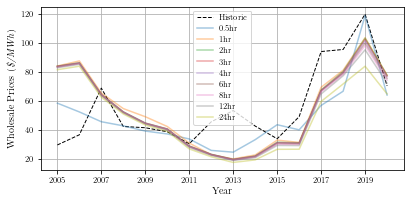

In [58]:
annual = historic_and_simul_wholesale_df.resample("AS").agg(['mean'])#, 'min', 'max'

# plt.figure(figsize=(6.5,3))
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))

#plt.plot( 'Volume Weighted Price (Historic) - $/MWh', data=annual, marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4)
#plt.plot( 'Wholesale ($/MWh)', data=annual, marker='o', markerfacecolor='steelblue', markersize=8, color='lightblue', linewidth=4)

ax.plot([i.year for i in annual.index], annual['Volume Weighted Price (Historic) - $/MWh'],color='black', linewidth=1, linestyle = '--', label='Historic')
for i in freq_year.keys():
#     if i != 0.5:
    ax.plot( [i.year for i in annual.index], annual[f'Primary Wholesale ($/MWh) {i}'], label = f'{i}hr', alpha=0.4)
#     else:
#         plt.plot( f'Primary Wholesale ($/MWh) {i}', data=annual, linewidth=4,
#              label=f'Wholesale Primary Spot Market - Simulated (STLM+CSI+MS) Hour {i}', marker = 'o')




ax.set_xlabel('Year')
ax.set_ylabel(r'Wholesale Prices (\textit{\$/MWh})')

ax.set_xticks([i.year for i in annual.index][::2])
# ax.yticks(size = 12)
ax.legend()
plt.grid()
plt.savefig(f"results/{description}_wholesale_year.pdf", facecolor='white', transparent=False,  bbox_inches='tight', dpi=600)
# filenames.append(f"results/{description}_wholesale_year")

In [59]:
whole_latex_df = annual.copy()
# whole_latex_df['Time (Month)'] = [i.year for i in whole_latex_df['Time (Month)']]
# whole_latex_df
print(whole_latex_df.round(2).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & Volume Weighted Price (Historic) - \$/MWh & Primary Wholesale (\$/MWh) 0.5 & Primary Wholesale (\$/MWh) 1 & Primary Wholesale (\$/MWh) 2 & Primary Wholesale (\$/MWh) 3 & Primary Wholesale (\$/MWh) 4 & Primary Wholesale (\$/MWh) 6 & Primary Wholesale (\$/MWh) 8 & Primary Wholesale (\$/MWh) 12 & Primary Wholesale (\$/MWh) 24 \\
{} &                                     mean &                          mean &                        mean &                        mean &                        mean &                        mean &                        mean &                        mean &                         mean &                         mean \\
Time (Month) &                                          &                               &                             &                             &                             &                             &                             &                             &                              &      

array([[<AxesSubplot:title={'center':'mean'}>]], dtype=object)

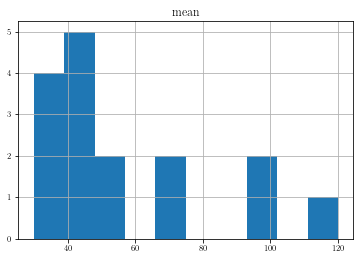

In [60]:
annual['Volume Weighted Price (Historic) - $/MWh'].hist()

,Primary Wholesale ($/MWh) 0.5,Primary Wholesale ($/MWh) 1,Primary Wholesale ($/MWh) 2,Primary Wholesale ($/MWh) 3,Primary Wholesale ($/MWh) 4,Primary Wholesale ($/MWh) 6,Primary Wholesale ($/MWh) 8,Primary Wholesale ($/MWh) 12,Primary Wholesale ($/MWh) 24
,mean,mean,mean,mean,mean,mean,mean,mean,mean
mean_ae,14.072166,18.133346,17.995275,18.094189,18.197043,18.299028,18.483015,18.789497,20.773938
median_ae,9.536311,15.269217,15.864498,16.553414,17.258857,17.634965,18.213006,19.057921,22.898150
rmse,18.312817,24.068645,23.998707,24.064597,24.138109,24.209586,24.367824,24.671355,26.332890


\begin{tabular}{lrrrrrrrrr}
\hline
{} &  \textbf{0.5hr} &  \textbf{1hr} &  \textbf{2hr} &  \textbf{3hr} &  \textbf{4hr} &  \textbf{6hr} &  \textbf{8hr} &  \textbf{12hr} &  \textbf{24hr} \\
\hline
\textbf{MAE}  &           14.07 &         18.13 &          18.0 &         18.09 &         18.20 &         18.30 &         18.48 &          18.79 &          20.77 \\
\textbf{RMSE} &           18.31 &         24.07 &          24.0 &         24.06 &         24.14 &         24.21 &         24.37 &          24.67 &          26.33 \\
\hline
\end{tabular}



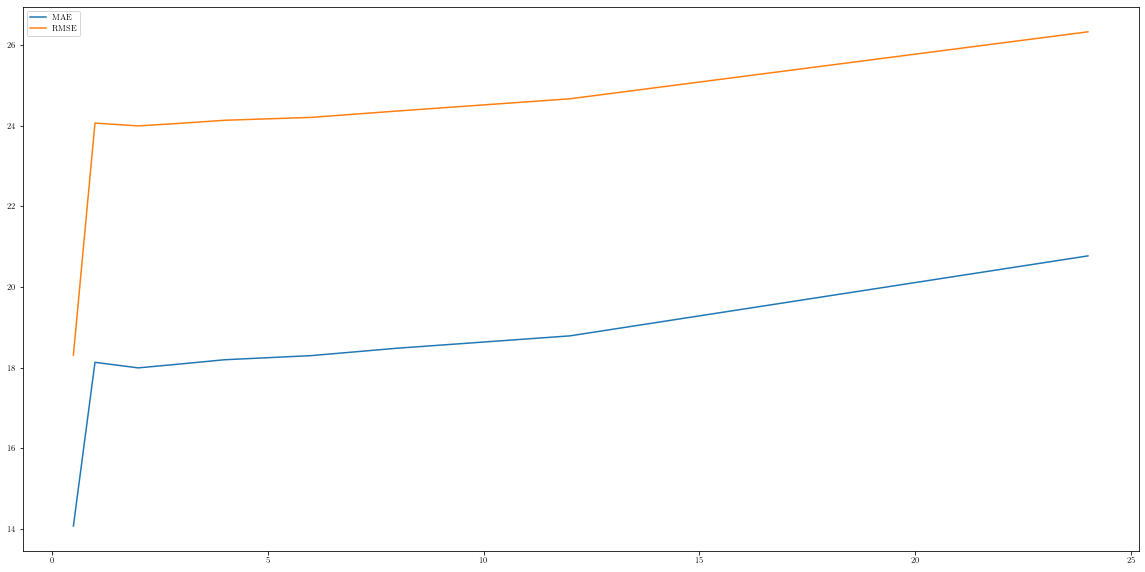

In [61]:
from sklearn.metrics import r2_score


data_df = {}
for window in annual.columns:
    if 'Historic' in window[0]:
        continue

    curr = {}

    abs_difference_list = list()
    diff_list = []
    for i in annual.index:
        
        diff_list.append(annual.loc[i][window] - annual.loc[i]['Volume Weighted Price (Historic) - $/MWh']['mean'])
        
        diff = abs(annual.loc[i][window] - annual.loc[i]['Volume Weighted Price (Historic) - $/MWh']['mean'])
        abs_difference_list.append(diff)
        
        
        
    curr['mean_ae'] = np.mean(abs_difference_list)
    curr['median_ae'] = statistics.median(abs_difference_list)
    curr['rmse'] = (np.mean(list(map(lambda a: a**2, diff_list))))**0.5
    
        
    data_df[window] = curr
        
# mad = statistics.median(abs_difference_list)
# std = mad*b
# print(f"Simulated results are {mad.round(decimals=2)} MTCO2-e (MAD) away from historic data")
# print(f"Simulated results have a standard deviation of {std.round(decimals=2)} MTCO2-e from historic data")

data_df = pd.DataFrame(data_df)
display(data_df)
temp_df = data_df.copy()
back = "\\"
temp_df.columns = [f"{back}textbf{{{i}hr}}" for i in freq_year.keys()]
temp_df.index = [f"{back}textbf{{MAE}}", '_', f"{back}textbf{{RMSE}}"]
print(temp_df.loc[[f"{back}textbf{{MAE}}", f"{back}textbf{{RMSE}}"]].round(2).to_latex().replace("textbackslash ","").replace("\\{","{").replace("\\}","}").replace("toprule", 'hline').replace('midrule','hline').replace('bottomrule','hline'))

# fig, ax = plt.subplots(1,3, figsize=(30,10))
# for i,j in enumerate(data_df.index):
#     ax[i].set_title(j, fontsize=16)
#     ax[i].plot(freqs, data_df.loc[j], marker='o')
# plt.savefig(f"results/stats_wholesale")
# plt.show()

# fig = plt.figure(figsize=(20,10))
# plt.plot(freqs, data_df.loc['mean_ae'], label = 'MAE')
# plt.plot(freqs, data_df.loc['rmse'], label = 'RMSE')
# plt.legend()
# plt.show()

fig = plt.figure(figsize=(20,10))
plt.plot(freqs, data_df.loc['mean_ae'], label = 'MAE')
plt.plot(freqs, data_df.loc['rmse'], label = 'RMSE')
plt.legend()
plt.savefig(f"results/stats_wholesale")
plt.show()



In [62]:
# b = 1.4826

# abs_difference_list = list()
# for i in annual.index:
#     diff = abs(annual.loc[i][0] - annual.loc[i][1])
#     abs_difference_list.append(diff)

# mad = statistics.median(abs_difference_list)
# std = mad*b
# print(f"Annual Simulated results are {mad.round(decimals=2)} $/MWh (MAD) away from historic data")
# print(f"Annual Simulated results have a standard deviation of {std.round(decimals=2)} $/MWh from historic data")

In [63]:
import IPython

In [64]:
plt.figure(figsize=(18,10))

for i in freq_year.keys():
    if i != 0.5:
        plt.plot(historic_and_simul_wholesale_df[f'Primary Wholesale ($/MWh) {i}'].rolling(12).mean(),
             label= f'Simulated MA 12 month Hour {i}',linewidth=4, alpha=0.4 )
    else:
        plt.plot(historic_and_simul_wholesale_df[f'Primary Wholesale ($/MWh) {i}'].rolling(12).mean(),
             label= f'Simulated MA 12 month Hour {i}',linewidth=4)

plt.plot(historic_and_simul_wholesale_df['Volume Weighted Price (Historic) - $/MWh'].rolling(12).mean(),label= 'Historic MA and12 month',color='black', linewidth=4 )


plt.xlabel('Year', size = 16)
plt.ylabel('$/MWh', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})
plt.savefig(f"results/{description}_wholesale_month_mean")
filenames.append(f"results/{description}_wholesale_month_mean")
plt.show()

RuntimeError: latex was not able to process the following string:
b'$/MWh'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/XXX/.cache/matplotlib/tex.cache/7796658cfd2a25746642aa994dd3ffe3.te
x
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7796658cfd2a25746642aa994dd3ffe3.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.19 {\rmfamily $/MWh}
                      
No pages of output.
Transcript written on 7796658cfd2a25746642aa994dd3ffe3.log.




RuntimeError: latex was not able to process the following string:
b'$/MWh'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/XXX/.cache/matplotlib/tex.cache/7796658cfd2a25746642aa994dd3ffe3.te
x
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7796658cfd2a25746642aa994dd3ffe3.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.19 {\rmfamily $/MWh}
                      
No pages of output.
Transcript written on 7796658cfd2a25746642aa994dd3ffe3.log.




<Figure size 1296x720 with 1 Axes>

## Tariffs Validation

1. load historic and simulated yearly average tariffs
2. plot historic and simulated results
3. use a descriptive statistic measure to validate results from simulation against historic values

Different sources where used to construct a historic dataset of average electricity tariffs.
- Historic data found in the [ACCC report](https://www.accc.gov.au/system/files/Victorian%20Electricity%20Distribution%20Networks.pdf) from 2017. This data is from a household in VIC that use 4000 KWh/year, has gas water heating. The report has data for the years 1995, 2001, 2002, and from 2007 to 2017. But data is used from 2001. Since the data is given as total bill per year in /$, the price per KWh is computed as (AnnualBill/4000KWh)*100, to get the value in c/kWh.
- [St. Vinnies historic data](https://www.vinnies.org.au/page/Our_Impact/Incomes_Support_Cost_of_Living/Energy/VIC/) on tariffs per retailer and distribution area. This data has been collected since 2010, every quarter of the year. I used the ‘first block’ charges to calculate the average charge of usage in c/KWh. 

Prices from the reports and data sources are adjusted to 2019 values as simulatied tariffs are presented in real terms for the base year of 2019.


### Load and merge historic and simulated tariff data

In [65]:
# historic average tariffs in c/kWh (real 2019) filtered from reports
yearly_historic_tariffs = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/2001to2019_historicTariffs.csv', index_col='Time (Year)')

In [66]:
# Historic is only available from April 2005 until June 2020. Simulated data for those dates are used for validation.

""" Filtering Avg Tariff (c/KWh) per household prices from simulation BAU """

yearly_bau_results_tariffs_dfs = []
for i,j in freq_year.items():
    
    yearly_bau_results_tariffs_df = pd.Series(j['Avg Tariff (c/KWh) per household'], name = f'Avg Tariff (c/KWh) per household {i}')
    yearly_bau_results_tariffs_df.index = j.index

#     yearly_bau_results_tariffs_df=yearly_bau_results_tariffs_df.rename(columns = {0:f'Avg Tariff (c/KWh) per household {i}'})[:]
    yearly_bau_results_tariffs_dfs.append(yearly_bau_results_tariffs_df)

yearly_bau_results_tariffs_df = pd.concat(yearly_bau_results_tariffs_dfs, axis=1)

In [67]:
from functools import reduce

historic_and_simul_tariff_list = [yearly_bau_results_tariffs_df, yearly_historic_tariffs]
historic_and_simul_tariff_list

historic_and_simul_tariff_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time (Year)'), historic_and_simul_tariff_list)
historic_and_simul_tariff_df.head(20)

,Avg Tariff (c/KWh) per household 0.5,Avg Tariff (c/KWh) per household 1,Avg Tariff (c/KWh) per household 2,Avg Tariff (c/KWh) per household 3,Avg Tariff (c/KWh) per household 4,Avg Tariff (c/KWh) per household 6,Avg Tariff (c/KWh) per household 8,Avg Tariff (c/KWh) per household 12,Avg Tariff (c/KWh) per household 24,St Vinnies Historic c/kWh (2019),Historic price from review c/KWh (2019)
Time (Year),,,,,,,,,,,
2001,15.696864,7.709512,7.495827,7.482491,7.469122,7.442290,7.416241,7.360857,7.208783,NaN,27.32
2002,10.385764,6.865709,6.887255,6.875990,6.864703,6.842088,6.820008,6.773868,6.645045,NaN,27.03
2003,18.992432,11.487898,11.505105,11.487349,11.469564,11.434015,11.399117,11.327127,11.123708,NaN,NaN
2004,20.724766,14.849630,14.707513,14.686234,14.664984,14.622500,14.580612,14.495480,14.251168,NaN,NaN
2005,20.238794,18.439602,18.445709,18.419525,18.393373,18.341190,18.289583,18.185444,17.884594,NaN,NaN
2006,24.918377,36.747490,36.697765,36.647675,36.598328,36.499859,36.403221,36.207306,35.634228,NaN,NaN
2007,14.390024,22.096203,22.004597,21.977421,21.950392,21.894590,21.839426,21.732815,21.420502,NaN,23.38
2008,11.578712,14.445100,14.449304,14.430622,14.411960,14.374201,14.336743,14.263160,14.048225,NaN,25.55
2009,21.221987,27.672880,26.783995,26.749001,26.714090,26.643568,26.573587,26.436083,26.033646,NaN,27.74


### Plot historic and simulated residential tariffs

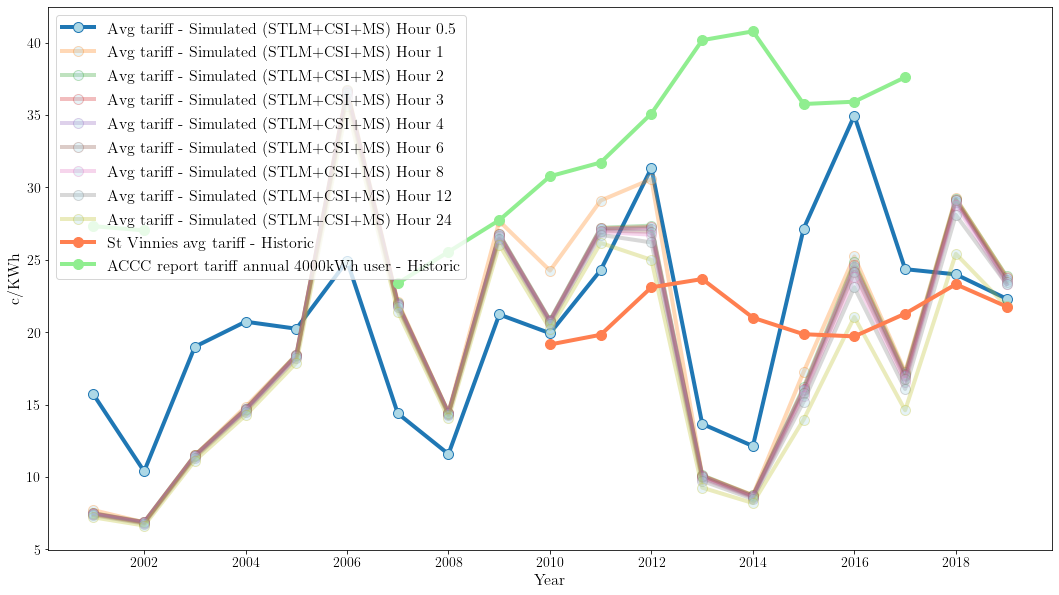

In [68]:
plt.figure(figsize=(18,10))
data=historic_and_simul_tariff_df
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_tariff_df.index]
#plt.plot( 'Volume Weighted Price (Historic) - $/MWh', data=annual, marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4)

for i in freq_year.keys():
    if i != 0.5:
        plt.plot( yearly_dates, data[f'Avg Tariff (c/KWh) per household {i}'], marker='o', markerfacecolor='lightblue', markersize=10,
             linewidth=4, label=f'Avg tariff - Simulated (STLM+CSI+MS) Hour {i}', alpha=0.3)
    else:
            plt.plot( yearly_dates, data[f'Avg Tariff (c/KWh) per household {i}'], marker='o', markerfacecolor='lightblue', markersize=10,
             linewidth=4, label=f'Avg tariff - Simulated (STLM+CSI+MS) Hour {i}')

plt.plot( yearly_dates, data['St Vinnies Historic c/kWh (2019) '], marker='o', markerfacecolor='coral', markersize=10, color='coral', linewidth=4, label='St Vinnies avg tariff - Historic')
plt.plot( yearly_dates, data['Historic price from review c/KWh (2019)'],marker='o', markerfacecolor='lightgreen', markersize=10, color='lightgreen', linewidth=4, label='ACCC report tariff annual 4000kWh user - Historic')

plt.xlabel('Year', size = 16)
plt.ylabel('c/KWh', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})
plt.savefig(f"results/{description}_tariff")
filenames.append(f"results/{description}_tariff")

In [69]:
average_historic = yearly_historic_tariffs.mean(axis=1)
average_historic_df = pd.DataFrame({'Average historic tariff (c/KWh)':average_historic})


In [70]:
historic_and_simul_tariff_list = [yearly_bau_results_tariffs_df, average_historic_df]
historic_and_simul_tariff_list

# average_historic_and_simul_tariff_df = pd.concat(historic_and_simul_tariff_list, axis=1)
average_historic_and_simul_tariff_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time (Year)'), historic_and_simul_tariff_list)
average_historic_and_simul_tariff_df.head(20)

,Avg Tariff (c/KWh) per household 0.5,Avg Tariff (c/KWh) per household 1,Avg Tariff (c/KWh) per household 2,Avg Tariff (c/KWh) per household 3,Avg Tariff (c/KWh) per household 4,Avg Tariff (c/KWh) per household 6,Avg Tariff (c/KWh) per household 8,Avg Tariff (c/KWh) per household 12,Avg Tariff (c/KWh) per household 24,Average historic tariff (c/KWh)
Time (Year),,,,,,,,,,
2001,15.696864,7.709512,7.495827,7.482491,7.469122,7.442290,7.416241,7.360857,7.208783,27.320
2002,10.385764,6.865709,6.887255,6.875990,6.864703,6.842088,6.820008,6.773868,6.645045,27.030
2003,18.992432,11.487898,11.505105,11.487349,11.469564,11.434015,11.399117,11.327127,11.123708,NaN
2004,20.724766,14.849630,14.707513,14.686234,14.664984,14.622500,14.580612,14.495480,14.251168,NaN
2005,20.238794,18.439602,18.445709,18.419525,18.393373,18.341190,18.289583,18.185444,17.884594,NaN
2006,24.918377,36.747490,36.697765,36.647675,36.598328,36.499859,36.403221,36.207306,35.634228,NaN
2007,14.390024,22.096203,22.004597,21.977421,21.950392,21.894590,21.839426,21.732815,21.420502,23.380
2008,11.578712,14.445100,14.449304,14.430622,14.411960,14.374201,14.336743,14.263160,14.048225,25.550
2009,21.221987,27.672880,26.783995,26.749001,26.714090,26.643568,26.573587,26.436083,26.033646,27.740


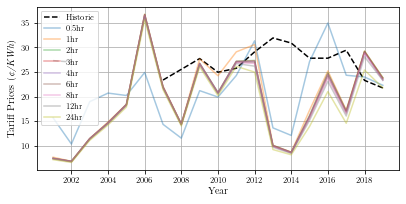

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))

yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_tariff_df.index]
data=average_historic_and_simul_tariff_df

ax.plot( yearly_dates, data['Average historic tariff (c/KWh)'], linestyle='--', color='black', label='Historic')

for i in freq_year.keys():
#     if i != 0.5:
    ax.plot( yearly_dates, data[f'Avg Tariff (c/KWh) per household {i}'], alpha = 0.4, label=f"{i}hr")
#     else:
#         plt.plot( yearly_dates, data[f'Avg Tariff (c/KWh) per household {i}'], marker='o', markerfacecolor='lightblue',
#              markersize=10, linewidth=4, label=f'Avg tariff - Simulated (STLM+CSI+MS) Hour {i}')




ax.set_xlabel('Year')
ax.set_ylabel(r'Tariff Prices (\textit{\textcent/KWh})')
# plt.xticks(size = 12)
# plt.yticks(size = 12)
ax.legend()
plt.grid()
plt.savefig(f"results/{description}_tariff_2.pdf", facecolor='white', transparent=False,  bbox_inches='tight', dpi=600)


# filenames.append(f"results/{description}_tariff_2")

In [72]:
print(data[['Avg Tariff (c/KWh) per household 0.5',
       'Avg Tariff (c/KWh) per household 1',
       'Avg Tariff (c/KWh) per household 2',
       'Avg Tariff (c/KWh) per household 3',
       'Avg Tariff (c/KWh) per household 4',
       'Avg Tariff (c/KWh) per household 6',
       'Avg Tariff (c/KWh) per household 8',
       'Avg Tariff (c/KWh) per household 12',
       'Avg Tariff (c/KWh) per household 24',
       'Average historic tariff (c/KWh)']].round(2).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  Avg Tariff (c/KWh) per household 0.5 &  Avg Tariff (c/KWh) per household 1 &  Avg Tariff (c/KWh) per household 2 &  Avg Tariff (c/KWh) per household 3 &  Avg Tariff (c/KWh) per household 4 &  Avg Tariff (c/KWh) per household 6 &  Avg Tariff (c/KWh) per household 8 &  Avg Tariff (c/KWh) per household 12 &  Avg Tariff (c/KWh) per household 24 &  Average historic tariff (c/KWh) \\
Time (Year) &                                       &                                     &                                     &                                     &                                     &                                     &                                     &                                      &                                      &                                  \\
\midrule
2001        &                                 15.70 &                                7.71 &                                7.50 &                                7.48 &   

<AxesSubplot:>

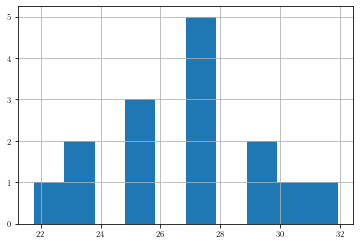

In [73]:
average_historic_and_simul_tariff_df['Average historic tariff (c/KWh)'].hist()

### Validation using MAD

In [74]:
from sklearn.metrics import r2_score


data_df = {}
for window in average_historic_and_simul_tariff_df.columns:
    if 'historic' in window:
        continue

    curr = {}

    abs_difference_list = list()
    diff_list = []
    for i in average_historic_and_simul_tariff_df.index:
        
        if np.isnan(average_historic_and_simul_tariff_df.loc[i]['Average historic tariff (c/KWh)']):
            continue

        diff_list.append(average_historic_and_simul_tariff_df.loc[i][window] - average_historic_and_simul_tariff_df.loc[i]['Average historic tariff (c/KWh)'])
        
        diff = abs(average_historic_and_simul_tariff_df.loc[i][window] - average_historic_and_simul_tariff_df.loc[i]['Average historic tariff (c/KWh)'])
        abs_difference_list.append(diff)
        
        
    
    curr['mean_ae'] = np.mean(abs_difference_list)
    curr['median_ae'] = statistics.median(abs_difference_list)
    curr['rmse'] = (np.mean(list(map(lambda a: a**2, diff_list))))**0.5
    
        
    data_df[window] = curr
        
# mad = statistics.median(abs_difference_list)
# std = mad*b
# print(f"Simulated results are {mad.round(decimals=2)} MTCO2-e (MAD) away from historic data")
# print(f"Simulated results have a standard deviation of {std.round(decimals=2)} MTCO2-e from historic data")

data_df = pd.DataFrame(data_df)
display(data_df)
temp_df = data_df.copy()
back = "\\"
temp_df.columns = [f"{back}textbf{{{i}hr}}" for i in freq_year.keys()]
temp_df.index = [f"{back}textbf{{MAE}}", '_', f"{back}textbf{{RMSE}}"]
print(temp_df.loc[[f"{back}textbf{{MAE}}", f"{back}textbf{{RMSE}}"]].round(2).to_latex().replace("textbackslash ","").replace("\\{","{").replace("\\}","}").replace("toprule", 'hline').replace('midrule','hline').replace('bottomrule','hline'))


fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,j in enumerate(data_df.index):
    ax[i].set_title(j, fontsize=16)
    ax[i].plot(freqs, data_df.loc[j], marker='o')
plt.savefig(f"results/stats_tariff")
plt.show()


# fig = plt.figure(figsize=(20,10))
# plt.plot(freqs, data_df.loc['mean_ae'], label = 'MAE')
# plt.plot(freqs, data_df.loc['rmse'], label = 'RMSE')
# plt.legend()
# plt.show()


fig = plt.figure(figsize=(20,10))
plt.plot(freqs, data_df.loc['mean_ae'], label = 'MAE')
plt.plot(freqs, data_df.loc['rmse'], label = 'RMSE')
plt.legend()
plt.savefig(f"results/stats_tariff")
plt.show()

,Avg Tariff (c/KWh) per household 0.5,Avg Tariff (c/KWh) per household 1,Avg Tariff (c/KWh) per household 2,Avg Tariff (c/KWh) per household 3,Avg Tariff (c/KWh) per household 4,Avg Tariff (c/KWh) per household 6,Avg Tariff (c/KWh) per household 8,Avg Tariff (c/KWh) per household 12,Avg Tariff (c/KWh) per household 24
mean_ae,7.842190,9.004328,9.306582,9.331413,9.355529,9.443256,9.491219,9.624224,9.856008
median_ae,6.518013,5.958860,5.916326,5.803638,5.663677,5.826677,5.476915,4.792627,6.769296
rmse,10.087723,12.119156,12.242841,12.266135,12.289660,12.353788,12.402607,12.514957,12.881858


\begin{tabular}{lrrrrrrrrr}
\hline
{} &  \textbf{0.5hr} &  \textbf{1hr} &  \textbf{2hr} &  \textbf{3hr} &  \textbf{4hr} &  \textbf{6hr} &  \textbf{8hr} &  \textbf{12hr} &  \textbf{24hr} \\
\hline
\textbf{MAE}  &            7.84 &          9.00 &          9.31 &          9.33 &          9.36 &          9.44 &          9.49 &           9.62 &           9.86 \\
\textbf{RMSE} &           10.09 &         12.12 &         12.24 &         12.27 &         12.29 &         12.35 &         12.40 &          12.51 &          12.88 \\
\hline
\end{tabular}



RuntimeError: latex was not able to process the following string:
b'mean_ae'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/XXX/.cache/matplotlib/tex.cache/577b1b50e88567263d3812db58c2aa36.te
x
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 577b1b50e88567263d3812db58c2aa36.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily mean_
                     ae}
No pages of output.
Transcript written on 577b1b50e88567263d3812db58c2aa36.log.




RuntimeError: latex was not able to process the following string:
b'mean_ae'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/XXX/.cache/matplotlib/tex.cache/577b1b50e88567263d3812db58c2aa36.te
x
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 577b1b50e88567263d3812db58c2aa36.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily mean_
                     ae}
No pages of output.
Transcript written on 577b1b50e88567263d3812db58c2aa36.log.




<Figure size 2160x720 with 3 Axes>

In [75]:
b = 1.4826

abs_difference_list = {}
for j in freq_year.keys():
    temp = []
    for i in average_historic_and_simul_tariff_df[f'Avg Tariff (c/KWh) per household {j}'].index:
        diff = abs(average_historic_and_simul_tariff_df[f'Average historic tariff (c/KWh)'][i] - 
                   average_historic_and_simul_tariff_df[f'Avg Tariff (c/KWh) per household {j}'][i])
        temp.append(diff)
    abs_difference_list[j] = temp

# mad = statistics.median(abs_difference_list)
# std = mad*b
# print(f"Simulated results are {mad.round(decimals=2)} c/KWh (MAD) away from historic data")
# print(f"Simulated results have a standard deviation of {std.round(decimals=2)} c/KWh from historic data")

### Validation with Percentage difference

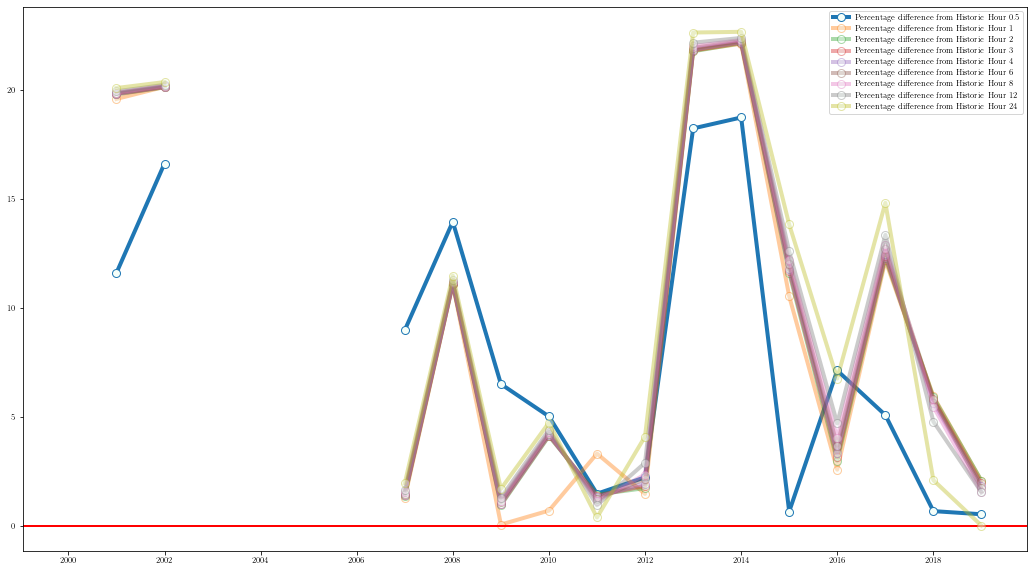

In [76]:
plt.figure(figsize=(18,10))
#xfmt = mdates.DateFormatter('%Y-%m-%d')
#axes.xaxis.set_major_formatter(xfmt)
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_tariff_df.index]

for i in freq_year:
    plt.axhline(y=0.0, color='r', linestyle='-')
    if i != 0.5:
        plt.plot( yearly_dates, abs_difference_list[i], marker='o', 
                 markerfacecolor='mintcream', markersize=8, 
                 linewidth=4, label=f'Percentage difference from Historic Hour {i}', alpha=0.4)
    else:
        plt.plot( yearly_dates, abs_difference_list[i], marker='o', 
             markerfacecolor='mintcream', markersize=8, 
             linewidth=4, label=f'Percentage difference from Historic Hour {i}')

plt.legend()
plt.savefig(f"results/{description}_tariff_pct")
filenames.append(f"results/{description}_tariff_pct")

### Group in file

In [74]:
filenames = ' '.join(list(map(lambda a: a + ".png", filenames)))
os.system(f"montage -mode concatenate -tile 3x3 {filenames} collatedResults/{description}.png")
os.system(f'notify-send "Completed {description}"')

0

# Verification and Validation First Phase: Emerging Regime

The first phase of the electricity for the verification and validation uses the years 1902 to 1919.

In [ ]:
#Number of housheolds using ABS and other census data. Interpolation was used between years without available data.
number_of_households_abs = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/numberOfHouseholdsABS.csv', index_col='Year')
number_of_households_abs.tail()

In [ ]:
monthly_bau_results_pp_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_1612246526737.csv', index_col='Time (Month)')
yearly_bau_results_pp_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_1612246526737.csv', index_col='Time (Year)')
yearly_bau_results_pp_df.head()

In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
data=yearly_bau_results_pp_df
plt.plot( yearly_dates,data['Consumption (KWh) per household'], marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='Consumption per household (KWh) - Simulation')

plt.xlabel('Year', size=16)
plt.ylabel('Consumption (KWh) per household', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
numyears=18
plt.figure(figsize=(16,8))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
years = [DT.datetime.strptime(str(int(date)),'%Y') for date in number_of_households_abs.index[:numyears]]
data=yearly_bau_results_pp_df[:numyears]
number_of_households_abs
plt.plot( yearly_dates,data['Number of Domestic Consumers (households)'], color='red', linewidth=3, label='Simulation (Mapping)')
plt.plot( years, number_of_households_abs["No_householdsABS"][:numyears], markerfacecolor='green',  color='green', linewidth=3, label='Historic (Census data)')

plt.xlabel('Year', size=16)
plt.ylabel('Number of households', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
# total consumption in Victoria: the percentage of residential consumption was minimal at the beggining of the period,
# but increased slowly. 
#Assuming that the only households with electricity consumed 20% of the total electricity, the total consumption in Vic:

domesticConsumptionPercentage = 0.3
data_consumption_total = ((data['Consumption (KWh) per household'] * data['Number of Domestic Consumers (households)']) / 1000000.0 )/domesticConsumptionPercentage



In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
data=yearly_bau_results_pp_df
plt.plot( yearly_dates,data_consumption_total, marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='Consumption All Victoria (GWh) - Simulation (STLM)')

plt.xlabel('Year', size=16)
plt.ylabel('GWh', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
data=yearly_bau_results_pp_df
plt.plot( yearly_dates, data['Avg Tariff (c/KWh) per household'], marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='Avg Tariff (c/KWh) per household - Simulation (STLM)')


plt.xlabel('Year', size=16)
plt.ylabel('c/KWh', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
data=yearly_bau_results_pp_df
plt.plot( yearly_dates, data['GHG Emissions (tCO2-e) per household'], marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='Emissions per household (tCO2e) - Simulation (STLM+CSI)')

plt.xlabel('Year', size=16)
plt.ylabel('tCO2e per household', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
# total GHGE in Victoria

data_GHG_residential = (data['GHG Emissions (tCO2-e) per household'] * data['Number of Domestic Consumers (households)']) / 1000000.0
data_GHG_total = data_GHG_residential / domesticConsumptionPercentage


In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
data=yearly_bau_results_pp_df
plt.plot( yearly_dates, data_GHG_total, marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='Total emissions Victoria - Simulation (STLM+CSI)')

plt.xlabel('Year',size=16)
plt.ylabel('MtCO2e', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
## Historic emissions per capita in Australia. (source: https://ourworldindata.org/co2/country/australia?country=~AUS)
## Emissions reported in this link correspond to fossil fuel used for energy and cement production. Land use emissions are excluded.
historic_emissions_aus = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/co-emissions-per-capita-australia.csv', index_col='Year')
historic_emissions_aus.head(10)

In [ ]:
## Population in Australia and victoria historic (ABS source)
## on average, the population of VIctoria has been 27% of the total population in Australia

aus_vic_historic_population = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/population-aus-vic.csv', index_col='Time(year)')
aus_vic_historic_population.head()

In [ ]:
hist_co2_df = historic_emissions_aus.iloc[51:-14]
concat_aus_emissions_vicpop =  pd.concat([aus_vic_historic_population['Population Victoria'], hist_co2_df['Per capita CO2 emissions']], axis=1)
concat_aus_emissions_vicpop.tail()

In [ ]:
hist_vic = (concat_aus_emissions_vicpop['Per capita CO2 emissions'] * concat_aus_emissions_vicpop['Population Victoria']) / 1000000.0
hist_vic.head()

In [ ]:
# total GHGE in Victoria

data_GHG_residential = (data['GHG Emissions (tCO2-e) per household'] * data['Number of Domestic Consumers (households)']) / 1000000.0
data_GHG_total = data_GHG_residential / domesticConsumptionPercentage
numyears=18
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
hist_vic_dates_iregime=[DT.datetime.strptime(str(int(date)),'%Y') for date in hist_vic.index[:numyears]]

data=yearly_bau_results_pp_df

plt.plot( yearly_dates, data_GHG_total, marker='o', markerfacecolor='lightblue', color='lightblue', linewidth=4, label='Total emissions Victoria - Simulation')
plt.plot( hist_vic_dates_iregime, hist_vic[:numyears],marker='o', markerfacecolor='darkgoldenrod', color='burlywood', linewidth=4, label='Total emissions Victoria - Historic')

plt.xlabel('Year',size=16)
plt.ylabel('MtCO2e', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
# Metropolitan tariffs VS tariffs outside melbourne


# Verification and Validation Second Phase: Public regime

The second phase of the electricity system in Victoria started in 1920, when the State Electricity Commision (SECV) is created. SECV is a public corporation that had the monopoly of all the activities related to the generation and supply of electricity. After a process of corporatisation and privatisation, its responsibilities for the whole sector ceased at the end of 1994. There is limited data in some parts of this period of analysis. Filling the gaps with some interpolations and informed assumptions, data on tariffs, generation information (fuel, technology type, nameplate capacities, etc), demand, and population was gathered. With this data, tariffs adjusted for 2019 CPI can be visualised from 1920 until 1994. As well as GHGE are quantified in the model from 1926 to 1994. 
The following cells show results the results.

In [ ]:
monthly_bau_results_public_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_1606309206720.csv', index_col='Time (Month)')
yearly_bau_results_public_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_1606309206720.csv', index_col='Time (Year)')
yearly_bau_results_public_df.head()

In [ ]:
startYear_idx=18
endYear_idx = 93
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_public_df.index]
years = [DT.datetime.strptime(str(int(date)),'%Y') for date in number_of_households_abs.index[startYear_idx:endYear_idx]]
data=yearly_bau_results_public_df[:]
number_of_households_abs
plt.plot( yearly_dates,data['Number of Domestic Consumers (households)'], marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='Number of Domestic Consumers (households) - Simulation')
plt.plot( years, number_of_households_abs["No_householdsABS"][startYear_idx:endYear_idx], marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4, label='Number of households census data - Historic')

plt.xlabel('Year', size = 16)
plt.ylabel('Number of Domestic Consumers (households)', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_public_df.index]
data=yearly_bau_results_public_df
plt.plot( yearly_dates, data['Avg Tariff (c/KWh) per household'], marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='Avg Tariff (c/KWh) per household - Simulation (STLM)')


plt.xlabel('Year', size=16)
plt.ylabel('c/KWh', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
# total consumption in Victoria
domesticConsumptionPercentage = 0.3
data_consumption_total = (data['Consumption (KWh) per household'] * data['Number of Domestic Consumers (households)']) / 1000000.0 /domesticConsumptionPercentage


In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_public_df.index]
data=yearly_bau_results_public_df
plt.plot( yearly_dates,data_consumption_total, marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='Consumption All Victoria (GWh) - Simulation (STLM)')

plt.xlabel('Year',size=16)
plt.ylabel('GWh', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})


In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_public_df.index]
data=yearly_bau_results_public_df
plt.plot( yearly_dates, data['Consumption (KWh) per household'], marker='o', markerfacecolor='lightgreen', markersize=6, color='green', linewidth=4, label='Consumption per household (KWh) - Simulation (STLM)')

plt.xlabel('Year', size=16)
plt.ylabel('KWh per household', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:

plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_public_df.index]

data=yearly_bau_results_public_df
plt.plot( yearly_dates, data['GHG Emissions (tCO2-e) per household'], marker='o', markerfacecolor='lightblue', markersize=8, color='lightblue', linewidth=4, label='GHGE per household (tCO2-e) - Simulation (STLM+CSI)')


plt.xlabel('Year', size=16)
plt.ylabel('tCO2e per household', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [ ]:
# total GHGE in Victoria
data_GHG_residential = (data['GHG Emissions (tCO2-e) per household'] * data['Number of Domestic Consumers (households)']) / 1000000.0
data_GHG_total = data_GHG_residential / domesticConsumptionPercentage

numyears=18
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_public_df.index]
hist_vic_dates_iiregime=[DT.datetime.strptime(str(int(date)),'%Y') for date in hist_vic.index[numyears:-10]]

data=yearly_bau_results_public_df

plt.plot( yearly_dates, data_GHG_total, color='lightblue', linewidth=4, label='Total GHGE Victoria (MtCO2e) - Simulated (STLM+CSI)')
plt.plot( hist_vic_dates_iiregime, hist_vic[numyears:-10], color='burlywood', linewidth=4, label='Total emissions Victoria - Historic')

plt.xlabel('Year', size=16)
plt.ylabel('MtCO2e', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})



# Verification First two Regimes

In [ ]:
#Number of housheolds using ABS and other census data. Interpolation was used between years without available data.
number_of_households_abs = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/numberOfHouseholdsABS.csv', index_col='Year')
number_of_households_abs.head()


In [ ]:
monthly_bau_results_pp_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_1615891480146.csv', index_col='Time (Month)')
yearly_bau_results_pp_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_1615891480146.csv', index_col='Time (Year)')
yearly_bau_results_pp_df.head()

## Consumption in Victoria

In [ ]:
# total consumption in Victoria: the percentage of residential consumption was minimal at the beggining of the period,
# but increased slowly. 
#Assuming that the only households with electricity consumed 20% of the total electricity, the total consumption in Vic:

domesticConsumptionPercentage = 0.2
data_consumption_total = ((data['Consumption (KWh) per household'] * data['Number of Domestic Consumers (households)']) / 1000000.0 )/domesticConsumptionPercentage



In [ ]:
plt.figure(figsize=(18,10))

yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
data=yearly_bau_results_pp_df

plt.plot( yearly_dates, data_consumption_total, markersize=6, color='red', linewidth=3, label='Consumption All Victoria (GWh) - Simulation (mapping)')

plt.xlabel('Year', size=16)
plt.ylabel('GWh', size = 16)

plt.xticks(size = 14)
plt.yticks(size = 14)

plt.axvline('1911', 0,1, linewidth=180, color='gray',alpha=0.1)
plt.axvline('1995', 0,1, linewidth=1490, color='gray',alpha=0.3)

plt.legend(prop={'size':16})

In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
data=yearly_bau_results_pp_df
plt.plot( yearly_dates, data['Consumption (KWh) per household'],  markersize=6, color='red', linewidth=4, label='Consumption per household (KWh) - Simulation (Mapping)')

plt.xlabel('Year', size=16)
plt.ylabel('KWh per household', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.legend(prop={'size':16})

plt.axvline('1911', 0,1, linewidth=180, color='gray',alpha=0.1)
plt.axvline('1995', 0,1, linewidth=1490, color='gray',alpha=0.3)

## GHGE

### Simulated GHGE

In [ ]:
# total GHGE in Victoria
#TODO: change domestic consumption percentage in second regime, as this sector's consumption increase. 
# Assumption on domestic consumption 20% in first regime and 30% in second
domesticConsumptionPercentage = 0.2

data_GHG_residential = (data['GHG Emissions (tCO2-e) per household'] * data['Number of Domestic Consumers (households)']) / 1000000.0
data_GHG_total = data_GHG_residential / domesticConsumptionPercentage
#Select the number of years from the historical data to compare with the simulation years
cutFirtsyears=0
cutLastyears=-10

plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]
hist_vic_dates_twoRegimes=[DT.datetime.strptime(str(int(date)),'%Y') for date in hist_vic.index[cutFirtsyears:cutLastyears]]

plt.plot( yearly_dates, data_GHG_total, color='red', linewidth=4, label='Total GHGE Victoria (MtCO2e) - Simulated')
#plt.plot( hist_vic_dates_twoRegimes, hist_vic[cutFirtsyears:cutLastyears].values, color='green', linewidth=4, label='Total emissions Victoria - Historic')

plt.xlabel('Year', size=16)
plt.ylabel('MtCO2e', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.axvline('1911', 0,1, linewidth=180, color='gray',alpha=0.1)
plt.axvline('1995', 0,1, linewidth=1490, color='gray',alpha=0.3)
plt.legend(prop={'size':16})


### Comparison of historical sources

In [ ]:
#A CSV is built based on the information available in these sources (https://www.climatechange.vic.gov.au/information-and-resources/greenhouse-gas-emissions-in-victoria)
historic_emissions_VicGov = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/19902018_historic_emissions_Vic.csv', index_col='Time (Year)')
## Historic emissions per capita in Australia. (source: https://ourworldindata.org/co2/country/australia?country=~AUS)
## Emissions reported in this link correspond to fossil fuel burned for energy and cement production. Land use emissions are excluded.
historic_emissions_aus = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/co-emissions-per-capita-australia.csv', index_col='Year')
historic_emissions_aus.head(2)

In [ ]:
## Population in Australia and victoria historic (https://www.abs.gov.au/statistics/people/population/historical-population/latest-release#data-download)
## on average, the population of VIctoria has been 27% of the total population in Australia
aus_vic_historic_population = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/population-aus-vic.csv', index_col='Time(year)')
aus_vic_historic_population.tail()

In [ ]:
hist_co2_df = historic_emissions_aus.iloc[50:-1]
concat_aus_emissions_vicpop =  pd.concat([aus_vic_historic_population['Population Victoria'], hist_co2_df['Per capita CO2 emissions']], axis=1)
concat_aus_emissions_vicpop.tail()
hist_vic_owd = (concat_aus_emissions_vicpop['Per capita CO2 emissions'] * concat_aus_emissions_vicpop['Population Victoria']) / 1000000.0
hist_vic_owd.head()


In [ ]:
# Comparison of historical sources
#Select the number of years from the historical data to compare with the simulation years
cutFirtsyears=89
cutLastyears=0

plt.figure(figsize=(18,10))
yearly_dates_VicGov = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_emissions_VicGov.index]
hist_vic_dates_owd=[DT.datetime.strptime(str(int(date)),'%Y') for date in hist_vic_owd.index[cutFirtsyears:]]

plt.plot( yearly_dates_VicGov, historic_emissions_VicGov, color='red', linewidth=4, label='Total GHGE Victoria Energy (MtCO2e) - Historic Vic Gov.')
plt.plot( hist_vic_dates_owd, hist_vic_owd[cutFirtsyears:].values, color='green', linewidth=4, label='Total Carbon Emissions Victoria (MtCO2) - Historic OWD')

plt.xlabel('Year', size=16)
plt.ylabel('MtCO2e', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})


## Tariffs

In [ ]:
# Load simulation selecting min and max tariffs in the settings

# min tariffs
monthly_bau_results_minTariffs_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_bauMinTariff.csv', index_col='Time (Month)')
yearly_bau_results_minTariffs_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_bauMinTariff.csv', index_col='Time (Year)')

# max tariffs
monthly_bau_results_maxTariffs_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_bauMaxTariff.csv', index_col='Time (Month)')
yearly_bau_results_maxTariffs_df = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_bauMaxTarif.csv', index_col='Time (Year)')



In [ ]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in yearly_bau_results_pp_df.index]

data=yearly_bau_results_pp_df
dataMin = yearly_bau_results_minTariffs_df
dataMax = yearly_bau_results_maxTariffs_df

plt.plot( yearly_dates, data['Avg Tariff (c/KWh) per household'], markersize=8, color='red', linewidth=4, label='Avg Tariff (c/KWh) per household - Simulation (Mapping)')
#plt.plot( yearly_dates, dataMin['Avg Tariff (c/KWh) per household'], markersize=8, color='green', linewidth=4, label='Min Tariff (c/KWh) per household - Simulation (Mapping)')
#plt.plot( yearly_dates, dataMax['Avg Tariff (c/KWh) per household'], markersize=8, color='green', linewidth=4, label='Max Tariff (c/KWh) per household - Simulation (Mapping)')


plt.xlabel('Year', size=16)
plt.ylabel('c/KWh', size=16)

plt.xticks(size = 14)
plt.yticks(size = 14)

plt.axvline('1911', 0,1, linewidth=180, color='gray',alpha=0.1)
plt.axvline('1927', 0,1, linewidth=4, color='darkblue',alpha=0.5)
plt.text('1920', 400, f'Two-part \ntariff', color='blue', fontsize = 16)
plt.text('1934', 400, f'Impact \nGreat Depresion', color='green', fontsize = 16)

plt.axvline('1930.7', 0,1, linewidth=50, color='green',alpha=0.3)
plt.axvline('1995', 0,1, linewidth=1490, color='gray',alpha=0.3)

plt.legend(prop={'size':16})

In [ ]:
tariffs_Database = pd.read_csv(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/gr4spdb_public_tariffshistoric.csv', index_col='date')

tariffs_Database.sort_values(by=['date'], inplace=True)
tariffs_Database.head()

In [ ]:
import plotly.express as px
yearly_dates_tariffs = pd.to_datetime(tariffs_Database.index,format="%Y-%d-%m")

x = yearly_dates_tariffs
y = tariffs_Database['average_dckwh'].values


fig = px.scatter(x=x, y=y)
fig.show()

In [ ]:
cpiHistoric = pd.read_excel(r'/home/XXX/Repositories/gr4sp/experiments/simulationData/g01hist.xls',index_col='G1 CONSUMER PRICE INFLATION')
cpiHistoric_filtered=cpiHistoric.iloc[10:,:-19]
#yearly_dates_cpi= pd.to_datetime(cpiHistoric_filtered.index,format="%Y-%d-%m")

